# Sequence Analysis and Functional Prediction Pipeline

## 1. Introduction
This notebook analyzes the functional and sequence relationships between newly identified bacteria and known corrosion-influencing microorganisms. The analysis builds upon previous findings where:
- Statistical significance was established between the selected bacteria and corrosion risk (Notebook 3)
- Literature validation confirmed corrosion influence for many bacteria (Notebook 4)
- Evolutionary relationships were mapped through phylogenetic analysis (Notebook 5)

The study focuses on bacteria from operational heating and cooling water systems, primarily in Germany. Using 16S rRNA data (bootstrap-validated from Notebook 5), this analysis employs PICRUSt2 to predict metabolic functions and compare functional profiles between different bacterial groups.

### Analysis Approaches
We implement two classification strategies:

1. Simple Classification:
   - Known corrosion-causing bacteria (usual_taxa)
   - Other bacteria (combining checked_taxa and core_taxa)

2. Detailed Classification:
   - Known corrosion-causing bacteria (usual_taxa)
   - Pure checked bacteria (exclusive to checked_taxa)
   - Pure core bacteria (exclusive to core_taxa)
   - Checked-core bacteria (overlap between checked and core taxa)

This detailed approach allows for more nuanced analysis of functional profiles and better understanding of potential corrosion mechanisms across different bacterial groups.

### Analysis Goals:
- Predict metabolic functions from 16S sequences
- Focus on corrosion-relevant pathways (sulfur/iron metabolism)
- Compare functional profiles between known corrosion-causing bacteria and newly identified candidates
- Validate whether statistical correlations reflect genuine metabolic capabilities associated with corrosion processes

### Directory Structure:
 Following is the structure of the notebook data named data_picrus  
data_tree  
 ├── sequences/  
 │   ├── known.fasta : sequences of known corrosion-causing bacteria  
 │   ├── candidate.fasta : sequences of potential new corrosion-causing bacteria  
 |   └── other files  
 data_picrus  
 └── picrust_results/  
      ├── known_bacteria/  
      |               ├── EC_predictions/       : enzyme predictions  
      |               ├── pathway_predictions/  : metabolic pathway abundance  
      |               ├── KO_predictions/       : KEGG ortholog predictions  
      |               └── other_picrust_files/  
      ├── candidate_bacteria/  
      |               ├── EC_predictions/       : enzyme predictions  
      |               ├── pathway_predictions/  : metabolic pathway abundance  
      |               ├── KO_predictions/       : KEGG ortholog predictions  
      |               └── other_picrust_files/  : final comparison summary
      ├── core_bacteria/
      |               ├── EC_predictions/       : enzyme predictions  
      |               ├── pathway_predictions/  : metabolic pathway abundance  
      |               ├── KO_predictions/       : KEGG ortholog predictions  
      |               └── other_picrust_files/  
      │      
      └── functional_comparison.xlsx  

Picrust2 works using its reference database that was installed with the package   
~/miniconda3/envs/picrust2/lib/python3.9/site-packages/picrust2/default_files/prokaryotic/pro_ref

About picrust2  
https://evomics.org/wp-content/uploads/2015/01/presentation_evomics-05-picrust_01-18-15.pdf

# 2. Loading and Preparing the Data

## 2.1 Colab Initialisation

In [ ]:
import os
os.path.exists('/content/drive/MyDrive')

False

marzo 19

In [1]:
# Colab specific
from google.colab import drive
from google.colab import files
import os

drive.mount('/content/drive')

#change the path
os.chdir('/content/drive/MyDrive/MIC/data_picrust')

Mounted at /content/drive


__Importing PICRUST IN COLAB__

In [ ]:
'''# Install miniconda and initialize:
!wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!bash Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local/miniconda3
!conda config --add channels defaults
!conda config --add channels bioconda
!conda config --add channels conda-forge
# Imports for colab
import condacolab
import sys
sys.path.append('/usr/local/miniconda3/lib/python3.7/site-packages/')

# Install PICRUSt2 and its dependencies
%conda install -c bioconda -c conda-forge picrust2=2.4.1 -y
# Verify installations%
%conda list | grep picrust2'''

### Using Pro colab

In [ ]:
'''import sys
print([module for module in sys.modules if 'tensorflow' in module])'''

In [ ]:
'''# Set up memory footprint support libraries
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
%pip install humanize
%pip install memory_profiler
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('Using a high-RAM runtime!')'''

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=0860edb041b59d1d9365f7acacddf16dfbe972d0687a1f47acba0db9177e3802
  Stored in directory: /root/.cache/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built gputil
Runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


### Kaggle / Colab

In [2]:
!pip install psutil
import psutil
!pip install biopython
from IPython import get_ipython
from IPython.display import display
!pip install biom-format
%pip install umap-learn
!pip install lxml pandas
!pip install pyarrow
!pip install kneed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 44.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for biom-format: filename=biom_format-2.1.16-cp311-cp311-linux_x86_64.whl size=12182991 sha256=3d4ba233c85f4128c5d9a198ec02cd3ec4af12db07677fccdd39eaf90098575b
  Stored in directory: /root/.cache/pip/wheels/a5/6b/58/a879e8fbae2479a3d1a68719f3a062fe62701d6494f1b74f5e
Successfully built biom-format


# 2.2. Importing Libraries,  Making Directories and Loading Data

In [3]:
# Standard library imports
import os
import sys
import ast
import subprocess
import logging
import time
from datetime import datetime
import shutil
from io import StringIO
from pathlib import Path
import re
import json

# Data processing and analysis
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba, LinearSegmentedColormap
import matplotlib.patches as mpatches
import seaborn as sns
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Machine learning and statistical analysis
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE
import umap
from scipy import stats
from scipy.cluster import hierarchy
import scipy.cluster.hierarchy as sch
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr, kruskal
from kneed import KneeLocator

# Bioinformatics
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from biom import Table, load_table
from biom.util import biom_open

# Web and data retrieval
import requests
import xml.etree.ElementTree as ET
from lxml import etree

# Utility libraries
import gzip
import random
from natsort import natsorted
from typing import Dict, List, Tuple, Set, Optional
import pickle
import gc
import joblib
import h5py

In [4]:
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Directory Structure Definitions
SIMPLE_BASE = {
    'known': 'simple_known_mic',
    'other': 'simple_candidate_mic'
}

DETAILED_BASE = {
    'known': 'detailed_known_mic',
    'pure_checked': 'detailed_pure_checked_mic',
    'pure_core': 'detailed_pure_core_mic',
    'checked_core': 'detailed_checked_core_mic'
}

SUBDIRS = [
    'EC_predictions',
    'pathway_predictions',
    'KO_predictions',
    'other_picrust_files'
]


# Base Paths
if "google.colab" in sys.modules:
    base_dir = Path("/content/drive/MyDrive/MIC/data_picrust")
else:
    base_dir = Path("/home/beatriz/MIC/2_Micro/data_picrust")

#base dir for small files to git
base_dir = Path("/home/beatriz/MIC/2_Micro/data_picrust")

abundance_excel= Path("/home/beatriz/MIC/2_Micro/data_Ref/merged_to_sequence.xlsx")
fasta_file_final = Path("/home/beatriz/MIC/2_Micro/data_qiime/results_match_gg/final_sequences_gg.fasta")
aligned_fasta = Path("/home/beatriz/MIC/2_Micro/data_qiime/results_match_gg/aligned-dna-sequences_gg.fasta")

# Create output directory if it doesn't exist
output_base = base_dir / "output_base"
output_base.mkdir(parents=True, exist_ok=True)
# large galaxies input and output #large size dir for large files hosted instead in kaggle
large_dir = Path("/home/beatriz/MIC")
large_dir.mkdir(parents=True, exist_ok=True)
# databases
db_dir = large_dir / "Databases"
# input galaxies and uniprots
input_galaxy = large_dir / "data_galaxies"
# Directory to output large files # eccontris, compilated db
output_large = large_dir / "output_large"
output_large.mkdir(parents=True, exist_ok=True)

# for colab
# Create output directory if it doesn't exist
base_dir = Path("/content/drive/MyDrive/MIC/data_picrust/")
base_dir.mkdir(parents=True, exist_ok=True)
abundance_excel= Path("/content/drive/MyDrive/MIC/data_picrust/merged_to_sequence.xlsx")
fasta_file_final = Path("/content/drive/MyDrive/MIC/data_picrust/final_sequences_gg.fasta")
aligned_fasta = Path("/content/drive/MyDrive/MIC/data_picrust/aligned-dna-sequences_gg.fasta")

output_base = base_dir  # Separate output directory
output_base.mkdir(parents=True, exist_ok=True)
large_dir = Path("/content/drive/MyDrive/MIC/")
large_dir.mkdir(parents=True, exist_ok=True)
db_dir = Path("/content/drive/MyDrive/MIC/Databases")
db_dir.mkdir(parents=True, exist_ok=True)
input_galaxy = large_dir / "data_galaxies"
# Directory to output large files # eccontris, compilated db
output_large = large_dir / "output_large"
output_large.mkdir(parents=True, exist_ok=True)
'''
# For Kaggle work
# Input datasets (read-only in Kaggle)
base_dir = Path("/kaggle/input/new-picrust") #base dir for small files to git /kaggle/input/new-picrust

# Files in small input directory
abundance_excel= base_dir / "merged_to_sequence.xlsx" # inside input small sizes input
fasta_file_final = base_dir  / "final_sequences_gg.fasta" # inside input small sizes

# Output for small files has to be changed for vscode no to push it to git
output_base = Path("/kaggle/working/output_base")
output_base.mkdir(parents=True, exist_ok=True)
#datasets large galaxies and databases
db_dir = Path("/kaggle/input/databases/Databases")
input_galaxy = Path("/kaggle/input/data-galaxies")

# Directory to output large files # eccontris, compilated db
large_dir =  Path("/kaggle/working/")

# Directory to output large files # eccontris, compilated db
output_large = large_dir / "output_large"
output_large.mkdir(parents=True, exist_ok=True)'''

'\n# For Kaggle work\n# Input datasets (read-only in Kaggle)\nbase_dir = Path("/kaggle/input/new-picrust") #base dir for small files to git /kaggle/input/new-picrust\n\n# Files in small input directory\nabundance_excel= base_dir / "merged_to_sequence.xlsx" # inside input small sizes input\nfasta_file_final = base_dir  / "final_sequences_gg.fasta" # inside input small sizes\n\n# Output for small files has to be changed for vscode no to push it to git\noutput_base = Path("/kaggle/working/output_base")\noutput_base.mkdir(parents=True, exist_ok=True)\n#datasets large galaxies and databases\ndb_dir = Path("/kaggle/input/databases/Databases")\ninput_galaxy = Path("/kaggle/input/data-galaxies")\n\n# Directory to output large files # eccontris, compilated db\nlarge_dir =  Path("/kaggle/working/")\n\n# Directory to output large files # eccontris, compilated db\noutput_large = large_dir / "output_large"\noutput_large.mkdir(parents=True, exist_ok=True)'

The fasta file come from the Alternative Sequences finding from the Greenes Genes Database, from the taxonomy in this study made in section 7 in the 5_Sequences_qiime notebook: final_sequences_gg.fasta. Abundance dataframe come from the data from notebook 4 merged_to_sequence.xlsx sheet=core_check_usual_taxa which is a unified df between 3 different groups explained previously: cora_taxa (>20% 60 abundance features), usual_taxa (17 high literature ranking bacteria influencing corrosion) and checked_taxa (30 statistically significant to the corrosion risk label) in total 85 features.

In [5]:
# Integrated taxa from origin genus as headers with levels 6 for the genera, 7 for the GID, muss be cleaned
Integrated_T = pd.read_excel(abundance_excel, sheet_name='core_check_usual_taxa', header=[0,1,2,3,4,5,6,7], engine ='openpyxl')
# Drop first row (index 0) and first column in one chain
Integrated_T = Integrated_T.drop(index=0).drop(Integrated_T.columns[0], axis=1)
Integrated_T= Integrated_T.astype({'Sites': str})
Integrated_T['Sites'] = Integrated_T['Sites'].fillna('Source')
# Remove 'Unnamed' level names
Integrated_T.columns = Integrated_T.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))
# Changing dtypes to category whiles respecting structure
Integrated_T["Category"] = Integrated_T["Category"].astype("Int64")
Integrated_T= Integrated_T.set_index("Sites")
pre_Integrated = Integrated_T.T

In [ ]:
Integrated_T.tail()

,Category,Rhodocyclales_Rhodocyclaceae_Azospira,Actinomycetales_Dermabacteraceae_Brachybacterium,Actinomycetales_Brevibacteriaceae_Brevibacterium,Erysipelotrichales_Erysipelotrichaceae_Bulleidia,Clostridiales_Clostridiaceae_Clostridium,Actinomycetales_Corynebacteriaceae_Corynebacterium,Lactobacillales_Enterococcaceae_Enterococcus,Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria,Oceanospirillales_Halomonadaceae_Halomonas,...,Actinomycetales_Propionibacteriaceae_Tessaracoccus,Clostridiales_Peptococcaceae_Thermincola,Spirochaetales_Spirochaetaceae_Treponema,Burkholderiales_Oxalobacteraceae_Oxalobacteraceae_unclassified,Burkholderiales_Comamonadaceae_Variovorax,Anaerolineales_Anaerolinaceae_Wchb1-05,Desulfobacterales_Desulfobacteraceae_Desulfobacterium,Desulfobacterales_Desulfobulbaceae_Desulfobulbus,Gallionellales_Gallionellaceae_Gallionella,Alteromonadales_Shewanellaceae_Shewanella
,,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,...,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria
,,Proteobacteria,Actinobacteria,Actinobacteria,Firmicutes,Firmicutes,Actinobacteria,Firmicutes,Firmicutes,Proteobacteria,...,Actinobacteria,Firmicutes,Spirochaetes,Proteobacteria,Proteobacteria,Chloroflexi,Proteobacteria,Proteobacteria,Proteobacteria,Proteobacteria
,,Betaproteobacteria,Actinobacteria,Actinobacteria,Erysipelotrichi,Clostridia,Actinobacteria,Bacilli,Clostridia,Gammaproteobacteria,...,Actinobacteria,Clostridia,Spirochaetes,Betaproteobacteria,Betaproteobacteria,Anaerolineae,Deltaproteobacteria,Deltaproteobacteria,Betaproteobacteria,Gammaproteobacteria
,,Rhodocyclales,Actinomycetales,Actinomycetales,Erysipelotrichales,Clostridiales,Actinomycetales,Lactobacillales,Thermoanaerobacterales,Oceanospirillales,...,Actinomycetales,Clostridiales,Spirochaetales,Burkholderiales,Burkholderiales,Anaerolineales,Desulfobacterales,Desulfobacterales,Gallionellales,Alteromonadales
,,Rhodocyclaceae,Dermabacteraceae,Brevibacteriaceae,Erysipelotrichaceae,Clostridiaceae,Corynebacteriaceae,Enterococcaceae,Thermoanaerobacteraceae,Halomonadaceae,...,Propionibacteriaceae,Peptococcaceae,Spirochaetaceae,Oxalobacteraceae,Comamonadaceae,Anaerolinaceae,Desulfobacteraceae,Desulfobulbaceae,Gallionellaceae,Shewanellaceae
,,Azospira,Brachybacterium,Brevibacterium,Bulleidia,Clostridium,Corynebacterium,Enterococcus,Gelria,Halomonas,...,Tessaracoccus,Thermincola,Treponema,Oxalobacteraceae_unclassified,Variovorax,Wchb1-05,Desulfobacterium,Desulfobulbus,Gallionella,Shewanella
,,110,140,145,154,214,229,300,334,354,...,715,719,731,853,863,867,264,265,332,656
Sites,,,,,,,,,,,,,,,,,,,,,
site_67,3,0.004886,0,0,0,0,0,0,0,0.942935,...,0,0,0,0,0.151456,0,0,0,0,0.004886
site_68,3,0,0.021172,0,0,0,0,0,0,28.889007,...,0,0,0,0,0,0,0,0,0,0.005293


## 2.3. Making Sequences for Picrust fasta file

Picrust Functional Analyiss requires a biom table with otus as index, samples as headers and abundance as values. The present biom has genus names but is needs instead Otus instead. The other input file for picrust is the representative sequences table that consist of the sequences per genera followed by the frequency of that genera on the whole sample, this is done directly by the software. The fasta file requires the otus instead of the genera names and the sequences non aligned coming from notebook 5. The following scrips will formate the data to picrust.

In [ ]:
# Read and modify sequences
new_records = []
for record in SeqIO.parse(fasta_file_final, "fasta"):
    match = re.search(r"\s(\d+)\s", record.description)  # Look for digits surrounded by spaces
    if match:
        otu_id = match.group(1)
    else:
        print(f"Warning: Could not extract OTU ID from description: {record.description}")
        continue  # Skip this record if OTU ID not found

    # Create new record with only OTU as ID
    new_record = SeqRecord(
        record.seq,
        id=otu_id,
        description=""  # Empty description to keep only ID
    )
    new_records.append(new_record)

# Write modified FASTA
output_fasta_path = output_base / "sequences_for_picrust.fasta"

SeqIO.write(new_records, output_fasta_path, "fasta")

## 2.4. Making of Dataframes for 2 Different Pipelines
The following script is the path to the biom file but also to the Integrate dataframe which create dataframes that discriminate its origin in order to pass then through picrust different pipelines, to know: Simple_Base that compares the known bacteria namely usual_taxa against the other features to understand their relationships on the function of their metabolism, an additional group is put forward as simply_candidate_mic which corresponds to the bacteria no previously linked to corrosion but showing an statistical significance with the risk label, those come from the checked_taxa and in this study are: genera(GID): Bulleida (154); Mycoplana (471), Oxobacter (512) and Oerskovia (). Also as showing an favor behaviour against corrosion are presented: Phenylobacterium (549), Gelria(334), Porphyrobacteria (564) and Tepidimonas (712)
SIMPLE_BASE = {'known': 'simple_known_mic', 'other': 'simple_candidate_mic'}
The second pipeline comprises a more detailed separation of the bacteria and that is: The Known bacteria as previously, pure_checked corresponding to the statistical significant genera, pure_core correspondent to the core taxa on the systems and the combination of the core and checked taxa.
DETAILED_BASE = {'known': 'detailed_known_mic','pure_checked': 'detailed_pure_checked_mic',
    'pure_core': 'detailed_pure_core_mic', 'checked_core': 'detailed_checked_core_mic'}

__Making the Integrated dataframe__
The original dataframe has a column for source, indicating from which df  came from (core, usual, checked), this script proceses that datadrame into individual dfs and the combined preserving the source for further analysis. The Integrated dataframe continues to be process on the next step to become the biom abundance df.

In [ ]:
def process_integrated_data(df):
    """
    Process the integrated DataFrame to create a new DataFrame with clear column names
    and preserve all values including source information.

    Parameters:
    df (pandas.DataFrame): Input DataFrame with MultiIndex index and site columns

    Returns:
    pandas.DataFrame: Processed DataFrame with clear structure
    """

    # Extract genera and GIDs from the index MultiIndex
    genera = df.index.get_level_values(6)[1:]  # Skip first row
    gids = pd.to_numeric(df.index.get_level_values(7)[1:], errors='coerce')

    # Create a new DataFrame with the extracted information
    result_df = pd.DataFrame({
        'Genus': genera,
        'GID': gids
    })

    # Add the site values from the original DataFrame
    for col in df.columns:
        result_df[col] = df.iloc[1:][col].values

    # Clean up the DataFrame
    result_df['GID'] = pd.to_numeric(result_df['GID'], errors='coerce')
    result_df = result_df.dropna(subset=['GID'])
    result_df['GID'] = result_df['GID'].astype(int)

    return result_df

def get_taxa_groups(df):
    """
    Separate the processed DataFrame into different taxa groups based on Source column

    Parameters:
    df (pandas.DataFrame): Processed DataFrame from process_integrated_data()

    Returns:
    dict: Dictionary containing DataFrames for different taxa groups
    """
    # Split the data into groups based on 'Source' column patterns

    # Known corrosion bacteria (any pattern with 'us')
    known_bacteria = df[df['Source'].str.contains('us', case=False, na=False)]

    # Pure checked bacteria (only 'chk' without 'core' or 'us')
    pure_checked = df[
        df['Source'].str.contains('chk', case=False, na=False) &
        ~df['Source'].str.contains('core|us', case=False, na=False)
    ]

    # Pure core bacteria (only 'core' without 'chk' or 'us')
    pure_core = df[
        df['Source'].str.contains('core', case=False, na=False) &
        ~df['Source'].str.contains('chk|us', case=False, na=False)
    ]

    # Checked-core bacteria (contains both 'core' and 'chk' but no 'us')
    checked_core = df[
        df['Source'].str.contains('chk.*core|core.*chk', case=False, na=False) &
        ~df['Source'].str.contains('us', case=False, na=False)
    ]

    # Create groups dictionary
    taxa_groups = {
        'known_bacteria': known_bacteria,
        'pure_checked': pure_checked,
        'pure_core': pure_core,
        'checked_core': checked_core
    }

    # Print summary statistics
    print("\nDetailed Classification Results:")
    print(f"Known corrosion bacteria: {len(known_bacteria)}")
    print(f"Pure checked bacteria: {len(pure_checked)}")
    print(f"Pure core bacteria: {len(pure_core)}")
    print(f"Checked-core bacteria: {len(checked_core)}")

    # Verify total matches expected
    total_classified = len(known_bacteria) + len(pure_checked) + len(pure_core) + len(checked_core)
    print(f"\nTotal classified taxa: {total_classified}")
    print(f"Total in dataset: {len(df)}")

    return taxa_groups

# Usage example:
Integrated = process_integrated_data(pre_Integrated)

# Get the groups
taxa_groups = get_taxa_groups(Integrated)

# Access individual groups -
known_bacteria = taxa_groups['known_bacteria']
pure_core = taxa_groups['pure_core']
pure_checked = taxa_groups['pure_checked']
checked_core = taxa_groups['checked_core']

## 2.5. Making the Abundanc Biom dataframe for Picrust

The final biom should have as index the Otus numbers no the genera names and a clean formate

In [ ]:
# droping source and genus and putting GID as index
pre_biom= Integrated.drop(columns=["Source", "GID"])
pre_biom= pre_biom.set_index("Genus").astype(str)
# Ensure all data values are float
pre_biom = pre_biom.astype(float)

__changing genera to otus__

In [ ]:
# Create genus to OTU mapping from FASTA headers
genus_to_otu = {}
for record in SeqIO.parse(fasta_file_final, "fasta"):
    parts = record.description.split()
    if len(parts) >= 3:
        genus = parts[0]
        otu = parts[1]  # We'll use the first OTU number
        genus_to_otu[genus] = otu

# Print a few mappings to verify
print("Sample genus to OTU mappings:")
for i, (genus, otu) in enumerate(list(genus_to_otu.items())[:5]):
    print(f"{genus} -> {otu}")

# Replace genus with OTU in the index
pre_biom.index = pre_biom.index.map(lambda x: genus_to_otu.get(x, x))

# Remove the 'Genus' name from the index
pre_biom.index.name = "OTU"

__Calculation counts for picrust2__

In [ ]:
scaling_factor = 10000
# Multiply by scaling factor and round to nearest integer
count_pre_biom = np.round(pre_biom * scaling_factor).astype(int)
count_pre_biom

__Creating the biom table formate__

In [ ]:
# Create BIOM table with type specification
biom_table = Table(data=count_pre_biom.values,
                  observation_ids=count_pre_biom.index.astype(str),
                  sample_ids=count_pre_biom.columns.astype(str),
                  type="OTU table",
                  create_date=datetime.now().isoformat(),
                  generated_by="BIOM-Format",
                  matrix_type="sparse",
                  matrix_element_type="float")

# Save with explicit format
output_path = output_base / "count_abundance_85.biom"

with biom_open(output_path, 'w') as f:
    biom_table.to_hdf5(f, generated_by="BIOM-Format")

In [ ]:
# Validate the table structure
print("\nValidating table...")
!biom validate-table -i {output_path}
#/home/beatriz/MIC/2_Micro/data_picrust/count_abundance_85.biom

# Show table info
!biom summarize-table -i {output_path}

Validating table...

The input file is a valid BIOM-formatted file.
Num samples: 70
Num observations: 85
Total count: 56747993
Table density (fraction of non-zero values): 0.405

Counts/sample summary:
 Min: 181800.000
 Max: 990578.000
 Median: 851078.500
 Mean: 810685.614
 Std. dev.: 157876.192
 Sample Metadata Categories: None provided
 Observation Metadata Categories: None provided

Counts/sample detail:
site_69: 181800.000
site_67: 217903.000
site_70: 270600.000
site_26: 582999.000
site_21: 589725.000

# 3. Making the representative sequences

__Convert Abundance Biom table and the Sequences into a QIIME2 artifact__

In [ ]:
def create_rep_seqs_with_freq(sequence_file, pre_biom_df, output_fasta):
    """
    Create representative sequences with frequencies written to output

    Args:
        sequence_file: Path to FASTA file with OTU sequences
        pre_biom_df: DataFrame with abundance data
        output_fasta: Path to save sequences with frequencies
    """
    try:
        # Calculate total frequency for each OTU
        total_frequencies = round(pre_biom_df.sum(axis=1), 2)

        with open(output_fasta, 'w') as out:
            for record in SeqIO.parse(sequence_file, "fasta"):
                otu_id = record.id

                if otu_id in total_frequencies.index:
                    freq = total_frequencies[otu_id]
                    sequence = str(record.seq)

                    # Write sequence with frequency to FASTA
                    out.write(f">{otu_id} {sequence} {freq}\n")

        # First lines of the file
        print("Representative Sequences head:")
        with open(output_fasta, 'r') as f:
            for i, line in enumerate(f):
                if i < 1:  # Show first 3 sequences (header + sequence lines)
                    print(line.strip())
        return output_fasta

    except Exception as e:
        print(f"Error occurred: {e}")
    return None


# Representative sequences
sequences_for_picrust = output_base / "sequences_for_picrust.fasta"

output_fasta = output_base / "representative_sequences"

repres_sequ = create_rep_seqs_with_freq(sequences_for_picrust, pre_biom, output_fasta)
repres_sequ

__Disclamer:__ These notebook was mean to do the analysis of the functional mechanisms of bacteria using picrust2, however the capacity of the laptop was no sufficient to run it, nor colab on public library, nor a virtual machine, that is the reason why the analysis was undertaken in the galaxy website, where the data resides.
https://usegalaxy.eu/  
username= magicalex238

## 3.1. Classifying Bacteria by their Source DataFrame
Two distinct classification approaches are implemented to categorize bacteria. The simple approach (get_bacteria_sources_simple) divides bacteria into known corrosion-causers (usual_taxa) and candidates (all others). The detailed approach (get_bacteria_sources_detailed) provides finer categorization by separating bacteria into known corrosion-causers, pure checked taxa, pure core taxa, and those present in both checked and core datasets. Please notice that this function uses df Integrated for source clasification and no abundance.biom which will be used for the picrust2 pipeline.

In [ ]:
def get_bacteria_sources_simple(Integrated_df):
    """
    Simple classification:
    1. Known (anything with 'us')
    2. All others (combined chk, core, chk-core)
    """
    # Get genera and gids from column levels 6 and 7
    genera = Integrated_df["Genus"]
    gids = Integrated_df["GID"]

    # Look for Source in the data, not index
    sources = Integrated_df['Source'] if 'Source' in Integrated_df.columns else None

    known_bacteria = {}     # usual_taxa
    other_bacteria = {}     # everything else

    sources_found = set()
    source ={}
    patterns = ['us', 'core-us', 'chk-us', 'chk-core-us']

    for i, (genus, gid) in enumerate (zip(genera, gids)):
        if source is not None:  # Check if source exists for this genus
            source = str(sources.iloc[i]).strip().lower()
            sources_found.add(source)

            if source in patterns:
                known_bacteria[genus] = int(gid) if str(gid).isdigit() else gid
            else:
                other_bacteria[genus] = int(gid) if str(gid).isdigit() else gid

    print("\nSimple Classification Results:")
    print(f"Known corrosion bacteria: {len(known_bacteria)}")
    print(f"Other bacteria: {len(other_bacteria)}")
    print("\nSources found:", sources_found)

    return {
        'known_bacteria': known_bacteria,
        'other_bacteria': other_bacteria
    }

def get_bacteria_sources_detailed(Integrated_df):
    """
    Detailed classification with all possible combinations:
    1. Known (usual_taxa)
    2. Pure checked (only 'chk')
    3. Pure core (only 'core')
    4. Checked-core (overlap 'chk-core')
    """

    genera = Integrated_df["Genus"]
    gids = Integrated_df["GID"]

    sources = Integrated_df['Source'] if 'Source' in Integrated_df.columns else None

    known_bacteria = {}      # usual_taxa
    pure_checked = {}        # only 'chk' checked_taxa
    pure_core = {}          # only 'core' core_taxa
    checked_core = {}       # 'chk-core' checked and core taxa
    source ={}
    sources_found = set()
    patterns = ['us', 'core-us', 'chk-us', 'chk-core-us']

    for i, (genus, gid) in enumerate (zip(genera, gids)):
        if source is not None:  # Check if source exists for this genus
            source = str(sources.iloc[i]).strip().lower()
            sources_found.add(source)

            if source in patterns:
                known_bacteria[genus] = int(gid) if str(gid).isdigit() else gid
                continue

            # Then handle other combinations
            if source == 'chk':
                pure_checked[genus] = gid
            elif source == 'core':
                pure_core[genus] = gid
            elif 'chk-core' in source:
                checked_core[genus] = gid

    print("\nDetailed Classification Results:")
    print(f"Known corrosion bacteria: {len(known_bacteria)}")
    print(f"Pure checked bacteria: {len(pure_checked)}")
    print(f"Pure core bacteria: {len(pure_core)}")
    print(f"Checked-core bacteria: {len(checked_core)}")
    print("\nSources found:", sources_found)

    return {
        'known_bacteria': known_bacteria,
        'pure_checked': pure_checked,
        'pure_core': pure_core,
        'checked_core': checked_core
    }

In [ ]:
sources_simple = get_bacteria_sources_simple(Integrated)

sources_detail = get_bacteria_sources_detailed(Integrated)

In [ ]:
# Extracting the genus lists for each group:
known_bacteria_list = list(sources_detail['known_bacteria'].keys())
pure_checked_list = list(sources_detail['pure_checked'].keys())
pure_core_list = list(sources_detail['pure_core'].keys())
checked_core_list = list(sources_detail['checked_core'].keys())

The lists will be utilised later in order to groupby this list int he analysis

## 3.2. Prepare picrust data and Creating Directories for PICRUSt2 Input
The check_missing_genera function processes the integrated data and handles data quality control. Known problematic genera (e.g., 'Clostridium_sensu_stricto_12', 'Oxalobacteraceae_unclassified') are flagged for exclusion to prevent analysis errors. The function also creates an organized directory structure as outlined in the introduction, with separate paths for different bacterial classifications (known_mic, candidate_mic, etc.) and their respective analysis outputs (EC_predictions, pathway_predictions, KO_predictions). Following function prepares the data for picrust analysis but both dataframes the abundance.biom and Integrated have some bacteria that were no sequenciated mostly cause are no known specimens. So it is necesary to do same procedure to both dfs.

In [ ]:
def prepare_picrust_data(Integrated_df, aligned_file, function_type='simple'):
    """
    Prepare data for PICRUSt analysis with choice of  function_type method

    Args:
        Integrated_df: Input DataFrame
        aligned_file: Path to aligned sequences
        function_type: 'simple' or 'detailed'
    """
    # Get bacteria source_groups based on chosen  function_type
    if  function_type == 'simple':
        source_groups = get_bacteria_sources_simple(Integrated_df)
    else:
        source_groups= get_bacteria_sources_detailed(Integrated_df)

    # Create appropriate directory structure
    create_directory_structure(function_type)

    return source_groups

def create_directory_structure(function_type='simple'):
    """Create directory structure for PICRUSt analysis"""
    base_dir = Path("/home/beatriz/MIC/2_Micro/data_picrust")
    base_dir.mkdir(parents=True, exist_ok=True)

    if function_type == 'simple':
        directories = SIMPLE_BASE
    else:
        directories = DETAILED_BASE

    # Create all required directories
    for dir_name in directories.values():
        for subdir in SUBDIRS:
            (base_dir / dir_name / subdir).mkdir(parents=True, exist_ok=True)
    logging.info("Directory structure created successfully")

    return True

'''  except Exception as e:
    logging.error(f"Error creating directory structure: {str(e)}")
    return False'''

In [ ]:
def verify_input_files():
    """Verify that input files exist and are readable"""
    missing_files = []

    if not fasta_file.exists():
        missing_files.append(str(fasta_file))
    if not biom_table.exists():
        missing_files.append(str(biom_table))

    if missing_files:
        logging.error(f"Missing input files: {', '.join(missing_files)}")
        return False

    logging.info("All input files found")
    return True

# 4. PICRUSt Pipeline Definition
The pipeline processes the aligned sequence data from notebook 5 that has or not undergo cleaning of the sequences as previously done on section 2. Also processes the biom_table in order to account on this anylsis on abundance. It queries the PICRUSt database to predict potential metabolic pathways for each genus. This prediction is based on evolutionary relationships and known genomic capabilities of related organisms.

In [ ]:
def run_picrust2_pipeline(fasta_file, biom_file, output_dir):
    """
    Run the main PICRUSt2 pipeline on input sequences and BIOM table.

    Args:
        fasta_file: Path to the aligned sequences FASTA file.
        biom_file: Path to the BIOM table (without extra columns).
        output_dir: Directory for PICRUSt2 output.
    """
    try:
        # Run main PICRUSt2 pipeline
        cmd = [
            'picrust2_pipeline.py',
            '-s', fasta_file,        # Input FASTA file with aligned sequences
            '-i', biom_file,         # BIOM table with abundance data
            '-o', output_dir,        # Output directory
            '--processes', '4',      # Parallel processes
            '--verbose',
            '--min_align', '0.25'    # Note the split here
        ]
        subprocess.run(cmd, check=True)

        # Add pathway descriptions if the pathway file exists
        pathway_file = os.path.join(output_dir, 'pathways_out/path_abun_unstrat.tsv.gz')
        if os.path.exists(pathway_file):
            cmd_desc = [
                'add_descriptions.py',
                '-i', pathway_file,
                '-m', 'PATHWAY',
                '-o', os.path.join(output_dir, 'pathways_with_descriptions.tsv')
            ]
            subprocess.run(cmd_desc, check=True)

        print(f"PICRUSt2 pipeline completed successfully for {output_dir}")
        return True

    except subprocess.CalledProcessError as e:
        print(f"Error running PICRUSt2: {e}")
        return False

# 5. Analysis of Pathways
The analysis focuses on metabolic pathways known to be involved in microbially influenced corrosion, including sulfur metabolism, organic acid production, iron metabolism, and biofilm formation. These pathways were selected based on documented mechanisms of known corrosion-inducing bacteria. Separate pipeline runs for simple and detailed classifications ensure proper pathway analysis for each bacterial group.

In [ ]:
def analyze_functional_profiles(picrust_output_dir, bacteria_list):
    """
    Analyze functional profiles with focus on corrosion-relevant pathways

    Parameters:
    picrust_output_dir: directory containing PICRUSt2 output
    bacteria_list: list of bacteria names to analyze
    """
    # Define corrosion-relevant pathways
    relevant_pathways = [
        'Sulfur metabolism',
        'Iron metabolism',
        'Energy metabolism',
        'Biofilm formation',
        'Metal transport',
        'ochre formation',
        'iron oxide deposits',
        'iron precipitation',
        'rust formation',
        'organic acid production',
        'acetate production',
        'lactate metabolism',
        'formate production',
    ]

    try:
        # Read PICRUSt2 output
        pathway_file = os.path.join(picrust_output_dir, 'pathways_with_descriptions.tsv')
        pathways_df = pd.read_csv(pathway_file, sep='\t')

        # Filter for relevant pathways
        filtered_pathways = pathways_df[
            pathways_df['description'].str.contains('|'.join(relevant_pathways),
                                                  case=False,
                                                  na=False)]

        # Calculate pathway abundances per bacteria
        pathway_abundances = filtered_pathways.groupby('description').sum()

        # Calculate pathway similarities between bacteria
        pathway_similarities = {}
        for bacteria in bacteria_list:
            if bacteria in pathways_df.columns:
                similarities = pathways_df[bacteria].corr(pathways_df[list(bacteria_list)])
                pathway_similarities[bacteria] = similarities

        # Predict functional potential
        functional_predictions = {}
        for pathway in relevant_pathways:
            pathway_presence = filtered_pathways[
                filtered_pathways['description'].str.contains(pathway, case=False)
            ]
            if not pathway_presence.empty:
                functional_predictions[pathway] = {
                    'presence': len(pathway_presence),
                    'mean_abundance': pathway_presence.mean().mean(),
                    'max_abundance': pathway_presence.max().max()
                }

        # Calculate correlation scores
        correlation_scores = {}
        for bacteria in bacteria_list:
            if bacteria in pathways_df.columns:
                correlations = pathways_df[bacteria].corr(
                    pathways_df[filtered_pathways.index]
                )
                correlation_scores[bacteria] = {
                    'mean_correlation': correlations.mean(),
                    'max_correlation': correlations.max(),
                    'key_pathways': correlations.nlargest(5).index.tolist()
                }

        comparison_results = {
            'pathway_similarities': pathway_similarities,
            'functional_predictions': functional_predictions,
            'correlation_scores': correlation_scores,
            'pathway_abundances': pathway_abundances.to_dict()
        }

        return filtered_pathways, comparison_results

    except Exception as e:
        print(f"Error in pathway analysis: {str(e)}")
        return None, None

## 5.2. Testing the pipeline

In [ ]:
'''# ---- RUNNING THE PIPELINE ----

# Set paths
fasta_file = Path('/home/beatriz/MIC/2_Micro/data_tree/accession_sequences.fasta')
abundance_biom_file =  Path('/home/beatriz/MIC/2_Micro/data_picrust/abundance_accession.biom')
output_dir = 'picrust_output'

# List of bacteria to analyze
bacteria_of_interest = ['Azospira', 'Brachybacterium', 'Bulleidia']

# Run PICRUSt2
if run_picrust2_pipeline(aligned_fasta_file,
                         abundance_biom_file,
                         output_dir
                        ):
    # Analyze functional profiles if the pipeline completes successfully
    filtered_pathways, abundances = analyze_functional_profiles(output_dir, bacteria_of_interest)'''

# 6. Functional Analysis
## 6.1 Running picrust full pipeline 1
The analysis workflow begins by categorizing bacteria into source groups using the classification functions. These categorized data are then processed through the PICRUSt pipeline to predict metabolic capabilities. The functional analysis examines pathway presence, abundance, and correlations between different bacterial groups to identify potential corrosion-related metabolic patterns.

In [ ]:
def run_functional_analysis(df, Integrated_df, aligned_file, analysis_type='simple'):
    """
    Run complete functional analysis pipeline for either simple or detailed classification

    Parameters:
    df: Input DataFrame
    aligned_file: Path to aligned sequences file
    analysis_type: 'simple' or 'detailed'
    """
    try:
        print(f"\n{'='*50}")
        print(f"Starting {analysis_type} classification analysis")
        print(f"{'='*50}")

        # Prepare data and get source groups
        print("\nStep 1: Preparing data...")

        source_groups = prepare_picrust_data(Integrated_df, aligned_file, function_type=analysis_type)

        if not source_groups:
            raise ValueError("Failed to prepare data: No source groups returned")

        # Base directory for PICRUSt output
        base_dir = Path("~MIC/2_Micro/data_picrust")

        results = {}

        if analysis_type == 'simple':
            # Run analysis for simple classification
            # Known bacteria
            known_output_dir = base_dir /SIMPLE_BASE['known']
            success_known = run_picrust2_pipeline(aligned_file, df, str(known_output_dir))
            if success_known:
                results_known = analyze_functional_profiles(str(known_output_dir),
                                                        source_groups['known_bacteria'].keys())

            # Other bacteria
            other_output_dir = base_dir / SIMPLE_BASE['other']
            success_other = run_picrust2_pipeline(aligned_file, str(other_output_dir))
            if success_other:
                results_other = analyze_functional_profiles(str(other_output_dir),
                                                        source_groups['other_bacteria'].keys())

        else:
            # Run analysis for detailed classification
            for group, dir_name in DETAILED_BASE.items():

                # Known bacteria
                known_output_dir = base_dir / DETAILED_BASE['known']
                success_known = run_picrust2_pipeline(aligned_file, str(known_output_dir))
                if success_known:
                    results_known = analyze_functional_profiles(str(known_output_dir),
                                                            source_groups['known_bacteria'].keys())

                # Pure checked bacteria
                checked_output_dir = base_dir /  DETAILED_BASE['pure_checked']
                success_checked = run_picrust2_pipeline(aligned_file, str(checked_output_dir))
                if success_checked:
                    results_checked = analyze_functional_profiles(str(checked_output_dir),
                                                            source_groups['pure_checked'].keys())

                # Pure core bacteria
                core_output_dir = base_dir /DETAILED_BASE['pure_core']
                success_core = run_picrust2_pipeline(aligned_file, str(core_output_dir))
                if success_core:
                    results_core = analyze_functional_profiles(str(core_output_dir),
                                                            source_groups['pure_core'].keys())

                # Checked-core bacteria
                checked_core_output_dir = base_dir /DETAILED_BASE['checked_core']
                success_checked_core = run_picrust2_pipeline(aligned_file, str(checked_core_output_dir))
                if success_checked_core:
                    results_checked_core = analyze_functional_profiles(str(checked_core_output_dir),
                                                                    source_groups['checked_core'].keys())
    except subprocess.CalledProcessError as e:
        print(f"Error running PICRUSt2: {e}")

        return "Analysis completed successfully"

In [ ]:
'''# Run the analysis for both types
# Simple source classification
simple_results = run_functional_analysis(biom_table, aligned_file, analysis_type='simple') # output_biom

# Detailed source classification
detailed_results = run_functional_analysis(biom_table, aligned_file, analysis_type='detailed')'''

## 6.2 Running picrust full pipeline 2

In [ ]:
def run_picrust2_pipeline(fasta_file, output_dir, min_align =0.5):
    """
    Run PICRUSt2 pipeline with improved error handling and path management

    Args:
        fasta_file: Path to aligned sequences fasta file (str or Path)
        output_dir: Directory for PICRUSt2 output (str or Path)
    """
    # Convert paths to strings
    fasta_file = str(fasta_file)
    output_dir = str(output_dir)

    try:
        # Verify picrust2 is available
        picrust_check = subprocess.run(['which', 'picrust2_pipeline.py'],
                                     capture_output=True,
                                     text=True)
        if picrust_check.returncode != 0:
            raise RuntimeError("picrust2_pipeline.py not found. Please ensure PICRUSt2 is properly installed.")

        # Create output directory
        os.makedirs(output_dir, exist_ok=True)

        # Construct command as a single string
        cmd = f"picrust2_pipeline.py -s {fasta_file} -i {fasta_file} -o {output_dir} --processes 1 --verbose"

        # Run pipeline
        print(f"Running command: {cmd}")
        process = subprocess.run(cmd,
                               shell=True,  # Use shell to handle command string
                               check=True,
                               capture_output=True,
                               text=True)

        print("PICRUSt2 Output:")
        print(process.stdout)

        if process.stderr:
            print("Warnings/Errors:")
            print(process.stderr)

        # Add descriptions if pathway file exists
        pathway_file = os.path.join(output_dir, 'pathways_out/path_abun_unstrat.tsv.gz')
        if os.path.exists(pathway_file):
            desc_cmd = f"add_descriptions.py -i {pathway_file} -m PATHWAY -o {os.path.join(output_dir, 'pathways_with_descriptions.tsv')}"
            subprocess.run(desc_cmd, shell=True, check=True)

        print(f"PICRUSt2 pipeline completed successfully for {output_dir}")
        return True

    except subprocess.CalledProcessError as e:
        print(f"Error running PICRUSt2 command: {e}")
        print(f"Command output: {e.output}")
        return False
    except Exception as e:
        print(f"Error in pipeline: {str(e)}")
        return False

In [ ]:
'''# For original sequences
aligned_file = aligned_fasta
success = run_picrust2_pipeline(aligned_file, output_large)

# For improved sequences
optimized_file = output_large / "picrust_optimized_sequences.fasta")
optimized_output = Path("~/MIC/2_Micro/data_picrust/optimized_results")
success_opt = run_picrust2_pipeline(optimized_file, optimized_output)'''

# 7. Findings and Analysis

The PICRUSt2 pipeline generated a series of interconnected files revealing the functional potential of the microbial community. These files collectively map metabolic pathways, enzymatic functions, and taxonomic relationships, providing a multi-layered view of microbial functional capabilities across samples. Detailed view of the files found in the folder ~data_picrust are located in the manuscript.

Picrust_Result_SEPP and Picrust_Result_EPA contain the descriptions, pathways and abundance of the full pipeline of picrust.

In [12]:
MetaCyc_EPA_path = input_galaxy / "Galaxy19_PICRUSt2_Add_descriptions_on_data_8.tabular"
Picrust_Result= pd.read_csv(MetaCyc_EPA_path, sep = "\t")
Picrust_Result_EPA= pd.read_csv(MetaCyc_EPA_path, sep = "\t")
Picrust_Result_EPA.set_index("description", inplace=True)
Picrust_Result_EPA = Picrust_Result_EPA.drop("pathway", axis=1)
Picrust_Result_EPA.index.name = "pathway"
MetaCyc_SEPP_path = input_galaxy / "Galaxy35_Add_descriptions_SEPP.tabular"
Picrust_Result_SEPP= pd.read_csv(MetaCyc_SEPP_path, sep = "\t")
Picrust_Result_SEPP.set_index("description", inplace=True)
Picrust_Result_SEPP = Picrust_Result_SEPP.drop("pathway", axis=1)
Picrust_Result_SEPP.index.name = "pathway"

## 7.1. Placement Algorithm EPA vs SEPP
nsti_SEPP and nsti_EPA Corresponds to a sample-wide measure of how closely related the microbial taxa in that sample are to known reference genomes with two different placement algoritms.

In [ ]:
nsti_path_EPA = Path(input_galaxy  / "Galaxy13_EC_weighted_nsti.tabular")
nsti_EPA= pd.read_csv(nsti_path_EPA, sep = "\t")
nsti_path_SEPP = Path(input_galaxy  / "Galaxy20_EC_weighted_nsti_SEPP.tabular")
nsti_SEPP= pd.read_csv(nsti_path_SEPP, sep = "\t")

In [ ]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(nsti_EPA['sample'], nsti_EPA['weighted_NSTI'], alpha=0.5, label= "EPA", color="blue")
plt.scatter(nsti_SEPP['sample'], nsti_SEPP['weighted_NSTI'], alpha=0.5, label= "SEPP", color="gray")

# Add the threshold line
plt.axhline(y=0.15, color='black', linestyle='--', label='Threshold (0.15)')

# Customize the plot
plt.title('NSTI Values by Site')
plt.xlabel('Site')
plt.ylabel('NSTI Value')
plt.legend()

# Rotate x-axis labels if there are many samples
plt.xticks(rotation=90)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Interestingly, the results are no as expected, it was though that the algorithm for placing the sequences more convenient for the present samples was SEPP because it is design specially for 16sRNA samples and diverse microbios communities, however the samples show another story. I fail to realise that the present data has been validated with the greenes genes database with the purpose of finding more compatibility with the picrust2 database, and therefore the EPA algoritm is performing much better on the all of samples using EPA placement algoritm.

## 7.2. Explore Pathway Patterns
The pathway analysis strategy is to do a preliminar exploration before diving into specific hypotheses about organic matter metabolism and corrosion. It was chosen to start with unbiased exploratory data analysis of the PICRUSt pathways. The aim is to let the data reveal natural patterns without preconceptions. That helps to identify unexpected relationships between pathways, providing a baseline understanding of pathway distributions and relationships. This will guide subsequent targeted analyses of corrosion-relevant pathways.
The following script takes multiple perspectives in order to visualise the data without bias and let it reveal itself. We do PCA for linear patterns, NMF for modular organization, UMAP for non-linear relationships and take different clustering approaches. The aim being to look for natural Patterns without predefined categories, so that strong strong correlations can be identified regardless of pathway type. It is visualised the distribution of pathway abundances, correlation structure, hierarchical relationships and non-linear patterns

__Category Dict__

In [ ]:
# Define category dict outside so that all charts can use same dict

category_dict = Integrated_T.T.iloc[0, 0:-1].to_dict()

# Define colors and categories
category_colors = {1: '#008800',  # Dark green
                   2: '#FF8C00',  # Dark orange
                   3: '#FF0000'}   # Red

categories_labels = {1: 'Normal Operation',
              2: 'Early Warning',
              3: 'System Failure'}

In [ ]:
def explore_pathway_patterns(df):
    """
    Explore pathway patterns using multiple analytical approaches
    """
    # Standardize data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    results = {}

    def plot_exploration_results(df, results, category_dict, category_colors, categories_labels):
        """
        Create visualizations for the exploratory analysis with consistent category colors
        """
        # 1. Distribution of pathway abundances with category colors - side by side
        plt.figure(figsize=(12, 6))

        # Create dictionary to store abundances by category
        category_abundances = {cat_id: [] for cat_id in categories_labels.keys()}

        # Group abundances by category
        for site_col in df.columns:
            if site_col.startswith('site_'):
                site_num = int(site_col.split('_')[1])
                category = category_dict.get(f'site_{site_num}', 0)
                if category in category_abundances:
                    category_abundances[category].extend(df[site_col].values)

        # Plot distribution for each category side by side
        for category_id in categories_labels.keys():
            sns.histplot(data=category_abundances[category_id],
                        bins=50,
                        color=category_colors[category_id],
                        label=categories_labels[category_id],
                        alpha=0.6,
                        multiple="layer")

        plt.title('Distribution of Pathway Abundances by Category')
        plt.xlabel('Abundance')
        plt.yscale('log')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # 2. PCA Dimensionality Reduction
    pca = PCA(n_components=5)
    X_pca = pca.fit_transform(scaled_data)
    results['pca'] = {
        'components': X_pca,
        'explained_variance': pca.explained_variance_ratio_,
        'loadings': pd.DataFrame(
            pca.components_.T,
            index=df.columns,
            columns=[f'PC{i+1}' for i in range(5)])}

    # 3 NMF for pathway modules
    nmf = NMF(n_components=5, init='random', random_state=0, max_iter=400)
    W = nmf.fit_transform(df.clip(lower=0))
    H = nmf.components_
    results['nmf'] = {
        'W': pd.DataFrame(W, index=df.index, columns=[f'NMF{i+1}' for i in range(5)]), # Pathway contributions
        'H': pd.DataFrame(H, columns=df.columns, index=[f'NMF{i+1}' for i in range(5)]), # Sample patterns
        'reconstruction_err': nmf.reconstruction_err_ }

    # 4 UMAP for non-linear patterns
    umap_reducer = umap.UMAP(random_state=0)
    umap_result = umap_reducer.fit_transform(scaled_data)
    results['umap'] = pd.DataFrame(umap_result, index=df.index, columns=['UMAP1', 'UMAP2'])

    # 5. Multiple Clustering Approaches / Hierarchical clustering
    linkage_matrix = hierarchy.linkage(scaled_data, method='ward')

    # Try different numbers of clusters
    cluster_results = {}
    for n_clusters in [5, 10, 15]:
        # Hierarchical
        hc = AgglomerativeClustering(n_clusters=n_clusters)
        hc_labels = hc.fit_predict(scaled_data)

        # K-means
        km = KMeans(n_clusters=n_clusters, random_state=0)
        km_labels = km.fit_predict(scaled_data)

        cluster_results[n_clusters] = {'hierarchical': pd.Series(hc_labels, index=df.index, name='cluster'),
            'kmeans': pd.Series(km_labels, index=df.index, name='cluster')}

    results['clustering'] = cluster_results
    results['linkage'] = linkage_matrix

    # 4. Correlation Analysis/Spearman correlation for non-linear relationships
    corr_matrix = spearmanr(df.T)[0]
    results['correlation'] = pd.DataFrame(corr_matrix, index=df.index, columns=df.index)

    return results, X_pca

def plot_exploration_results(df, results, category_dict, category_colors, categories_labels):
    """
    Create visualizations for the exploratory analysis with colored categories_labels
    """
    # Modified PCA visualization with categories
    plt.figure(figsize=(15, 10))

    # Create subplots
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 6), results['pca']['explained_variance'], 'bo-')
    plt.title('PCA Explained Variance')
    plt.xlabel('Component')
    plt.ylabel('Explained Variance Ratio')

    plt.subplot(1, 2, 2)

    # Get PCA components
    pca_data = results['pca']['components']

    # Plot each category separately to create the legend
    for category_id in categories_labels.keys():
        # Get indices for current category
        category_mask = [category_dict.get(f'site_{i+1}', 0) == category_id
                        for i in range(len(pca_data))]

        # Plot points for current category
        plt.scatter(pca_data[category_mask, 0],
                   pca_data[category_mask, 1],
                   c=category_colors[category_id],
                   label=categories_labels[category_id],
                   alpha=0.6)

    plt.title('PCA First Two Components')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.tight_layout()
    plt.show()


    # 3. UMAP visualization with categories
    plt.figure(figsize=(10, 8))
    umap_df = results['umap']

    for category_id in categories_labels.keys():
        category_mask = [category_dict.get(f'site_{i+1}', 0) == category_id
                        for i in range(len(umap_df))]
        category_data = umap_df[category_mask]

        plt.scatter(category_data['UMAP1'],
                   category_data['UMAP2'],
                   c=category_colors[category_id],
                   label=categories_labels[category_id],
                   alpha=0.6)

    plt.title('UMAP Projection of Pathways by Category')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 4. Hierarchical clustering dendrogram - simplified version
    plt.figure(figsize=(15, 10))
    dendrogram = hierarchy.dendrogram(
        results['linkage'],
        labels=df.index,  # Use index , columns instead of index
        leaf_rotation=90,
        leaf_font_size=8
    )
    plt.title('Pathway Clustering Dendrogram')
    plt.tight_layout()
    plt.show()

    # 5. Correlation heatmap
    plt.figure(figsize=(12, 12))
    mask = np.triu(np.ones_like(results['correlation']))

    # Create a custom colormap that uses our category colors
    custom_cmap = sns.diverging_palette(220, 20, as_cmap=True)

    sns.heatmap(results['correlation'],
                mask=mask,
                cmap=custom_cmap,
                center=0,
                vmin=-1,
                vmax=1)
    plt.title('Pathway Correlation Heatmap')
    plt.tight_layout()
    plt.show()

def identify_key_patterns(df, results):
    """
    Identify and summarize key patterns in the data
    """
    patterns = {}

    # Find highly correlated pathway groups
    corr = results['correlation']
    high_corr = pd.DataFrame(
        [(i, j, corr.loc[i,j])
         for i in corr.index
         for j in corr.index
         if i < j and abs(corr.loc[i,j]) > 0.8],
        columns=['pathway1', 'pathway2', 'correlation']
    ).sort_values('correlation', ascending=False)

    # Find pathways with strong PCA loadings
    loadings = results['pca']['loadings']
    strong_loadings = pd.DataFrame({
        'PC1_contribution': abs(loadings['PC1']),
        'PC2_contribution': abs(loadings['PC2'])
    }).sort_values('PC1_contribution', ascending=False)

    patterns['high_correlations'] = high_corr
    patterns['strong_loadings'] = strong_loadings

    return patterns

In [ ]:
# Calling the function for the pipeline using EPA algoritm
results_SEPP, X_pca_SEPP = explore_pathway_patterns(Picrust_Result_SEPP)
plot_exploration_results(Picrust_Result_SEPP, results_SEPP, category_dict, category_colors, categories_labels)
patterns_SEPP = identify_key_patterns(Picrust_Result_SEPP, results_SEPP)

In [ ]:
# Calling the function for the pipeline using EPA algoritm
results_EPA, X_pca_EPA = explore_pathway_patterns(Picrust_Result_EPA)
plot_exploration_results(Picrust_Result_EPA, results_EPA, category_dict, category_colors, categories_labels)
patterns_EPA = identify_key_patterns(Picrust_Result_EPA, results_EPA)

__Discussing first results__

The distribution of pathway abundances shows a typical microbial community pattern with few dominant pathways, suggesting key metabolic processes are essential across samples. PCA analysis reveals that only two components explain over 80% of the variance, indicating that metabolism in these systems might be driven by two major functional groups. The UMAP visualization confirms this binary pattern through two distinct clusters, demonstrating the robustness of this separation across different dimensional reduction techniques. The hierarchical clustering dendrogram further validates this division by showing two major branches, which notably align with previously observed physicochemical patterns in our Pourbaix plot analysis. The correlation heatmap exhibits strong relationships between specific pathway groups, suggesting coordinated metabolic activities that require detailed pathway mapping for full biological interpretation. EPA sequence placement shows much better differenciation on the pc plot.

## 7.3. Distribution of pathway abundances and Heatmap Hierarchies
In the following script we map the column pathway on the dataframe Picrust_Result_raw to the actual names provided by the Galaxy website that corresponds to the MetaCyc pathways. We will end up with the original Picrust_Results df with disernible names.After the 20 most abundant pathways will be plotted and the heatmap with the hierarchichal pathways drawn.

In [ ]:
# Define category dict outside so that all charts can use same dict

category_dict = Integrated_T.T.iloc[0, 0:-1].to_dict()

# Define colors and categories
category_colors = {1: '#008800',  # Dark green
                   2: '#FF8C00',  # Dark orange
                   3: '#FF0000'}   # Red

categories_labels = {1: 'Normal Operation',
              2: 'Early Warning',
              3: 'System Failure'}

In [ ]:
def analyze_pathway_patterns(df, mean_abundances, category_dict, top_n=20):
    """
    Create two separate visualizations for pathway analysis:
    1. Stacked bar chart of top pathways by system state
    2. Correlation heatmap of top pathways

    Parameters:
    df: DataFrame with pathway data
    mean_abundances: Series with pre-calculated mean abundances
    category_dict: Dictionary mapping sites to risk categories
    top_n: Number of top pathways to display
    """
    # Get top pathways
    top_pathways = mean_abundances.nlargest(top_n)

    # 1. Stacked Bar Chart
    plt.figure(figsize=(15, 8))

    # Prepare data for stacking
    pathway_data = []
    for pathway in top_pathways.index:
        cat_means = {}
        for cat in [1, 2, 3]:
            cat_sites = [site for site, c in category_dict.items() if c == cat]
            if cat_sites:
                cat_means[cat] = df.loc[pathway, cat_sites].mean()
            else:
                cat_means[cat] = 0
        pathway_data.append((pathway, cat_means))

    # Create stacked bars
    bottoms = np.zeros(len(top_pathways))
    for cat in [1, 2, 3]:
        values = [d[1][cat] for d in pathway_data]
        plt.bar(range(len(top_pathways)), values, bottom=bottoms,
                label=categories_labels[cat], color=category_colors[cat], alpha=0.7)
        bottoms += values

    plt.title('Top 20 Most Abundant Pathways by System State', fontsize=14, pad=20)
    plt.xlabel('Pathway', fontsize=12)
    plt.ylabel('Mean Abundance', fontsize=12)
    plt.xticks(range(len(top_pathways)), top_pathways.index,
               rotation=45, ha='right', fontsize=10)
    plt.legend(title='System State', title_fontsize=12, fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2. Correlation Heatmap (separate figure)
    plt.figure(figsize=(15, 12))
    top_data = df.loc[top_pathways.index]
    corr = top_data.T.corr()

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr), k=1)

    # Create heatmap with improved readability
    sns.heatmap(corr,
                mask=mask,
                cmap='coolwarm',
                center=0,
                annot=True,
                fmt='.2f',
                square=True,
                cbar_kws={'label': 'Correlation Coefficient'},
                annot_kws={'size': 8})

    plt.title('Pathway Correlation Heatmap\n(Top 20 Most Abundant)',
              fontsize=14,
              pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return corr, top_data

#Calculate mean abundances and run analysis
mean_abundances_epa = Picrust_Result_EPA.mean(axis=1)
corr_epa, top_data = analyze_pathway_patterns(Picrust_Result_EPA, mean_abundances_epa, category_dict)

__Discussing the 20 biggest metabolisms and their Hierarchical Heatmap__
The metabolic pathway analysis reveals aerobic respiration as the dominant metabolism, showing approximately 75% higher abundance than other pathways across all systems. Correlation analysis highlights strong relationships between aerobic respiration and key metabolic processes, including TCA cycles and amino acid biosynthesis pathways, particularly those involved in biofilm formation. While these patterns provide insights into the overall metabolic landscape, a more detailed analysis separating corroded and non-corroded systems, along with integration of physicochemical variables and risk labels, would be necessary for actionable conclusions about corrosion processes.

## 7.4. Distribution of Reactions abundances and Heatmap Hierarchies

In [ ]:
#parsing pathways (PWY) to the reactions (RXN), parce has a single column with 575 rows, that will mean that the patways can be more than once with different reactions
parce_path = input_galaxy / "Galaxy17_parsed_mapfile.tabular"
parce= pd.read_csv(parce_path, sep = "\t")

However attemps to parse the parce df were no suscessful, therefore it was used elsewhere.

In [ ]:
print(parce.head(20))

In [ ]:
# reaction is a regroup file comprises the list of reactions in the index and the sites with abundances, similar to the pathways with abundances master file
# whiles pathways has 366 rows (pathway), react has 2956 rows(reactions)
react_path = input_galaxy / "Galaxy18_regrouped_infile.tabular"
react= pd.read_csv(react_path, sep = "\t")
react = react.set_index("function")
react.index = react.index.astype(str)
# Sort columns numerically
def sort_sites_numerically(df):
    # Extract site numbers
    site_numbers = [int(col.replace('site_', '')) for col in df.columns if col.startswith('site_')]

    # Create sorted column list
    sorted_cols = ['site_' + str(num) for num in sorted(site_numbers)]

    # Return reordered dataframe
    return df[sorted_cols]
react = sort_sites_numerically(react)

The parce dataframe was used for parsing the names of the function on the df reaction but the results were no human readable, so an api call was done to the rea, kegg dbs to get the names, however none of them gave results, a manual retrieval of the top 20 was done through https://gem-aureme.genouest.org/.

In [ ]:
react['mean_abundances'] = react.mean(axis=1)

# Get the top 20 most abundant functions
top_functions = react['mean_abundances'].nlargest(20)
top_functions.index = top_functions.index.astype(str)

In [ ]:
top_functions.index

In [ ]:
rxn_dict = {'DNA-DIRECTED-DNA-POLYMERASE-RXN': 'DNA-directed DNA Polymerase',
 'RXN-11135' : 'DNA helicase (DNA repair), Rad3 type' ,
 'NADH-DEHYDROG-A-RXN': 'NADH dehydrogenase' ,
 '2.7.13.3-RXN': 'histidine kinase' ,
 'PEPTIDYLPROLYL-ISOMERASE-RXN': 'peptidylprolyl isomerase ',
 '3-OXOACYL-ACP-REDUCT-RXN': '3-oxoacyl-(acyl-carrier-protein)',
 'RXN-10060': '3-oxocerotoyl-[acp] reductase',
 'RXN-10655': '3-oxo-cis-Δ7-tetradecenoyl-[acp] reductase',
 'RXN-10659': '3-oxo-cis-Δ9-hexadecenoyl-[acp] reductase',
 'RXN-11476': '3-oxo-glutaryl-[acp] methyl ester reductase',
 'RXN-11480': '3-oxo-pimeloyl-[acp] methyl ester reductase',
 'RXN-13008': '3-oxo-docosapentaenoyl [acp][c] ',
 'RXN-16616': '(5Z)-3-oxo-tetradec-5-enoyl-[acyl-carrier-protein] reductase',
 'RXN-16622': '(7Z)-3-oxo-hexadec-7-enoyl-[acp] reductase',
 'RXN-16626': '(9Z)-3-oxo-octadec-9-enoyl-[acp] reductase',
 'RXN-16630': '(11Z)-3-oxo-icos-11-enoyl-[acp] reductase',
 'RXN-9514': 'acetoacetyl-[acyl-carrier protein] reductase',
 'RXN-9518': '3-hydroxyhexanoyl-[acyl-carrier protein] reductase',
 'RXN-9524': '3-oxo-octanoyl-[acyl-carrier protein] reductase',
 'RXN-9528': '3-oxo-decanoyl-[acyl-carrier protein] reductase'}

clean_rxn_dict = {k.strip(): v for k, v in rxn_dict.items()}

react= react.rename(index =clean_rxn_dict)

In [ ]:
def analyze_reaction_patterns(top_functions, mean_abundances, category_dict):
    """
    Analyzes pathway patterns for a DataFrame with 'function' as index and 'Sites' as columns.
    This is the FINAL, CORRECTED implementation.
    """
    # 1. Stacked Bar Chart
    plt.figure(figsize=(15, 8))

    function_data = []
    for function in top_functions.index:
        cat_means = {}
        for cat in [1, 2, 3]:
            cat_sites = [site for site, c in category_dict.items() if c == cat]
            # Optimized site selection:
            relevant_sites = list(df.columns.intersection(cat_sites)) # More efficient intersection
            if relevant_sites:
                cat_means[cat] = df.loc[function, relevant_sites].mean()
            else:
                cat_means[cat] = 0
        function_data.append((function, cat_means))

    bottoms = np.zeros(len(top_functions))
    for cat in [1, 2, 3]:
        values = [d[1][cat] for d in function_data]
        plt.bar(range(len(top_functions)), values, bottom=bottoms,
                label=categories_labels[cat], color=category_colors[cat], alpha=0.7)
        bottoms += values

    plt.title('Top 20 Most Abundant Functions by System State', fontsize=14, pad=20)
    plt.xlabel('Function', fontsize=12)
    plt.ylabel('Mean Abundance', fontsize=12)
    plt.xticks(range(len(top_functions)), top_functions.index, rotation=45, ha='right', fontsize=10)
    plt.legend(title='System State', title_fontsize=12, fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2. Correlation Heatmap
    plt.figure(figsize=(15, 12))
    top_data = df.loc[top_functions.index]
    # Convert all columns of top_data to numeric, coercing errors to NaN
    top_data = top_data.apply(pd.to_numeric, errors='coerce')

    # Drop rows with any NaN values to ensure only numeric data is used for correlation
    top_data = top_data.dropna(axis=1, how='all')
    # Check if there are any columns left after dropping NaNs
    if top_data.empty:
        print("Warning: DataFrame is empty after dropping NaN columns. Skipping correlation heatmap.")
        return None  # Or return an empty DataFrame or a placeholder

    corr = top_data.T.corr()  # Transpose for function correlation

    mask = np.triu(np.ones_like(corr), k=1)  # Mask for upper triangle
    sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, annot=True, fmt='.2f',
                square=True, cbar_kws={'label': 'Correlation Coefficient'}, annot_kws={'size': 8})

    plt.title('Function Correlation Heatmap\n(Top 20 Most Abundant)', fontsize=14, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return corr, top_data

# Convert numeric columns to the correct data type
for col in react.columns[1:]:  # Exclude 'function' column
    try:
        react[col] = pd.to_numeric(react[col], errors='coerce') # Skip errors but convert rest
    except ValueError:
        print(f"Could not convert column '{col}' to numeric. Check its contents.")
        # Handle the error or investigate the column for non-numeric values

# Calculate the mean after type conversion
mean_abundances_react = react.mean(axis=1, numeric_only=True) # Specify only numeric in case strings remain
corr_react, top_data = analyze_pathway_patterns(react, mean_abundances_react, category_dict)

Reactions chart confirm our label system, the clear progression of abundance across our system states (normal operation → early warning → system failure) is particularly compelling evidence that these reactions are directly involved in the corrosion process rather than just coincidental. Also the top reactions corresponds to core taxa that however are seem to be implicated on the corrosion failure. Additionally the fact that most of the reactions deal with oxo groups on an aromatic ring, further reinfor the study intuition that oxalic and acetic acid can be a good dummy compounds to represent organic matter on the TOC. These small organic acids are likely end products or intermediates of the metabolic pathways involving the 3-oxoacyl compounds so abundant in the data.

# 8. Mapping the Pathways back to the Genera

The result we obtained from the picrust pipeline contain the following dataframes, here described so it would be possible to parse. Following are the files description with the shape
| Picrust_Result | Picrust_Result | Picrust_Result | parce | parce | parce | ECcontri | ECcontri | ECcontri | ECcontri | React | React |
|---|---|---|---|---|---|---|---|---|---|---|---|
| pathway | description | Sites/abund | pathway | RXN | EC number | EC number | varios abundances | Sites | OTU | Sites/abund | Reactions |
|366,72|366,72|366,72|574,1|574,1|574,1|1491288, 9|1491288, 9|1491288, 9|1491288, 9| (2955, 71)|(2955, 71)|


In [6]:
# ECcontri and KOcontri files contain sample, function (EC/KO number), taxon (genus/OTU ID), and abundance metrics.
ECcontri_path = input_galaxy / "Galaxy26_contrib.tabular"

#ECcontri_path =  Path(base_dir / "Galaxy26_contrib.tabular") # for Kaggle
ECcontri= pd.read_csv(ECcontri_path, sep = "\t")
#KOcontri_path = Path(large_dir / "Galaxy30-[KO_pred_metagenome_contrib].tabular")
#KOcontri= pd.read_csv(KOcontri_path, sep = "\t")

In [9]:
print(ECcontri.head(), ECcontri.shape)

   sample    function   taxon  taxon_abun  taxon_rel_abun  \
0  site_1  EC:1.1.1.1  104313     52779.0        7.212466   
1  site_1  EC:1.1.1.1  120274     15295.0        2.090124   
2  site_1  EC:1.1.1.1  141042     62473.0        8.537191   
3  site_1  EC:1.1.1.1  156371      7109.0        0.971474   
4  site_1  EC:1.1.1.1  162379       861.5        0.117727   

   genome_function_count  taxon_function_abun  taxon_rel_function_abun  \
0                      3             158337.0                21.637399   
1                      2              30590.0                 4.180249   
2                      1              62473.0                 8.537191   
3                      1               7109.0                 0.971474   
4                      2               1723.0                 0.235455   

   norm_taxon_function_contrib  
0                     0.113280  
1                     0.021885  
2                     0.044695  
3                     0.005086  
4                     0

## 8.1. Mapping Genera to Otu

In [10]:
# Mapping the Genera to Otu for the Taxonomy assigment requeriment
def create_otu_mapping(fasta_file_final):
    """Creates a DataFrame mapping OTUs to genera from a FASTA file
    Args: fasta_file (str): Path to FASTA file
    Returns: pd.DataFrame: DataFrame with columns ['Genus', 'OTU']
    """
    mapping_data = []

    for record in SeqIO.parse(fasta_file_final, "fasta"):
        # Split description to get genus and OTU
        parts = record.description.split()
        genus = parts[0]
        otu = parts[1]  # Take first OTU number

        mapping_data.append({'Genus': genus,'OTU': otu})

    # Create DataFrame
    df = pd.DataFrame(mapping_data).sort_values('Genus')

    return df

otu_mapping = create_otu_mapping(fasta_file_final)
# Change the name of the Otus since they using taxon
otu_mapping = otu_mapping.rename(columns={"OTU" : "taxon"})

otu_path = output_base / "otu_mapping.tsv"
otu_mapping.to_csv(otu_path, sep='\t', index= False)

Data Extraction from the Parce File: The parce file, containing pathway, reaction, and EC number information, is used to extract EC numbers. These EC numbers are intended to link to the corresponding pathways.

Initial Mapping Approach: Pathways (from Picrust_Result) were mapped to the parce file to ensure accurate EC–pathway links.
Reactions were similarly mapped to maintain correct RXN–pathway links.
These mappings were then used to update the ECcontri dataframe, which represents stratified pathway abundance contributions (including KO/EC, taxon, taxon abundance, etc.).
Unmapped EC numbers were kept separate for review.
Revised Mapping Strategy: Due to incomplete overlap between the EC numbers and pathways in the parce file and ECcontri, the strategy was adjusted. Instead of relying solely on the parce file, the mapping now integrates the 'description' and 'pathways' columns directly from the Picrust_Result file into ECcontri. This integration is performed by matching on the 'Site' column, rather than using the EC number from the function column.

Final Integration: The taxonomy assignment file (linking OTUs to genera) is joined with ECcontri via the taxon column. This final combined dataset (Picrust_Result joined with ECcontri) provides complete pathway descriptions and abundance data for subsequent visualizations.

## 8.3. Pathway Mapping Analysis

There were identified a discrepancy between EC predictions and pathway abundances. Found 61 pathways with EC number evidence that were not included in final predictions. Total number of reference pathways: 574 (from MetaCyc), total pathways in final predictions: 366, example missing pathway: PWY-6486 supported by EC:4.2.1.41

Implications
This finding suggests that the pathway prediction pipeline might be filtering out potentially relevant pathways despite having supporting EC evidence. This could impact the biological interpretation of the functional profiles and warrants further investigation.
So in this study we mapped the pathways dataframe directly to the parce file and in doing so, we have also the reaction information, avoiding the discrepancy with the Picrust_Result missing pathways.

## 8.4. Map Econtri to pathways

It is possible now directly map the description and the pathway from Picrust_Result into ECcontri because each site can have several pathways, so we reshaping the Picrust_Result to long format and so that each row corresponds to a pathway for a given site. It is no possible to do this on a go using the whole 1491288 rows on ECcontri, so it would have to be done on agreggated data, as suggested by McKinney, 2010.
Source: McKinney, W. (2010). Data Structures for Statistical Computing in Python. Retrieved from https://pandas.pydata.org/


In [13]:
# Reshape Picrust_Result to long format: each row now corresponds to a pathway for a given site
picrust_long = Picrust_Result.melt(id_vars=['pathway', 'description'],
                                   var_name='sample',
                                   value_name='abundance')

# Filter out rows where the abundance is 0
picrust_long = picrust_long[picrust_long['abundance'] > 0]

# Aggregate pathway info per site
mapping = picrust_long.groupby('sample').agg({
    'pathway': lambda x: list(x),
    'description': lambda x: list(x)
}).reset_index()

# Merge the aggregated mapping with ECcontri
ECcontri_agg_site = pd.merge(ECcontri, mapping, on='sample', how='left')

In [14]:
 # Add genus information from otu_mapping
ECcontri_agg_site['taxon'] = ECcontri_agg_site['taxon'].astype(str)
otu_mapping['taxon'] = otu_mapping['taxon'].astype(str)

ECcontri_otu= pd.merge(ECcontri_agg_site, otu_mapping, on='taxon', how='left', validate='m:1')

unmapped = ECcontri_otu['Genus'].isna().sum()
if unmapped > 0:
    print(f"Warning: {unmapped} rows could not be mapped to genera")
# Rename columns: here "description" becomes "pathway" and "pathway" becomes "npath"
ECcontri_otu  = ECcontri_otu.rename(columns={"sample":"Sites", "function": "EC", "taxon": "OTU", "description":"pathway", "pathway":"npath",
                                     "taxon_abun": "abund_raw", "taxon_function_abun": "abund_contri", "taxon_rel_abun": "rel_abund_raw",
                                       "taxon_rel_function_abun": "rel_abund_contri", "norm_taxon_function_contrib" :"norm_abund_contri", "genome_function_count":"genome_EC_count"})
# Organize columns in logical groups
cols_order = ['Sites', 'Genus', 'OTU', 'EC', # Identification columns
              'npath', 'pathway', # Pathway information
              'abund_raw', 'rel_abund_raw', # Raw abundance metrics
              'genome_EC_count', 'abund_contri', 'rel_abund_contri', 'norm_abund_contri'] # Contribution metrics
# Reorder columns, takes like 4 minutes on this slow laptop
ECcontri_otu = ECcontri_otu[cols_order]

### Critical comparison of the abundances on ECcontri_otu
abund_contri: is the absolute contribution of a specific genus to a specific function   
rel_abund_contri is the relative contribution (percentage)   
norm_abund_contri is the normalized contribution   

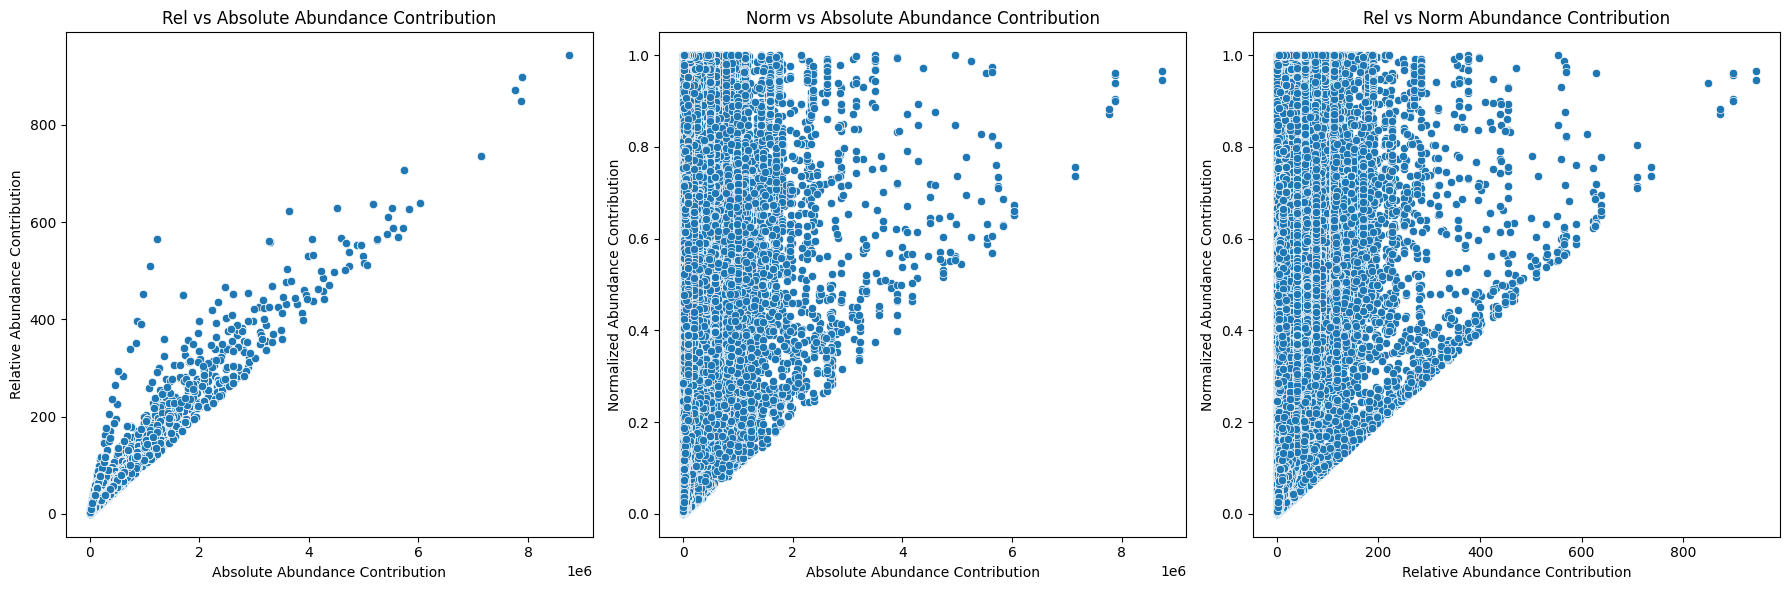

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: rel_abund_contri vs. abund_contri
sns.scatterplot(data=ECcontri_otu, x='abund_contri', y='rel_abund_contri', ax=axes[0])
axes[0].set_title("Rel vs Absolute Abundance Contribution")
axes[0].set_xlabel("Absolute Abundance Contribution")
axes[0].set_ylabel("Relative Abundance Contribution")

# Plot 2: norm_abund_contri vs. abund_contri
sns.scatterplot(data=ECcontri_otu, x='abund_contri', y='norm_abund_contri', ax=axes[1])
axes[1].set_title("Norm vs Absolute Abundance Contribution")
axes[1].set_xlabel("Absolute Abundance Contribution")
axes[1].set_ylabel("Normalized Abundance Contribution")

# Plot 3: rel_abund_contri vs. norm_abund_contri
sns.scatterplot(data=ECcontri_otu, x='rel_abund_contri', y='norm_abund_contri', ax=axes[2])
axes[2].set_title("Rel vs Norm Abundance Contribution")
axes[2].set_xlabel("Relative Abundance Contribution")
axes[2].set_ylabel("Normalized Abundance Contribution")

plt.tight_layout()
plt.show()


From the three abundances it is seen that the absolute abundance is less granular as the relative and normalised abundances. The absolute abundance tends to lead to higher relative abundance with a strong positive correlation. Seems that it aggreegates some data and there are fewer values. The Normallise Abundance removes some of the direct correlation between absolute and relative abundance and highlights differences between individual bacteria or proteins. This alignes with ther biology that same EC is present in many bacteria with varying expression levels of proteins. Since normalisation removes sample size effects, it reveals true variations across bacteria, since protein expression is highly variable within ECs, the normalise abundance appears to be the most suitable for comparisons moving forward.

In [26]:
# Count unique proteins per EC
EC_counts = ECcontri_otu.groupby("EC")["OTU"].nunique()
print(f"Unique proteins per EC", EC_counts.describe())  # Check expected range

Unique proteins per EC count    1793.000000
mean       28.528723
std        29.154307
min         1.000000
25%         4.000000
50%        15.000000
75%        52.000000
max        85.000000
Name: OTU, dtype: float64


ECcontri_otu is a comprehensive dataframe that combines site locations, taxonomic information (genera and OTUs), enzyme classifications (ECs), and pathways (code for pathway (npath) and description (pathway)). The associated abundance metrics belong to the original ECcontri. The abundance metrics include:
abund_raw: The original count of each organism (OTU) at each site
rel_abund_raw: The relative abundance of each organism at each site, expressed as a proportion of total counts
genome_function_count represents the predicted number of copies of a particular EC number (enzyme) in an organism's genome. This prediction comes from PICRUSt's hidden-state prediction process, which infers gene family abundances for each organism based on its phylogenetic placement relative to reference genomes
abund_contri: The contribution of each organism to a specific enzyme function, calculated by multiplying the raw abundance by the number of copies of that enzyme in the organism's genome
rel_abund_contri: The relative contribution of each organism to the enzyme function, accounting for both abundance and genome copy number
norm_abund_contri: The normalized contribution metric that allows comparison across different sites and functions

## 8.5. Statistical Analysis of the Genome Function Count

In [ ]:
# Analyze genome_function_count
print("Genome function count statistics:")
print("\nOverall statistics:")
print(ECcontri_otu['genome_EC_count'].describe())

# Look at distribution by EC number
print("\nExample EC numbers and their genome counts:")
ec_counts = ECcontri_otu.groupby('EC')['genome_EC_count'].agg(['unique', 'mean', 'max']).head()
print(ec_counts)

# Check if genome_function_count is consistent for each OTU-EC pair
print("\nCheck if genome_EC_count is consistent for OTU-EC combinations:")
consistency_check = ECcontri_otu.groupby(['OTU', 'EC'])['genome_EC_count'].nunique()
inconsistent = consistency_check[consistency_check > 1]
if len(inconsistent) > 0:
    print(f"Found {len(inconsistent)} OTU-EC pairs with inconsistent genome counts")
else:
    print("Genome counts are consistent for all OTU-EC pairs")

# Explain the metrics in the dataframe
print("\nDataframe Components:")
print("1. Abundance Metrics:")
print("   - abund_raw: Raw abundance of each organism in each site")
print("   - abund_contri: Organism's abundance contribution to function/pathway")
print("   - rel_abund_raw: Original relative abundance")
print("   - rel_abund_contri: Relative abundance contribution to pathway")
print("   - norm_abund_contri: Normalized abundance contribution")
print("\n2. Genome Function Count:")
print("   Number of copies of each EC (enzyme) in organism's genome")

Genome function count statistics:

Overall statistics:
count    1.491288e+06
mean     1.390277e+00
std      1.071974e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+01
Name: genome_EC_count, dtype: float64

Example EC numbers and their genome counts:
                                    unique      mean  max
EC                                                       
EC:1.1.1.1              [3, 2, 1, 5, 4, 8]  2.310375    8
EC:1.1.1.100  [8, 5, 2, 3, 4, 9, 10, 6, 1]  4.237317   10
EC:1.1.1.102                           [1]  1.000000    1
EC:1.1.1.103                           [1]  1.000000    1
EC:1.1.1.105                           [1]  1.000000    1

Check if genome_EC_count is consistent for OTU-EC combinations:
Genome counts are consistent for all OTU-EC pairs

Dataframe Components:
1. Abundance Metrics:
   - abund_raw: Raw abundance of each organism in each site
   - abund_contri: Organism's abundance contribution to function/pathway
   - rel_abund_raw: Original relative abundance
   - rel_abund_contri: Relative abundance contribution to pathway
   - norm_abund_contri: Normalized abundance contribution

2. Genome Function Count:
   Number of copies of each EC (enzyme) in organism's genome

Analysis of genome_function_count(genome_EC_count) shows that most organisms typically have just one copy of any given enzyme (EC number) in their genome, with 75% of all cases showing a single copy. However, there is notable variation, with some organisms having up to 10 copies of certain enzymes. The average across all cases is 1.4 copies per enzyme per organism.
Some enzymes show more variation than others. For example:

EC:1.1.1.1 varies from 1 to 8 copies across different organisms
EC:1.1.1.100 shows the widest range, from 1 to 10 copies
Many enzymes (like EC:1.1.1.102, 103, 105) consistently appear as single copies

Importantly, the copy number is consistent for each organism-enzyme combination across all sites, indicating this is a stable genomic characteristic.
____________________________________________



Now ECcontri_otu has several rows and columns providing information of the EC contribution to the metrics to each enzime aka EC number to the sites, genera combination, however the pathways are from origin link to most of the sites. This is perhaps because the methos infwee dunxriona bAWS ON XOMON sets of reference genomes.  Then, same environment in this case heating and cooling water systems poses similar organisms with similar pathways, the difference being on the abundance. So in order for this data to be usable, it is necesary to parse the EC into human readable information from a external enzyme databases to retrieve functional information about an EC number. Common resources include:

UniProt: query UniProt’s REST API to get enzyme details by searching with the EC number.
ExPASy Enzyme Database: Provides enzyme information based on EC numbers.
BRENDA: A comprehensive enzyme database that can be queried either via its web interface or programmatically (e.g., using the bioservices Python package). Following script creates an EnzymeRetriever class that handles API requests to UniProt, processes unique EC numbers to avoid duplicate requests
Adds protein names, functions, and UniProt IDs to ECcontri_otu df and includes rate limiting to avoid API restrictions.
The retrieval was done localy using vscode and via colab because the retrieval require a superior ram and cpu, it took batches spread on several days.

## 8.6. Retrieval of protein names from Uniprot though Api call

In [ ]:
class ColabEnzymeRetriever:
    def __init__(self, batch_size=100, save_every=5):
        self.uniprot_api = "https://rest.uniprot.org/uniprotkb/search"
        self.batch_size = batch_size
        self.save_every = save_every
        self.results_file = Path('uniprot_results.tsv')
        self.state_file = Path('retrieval_state.json')
        self.processed_pairs: Set[Tuple[str, str]] = set()
        self.existing_results = None
        self.logger = logging.getLogger(__name__)
        self.logger.setLevel(logging.INFO)

        if not self.logger.handlers:
            handler = logging.StreamHandler()
            formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
            handler.setFormatter(formatter)
            self.logger.addHandler(handler)

    def load_existing_results(self, file_path: Path) -> pd.DataFrame:
        """Load and validate existing results"""
        if file_path.exists():
            try:
                self.existing_results = pd.read_csv(file_path, sep='\t')
                self.logger.info(f"Loaded {len(self.existing_results)} existing results")

                # Build set of processed pairs
                self.processed_pairs = set()
                for _, row in self.existing_results.iterrows():
                    if pd.notna(row['ec_number']) and pd.notna(row['organism']):
                        ec_num = str(row['ec_number']).strip()
                        org = str(row['organism']).split()[0].strip()
                        self.processed_pairs.add((ec_num, org))

                return self.existing_results
            except Exception as e:
                self.logger.error(f"Error loading results file: {e}")
                self.existing_results = pd.DataFrame(
                    columns=['uniprot_id', 'ec_number', 'protein_name', 'organism', 'score']
                )
                return self.existing_results

        self.existing_results = pd.DataFrame(
            columns=['uniprot_id', 'ec_number', 'protein_name', 'organism', 'score']
        )
        return self.existing_results

    def get_uniprot_info(self, ec: str, organism: str) -> Optional[dict]:
        """Get UniProt information for a specific EC-organism pair"""
        if (ec, organism) in self.processed_pairs:
            return None

        query = f'({ec}) AND (organism_name:"{organism}*")'
        params = {
            'query': query,
            'format': 'tsv',
            'fields': 'id,ec,protein_name,organism_name',
            'size': 10
        }

        max_retries = 3
        for attempt in range(max_retries):
            try:
                response = requests.get(self.uniprot_api, params=params)
                response.raise_for_status()
                time.sleep(0.5)

                lines = response.text.strip().split('\n')
                if len(lines) < 2:
                    return None

                best_match = None
                best_score = -float('inf')

                for line in lines[1:]:
                    parts = line.split('\t')
                    if len(parts) < 4:
                        continue

                    uniprot_id, ec_numbers, protein_name, organism_name = parts

                score = 0
                if organism_name and isinstance(organism_name, str):
                    name_parts = organism_name.split()
                    genus = name_parts[0] if name_parts else ""

                    # Exact genus match gets highest score
                    if genus.lower() == organism.lower():
                        score += 500
                        # Prefer entries with just the genus name
                        if len(name_parts) == 1:
                            score += 300
                        # Heavily penalize strain designations or subspecies
                        elif len(name_parts) > 2 or any(char.isdigit() for char in organism_name):
                            score -= 400

                    if score > -float('inf'):
                        if ec.replace('EC:', '') in ec_numbers.split('; '):
                            score += 150

                            if score > best_score:
                                best_score = score
                                best_match = {
                                    'uniprot_id': uniprot_id,
                                    'ec_number': ec,
                                    'protein_name': protein_name,
                                    'organism': organism_name,
                                    'score': score
                                }

                return best_match if best_match else None

            except requests.exceptions.RequestException as e:
                if attempt < max_retries - 1:
                    time.sleep(2 ** attempt)
                    continue
                self.logger.error(f"Error fetching data from UniProt: {e}")
                return None

    def process_remaining_pairs(self, unique_pairs: pd.DataFrame, start_ec: str) -> pd.DataFrame:
        """Process remaining pairs with enforced starting point"""
        # Ensure EC format consistency
        if not start_ec.startswith('EC:'):
            start_ec = f"EC:{start_ec.replace('EC:', '')}"

        # Sort and filter pairs
        unique_pairs = unique_pairs.sort_values(['EC', 'Genus']).reset_index(drop=True)
        unique_pairs = unique_pairs[unique_pairs['EC'] >= start_ec].reset_index(drop=True)

        if len(unique_pairs) == 0:
            self.logger.warning(f"No EC numbers found after {start_ec}")
            return self.existing_results

        self.logger.info(f"Starting processing from {unique_pairs.iloc[0]['EC']}")
        total_pairs = len(unique_pairs)

        results = []
        for idx in range(0, total_pairs, self.batch_size):
            batch = unique_pairs.iloc[idx:idx + self.batch_size]
            batch_results = []

            self.logger.info(f"\nProcessing batch {idx//self.batch_size + 1} of {total_pairs//self.batch_size + 1}")
            self.logger.info(f"Progress: {idx}/{total_pairs} pairs ({(idx/total_pairs)*100:.1f}%)")

            current_ec = None
            for _, row in batch.iterrows():
                if current_ec != row['EC']:
                    current_ec = row['EC']
                    self.logger.info(f"\nProcessing EC number: {current_ec}")

                if (row['EC'], row['Genus']) not in self.processed_pairs:
                    result = self.get_uniprot_info(row['EC'], row['Genus'])
                    if result:
                        batch_results.append(result)
                        self.processed_pairs.add((row['EC'], row['Genus']))

            if batch_results:
                results.extend(batch_results)

                # Save progress periodically
                if (idx//self.batch_size) % self.save_every == 0:
                    combined_results = pd.concat(
                        [self.existing_results, pd.DataFrame(results)],
                        ignore_index=True
                    )
                    combined_results.to_csv(self.results_file, sep='\t', index=False)
                    self.logger.info(f"Saved {len(combined_results)} total results to file")

        # Final save
        final_results = pd.concat(
            [self.existing_results, pd.DataFrame(results)],
            ignore_index=True
        )
        final_results.to_csv(self.results_file, sep='\t', index=False)

        return final_results

def continue_enzyme_retrieval(unique_pairs: pd.DataFrame, existing_results_file: Path, start_ec: str):
    """Main function to continue enzyme data retrieval"""
    retriever = ColabEnzymeRetriever(batch_size=100)

    # Load existing results
    retriever.load_existing_results(existing_results_file)

    # Ensure input data is properly formatted
    if isinstance(unique_pairs, str):
        unique_pairs = pd.read_csv(unique_pairs, sep='\t')
    elif isinstance(unique_pairs, pd.DataFrame):
        unique_pairs = unique_pairs.copy(deep=False)
    else:
        raise ValueError("Input must be either a file path or a pandas DataFrame")

    # Validate and prepare input data
    required_columns = ['EC', 'Genus']
    if not all(col in unique_pairs.columns for col in required_columns):
        raise ValueError(f"Input data must contain columns: {required_columns}")

    unique_pairs['EC'] = unique_pairs['EC'].astype(str).apply(lambda x: f"EC:{x.replace('EC:', '')}")
    unique_pairs['Genus'] = unique_pairs['Genus'].astype(str).str.strip()
    unique_pairs = unique_pairs[['EC', 'Genus']].drop_duplicates()

    # Process remaining pairs
    results_df = retriever.process_remaining_pairs(unique_pairs, start_ec)

    # Save final results
    final_path = Path('uniprot_results_final.tsv')
    results_df.to_csv(final_path, sep='\t', index=False)

    return results_df

In [ ]:
'''uniprot_results_path = Path(base_dir '/uniprot_results.tsv')
# Usage (after uploading files to Colab), ECcontri_otu was made in colab because it was too big to upload after transformed
results = continue_enzyme_retrieval(ECcontri_otu, uniprot_results_path, start_ec="x.3.1.12" )'''

## 8.6. Cleaning and Preparing Retrieved Data to integrate to ECContri

In [15]:
df_1_path = Path(base_dir / "uniprot_1_4_sorted.tsv") # First file retrieved on first run 4 am
df_2_path = Path(base_dir / "uniprot_2_1.38_sorted.tsv") # Same file retrieven when corrupted around 1:38 following day
df_3_path = Path(base_dir / "uniprot_3_sorted.tsv") # Rerun done trying to get following EC numbers
df_4_path = Path(base_dir / "uniprot_4_missing_sorted.tsv") # Final run in missing data

df_1 = pd.read_csv(df_1_path, sep='\t')
df_2 = pd.read_csv(df_2_path, sep='\t')
df_3 = pd.read_csv(df_3_path, sep='\t')
df_4 = pd.read_csv(df_4_path, sep='\t')
print(len(df_1), len(df_2), len(df_3), len(df_4))

37015 39042 9064 2827


In [16]:
# extract EC and Genus from the Retrieved files, so I need to join them first
retrieved = pd.concat([df_1, df_2, df_3, df_4], axis = 0)
# unique pairs on our data
unique_pairs = ECcontri_otu[['EC', 'Genus']].drop_duplicates()

## 8.7 Extracting the Genus from the retrieved_pairs

In [17]:
# Function to extract the Genus from the organism str
def extract_genus(organism_str):
    # Assumes Genus is the first word that starts with an uppercase letter.
    match = re.search(r'([A-Z][a-z]+)', organism_str)
    return match.group(1) if match else None
# Creating a Genus column in the retrieved dataframe.
retrieved['Genus'] = retrieved['organism'].astype(str).apply(extract_genus)

# if there are duplicates, we want the best entry based on score:
retrieved_unique = retrieved.sort_values('score', ascending=False)\
                            .drop_duplicates(subset=['ec_number', 'Genus'])

In [ ]:
print(f"unique_pairs Galaxy data:{len(unique_pairs)}, Uniprot retrieved data:{len(retrieved_unique)}")

In [27]:
# Merging using a left join on the two keys (EC_number and Genus). Plus an indicator of missing data.
ECcontri_Uniprot  = pd.merge(
    ECcontri_otu,
    retrieved_unique[['ec_number', 'Genus', 'protein_name', 'score', 'uniprot_id']],
    left_on=['EC', 'Genus'],
    right_on=['ec_number', 'Genus'],
    how='left',
    suffixes=('', '_retr')
)
print(ECcontri_Uniprot.shape) # Very slow 1 minute, can kill the kernel

(1491288, 16)


In [28]:
ECcontri_Uniprot = ECcontri_Uniprot.drop(columns = ["OTU",	"ec_number",	"npath", "pathway",	"score"])

## 8.8. Missing Values
ECcontri_uniprot_info is the final df mixed and is keep for reference only purposes. With the missing unique df I will retrive again the rest of the missing values

In [29]:
#Rows with no match from retrieved_unique will have '_merge' value of 'left_only'
merged_unique = pd.merge(
    unique_pairs,
    retrieved_unique,
    left_on=['EC', 'Genus'],
    right_on=['ec_number', 'Genus'],
    how='left',
    indicator=True
)

# Filter unique pairs missing from retrieved data
ECcontri_missing = merged_unique[merged_unique['_merge'] == 'left_only']
print("Missing unique pairs count:", ECcontri_missing.shape[0])
ECcontri_missing = ECcontri_missing[["EC", "Genus"]]
file_path = os.path.join(output_base, "ECcontri_missing.tsv")
ECcontri_missing.to_csv(file_path, sep='\t', index=False)

Missing unique pairs count: 12646


## 8.9 Cleaning Protein Names on ECcontri_Uniprot

In [30]:
def clean_protein_name(name):
    """
    Enhanced protein name cleaning:
    1. Remove EC numbers unless it's the only information
    2. Remove redundant information in parentheses
    3. Remove duplicated terms
    4. Handle special cases
    """
    if pd.isna(name):
        return "Uncharacterized protein"

    # If the name is just an EC number in any format, return it
    if re.match(r'^[\s\(\)]*EC\s*[\d\.]+[\s\(\)]*$', name):
        return name.strip()

    # Remove EC numbers and content in parentheses
    name = re.sub(r'\(EC\s*[\d\.]+\)', '', name)
    name = re.sub(r'\([^)]*\)', '', name)

    # Split into words and remove duplicates while preserving order
    words = name.split()
    seen = set()
    unique_words = []
    for word in words:
        # Convert to lowercase for comparison but keep original case in result
        lower_word = word.lower()
        if lower_word not in seen:
            seen.add(lower_word)
            unique_words.append(word)

    # Rejoin words
    name = ' '.join(unique_words)

    # Remove specific redundant patterns
    redundant_patterns = [
        (r'enzyme\s+enzyme', 'enzyme'),
        (r'synthase\s+synthase', 'synthase'),
        (r'transferase\s+transferase', 'transferase'),
        (r'-glucan\s+glucan', 'glucan'),
        (r'protein\s+protein', 'protein')
    ]

    for pattern, replacement in redundant_patterns:
        name = re.sub(pattern, replacement, name, flags=re.IGNORECASE)

    return name.strip()

def check_cleaning(df, n_samples=10):
    """
    Check the cleaning results with before/after comparison
    """
    sample_names = df['protein_name'].dropna().sample(n=n_samples)
    cleaned_names = sample_names.apply(clean_protein_name)

    print("Sample of name cleaning results:")
    for orig, cleaned in zip(sample_names, cleaned_names):
        print(f"\nOriginal:  {orig}")
        print(f"Cleaned:   {cleaned}")


In [31]:
# Standardize EC format: Extract numbers without the 'EC:' prefix
ECcontri_Uniprot['EC_clean'] = ECcontri_Uniprot['EC'].str.replace('EC:', '', regex=False)
ECcontri_Uniprot = ECcontri_Uniprot.drop(columns = ["EC"])
ECcontri_Uniprot = ECcontri_Uniprot.rename(columns={"EC_clean": "EC"})

# Applaying the protein name cleaning
check_cleaning(ECcontri_Uniprot)

ECcontri_Uniprot['protein_name'] = ECcontri_Uniprot['protein_name'].apply(clean_protein_name)
# Saving the data
ECcontri_Uniprot_path = output_large / 'ECcontri_Uniprot.tsv'
ECcontri_Uniprot.to_csv(ECcontri_Uniprot_path, sep='\t', index=False)

Sample of name cleaning results:

Original:  Enoyl-CoA hydratase / Delta(3)-cis-delta(2)-trans-enoyl-CoA isomerase / 3-hydroxyacyl-CoA dehydrogenase / 3-hydroxybutyryl-CoA epimerase (EC 1.1.1.35, EC 4.2.1.17, EC 5.1.2.3, EC 5.3.3.8)
Cleaned:   Enoyl-CoA hydratase / Delta-cis-delta-trans-enoyl-CoA isomerase 3-hydroxyacyl-CoA dehydrogenase 3-hydroxybutyryl-CoA epimerase

Original:  Riboflavin biosynthesis protein [Includes: Riboflavin kinase (EC 2.7.1.26) (Flavokinase); FMN adenylyltransferase (EC 2.7.7.2) (FAD pyrophosphorylase) (FAD synthase)]
Cleaned:   Riboflavin biosynthesis protein [Includes: kinase ; FMN adenylyltransferase ]

Original:  Nicotinamide-nucleotide amidase (EC 3.5.1.42)
Cleaned:   Nicotinamide-nucleotide amidase

Original:  Altronate dehydratase (EC 4.2.1.7)
Cleaned:   Altronate dehydratase

Original:  Malate synthase G (EC 2.3.3.9)
Cleaned:   Malate synthase G

Original:  Uroporphyrinogen-III synthase (EC 4.2.1.75)
Cleaned:   Uroporphyrinogen-III synthase

Original: 

### Calculate & Visualize Total Protein Count per EC

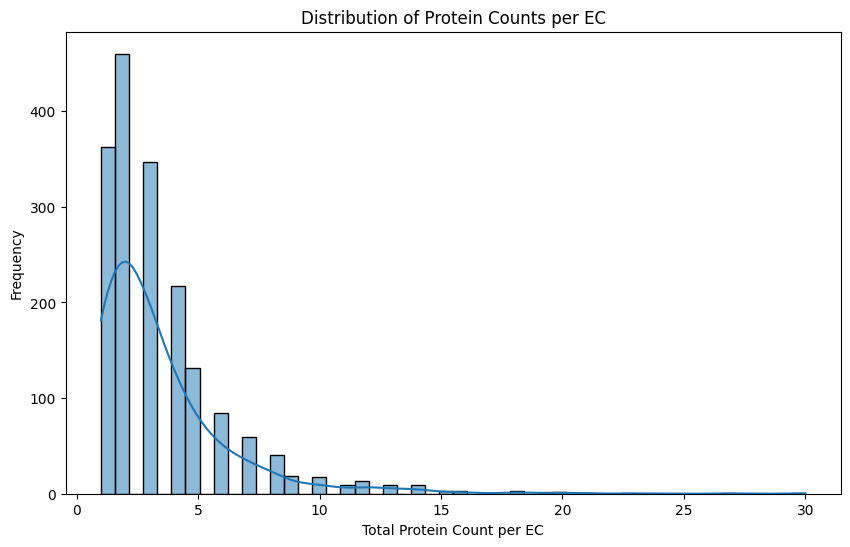

In [33]:
# Grouping by EC and counting unique proteins
ec_protein_counts = ECcontri_Uniprot.groupby('EC')['protein_name'].nunique().reset_index()
ec_protein_counts.columns = ['EC', 'Protein_Count']

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(ec_protein_counts['Protein_Count'], bins=50, kde=True)
plt.xlabel("Total Protein Count per EC")
plt.ylabel("Frequency")
plt.title("Distribution of Protein Counts per EC")
plt.show()

It is notice that EC wont scale with protein abundance proportionally as the skewed plot shows, this is notice onthe Uniprot tables where a EC has hundred if no thousands of proteins and hundred of organisms. There might be threshold effects were a minimum protein abundance will be relevant for a microorganism metabolism and hence we could stablish those threshold in order to visualise better those protein that are really relevant to the bacteria in question.

### Computing the Knee point for Genus of Protein Significance
Here it is computed the knee point where the activity of protein drops for each genus

In [34]:
ECcontri_Uniprot.head()

,Sites,Genus,abund_raw,rel_abund_raw,genome_EC_count,abund_contri,rel_abund_contri,norm_abund_contri,protein_name,uniprot_id,EC
0,site_1,Pseudomonas,52779.0,7.212466,3,158337.0,21.637399,0.113280,Probable alcohol dehydrogenase,TERPD_PSESP,1.1.1.1
1,site_1,Simplicispira,15295.0,2.090124,2,30590.0,4.180249,0.021885,alcohol dehydrogenase,A0A398C8R1_9BURK,1.1.1.1
2,site_1,Acidovorax,62473.0,8.537191,1,62473.0,8.537191,0.044695,Uncharacterized protein,NaN,1.1.1.1
3,site_1,Dechloromonas,7109.0,0.971474,1,7109.0,0.971474,0.005086,Uncharacterized protein,NaN,1.1.1.1
4,site_1,Desulfobulbus,861.5,0.117727,2,1723.0,0.235455,0.001233,alcohol dehydrogenase,A0A9C9XQV1_9BACT,1.1.1.1


In [40]:
!pip install kneed
from kneed import KneeLocator

In [74]:

!pip install --upgrade scipy
import scipy
print(scipy.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 14.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
1.14.1


TypeError: savgol_filter() got an unexpected keyword argument 'polynomial_order'

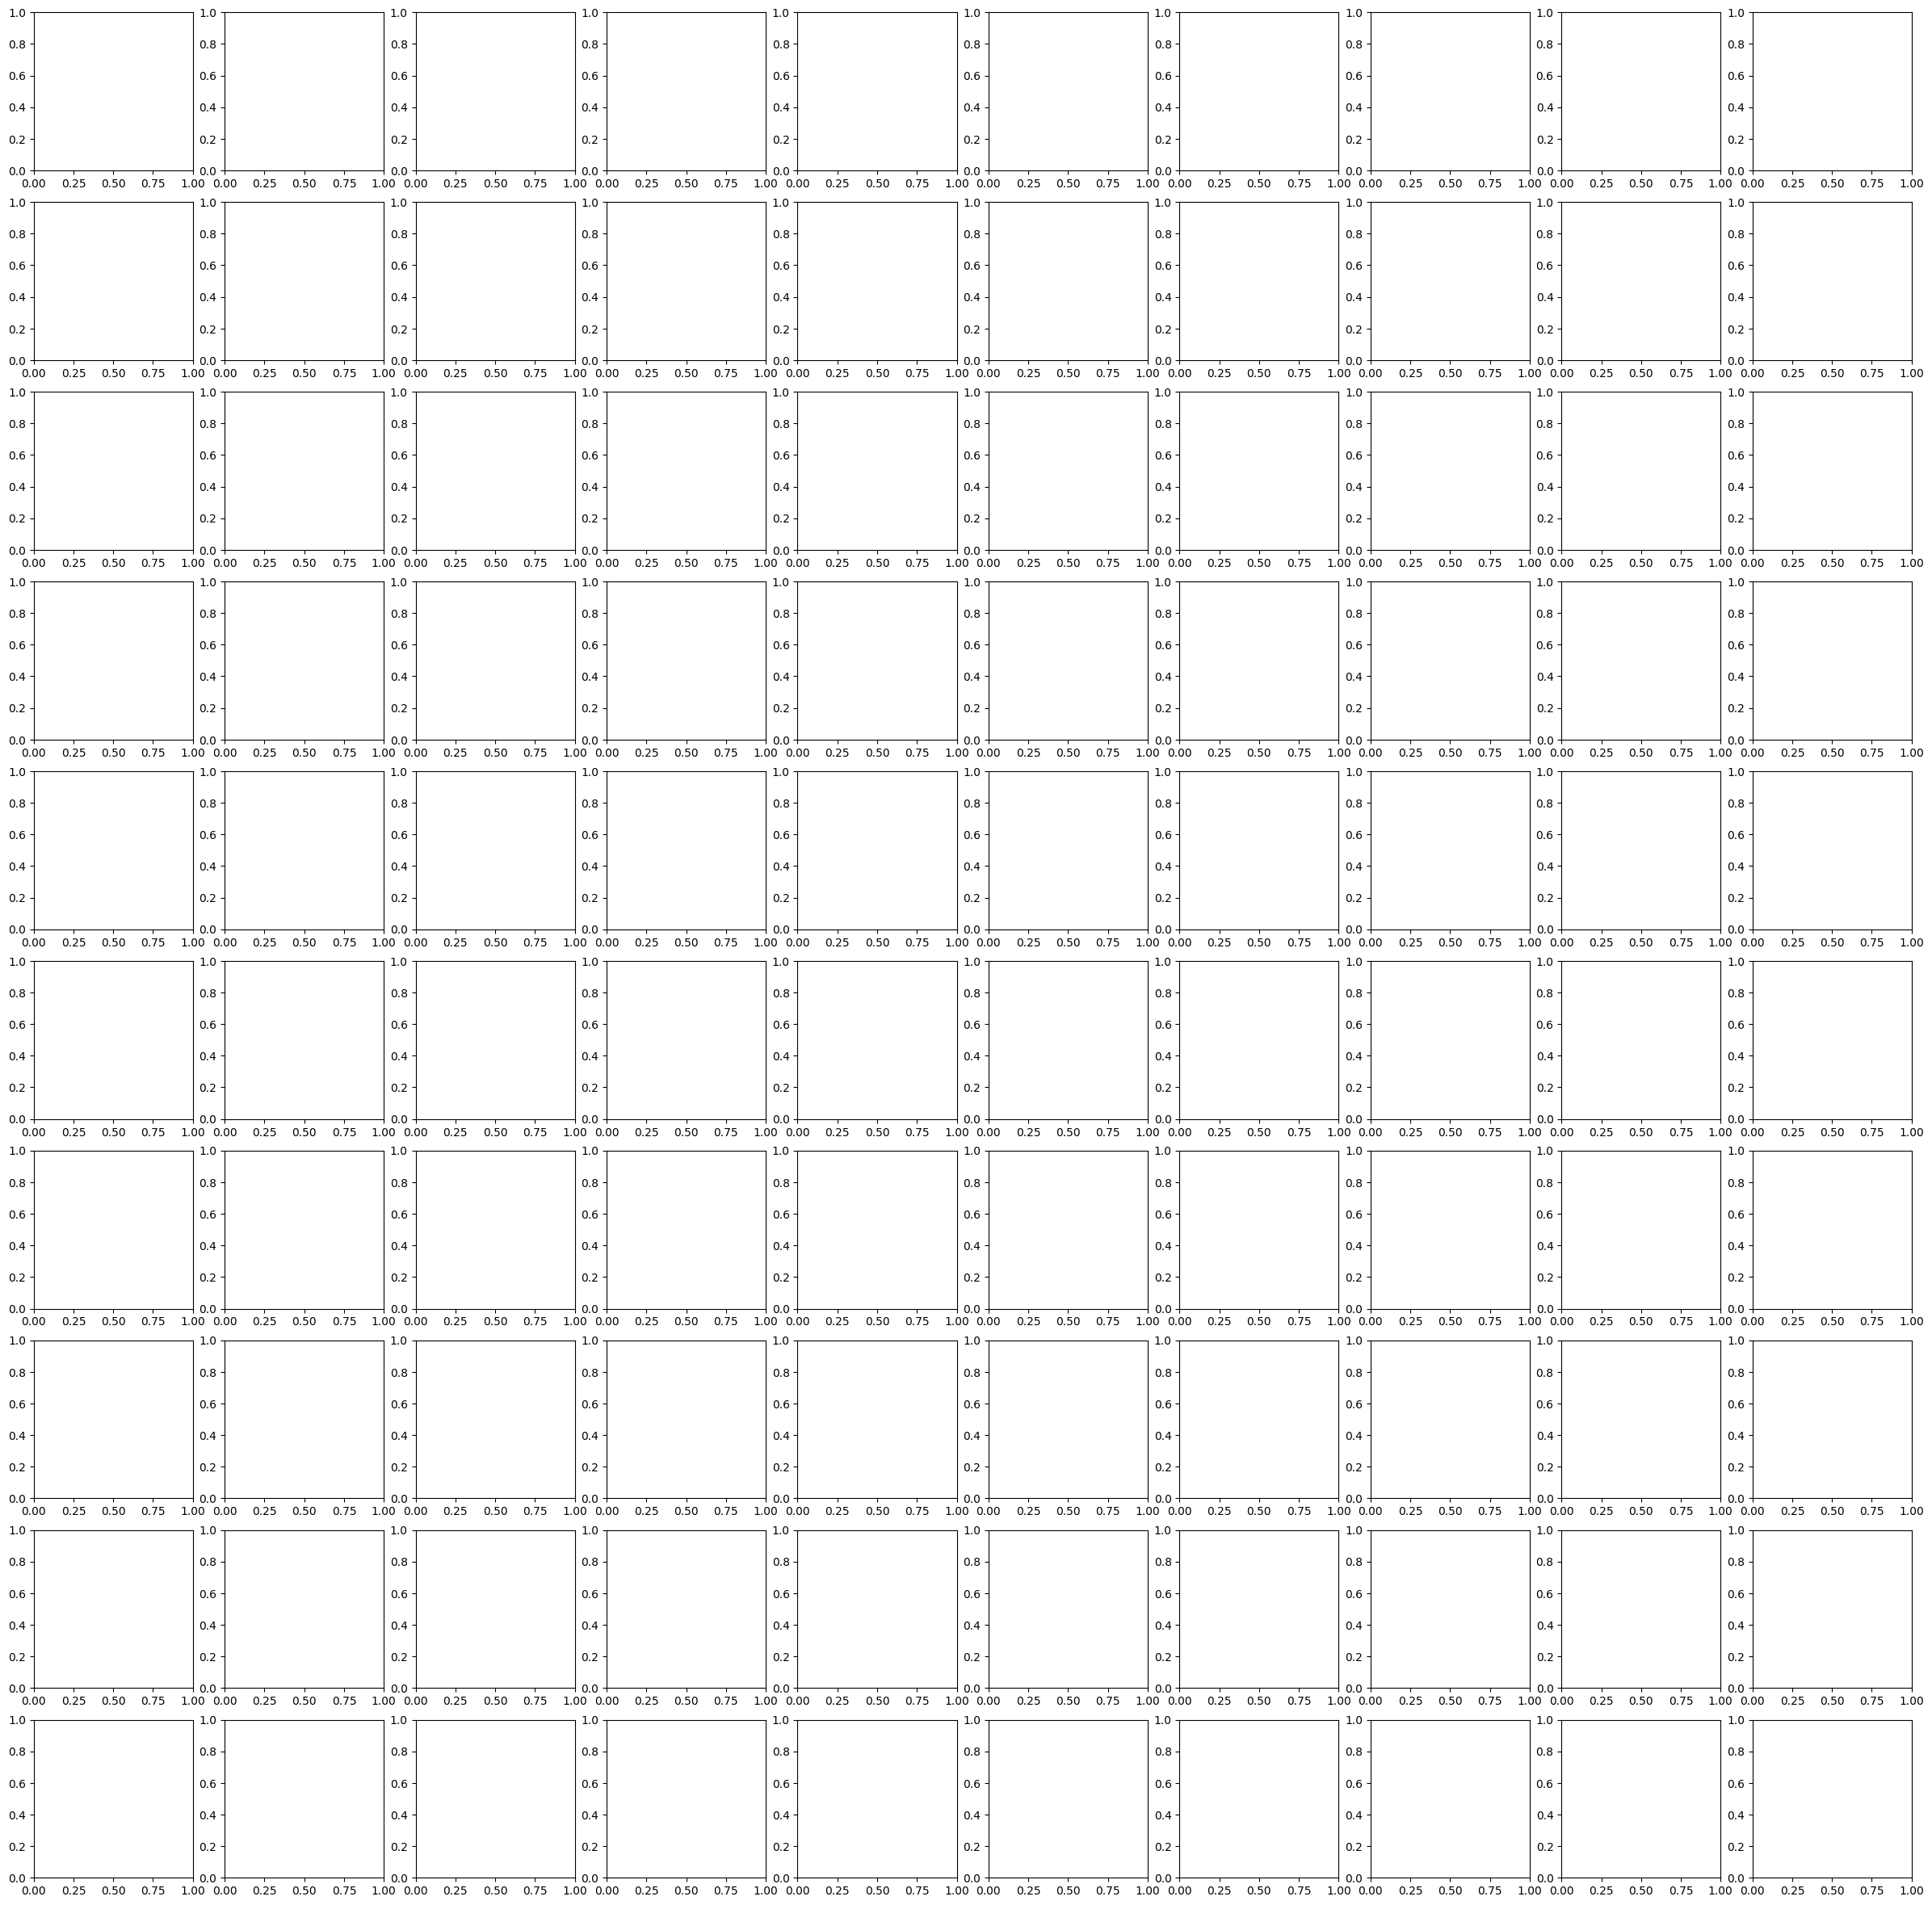

In [75]:
import scipy
from scipy.signal import savgol_filter
def knee_point_analysis(df, abundance_col):
    # Dictionary to store knee points for each genus
    knee_points = {}

    # Calculate total number of genera to determine plot grid size
    num_genera = df["Genus"].nunique()
    num_rows = int(np.ceil(np.sqrt(num_genera)))  # Number of rows in subplot grid
    num_cols = num_rows  # Same for columns in a square grid
    # Adjust figure size based on the number of genera
    figsize = (num_cols * 3, num_rows * 3)  # Dynamically adjust figure size

    # Plot setup
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=figsize)  # Adjust for ~85 genera
    axes = axes.flatten()
    num_subplots = num_rows * num_cols
    for i, (genus, group) in enumerate(df.groupby("Genus")):
        group = group.sort_values(abundance_col, ascending=False).reset_index(drop=True)
        x = np.arange(len(group))  # Protein rank
        y = group[abundance_col].values  # Abundance values

        # Apply Savitzky-Golay smoothing
        y_smoothed = savgol_filter(y, window_length=7, polynomial_order=3)

        # Knee detection (concave function, decreasing trend) y_smoothed,
        kneedle = KneeLocator(x, y_smoothed, curve="convex", direction="decreasing", online= True, S=1.5)

        #knee_point = kneedle.knee
        if kneedle.knee:
            knee_points[genus] = group.iloc[kneedle.knee][abundance_col]

        # Plot for visualization
        axes[i].plot(x, y, label=genus)
        axes[i].plot(x, y_smoothed, label=f"{genus} (Smoothed)", color='orange')
        if kneedle.knee:
            axes[i].axvline(kneedle.knee, color='r', linestyle="--", label="Knee Point")
        axes[i].set_title(genus, fontsize=8)
        axes[i].set_ylabel(abundance_col)
        axes[i].tick_params(axis='both', which='major', labelsize=6)
        legend = axes[i].legend(fontsize=6, handlelength=1)

    # Remove empty subplots (after the loop)
    for i in range(num_genera, num_subplots):
        fig.delaxes(axes[i])  # Remove the extra subplot from the figure

    plt.tight_layout(pad=0.5)
    plt.show()

    # Convert knee points dictionary to DataFrame for analysis
    knee_df = pd.DataFrame(knee_points.items(), columns=["Genus", "Knee_Abundance"])
    print(knee_df)

knee_df = knee_point_analysis(ECcontri_Uniprot, "norm_abund_contri") # rel_abund_raw	genome_EC_count	abund_contri	rel_abund_contri	norm_abund_contri

The knee points in red are consistent with protein drop in protein abundance between each genera. Some genera have a steeper drop, making the knee point clear, while others have a gradual decline, which might make the knee less biologically meaningful

In [47]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
from kneed import KneeLocator

def knee_point_analysis_plotly(df):
    knee_points = {}

    # Calculate total number of genera to determine plot grid size
    num_genera = df["Genus"].nunique()
    num_rows = int(np.ceil(np.sqrt(num_genera)))
    num_cols = num_rows

    # Create subplot figure with Plotly
    fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=df["Genus"].unique())

    for i, (genus, group) in enumerate(df.groupby("Genus")):
        group = group.sort_values("norm_abund_contri", ascending=False).reset_index(drop=True)
        x = np.arange(len(group))
        y = group["norm_abund_contri"].values

        # Knee detection
        kneedle = KneeLocator(x, y, curve="concave", direction="decreasing")
        if kneedle.knee:
            knee_points[genus] = group.iloc[kneedle.knee]["norm_abund_contri"]

        # Determine subplot row and column
        row = i // num_cols + 1
        col = i % num_cols + 1

        # Add trace (line plot) to the subplot
        fig.add_trace(
            go.Scatter(x=x, y=y, mode='lines', name=genus),
            row=row, col=col
        )

        # Add vertical line for knee point
        if kneedle.knee:
            fig.add_shape(
                type="line",
                x0=kneedle.knee,
                y0=y.min(),
                x1=kneedle.knee,
                y1=y.max(),
                line=dict(color="red", dash="dash"),
                row=row, col=col
            )
        # Remove empty subplots
        num_subplots = num_rows * num_cols
        for i in range(num_genera, num_subplots):
            fig.update_layout(
                xaxis=dict(domain=[0, 0], showticklabels=False, visible=False, title=""), # Hide x-axis
                yaxis=dict(domain=[0, 0], showticklabels=False, visible=False, title=""), # Hide y-axis
                annotations=[ # Remove subplot title
                    go.layout.Annotation(
                        text="",  # Set title to empty
                        xref="paper",
                        yref="paper",
                        x=(i % num_cols) / num_cols + 0.5 / num_cols,  # Subplot title position
                        y=(num_rows - (i // num_cols)) / num_rows - 0.5 / num_rows,
                        showarrow=False,
                    )
                ]
            )

    # Update layout for better visualization
    fig.update_layout(height=num_rows * 300, width=num_cols * 300, title_text="Knee Point Analysis")
    fig.show()

    knee_df = pd.DataFrame(knee_points.items(), columns=["Genus", "Knee_Abundance"])
    print(knee_df)

    return knee_df

knee_df = knee_point_analysis_plotly(ECcontri_Uniprot)

KeyboardInterrupt: 

### Cleaning anc collecting garbage

In [ ]:
del picrust_long
del retrieved
del retrieved_unique
del unique_pairs
del df_1
del df_2
del df_3
del df_4
del ECcontri
del ECcontri_agg_site
#del ECcontri_otu

In [ ]:
import gc
gc.collect()

### Data Retrieval Completion Note
After multiple retrieval attempts, 12,656 pairs remain unmapped out of approximately 1,500,000 total rows (0.84%). Given this small percentage and the diminishing returns from further retrieval attempts, we concluded that this level of completeness is acceptable for analysis.
______________________________

#9. Building a Dictionary from Databases

Data Normalization and Mapping
It was ensured that all protein/EC data (including EC numbers, KO numbers, and reaction IDs) were parsed and cleaned. This identifiers were mapped to their corresponding metabolic pathways using databases such as KEGG, MetaCyc, and BioCyc.

Identifying Metal-Related Proteins:
cross-reference proteins with metal-related databases (BRENDA, MetalPDB, TransportDB) where crossreferenced to flag those with direct metal-binding or metal-transport roles. Then consolidate similar metal terms (e.g., “iron”, “Fe”, “ferric”) into a unified field to improve consistency in later analyses.



Final Assembly:
I compile the data into a final dictionary/table that includes all relevant columns (Protein, EC/KO, Metabolism, Pathway, Metal Interaction, MIC Function). This allows me to search programmatically for the functional roles of proteins that are influential in corrosion studies.

## 9.1 Setting up Paths and Parsing the Dataframes

In [ ]:
db_dir = Path("/kaggle/input/databases/Databases") #kaggle
def setup_paths():
    """Set up paths for database access"""

    # Database paths
    db_paths = {
        'enzyme': db_dir / 'enzyme',
        'enzyme_class': db_dir / 'enzclass.txt',
        'enzyme_brenda' : db_dir/ 'brenda_2024.txt',
        'ko': db_dir / 'ko',
        'ko_hierarchy': db_dir / 'ko_hierarchy.txt',
        'pathway': db_dir / 'pathway',
        'module': db_dir / 'module',
        'reaction': db_dir / 'reaction',
        'compound': db_dir / 'compound',
        'metalpdb': db_dir / 'flat_db_file.xml',
        'ko_pathway': db_dir / 'ec_pathway.list'
    }

    return db_paths

#  Calling the paths
if __name__ == "__main__":
    paths = setup_paths()
    # Print paths to verify
    for db_name, path in paths.items():
        print(f"{db_name}: {path}")
        print(f"Exists: {path.exists()}")

### Brenda Enzyme Parse Brenda

https://www.brenda-enzymes.org/download.php

Chang A., Jeske L., Ulbrich S., Hofmann J., Koblitz J., Schomburg I., Neumann-Schaal M., Jahn D., Schomburg D.
BRENDA, the ELIXIR core data resource in 2021: new developments and updates. (2021), Nucleic Acids Res., 49:D498-D508.
DOI: 10.1093/nar/gkaa1025 PubMed: 33211880

In [ ]:
import logging
logging.basicConfig(level=logging.INFO)

def parse_brenda_file():
    """Parse BRENDA database file for detailed enzyme information"""
    paths = setup_paths()
    enzyme_brenda_path = paths['enzyme_brenda']

    ec_detailed_info = {}
    current_ec = None
    in_enzyme_entry = False

    try:
        with open(enzyme_brenda_path, 'r') as f:
          for line in f:
              line = line.strip()

              # Skip empty lines
              if not line:
                  continue

              # Check for the end of an entry
              if line == "///":
                  current_ec = None
                  in_enzyme_entry = False
                  continue

              # Process ID line - identify enzyme entries
              if line.startswith('ID\t'):
                  current_ec = line.split('\t')[1]

                  # Skip "spontaneous" and other non-EC entries
                  if not any(c.isdigit() for c in current_ec):
                      current_ec = None
                      in_enzyme_entry = False
                      continue

                  # Initialize proper EC entry
                  ec_detailed_info[current_ec] = {
                      'metals': [],
                      'cofactors': [],
                      'reactions': [],
                      'substrates': [],
                      'inhibitors': []
                  }
                  in_enzyme_entry = True

              # Only process other lines if we're in a valid enzyme entry
              elif in_enzyme_entry and current_ec:
                  if line.startswith('ME\t'):
                      # Extract metal information
                      metal_info = line.split('\t')[1]
                      ec_detailed_info[current_ec]['metals'].append(metal_info)

                  elif line.startswith('CF\t'):
                      # Extract cofactor information
                      cofactor_info = line.split('\t')[1]
                      ec_detailed_info[current_ec]['cofactors'].append(cofactor_info)

                  elif line.startswith('RE\t'):
                      # Extract detailed reaction information
                      reaction_info = line.split('\t')[1]
                      ec_detailed_info[current_ec]['reactions'].append(reaction_info)

                  elif line.startswith('SP\t') or line.startswith('NSP\t'):
                      # Extract substrate information
                      substrate_info = line.split('\t')[1]
                      ec_detailed_info[current_ec]['substrates'].append(substrate_info)

                  elif line.startswith('IN\t'):
                      # Extract inhibitor information
                      inhibitor_info = line.split('\t')[1]
                      ec_detailed_info[current_ec]['inhibitors'].append(inhibitor_info)

        # Verify we have valid EC numbers
        ec_detailed_info = {ec: info for ec, info in ec_detailed_info.items()
                            if ec.count('.') == 3 and all(part.isdigit() for part in ec.split('.'))}

    except Exception as e:
        logging.error("Error parsing BRENDA file: %s", e)
        return {}
    return ec_detailed_info

brenda_data = parse_brenda_file()
#brenda_data

In [ ]:
def process_brenda_data(brenda_data):
    """Process BRENDA data to extract clean metal information while keeping other data intact"""
    processed_data = {}

    # Common metal ions to look for
    metal_patterns = {'iron': ['Fe2+', 'Fe3+', 'iron', 'ferrous', 'ferric'],
        'manganese': ['Mn2+', 'manganese'],
        'copper': ['Cu+', 'Cu2+', 'copper'],
        'nickel': ['Ni2+', 'nickel'],
        'cobalt': ['Co2+', 'cobalt'],
        'magnesium': ['Mg2+', 'magnesium'],
        'calcium': ['Ca2+', 'calcium'],
        'Mo': ['Mo', 'molybdenum'],
        'V5+': ['V5+', 'vanadium'],
        'Al3+': ['Al3+', 'aluminum'],
        'Cr3+': ['Cr3+', 'chromium'],
        'zinc': ['Zn2+', 'zinc'],
        'sodium': ['Na+', 'sodium', 'NaCl'],
        'potassium': ['K+', 'potassium', 'KCl'],
        'selenium': ['selenium', 'Se'],
        'barium': ['Ba2+', 'barium'],
        'phosphate': ['HPO4-2', 'PO4-3', 'phosphate', 'phosphates'],
        'nitrate': ['NO3-', 'nitrate', 'nitrates'],
        'nitrite': ['NO2-', 'nitrite', 'nitrites'],
        'chloride': ['Cl-', 'chloride', 'chlorine'],
        'sulfate': ['SO4-2', 'sulfate', 'sulfates'],
        'sulfide': ['S', 'sulfide', 'sulfides'],
        'thiosulfate': [ 'S'],
        's-s': ['S']
    }
    # Pathway categories collecting all terms
    pathway_categories = {
        'organic_acid_metabolism': [
            'acetate', 'acetic acid', 'acetyl',
            'oxalate', 'oxalic acid',
            'organic acid', 'fatty acid',
            'carboxylic acid'
        ],
        'metal_organic_interaction': [
            'siderophore', 'metal binding',
            'iron complex', 'metal transport',
            'metallophore', 'metal organic'
        ],
        'biofilm_formation': [
            'biofilm', 'exopolysaccharide',
            'extracellular matrix', 'adhesion'
        ],
        'halogen_related': [
            'halogen', 'chloride', 'bromide',
            'halide', 'dehalogenation'
        ],
        'sulfur': [
            'sulfur', 'sulfate', 'sulfide',
            'thiosulfate', 'sulfite', 'sulfonate'
        ],
        'electron_transfer': [
            'cytochrome', 'electron transport',
            'oxidoreductase', 'redox'
        ],
        'carbon_metabolism': [
            'carbon fixation', 'carbon utilization',
            'carbohydrate metabolism'
        ],
        'ph_modulation': [
            'acid', 'alkaline', 'proton pump',
            'pH homeostasis'
        ],
        'temp_response': [
            'heat shock', 'cold shock',
            'temperature response'
        ]
    }

    # Define organic matter categories
    organic_categories = {
        'degradation': ['degradation', 'breakdown', 'catabolism'],
        'synthesis': ['biosynthesis', 'anabolism', 'synthesis'],
        'transport': ['transport', 'uptake', 'export'],
        'modification': ['modification', 'conversion', 'transformation']
    }

    for ec_number, data in brenda_data.items():
        processed_data[ec_number] = {
            'cofactors': data.get('cofactors', []),
            'reactions': data.get('reactions', []),
            'substrates': data.get('substrates', []),
            'inhibitors': data.get('inhibitors', []),
            'raw_metals': data.get('metals', []),
            'clean_metals': [],
            'pathway_categories': {},
            'organic_processes': {}

        }

        # Extract clean metal names
        for entry in data.get('metals', []):
            entry_lower = entry.lower()
            for metal in metal_patterns:
                metal_lower = metal.lower()
                if metal_lower in entry_lower:
                    if metal not in processed_data[ec_number]['clean_metals']:
                        processed_data[ec_number]['clean_metals'].append(metal)

        # Create a single text string for pathway searching
        all_text = ' '.join([
            ' '.join(data.get('reactions', [])),
            ' '.join(data.get('substrates', [])),
            ' '.join(data.get('cofactors', []))
        ]).lower()

        # Add corrosion relevance information
        processed_data[ec_number]['corrosion_metals_from_brenda'] = [
            metal for metal in processed_data[ec_number]['clean_metals']
            if metal in ['Fe2+', 'Fe3+', 'iron', 'Mn2+', 'manganese', 'Cu+', 'Cu2+',
                         'copper', 'Ni2+', 'nickel', 'Co2+', 'cobalt']
        ]
        ## Add pathway relevance information, would it no be better to search for this relevance on the pathway database?
        for category, terms in pathway_categories.items():
            if any(term.lower() in all_text for term in terms):
                processed_data[ec_number]['pathway_categories'][category] = True

        # Check for organic matter processes
        for category, terms in organic_categories.items():
            if any(term.lower() in all_text for term in terms):
                processed_data[ec_number]['organic_processes'][category] = True

        # Calculate corrosion relevance score based on metals
        if processed_data[ec_number]['corrosion_metals_from_brenda']:
            processed_data[ec_number]['corrosion_relevance'] = 'high'
        elif processed_data[ec_number]['clean_metals']:
            processed_data[ec_number]['corrosion_relevance'] = 'medium'
        else:
            processed_data[ec_number]['corrosion_relevance'] = 'low'

    return processed_data

brenda_en= process_brenda_data(brenda_data)
#brenda_en.keys()

### Enzyme names
The database containing enzyme names and EC numbers

wget https://www.enzyme-database.org/downloads/enzyme-database.sql.gz

In [ ]:
def read_enzyme_names():
    """Read and parse enzyme file to get EC numbers and their names"""
    paths = setup_paths()
    enzyme_path = paths['enzyme']

    ec_to_names = {}  # More descriptive name
    with open(enzyme_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                ec_number = parts[0]
                names = parts[1].split('; ')
                ec_to_names[ec_number] = names

    for ec_number, names_list in ec_to_names.items():

        cleaned_names = [clean_protein_name(name) if isinstance(name, str) else str(name) for name in names_list]
        ec_to_names[ec_number] = cleaned_names

    return ec_to_names
ec_to_names = read_enzyme_names()
#list(ec_to_names.items())[:100]

### Enzyme Class
The enzyme classification system (text-based hierarchy).

In [ ]:
def read_enzyme_class():
    paths = setup_paths()
    ec_file_path = paths['enzyme_class']

    enzyme_class = {}

    with open(ec_file_path, 'r') as f:
        for line in f:
            # Format is like "1. 1. 1.-    With NAD(+) or NADP(+) as acceptor."
            if line.strip() and any(line.startswith(str(i)) for i in range(1, 7)):
                parts = line.strip().split('  ')
                if len(parts) >= 2:
                    ec_id = parts[0].replace(' ', '')
                    desc = parts[1].strip()
                    enzyme_class[ec_id] = desc
    return enzyme_class
enzyme_class = read_enzyme_class()
#list(enzyme_class.items())[:100]

Ko list

wget -O ec_pathway.list "https://rest.kegg.jp/link/pathway/ec"

In [ ]:
def read_ec_pathway_mapping():
    """Read EC to pathway mapping file downloaded from KEGG"""

    paths = setup_paths()
    ko_pathway_path = paths['ko_pathway']

    ec_to_pathway = {}

    try:
        with open(ko_pathway_path , 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    ec_id = parts[0].replace('ec:', '')
                    pathway_id = parts[1].replace('path:', '')

                    if ec_id not in ec_to_pathway:
                        ec_to_pathway[ec_id] = []
                    ec_to_pathway[ec_id].append(pathway_id)

        print(f"Loaded pathway mappings for {len(ec_to_pathway)} EC numbers")
    except Exception as e:
        print(f"Error reading EC-pathway mapping: {e}")
        return {}

    return ec_to_pathway

ec_to_pathway = read_ec_pathway_mapping()
#ec_to_pathway

### Ko Database
 A new variable mapping  KO numbers to EC numbers from KEGG KO file.
rsync -avz rsync://rest.kegg.jp/kegg/pathway/ .

In [ ]:
def read_ko_data():
    """Read and parse KEGG KO file"""
    paths = setup_paths()
    ko_file_path = paths['ko']

    ko_info = {}
    with open(ko_file_path, 'r') as f:
        for line in f:
            if line.startswith('K'):
                parts = line.strip().split('\t')
                if len(parts) > 1:
                    ko_info[parts[0]] = {
                        'definition': parts[1],
                        'pathway': parts[2] if len(parts) > 2 else ''
                    }
    return ko_info

ko_ec =read_ko_data()
#list(ko_ec.items())[:100]

Ko Hierarchi Database
Hierarchy of KO numbers (helps in pathway mapping).


In [ ]:
def read_ko_hierarchy():
    paths = setup_paths()
    ko_path = paths['ko_hierarchy']

    hierarchy = {
        'A': {},  # Top level
        'B': {},  # ko Category
        'C': {},  # Pathway
        'D': {}   # KO/Enzyme
    }

    current = {'A': None, 'B': None, 'C': None}

    with open(ko_path, 'r') as f:
        for line in f:
            if line.startswith('A'):
                parts = line.strip().split()
                id = parts[1]
                name = ' '.join(parts[2:])
                hierarchy['A'][id] = name
                current['A'] = id

            elif line.startswith('B'):
                parts = line.strip().split()
                id = parts[1]
                name = ' '.join(parts[2:])
                hierarchy['B'][id] = {'name': name, 'parent': current['A']}
                current['B'] = id

            elif line.startswith('C'):
                parts = line.strip().split()
                id = parts[1]
                name = ' '.join(parts[2:])
                if '[PATH:' in name:
                    path_parts = name.split('[PATH:')
                    name = path_parts[0].strip()
                    path_id = path_parts[1].split(']')[0]
                else:
                    path_id = None

                hierarchy['C'][id] = {
                    'name': name,
                    'parent': current['B'],
                    'path_id': path_id
                }
                current['C'] = id

            elif line.startswith('D'):
                parts = line.strip().split()
                ko_id = parts[1]
                name = ' '.join(parts[2:])

                # Extract EC numbers if present
                ec_numbers = []
                if '[EC:' in name:
                    ec_part = name.split('[EC:')[1].split(']')[0]
                    ec_numbers = ec_part.split()
                    name = name.split('[EC:')[0].strip()

                hierarchy['D'][ko_id] = {
                    'name': name,
                    'parent': current['C'],
                    'ec_numbers': ec_numbers
                }

    return hierarchy

ko_hierarchy = read_ko_hierarchy()
#list(ko_hierarchy.items())[:10]

Reaction Data
 Reaction-level information.

!wget -c "ftp://ftp.genome.jp/pub/kegg/reaction/reaction.tar.gz"

In [ ]:
def read_reaction_data():
    paths = setup_paths()
    reaction_file_path = paths['reaction']

    reaction_info = {}

    with open(reaction_file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            parts = line.split(None, 1)  # Split on first whitespace
            if len(parts) >= 2:
                rxn_id = parts[0]
                desc_parts = parts[1].split(';')

                # First part is reaction name
                name = desc_parts[0].strip()

                # Rest might contain equation
                equation = desc_parts[1].strip() if len(desc_parts) > 1 else ""

                reaction_info[rxn_id] = {
                    'name': name,
                    'equation': equation
                }

    return reaction_info

reaction_equation = read_reaction_data()
#reaction_equation

### Pathway Database
hemical compounds database.

wget https://biocyc.org/download.shtml

wget https://www.brenda-enzymes.org/download.php



In [ ]:
def read_pathway_data():
    paths = setup_paths()
    pathway_path = paths['pathway']

    pathway_info = {}
    with open(pathway_path, 'r') as f:
          for line in f:
              parts = line.strip().split('\t')
              if len(parts) >= 2:
                  pathway_id = parts[0]
                  pathway_name = parts[1]
                  pathway_info[pathway_id] = pathway_name
    return pathway_info

pathway_data = read_pathway_data()
#pathway_data

### Module Database

In [ ]:
def read_module_data():
    paths = setup_paths()
    module_path = paths['module']

    module_info = {}
    with open(module_path, 'r') as f:
      for line in f:
          parts = line.strip().split('\t')
          if len(parts) >= 2:
              module_id = parts[0]
              module_desc = parts[1]
              module_info[module_id] = module_desc
    return module_info

module_info = read_module_data()
#module_info

### Compound Database

In [ ]:
def read_compound_data():
    paths = setup_paths()
    compound_path = paths['compound']

    compound_info = {}
    with open(compound_path, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) >= 2:
                    compound_id = parts[0]
                    compound_names = parts[1].split('; ')
                    compound_info[compound_id] = {
                        'name': compound_names[0],
                        'synonyms': compound_names[1:] if len(compound_names) > 1 else []
                    }
    return compound_info

compound_info = read_compound_data()
#compound_info

### Metal pdb
MetalPDB in 2018: a database of metal sites in biological macromolecular structures.
Putignano V., Rosato A., Banci L., Andreini C.
Nucleic Acids Res. 2018 Jan;46(D1):D459-D464. [PMID: 29077942]


In [ ]:
def parse_metalpdb_xml():
    """Parse MetalPDB XML file to extract metal-binding information"""
    paths = setup_paths()
    metalpdb_path = paths['metalpdb']

    metal_binding_data = {}

    try:
        # Use a more tolerant parser
        parser = etree.XMLParser(recover=True)
        tree = etree.parse(metalpdb_path, parser)
        root = tree.getroot()

        # Process each site
        for site in root.findall('.//site'):
            # Extract site information
            site_name = site.findtext('site_name')
            pdb_code = site.findtext('pdb_code')
            site_nuclearity = site.findtext('site_nuclearity')

            # Process each metal in the site
            for metal in site.findall('.//metal'):
                metal_symbol = metal.findtext('periodic_symbol')
                metal_name = metal.findtext('periodic_name')
                coordination_number = metal.findtext('coordination_number')
                geometry = metal.findtext('geometry')

                # Process ligands
                ligands = []
                for ligand in metal.findall('.//ligand'):
                    residue_name = ligand.findtext('residue_name')
                    residue_num = ligand.findtext('residue_pdb_number')
                    chain = ligand.findtext('chain_letter')
                    binding_type = ligand.findtext('endo_exo')

                    # Process donor atoms
                    donors = []
                    for donor in ligand.findall('.//donor'):
                        distance = donor.findtext('distance')
                        atom_name = donor.findtext('atom_pdb_name')
                        atom_symbol = donor.findtext('atom_symbol')
                        interaction_type = donor.findtext('interaction_type')

                        donors.append({
                            'distance': distance,
                            'atom_name': atom_name,
                            'atom_symbol': atom_symbol,
                            'interaction_type': interaction_type
                        })

                    ligands.append({
                        'residue_name': residue_name,
                        'residue_number': residue_num,
                        'chain': chain,
                        'binding_type': binding_type,
                        'donors': donors
                    })

                # Get the protein/molecule information
                site_chains = []
                for chain in site.findall('.//site_chain'):
                    molecule_name = chain.findtext('molecule_name')
                    molecule_type = chain.findtext('molecule_type')
                    chain_letter = chain.findtext('letter')

                    site_chains.append({
                        'molecule_name': molecule_name,
                        'molecule_type': molecule_type,
                        'chain_letter': chain_letter
                    })

                # Create a unique key for this metal site
                metal_site_key = f"{pdb_code}_{site_name}_{metal_symbol}"

                # Store the data
                metal_binding_data[metal_site_key] = {
                    'pdb_code': pdb_code,
                    'site_name': site_name,
                    'site_nuclearity': site_nuclearity,
                    'metal': {
                        'symbol': metal_symbol,
                        'name': metal_name,
                        'coordination_number': coordination_number,
                        'geometry': geometry
                    },
                    'ligands': ligands,
                    'site_chains': site_chains
                }

    except Exception as e:
        logging.error("Error parsing MetalPDB XML: %s", e)
        return {}

    return metal_binding_data
metal_binding_data = parse_metalpdb_xml()
#metal_binding_data

### Extracting metal binding patterns from metal binding data

In [ ]:
def extract_metal_coordination_patterns(metal_binding_data):
    """Extract metal coordination patterns from MetalPDB data"""

    # Track metal coordination patterns
    metal_coordination = {}
    metal_residue_binding = {}

    for site_key, site_data in metal_binding_data.items():
        metal_symbol = site_data['metal']['symbol']

        # Track coordination environments
        coord_num = site_data['metal']['coordination_number']
        geometry = site_data['metal']['geometry']
        coord_key = f"{metal_symbol}_{coord_num}_{geometry}"

        if coord_key not in metal_coordination:
            metal_coordination[coord_key] = 0
        metal_coordination[coord_key] += 1

        # Track metal-residue binding
        if metal_symbol not in metal_residue_binding:
            metal_residue_binding[metal_symbol] = {}

        for ligand in site_data['ligands']:
            residue = ligand['residue_name']
            if residue not in metal_residue_binding[metal_symbol]:
                metal_residue_binding[metal_symbol][residue] = 0
            metal_residue_binding[metal_symbol][residue] += 1

    return {
        'coordination': metal_coordination, # metal_coordination,
        'residue_binding': metal_residue_binding# metal_residue_binding
    }

metal_patterns = extract_metal_coordination_patterns(metal_binding_data)
#metal_patterns

### EC to reaction Mapping

In [ ]:
def create_ec_to_reaction_mapping():
    # Get EC to enzyme names mapping
    ec_to_names = read_enzyme_names()

    # Get reaction data
    reaction_info = read_reaction_data()

    # Create a mapping from EC to reactions
    ec_to_reaction = {}

    # Use string pattern matching to find EC numbers in reaction names
    for rxn_id, rxn_info in reaction_info.items():
        rxn_name = rxn_info['name'].lower()

        # Look through all EC numbers and their names
        for ec, names in ec_to_names.items():
            enzyme_text = ' '.join(names).lower()

            # Check for common significant words
            if any(word in rxn_name for word in enzyme_text.split() if len(word) > 4):
                if ec not in ec_to_reaction:
                    ec_to_reaction[ec] = []
                if rxn_id not in ec_to_reaction[ec]:
                    ec_to_reaction[ec].append(rxn_id)

    return ec_to_reaction

ec_to_rxn = create_ec_to_reaction_mapping()
#ec_to_rxn

## 9.2 Creating an Integrated Database

### Consolidation Metals from Different Origins Helper Function

In [ ]:
# Standard mapping: lower-case keys for matching, with standard symbols as values
metal_mapping = {
    'iron': 'Fe',
    'fe': 'Fe',
    'ferrous': 'Fe',
    'ferric': 'Fe',
    'heme': 'Fe',
    'iron-sulfur': 'Fe',
    'fe2+': 'Fe',
    'fe3+': 'Fe',
    'manganese': 'Mn',
    'mn': 'Mn',
    'manganous': 'Mn',
    'manganic': 'Mn',
    'manganese oxidation': 'Mn',
    'metal oxide': 'Mn',
    'copper': 'Cu',
    'cu+': 'Cu',
    'cu2+': 'Cu',
    'nickel': 'Ni',
    'ni2+': 'Ni',
    'cobalt': 'Co',
    'co2+': 'Co',
    'zinc': 'Zn',
    'zn2+': 'Zn',
    'calcium': 'Ca',
    'ca2+': 'Ca',
    'molybdenum': 'Mo',
    'mo': 'Mo',
    'vanadium': 'V5+',
    'v5+': 'V5+',
    'aluminum': 'Al3+',
    'al3+': 'Al3+',
    'chromium': 'Cr3+',
    'cr3+': 'Cr3+',
    'sodium': 'Na',
    'na+': 'Na',
    'nacl': 'Na',
    'potassium': 'K',
    'k+': 'K',
    'kcl': 'K',
    'selenium': 'Se',
    'se': 'Se',
    'barium': 'Ba2+',
    'ba2+': 'Ba2+',
    'sulfate': 'S',
    'sulfide': 'S',
    'thiosulfate': 'S',
    's-s': 'S',
    'sulfur': 'S',
    'sulfur oxidation': 'S',
    'srb': 'S',
    'hydrogen': 'H',
    'h2': 'H',
    'h2o': 'H',
    'h2s': 'H',
    'phosfate': 'po4-3',
    'nitrate': 'NO3-',
    'nitrite': 'NO2',
    'chloride': 'Cl-'
 }

def consolidate_metal_terms(brenda_metals, text_detected_metals):
    """
    Consolidates metal names from BRENDA and text mining into standardized symbols.

    Parameters:
        brenda_metals (list of str): Metals obtained from BRENDA data.
        text_detected_metals (list of str): Metals detected from text mining.

    Returns:
        list: Consolidated list of unique, standardized metal symbols.
    """
    consolidated = set()
    all_metals = (brenda_metals or []) + (text_detected_metals or [])

    for metal in all_metals:
        metal_norm = metal.strip().lower()
        # Check if the normalized term matches any key in the standard mapping
        for key, symbol in metal_mapping.items():
            if key in metal_norm:
                consolidated.add(symbol)
                break
        else:
            # If no mapping is found, add the original
            consolidated.add(metal.strip())
    return list(consolidated)

## Creating a consolidated DataBase

Brenda Enzyme Database. (n.d.). In BRENDA. Retrieved from https://www.brenda-enzymes.org (APA citation format)
MetalPDB: a database of metal sites in biological macromolecular structures. (n.d.). Retrieved from http://metalpdb.cerm.unifi.it (APA citation format)

### Main Function

In [ ]:
def create_metabolism_database():
    """
    Build a list of dictionaries, each representing a single EC record.
    This approach is for conversion to a DataFrame, with proper error handling
    and data validation.
    """
    try:
        # Read all necessary files
        ec_to_names = read_enzyme_names() or {}
        enzyme_class = read_enzyme_class() or {}
        reaction_equation = read_reaction_data() or {}
        ko_ec = read_ko_data() or {}
        ko_hierarchy = read_ko_hierarchy() or {}
        pathway_data = read_pathway_data() or {}
        module_info = read_module_data() or {}
        compound_info = read_compound_data() or {}
        brenda_en = process_brenda_data(brenda_data) or {}
        metal_binding_data = parse_metalpdb_xml() or {}
        metal_patterns = extract_metal_coordination_patterns(metal_binding_data)
        ec_pathway_mapping = read_ec_pathway_mapping() or {}

        print(f"Loaded: {len(ec_to_names)} enzymes, {len(pathway_data)} pathways, {len(brenda_en)} BRENDA entries")
    except Exception as e:
        print(f"Error loading data sources: {e}")
        return []

    # metal and corrosion keywords
    metal_terms = {
        'iron': ['iron', 'iron reduction','fe', 'ferrous', 'ferric', 'heme', 'iron-sulfur', 'Fe2+', 'Fe3+'],
        'sulfur': ['sulfate', 'sulfide', 'thiosulfate', 'S-S', 'sulfur', 'srb', 'sulfur oxidation', 'sulfur reduction'],
        'hydrogen': ['hydrogen', 'hydrogenase', 'h2'],
        'manganese': ['Mn2+', 'manganese', 'mn', 'manganous', 'manganic', 'manganese oxidation', 'metal oxide'],
        'biofilm': ['exopolysaccharide', 'biofilm', 'adhesin', 'eps', 'polysaccharide'],
        'copper': ['Cu+', 'Cu2+', 'copper'],
        'nickel': ['Ni2+', 'nickel'],
        'cobalt': ['Co2+', 'cobalt'],
        'calcium': ['Ca2+', 'calcium'],
        'Mo': ['Mo', 'molybdenum'],
        'V5+': ['V5+', 'vanadium'],
        'Al3+': ['Al3+', 'aluminum'],
        'Cr3+': ['Cr3+', 'chromium'],
        'zinc': ['Zn2+', 'zinc'],
        'sodium': ['Na+', 'sodium', 'NaCl'],
        'potassium': ['K+', 'potassium', 'KCl'],
        'selenium': ['selenium', 'Se'],
        'barium': ['Ba2+', 'barium'],
        'chloride': ['chloride', 'cl-'],
        'nitrate': ['nitrate', 'NO3-'],
        'nitrite': ['nitrite', 'NO2-'],
        'phosphate': ['phosphate', 'po4-3']
    }

    # Corrosion mechanism classification
    corrosion_mechanisms = {
          'direct_eet': ['cytochrome', 'electron transfer', 'conductive pili', 'nanowire', 'mtrABC', 'omcS','oxidoreductase', 'redox', 'reductase', 'oxidase'],
          'indirect_eet': ['shuttle', 'mediator', 'redox mediator'],
          'acid_production': ['acid', 'acidification', 'fermentation', 'lactic acid', 'formic acid', 'acetic acid', 'oxalic acid', 'organic acid', 'acetate production', 'lactate metabolism', 'formate production'],
          'h2_consumption': ['hydrogenase', 'hydrogen uptake', 'hydrogen consumption', 'h2', 'H2 oxidation', 'H2ase'],
          'o2_consumption': ['oxidase', 'oxygen reduction', 'aerobic respiration','oxygen reduc', 'aerobic respiration', 'oxygen consum'],
          'biofilm_formation': ['polysaccharide', 'adhesin', 'biofilm', 'EPS', 'extracellular polymeric substance', 'curli', 'exopolymer', 'extracellular matrix', 'adhesion', 'colonization', 'attachment'],
          'sulfur_metabolism': ['sulfate reduc', 'sulfide', 'sulfite', 'thiosulfate', 'sulfur oxidation', 'SRB'],
          'metal_transformation': ['iron reduction', 'manganese oxidation', 'metal oxide', 'ochre formation', 'iron oxide deposits', 'iron precipitation', 'rust formation',],
          'iron_metabolism': ['iron reduc', 'ferric reduc', 'iron oxid', 'ferrous oxid'],
          'metal_chelation': ['siderophore', 'metal binding', 'chelator', 'metallophore', 'iron complex', 'metal transport'],
          'carbon_metabolism': ['carbon fixation', 'carbon utilization', 'carbohydrate metabolism', 'glycolysis', 'TCA cycle'],
          'ph_modulation': ['acid tolerance', 'alkaline tolerance', 'proton pump', 'pH homeostasis', 'pH stress']
    }



    # Get EC to reaction mapping
    try:
        ec_to_rxn = create_ec_to_reaction_mapping()
    except Exception as e:
        print(f"Error creating EC to reaction mapping: {e}")
        ec_to_rxn =  {}

    # Prepare a list to store all records
    ec_records = []

    # Track statistics for validation
    stats = {
        'total_enzymes': 0,
        'with_brenda_data': 0,
        'with_reactions': 0,
        'with_pathways': 0,
        'with_ko': 0,
        'with_metal_involvement': 0,
        'with_corrosion_mechanisms': 0
    }

    # populate from ec_to_names for basic enzyme names
    for ec_number, names in ec_to_names.items():
        stats['total_enzymes'] += 1

        # Data validation for EC number format
        if not (ec_number.count('.') == 3 and all(part.isdigit() for part in ec_number.split('.'))):
            print(f"Warning: Invalid EC number format: {ec_number}")
            continue

        record ={
            'ec_number': ec_number,
            'enzyme_names':  names if isinstance(names, list) else [str(names)],
            'enzyme_class': None,
            'pathways': [],
            'hierarchy': [],
            'ko': [],
            'reactions': [],
            'compounds': [],
            'modules': []
        }

        # Add pathways from EC-pathway mapping
        if ec_number in ec_pathway_mapping:
            for pathway_id in ec_pathway_mapping[ec_number]:
                # Standardize to map prefix
                std_id = pathway_id
                if pathway_id.startswith('ec'):
                    std_id = 'map' + pathway_id[2:]

                # Look up the pathway name
                if std_id in pathway_data:
                    pathway_name = pathway_data[std_id]
                    if pathway_name not in record['pathways']:
                        record['pathways'].append(pathway_name)

        # Add pathways from KO data
        if ec_number in ko_ec and isinstance(ko_ec[ec_number], list):
            for path in ko_ec[ec_number]:
                if path not in record['pathways']:
                    record['pathways'].append(path)
        elif ec_number in ko_ec and isinstance(ko_ec[ec_number], dict) and 'pathway' in ko_ec[ec_number]:
            path = ko_ec[ec_number]['pathway']
            if path not in record['pathways']:
                record['pathways'].append(path)

        # Add KO IDs
        ko_ids = []
        for ko, data in ko_ec.items():
            if isinstance(data, dict) and 'definition' in data and f"[EC:{ec_number}]" in data['definition']:
                ko_ids.append(ko)
        record['ko'] = ko_ids

        if ko_ids:
            stats['with_ko'] += 1

        # Build reaction list
        rxns = ec_to_rxn.get(ec_number, [])
        for rxn_id in rxns:
            if rxn_id in reaction_equation:
                eqn = reaction_equation.get(rxn_id, {}).get('equation', 'Unknown')
                record['reactions'].append({'id': rxn_id, 'equation': eqn})

                # Add compounds involved in this reaction
                for compound_id in reaction_equation.get(rxn_id, {}).get('compounds', []):
                    if compound_id in compound_info:
                        compound_data = compound_info[compound_id]
                        if compound_data not in record['compounds']:
                            record['compounds'].append(compound_data)

        if rxns:
            stats['with_reactions'] += 1

        # Add module information
        for module_id, module_desc in module_info.items():
            if f"[EC:{ec_number}]" in module_desc:
                record['modules'].append({'id': module_id, 'description': module_desc})

        # Reconcile metals from BRENDA with text mining
        record['metals_from_brenda'] = []
        record['corrosion_metals_from_brenda'] = []

        # Add BRENDA metal information
        if brenda_en and ec_number in brenda_en:
            record['metals_from_brenda'] = brenda_en[ec_number].get('clean_metals', [])
            record['corrosion_metals_from_brenda'] = brenda_en[ec_number].get('corrosion_metals_from_brenda', [])
            stats['with_brenda_data'] += 1

        ec_records.append(record)

    # Count records with pathways
    pathway_count = 0

    # Add pathway information from pathway_data
    for rec in ec_records:
        # Get KO terms for this EC number
        ko_ids = rec.get('ko', [])

        # For each KO, check if it has a pathway
        for ko_id in ko_ids:
            if ko_id in ko_ec and 'pathway' in ko_ec[ko_id]:
                pathway_id = ko_ec[ko_id]['pathway']

                # If the pathway ID exists in pathway_data, add it
                if pathway_id and pathway_id in pathway_data:
                    pathway_name = pathway_data[pathway_id]
                    if pathway_name not in rec['pathways']:
                        rec['pathways'].append(pathway_name)

        # If records has pathways it would update them
        if rec['pathways']:
            stats['with_pathways'] += 1
            pathway_count += 1

    # After processing all records, print count
    pathway_count = sum(1 for rec in ec_records if rec['pathways'])
    print(f"Added pathway information to {pathway_count} records")

    # Add enzyme class info
    for rec in ec_records:
        try:
            ec_number = rec['ec_number']
            ec_prefix = '.'.join(ec_number.split('.')[:2])

            # Try exact match first
            if ec_prefix in enzyme_class:
                rec['enzyme_class'] = enzyme_class[ec_prefix]
            # Then try pattern match
            else:
                pattern_key = f"{ec_prefix}.-.-"
                if pattern_key in enzyme_class:
                    rec['enzyme_class'] = enzyme_class[pattern_key]
        except Exception as e:
            print(f"Error processing enzyme class for {rec.get('ec_number')}: {e}")

    # Add metal_involved & corrosion_mechanisms
    for rec in ec_records:
        try:
            # Combine name and class text properly
            names_text = ' '.join(rec.get('enzyme_names', []))
            class_text = rec.get('enzyme_class', '')
            all_text = f"{names_text} {class_text}".lower()

            # Add reaction text for more context
            reaction_text = ' '.join([r.get('equation', '') for r in rec['reactions']])
            all_text += f" {reaction_text.lower()}"

            # Reconcile BRENDA metals with text mining
            detected_metals = {}

            # First add metals from BRENDA
            for metal in rec.get('metals_from_brenda', []):
                detected_metals[metal] = True

            # Then add metals from text mining
            for metal, terms in metal_terms.items():
                if any(term.lower() in all_text for term in terms):
                    detected_metals[metal] = True

            # Store consolidated metals
            rec['metals_involved'] = list(detected_metals.keys())

            if detected_metals:
                stats['with_metal_involvement'] += 1

            rec['metals_consolidated']= consolidate_metal_terms(
                rec.get('metals_from_brenda', []),
                rec.get('metals_involved', [])
            )
            # corrosion_mechanisms (use a set for efficiency)
            corrosion_mechs = set()
            for mech, terms in corrosion_mechanisms.items():
                if any(term.lower() in all_text for term in terms):
                    corrosion_mechs.add(mech)

            rec['corrosion_mechanisms'] = list(corrosion_mechs)

            if corrosion_mechs:
                stats['with_corrosion_mechanisms'] += 1

        except Exception as e:
            print(f"Error processing metal/mechanisms data for {rec.get('ec_number')}: {e}")

    # Add metal binding potential from MetalPDB
    try:
        # Assuming parse_metalpdb_xml and extract_metal_coordination_patterns are defined
        metal_binding_data = parse_metalpdb_xml()
        metal_patterns = extract_metal_coordination_patterns(metal_binding_data)

        print(f"Extracted coordination patterns for {len(metal_patterns.get('coordination', {}))} metal-coordination environments")
        print(f"Extracted residue binding patterns for {len(metal_patterns.get('residue_binding', {}))} metals")

        # Add metal binding information to records
        for rec in ec_records:
            rec['metal_binding_info'] = {}

            # Check metals from BRENDA or detected in text
            all_metals = set(rec.get('metals_from_brenda', []) + rec.get('metals_involved', []))

            for metal in all_metals:
                # Try to map to standard symbol
                for metal_name, symbol in metal_mapping.items():
                    if metal_name in metal.lower() or symbol.lower() in metal.lower():
                        # Check if we have binding data for this metal
                        if symbol in metal_patterns.get('residue_binding', {}):
                            # Get top binding residues
                            residue_counts = metal_patterns['residue_binding'][symbol]
                            top_residues = sorted(residue_counts.items(), key=lambda x: x[1], reverse=True)[:5]

                            rec['metal_binding_info'][symbol] = {
                                'common_residues': [res for res, count in top_residues],
                                'binding_count': sum(residue_counts.values())
                            }

                            # Check for common coordination geometries
                            geometries = [
                                key.split('_')[2:] for key, count in metal_patterns['coordination'].items()
                                if key.startswith(f"{symbol}_")
                            ]
                            if geometries:
                                rec['metal_binding_info'][symbol]['common_geometries'] = geometries[:3]

        # Add this to corrosion relevance calculation
        corrosion_metals = ['Fe', 'Mn', 'Cu', 'Ni', 'Co', 'Zn', 'Al', 'Cr']
        for rec in ec_records:
            # Add binding score to corrosion relevance
            binding_score = sum(
                2 for metal in corrosion_metals
                if metal in rec.get('metal_binding_info', {})
            )

            # Update corrosion score
            if 'corrosion_relevance_score' in rec:
                rec['corrosion_relevance_score'] += binding_score
            else:
                rec['corrosion_relevance_score'] = binding_score

    except Exception as e:
        print(f"Error processing metal binding data: {e}")

    # Integrate KO Hierarchy
    if 'D' in ko_hierarchy:
        for ko, info in ko_hierarchy.get('D', {}).items():
            for ec in info.get('ec_numbers', []):
                # find matching records
                for rec in ec_records:
                    if rec['ec_number'] == ec:
                        try:
                            parent_c = info.get('parent')
                            if parent_c and 'C' in ko_hierarchy and parent_c in ko_hierarchy['C']:
                                path_info = ko_hierarchy['C'][parent_c]
                                parent_b = path_info.get('parent')
                                if parent_b and 'B' in ko_hierarchy and parent_b in ko_hierarchy['B']:
                                    hi_category = ko_hierarchy['B'][parent_b].get('name', '')
                                    pathway = path_info.get('name', '')

                                    # Use sets to efficiently track unique values
                                    if pathway and pathway not in rec['pathways']:
                                        rec['pathways'].append(pathway)

                                    hierarchy = f"{hi_category} > {pathway}"
                                    if hierarchy and hierarchy not in rec['hierarchy']:
                                        rec['hierarchy'].append(hierarchy)
                        except Exception as e:
                            print(f"Error processing KO hierarchy for {rec.get('ec_number')}: {e}")

    # Calculate corrosion relevance score
    for rec in ec_records:
        try:
            # Base score on metal involvement and corrosion mechanisms
            metal_score = len(rec.get('metals_involved', [])) * 1.5
            mech_score = len(rec.get('corrosion_mechanisms', [])) * 2
            pathway_score = 0

            # Add scores for relevant pathways
            corrosion_pathway_terms = corrosion_pathway_terms = ['iron', 'sulfur', 'oxide', 'corrosion', 'metal', 'biofilm',
                              'ochre', 'acid', 'rust', 'precipitation', 'electron transfer',
                              'redox', 'siderophore', 'chelation', 'acidification',
                              'hydrogen', 'oxygen consumption', 'degradation']

            for pathway in rec.get('pathways', []):
                if any(term in pathway.lower() for term in corrosion_pathway_terms):
                    pathway_score += 1

            # Calculate final score
            rec['corrosion_relevance_score'] = metal_score + mech_score + pathway_score

            # Categorize
            if rec['corrosion_relevance_score'] >= 5:
                rec['corrosion_relevance'] = 'high'
            elif rec['corrosion_relevance_score'] >= 2:
                rec['corrosion_relevance'] = 'medium'
            else:
                rec['corrosion_relevance'] = 'low'

        except Exception as e:
            print(f"Error calculating corrosion score for {rec.get('ec_number')}: {e}")
            rec['corrosion_relevance_score'] = 0
            rec['corrosion_relevance'] = 'unknown'

    # Filter records without content
    filtered_ec_records = []
    for record in ec_records:
        protein_name = record.get('protein_name', "").lower()
        enzyme_names = record.get('enzyme_names', [])
        ec_number = record.get('ec_number', "")

        # Condition 1: At least one valid identifier must be present
        has_valid_protein = "uncharacterized" not in protein_name and len(protein_name) > 2
        has_valid_enzyme = any(len(name) > 2 for name in enzyme_names)
        has_valid_ec = ec_number.count('.') == 3 and all(part.isdigit() for part in ec_number.split('.'))

        # Condition 2: Check for valuable data that should be preserved
        has_mechanisms = len(record.get('corrosion_mechanisms', [])) > 0
        has_pathways = len(record.get('pathways', [])) > 0
        has_metal_involvement = len(record.get('metals_consolidated', [])) > 0

        # Include record if it meets either condition
        if (has_valid_protein or has_valid_enzyme or has_valid_ec) or \
           (has_mechanisms or has_pathways or has_metal_involvement):
            filtered_ec_records.append(record)

    # Replace original list with filtered version
    ec_records = filtered_ec_records

    # Print summary statistics
    print("\nMetabolism Database Summary:")
    print(f"Total enzyme records: {stats['total_enzymes']}")
    print(f"Records with BRENDA data: {stats['with_brenda_data']} ({stats['with_brenda_data']/stats['total_enzymes']*100:.1f}%)")
    print(f"Records with reactions: {stats['with_reactions']} ({stats['with_reactions']/stats['total_enzymes']*100:.1f}%)")
    print(f"Records with pathways: {stats['with_pathways']} ({stats['with_pathways']/stats['total_enzymes']*100:.1f}%)")
    print(f"Records with KO terms: {stats['with_ko']} ({stats['with_ko']/stats['total_enzymes']*100:.1f}%)")
    print(f"Records with metal involvement: {stats['with_metal_involvement']} ({stats['with_metal_involvement']/stats['total_enzymes']*100:.1f}%)")
    print(f"Records with corrosion mechanisms: {stats['with_corrosion_mechanisms']} ({stats['with_corrosion_mechanisms']/stats['total_enzymes']*100:.1f}%)")

    # Validate the data - check for missing essential fields
    validation_issues = []
    for i, rec in enumerate(ec_records):
        if not rec.get('ec_number'):
            validation_issues.append(f"Record {i} missing EC number")
        if not rec.get('enzyme_names'):
            validation_issues.append(f"EC {rec.get('ec_number')} missing enzyme names")

    if validation_issues:
        print("\nValidation Issues:")
        for issue in validation_issues[:10]:  # Show first 10 issues
            print(f"- {issue}")
        if len(validation_issues) > 10:
            print(f"...and {len(validation_issues) - 10} more issues")
    else:
        print("\nValidation: All records have essential fields.")

    return ec_records

In [ ]:
# Takes around 10 min
ec_records = create_metabolism_database()

In [ ]:
ec_metadata = pd.DataFrame(ec_records)

Loaded pathway mappings for 3889 EC numbers   
Loaded: 8235 enzymes, 578 pathways, 6710 BRENDA entries   
Added pathway information to 3888 records   
Extracted coordination patterns for 1586 metal-coordination environments   
Extracted residue binding patterns for 65 metals   

Metabolism Database Summary:   
Total enzyme records: 8235   
Records with BRENDA data: 6710 (81.5%)  
Records with reactions: 6405 (77.8%)  
Records with pathways: 3888 (47.2%)  
Records with KO terms: 4873 (59.2%)  
Records with metal involvement: 7873 (95.6%)  
Records with corrosion mechanisms: 6131 (74.5%)  

Validation: All records have essential fields..  

In [ ]:
ec_metadata.head()

### Saving the database

In [ ]:
# Making sure the output directory exists
output_large = Path("/content/drive/MyDrive/MIC/output_large")

# Save to JSON with timing
json_path = output_large / "ec_records.json"
print(f"Starting JSON save to {json_path}...")
start_time = time.time()

try:
    with open(json_path, 'w') as f:
        json.dump(ec_records, f)

    end_time = time.time()
    elapsed = end_time - start_time
    size_mb = os.path.getsize(json_path) / 1024 / 1024

    print(f"Successfully saved to {json_path} in {elapsed:.2f} seconds ({size_mb:.2f} MB)")
except Exception as e:
    print(f"Error saving to JSON: {e}")

Corrosion-Specific Filtering:
I filter proteins that are involved in key corrosion mechanisms (electron transfer, biofilm formation, sulfate reduction, iron oxidation, etc.). I classify proteins into different MIC categories (e.g., redox proteins, sulfate reducers, oxidizers) and identify those that are common across all categories versus those enriched in specific groups.

Statistical Testing:
I build a table of protein–genus combinations with their classifications (including metabolism, pathway, metal interaction, and MIC function). I then perform statistical tests (Kruskal–Wallis with appropriate post-hoc tests and FDR corrections) to identify which combinations show significant differential abundance between the MIC categories. Only proteins with a significant difference will be carried forward for further analysis.

ec_records: [{'ec_number': '1.1.1.1',
  'enzyme_names': ['alcohol dehydrogenase',
   'aldehyde reductase',
   'ADH',
   'alcohol dehydrogenase (NAD)',
   'aliphatic alcohol dehydrogenase',
   'ethanol dehydrogenase',
   'NAD-dependent alcohol dehydrogenase',
   'NAD-specific aromatic alcohol dehydrogenase',
   'NADH-alcohol dehydrogenase',
   'NADH-aldehyde dehydrogenase',
   'primary alcohol dehydrogenase',
   'yeast alcohol dehydrogenase'],

In [ ]:
# Load from JSON with timing
json_path = output_large/ "ec_records.json"
print(f"Starting JSON load from {json_path}...")
start_time = time.time()

with open(json_path, 'r') as f:
    ec_records = json.load(f)

end_time = time.time()
elapsed = end_time - start_time
print(f"Loaded {len(ec_records)} records from JSON in {elapsed:.2f} seconds")

Starting JSON load from /content/drive/MyDrive/MIC/output_large/ec_records.json...
Loaded 8235 records from JSON in 15.21 seconds


In [ ]:
ECcontri_Uniprot_path = output_large / 'ECcontri_Uniprot.tsv'
ECcontri_Uniprot = pd.read_csv(ECcontri_Uniprot_path, sep='\t')

## 9.3.  Building Enriched Dataframe of ECcontri


In [ ]:
def enrich_eccontri_data(eccontri_df, ec_records):
    """
    Enrich the ECcontri_Uniprot dataframe with complete information from ec_records dictionary

    Parameters:    eccontri_df : pandas DataFrame original ECcontri_Uniprot data with EC numbers in format EC:x.x.x.x
                   ec_records : list of Dictionary where keys are EC numbers (without 'EC:' prefix) and values are metadata dictionaries

    Returns:       enriched_df : pandas DataFrame with additional metadata columns
    """
    # Make a copy to avoid modifying the original
    enriched_df = eccontri_df.copy()

    start_time = time.time()

    # Create dictionaries for faster lookups
    print("Creating lookup dictionaries...")

    # EC number dictionary
    ec_dict = {record['ec_number']: record for record in ec_records if 'ec_number' in record}
    print(f"Created EC dictionary with {len(ec_dict)} entries")

    # Protein name dictionary
    protein_name_dict = {}
    for record in ec_records:
        enzyme_names = record.get('enzyme_names', [])
        if isinstance(enzyme_names, list):
            for name in enzyme_names:
                if name:  # Skip empty names
                    protein_name_dict[name.lower()] = record
        elif enzyme_names:  # If it's a string and not empty
            protein_name_dict[str(enzyme_names).lower()] = record
    print(f"Created protein name dictionary with {len(protein_name_dict)} entries")

    # Create a mapping dictionary to store all matches
    idx_to_metadata = {}

    # Add all metadata columns
    metadata_columns = ['enzyme_names', 'enzyme_class', 'pathways', 'hierarchy',
                        'metals_involved', 'metals_consolidated', 'corrosion_mechanisms',
                        'corrosion_relevance_score', 'corrosion_relevance']

    for col in metadata_columns:
        enriched_df[col] = None

    # Define metal and corrosion terms within the function
    metal_terms = {
        'iron': ['iron', 'iron reduction','fe', 'ferrous', 'ferric', 'heme', 'iron-sulfur', 'Fe2+', 'Fe3+', 'rust', 'ochre', 'iron oxide', 'iron precipitation', 'siderophore', 'ferritin'],
        'sulfur': ['sulfate', 'sulfide', 'thiosulfate', 'S-S', 'sulfur', 'sulfite', 'sulfonate', 'cysteine', 'methionine'],
        'hydrogen': ['hydrogen', 'hydrogenase', 'h2', 'hydrogen uptake', 'hydrogen evolution', 'proton reduction'],
        'manganese': ['Mn2+', 'manganese', 'mn', 'manganous', 'manganic', 'manganese oxidation', 'metal oxide', 'metal oxide', 'manganese oxide', 'MnO2'],
        'biofilm': ['exopolysaccharide', 'biofilm', 'adhesin', 'eps', 'polysaccharide', 'extracellular matrix', 'colonization', 'attachment', 'surface adherence'],
        'copper': ['Cu+', 'Cu2+', 'copper', 'cupric', 'cuprous', 'copper oxide', 'copper corrosion'],
        'nickel': ['Ni2+', 'nickel', 'nickelous', 'nickel oxidation', 'nickel reduction'],
        'cobalt': ['Co2+', 'cobalt', 'cobaltous', 'cobalamin', 'vitamin B12'],
        'calcium': ['Ca2+', 'calcium', 'calcium carbonate', 'calcite', 'calcium precipitation'],
        'Mo': ['Mo', 'molybdenum', 'molybdopterin', 'molybdenum cofactor'],
        'V5+': ['V5+', 'vanadium', 'vanadate', 'vanadyl'],
        'Al3+': ['Al3+', 'aluminum', 'aluminate', 'aluminum oxide'],
        'Cr3+': ['Cr3+', 'chromium', 'chromate', 'dichromate', 'chromium oxide'],
        'zinc': ['Zn2+', 'zinc', 'zinc finger', 'zinc oxide'],
        'sodium': ['Na+', 'sodium', 'NaCl', 'sodium transport', 'sodium gradient'],
        'potassium': ['K+', 'potassium', 'KCl','potassium transport', 'potassium channel'],
        'selenium': ['selenium', 'Se', 'selenocysteine', 'selenoprotein', 'selenite'],
        'barium': ['Ba2+', 'barium', 'barium sulfate', 'barite'],
        'phosphate': ['HPO4-2', 'PO4-3', 'phosphate', 'phosphates'],
        'nitrate': ['NO3-', 'nitrate', 'nitrates'],
        'nitrite': ['NO2-', 'nitrite', 'nitrites'],
        'chloride': ['Cl-', 'chloride', 'chlorine'],
        'magnesium': ['Mg2+', 'magnesium', 'magnesium oxide'],
        'chlorine': ['Cl-', 'chloride', 'chlorine'],
        }

    # Corrosion mechanism classification
    corrosion_mechanisms = {
        'direct_eet': ['cytochrome', 'electron transfer', 'conductive pili', 'nanowire', 'mtrABC', 'omcS','oxidoreductase',  'redox', 'reductase', 'oxidase', 'electron conduit', 'direct electron transfer'],
        'indirect_eet': ['shuttle', 'mediator', 'redox mediator', 'electron shuttle', 'flavin', 'quinone', 'humic substance'],
        'acid_production': ['acid', 'acidification', 'fermentation', 'lactic acid', 'formic acid', 'acetic acid','oxalic acid', 'organic acid', 'acetate production', 'lactate metabolism', 'formate production', 'proton generation', 'low pH'],
        'h2_consumption': ['hydrogenase', 'hydrogen uptake', 'hydrogen consumption', 'h2', 'H2 oxidation', 'H2ase', 'hydrogen metabolism'],
        'o2_consumption': ['oxidase', 'oxygen reduction', 'aerobic respiration','oxygen reduc', 'aerobic respiration', 'oxygen consum', 'oxygen scavenging', 'oxygen stress', 'oxidative phosphorylation'],
        'biofilm_formation': ['polysaccharide', 'adhesin', 'biofilm', 'EPS', 'extracellular polymeric substance', 'curli''exopolymer', 'extracellular matrix', 'adhesion', 'colonization', 'attachment', 'surface adherence', 'biofilm maturation'],
        'sulfur_metabolism': ['sulfate reduc', 'sulfide', 'sulfite', 'thiosulfate', 'sulfur oxidation', 'SRB', 'sulfur disproportionation', 'sulfate-reducing bacteria', 'sulfur respiration'],
        'metal_transformation': ['iron reduction', 'manganese oxidation', 'metal oxide', 'ochre formation', 'iron oxide deposits', 'iron precipitation', 'rust formation', 'metal deposition', 'metal solubilization', 'mineral dissolution', 'mineral precipitation'],
        'iron_metabolism': ['iron reduc', 'ferric reduc', 'iron oxid', 'ferrous oxid', 'iron uptake', 'iron transport', 'iron storage', 'iron homeostasis', 'siderophore production'],
        'metal_chelation': ['siderophore', 'metal binding', 'chelator', 'metallophore', 'iron complex', 'metal transport', 'chelation', 'metal complexation', 'metal sequestration'],
        'carbon_metabolism': ['carbon fixation', 'carbon utilization', 'carbohydrate metabolism', 'glycolysis', 'TCA cycle', 'carbon flux', 'carbon assimilation'],
        'ph_modulation': ['acid tolerance', 'alkaline tolerance', 'proton pump', 'pH homeostasis', 'pH stress', 'pH regulation', 'acid resistance']
    }
    # a boolean 'has_metal' column
    enriched_df['has_metal'] = False

     # Define progress reporting
    total_rows = len(enriched_df)
    log_interval = max(1, min(10000, total_rows // 20))  # Log at most 20 times, minimum every 10000 rows

    print(f"Processing {total_rows} rows with logging every {log_interval} rows")

    # try protein name matches
    print("Performing protein name matches...")
    # Get rows without EC+Genus matches
    remaining_indices = set(enriched_df.index) - set(idx_to_metadata.keys())
    mask_remaining = enriched_df.index.isin(remaining_indices)
    mask_valid_protein = enriched_df['protein_name'].notna() & (enriched_df['protein_name'] != "Uncharacterized protein")
    mask_protein_match = mask_remaining & mask_valid_protein

    # This part still needs row-by-row processing for fuzzy matching
    protein_matches = 0
    for idx in enriched_df.index[mask_protein_match]:
        protein_name = enriched_df.loc[idx, 'protein_name'].lower()

        # Direct lookup in protein name dictionary
        if protein_name in protein_name_dict:
            idx_to_metadata[idx] = protein_name_dict[protein_name]
            protein_matches += 1
        else:
            # Try partial matches
            for name, record in protein_name_dict.items():
                if name in protein_name or protein_name in name:
                    idx_to_metadata[idx] = record
                    protein_matches += 1
                    break

    print(f"Found {protein_matches} protein name matches")

    # For any remaining rows, try EC-only matching
    print("Performing EC-only matches...")
    # Get rows without matches so far
    remaining_indices = set(enriched_df.index) - set(idx_to_metadata.keys())
    mask_remaining = enriched_df.index.isin(remaining_indices)
    mask_valid_ec = enriched_df['EC'].notna()
    mask_ec_match = mask_remaining & mask_valid_ec

    ec_only_matches = 0
    for idx in enriched_df.index[mask_ec_match]:
        ec_num = enriched_df.loc[idx, 'EC']
        if ec_num in ec_dict:
            idx_to_metadata[idx] = ec_dict[ec_num]
            ec_only_matches += 1

    print(f"Found {ec_only_matches} EC-only matches")

    # Apply all metadata in one go based on the matches we found
    print("Applying metadata to matched rows...")
    for idx, metadata in idx_to_metadata.items():

        # Only proceed if we have metadata (either from EC or from protein/enzyme name)
        if metadata is not None:

            # Add basic metadata
            if 'enzyme_names' in metadata and metadata['enzyme_names']:
                if isinstance(metadata['enzyme_names'], list):
                    enriched_df.at[idx, 'enzyme_names'] = '; '.join(metadata['enzyme_names'])
                else:
                    enriched_df.at[idx, 'enzyme_names'] = str(metadata['enzyme_names'])

            if 'enzyme_class' in metadata and metadata['enzyme_class']:
                enriched_df.at[idx, 'enzyme_class'] = metadata['enzyme_class']

            if 'pathways' in metadata and metadata['pathways']:
                if isinstance(metadata['pathways'], list):
                    enriched_df.at[idx, 'pathways'] = '; '.join(metadata['pathways'])
                else:
                    enriched_df.at[idx, 'pathways'] = str(metadata['pathways'])

            if 'hierarchy' in metadata and metadata['hierarchy']:
                if isinstance(metadata['hierarchy'], list):
                    enriched_df.at[idx, 'hierarchy'] = '; '.join(metadata['hierarchy'])
                else:
                    enriched_df.at[idx, 'hierarchy'] = str(metadata['hierarchy'])

            # add for the consolidated metals field:
            if 'metals_consolidated' in metadata and metadata['metals_consolidated']:
                if isinstance(metadata['metals_consolidated'], list):
                    enriched_df.at[idx, 'metals_consolidated'] = '; '.join(metadata['metals_consolidated'])
                else:
                    enriched_df.at[idx, 'metals_consolidated'] = str(metadata['metals_consolidated'])

            # add corrosion_relevance category:
            if 'corrosion_relevance' in metadata:
                enriched_df.at[idx, 'corrosion_relevance'] = metadata['corrosion_relevance']

                # Directly use the metadata from ec_records
            if 'metals_involved' in metadata and metadata['metals_involved']:
                if isinstance(metadata['metals_involved'], list):
                    enriched_df.at[idx, 'metals_involved'] = '; '.join(metadata['metals_involved'])
                    enriched_df.at[idx, 'has_metal'] = len(metadata['metals_involved']) > 0
                else:
                    enriched_df.at[idx, 'metals_involved'] = str(metadata['metals_involved'])
                    enriched_df.at[idx, 'has_metal'] = bool(metadata['metals_involved'])

            if 'corrosion_mechanisms' in metadata and metadata['corrosion_mechanisms']:
                if isinstance(metadata['corrosion_mechanisms'], list):
                    enriched_df.at[idx, 'corrosion_mechanisms'] = '; '.join(metadata['corrosion_mechanisms'])
                else:
                    enriched_df.at[idx, 'corrosion_mechanisms'] = str(metadata['corrosion_mechanisms'])

            if 'corrosion_relevance_score' in metadata:
                try:
                    # Ensure score is converted to float
                    enriched_df.at[idx, 'corrosion_relevance_score'] = float(metadata['corrosion_relevance_score'])
                except (ValueError, TypeError):
                    print(f"Row {idx}: Could not convert score {metadata['corrosion_relevance_score']} to float")
                    enriched_df.at[idx, 'corrosion_relevance_score'] = None

    # Final report
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Completed enrichment in {total_time:.2f} seconds")
    print(f"Processed {total_rows} rows at {total_rows/total_time:.1f} rows/second")

    # Count non-null values in the metadata columns to see success rate
    metadata_counts = {col: enriched_df[col].notnull().sum() for col in metadata_columns}
    print("\nMetadata population statistics:")
    for col, count in metadata_counts.items():
        print(f"  {col}: {count} rows ({count/total_rows*100:.1f}%)")

    return enriched_df

In [ ]:
# Enrich the data directly from EC records dictionary > 20 minutes @ 12GB
pre_ECcontri_Uniprot_enriched= enrich_eccontri_data(ECcontri_Uniprot, ec_records)

Creating lookup dictionaries...
Created EC dictionary with 8235 entries
Created protein name dictionary with 28716 entries
Processing 1491288 rows with logging every 10000 rows
Performing protein name matches...
Found 1216199 protein name matches
Performing EC-only matches...
Found 275089 EC-only matches
Applying metadata to matched rows...
Completed enrichment in 1152.93 seconds
Processed 1491288 rows at 1293.5 rows/second

Metadata population statistics:
  enzyme_names: 1491288 rows (100.0%)
  enzyme_class: 1488359 rows (99.8%)
  pathways: 1425852 rows (95.6%)
  hierarchy: 1404044 rows (94.1%)
  metals_involved: 1490672 rows (100.0%)
  metals_consolidated: 1490672 rows (100.0%)
  corrosion_mechanisms: 1412607 rows (94.7%)
  corrosion_relevance_score: 1491288 rows (100.0%)
  corrosion_relevance: 1491288 rows (100.0%)


In [ ]:
# Save more efficiently
pre_ECcontri_Uniprot_enriched.to_parquet(output_large / 'pre_ECcontri_Uniprot_enriched.parquet')

In [ ]:
# Count occurrences of each value in both columns
enzyme_counts = pre_ECcontri_Uniprot_enriched['enzyme_names'].value_counts()
protein_counts = pre_ECcontri_Uniprot_enriched['protein_name'].value_counts()

# Get the number of unique values in each column
enzyme_unique_count = pre_ECcontri_Uniprot_enriched['enzyme_names'].nunique()
protein_unique_count = pre_ECcontri_Uniprot_enriched['protein_name'].nunique()

# Print the results
print("Enzyme Names - Unique Values:", enzyme_unique_count)
print("Enzyme Names - Top 5 Occurrences:\n", enzyme_counts.head())
print("\nProtein Names - Unique Values:", protein_unique_count)
print("Protein Names - Top 5 Occurrences:\n", protein_counts.head())

Enzyme Names - Unique Values: 1930
Enzyme Names - Top 5 Occurrences:
 enzyme_names
anthocyanidin synthase; leucocyanidin oxygenase; leucocyanidin,2-oxoglutarate:oxygen oxidoreductase; ANS                                                                                                                                 121841
glutaryl-7-aminocephalosporanic-acid acylase; 7beta-cephalosporanic acid acylase; cephalosporin C acylase; glutaryl-7-ACA acylase; CA; GCA; GA; cephalosporin acylase; glutaryl-7-aminocephalosporanic acid acylase; GL-7-ACA acylase     24160
nitric-oxide synthase; NOS; nitric oxide synthetase; endothelium-derived relaxation factor-forming enzyme; endothelium-derived relaxing factor synthase; NO synthase; NADPH-diaphorase                                                    23215
pentalenolactone F synthase; penD; pntD; ptlD                                                                                                                                                        

Enzyme vs. Protein Naming Precision is reflected on this statistics. There are 1,788 unique enzyme names coming from the ec_record combined databases download in this study, in comparison to 4,327 unique protein names coming from the Api retrival from Uniprot. This suggests api retrieval can be more time consuming but rewarding.

Distribution Pattern:

The top 5 enzyme names all appear exactly 2,407 times each this suggests these enzymes might be universally present across the microorganisms. These top enzymes are primarily involved in basic cellular processes (DNA replication and tRNA charging), which makes sense as they're fundamental to all cellular life

Uncharacterized Proteins:

"Uncharacterized protein" are the name of the fields could no be retrieved and it is present as the most common protein name (272,716 occurrences)

Bifunctional Enzymes:

Four of the top five protein names are bifunctional enzymes (containing "[Includes: ... ; ...]"), which means they perform two distinct enzymatic functions, often in related metabolic pathways.

Fundamental vs. Specialized Functions:

Top enzymes are involved in fundamental cellular processes (translation, DNA replication). This suggests the dataset has good coverage of core metabolic functions.

In [ ]:
'''# To load ec_records:
with open(output_large / "ec_records.json", "r") as f:
    ec_records = json.load(f)'''

## 9.4 Preparing the Enriched DF for entering the Pipeline
Before the data enters the pipeline it was noticed that around 18% of the protein-names were Uncharacterized proteins that is because the retrieval from uniprot was no totally suscessful, however in the process of enriching the data, the enzyme name was added with many other entities and so, the already enriched data will have those entries known as Uncharacterized, replaced by the enzyme name that was retrieved from the many other db and compiled on ec_records

In [ ]:
# Load
pre_ECcontri_Uniprot_enriched = pd.read_parquet(output_large / 'pre_ECcontri_Uniprot_enriched.parquet')

In [ ]:
# Define category dict outside
category_dict = Integrated_T.T.iloc[0, 0:-1].to_dict()

# Define colors and categories
category_colors = {1: '#008800',  # Dark green
                   2: '#FF8C00',  # Dark orange
                   3: '#FF0000'}   # Red

categories_labels = {1: 'Normal Operation',
              2: 'Early Warning',
              3: 'System Failure'}
# Add Category on eccontry
cat_ECcontri_Uniprot_enriched = pre_ECcontri_Uniprot_enriched.reset_index()
cat_ECcontri_Uniprot_enriched['Category'] = cat_ECcontri_Uniprot_enriched['Sites'].map(category_dict)

### Assign unique identifier
- Each unique combination of Site, Genus, and Protein name is assigned a unique integer ID
- IDs are generated using pandas' groupby().ngroup() function, which creates sequential integers
- A separate mapping file (protein_genus_site_id_mapping.csv) preserves the connection between IDs and the original values for traceability
- Add a flag column to know which of the last protein was name replaced

In [ ]:
def assign_unique_identifier(df):
    """
    Assigns a unique identifier to all protein-genus pairs using Site, Category, Genus,
    and protein_name (including replaced enzyme names).
    """
    df = df.copy(deep=False)

    # Flag uncharacterized proteins
    df['was_uncharacterized'] = df['protein_name'] == 'Uncharacterized protein'

    # First check for true duplicates (all columns identical)
    exact_dups = df.duplicated().sum()
    if exact_dups > 0:
        print(f"Warning: Found {exact_dups} Apparent duplicate rows, are checked")

    # Check for potentially significant duplicates
    key_cols = ['Sites', 'Category', 'Genus', 'protein_name', 'abund_contri']
    meaningful_dups = df.duplicated(key_cols, keep=False).sum()
    if meaningful_dups > 0:
        print(f"Found {meaningful_dups} No duplicates, rows with duplicate key combinations but different in other columns.")

    # Split the dataframe into two parts
    characterized = df[~df['was_uncharacterized']].copy()
    uncharacterized = df[df['was_uncharacterized']].copy()

    # Assign sequential IDs to each part
    characterized['id'] = range(len(characterized))
    uncharacterized['id'] = range(len(characterized), len(characterized) + len(uncharacterized))

    # Record the cutoff point
    unchar_id_start = len(characterized)
    print(f"Original proteins have IDs 0-{unchar_id_start-1}")
    print(f"Uncharacterized proteins have IDs {unchar_id_start}+")

    # Recombine the dataframes (uncharacterized at the end)
    sorted_df = pd.concat([characterized, uncharacterized], ignore_index=True)
    # After recombination, verify ordering
    print("\n=== ID Range Verification ===")
    print(f"First 5 IDs: {sorted_df.index[:5].tolist()}")
    print(f"Last 5 IDs: {sorted_df.index[-5:].tolist()}")
    print(f"Last protein names:\n{sorted_df.tail(5)['protein_name']}")
        # Create mapping dataframe for reference
    id_mapping = sorted_df[['id', 'Sites', 'Category', 'Genus', 'protein_name', 'abund_contri', 'was_uncharacterized']].drop_duplicates()

    # Set index and sort by ID (to ensure order is preserved)
    sorted_df = sorted_df.set_index('id').sort_index()

    return sorted_df, id_mapping
id_ECcontri_Uniprot_enriched, id_mapping = assign_unique_identifier(cat_ECcontri_Uniprot_enriched)

Found 350587 No duplicates, rows with duplicate key combinations but different in other columns.
Original proteins have IDs 0-1218571
Uncharacterized proteins have IDs 1218572+

=== ID Range Verification ===
First 5 IDs: [0, 1, 2, 3, 4]
Last 5 IDs: [1491283, 1491284, 1491285, 1491286, 1491287]
Last protein names:
1491283    Uncharacterized protein
1491284    Uncharacterized protein
1491285    Uncharacterized protein
1491286    Uncharacterized protein
1491287    Uncharacterized protein
Name: protein_name, dtype: object


In [ ]:
import pandas as pd
import numpy as np

def correct_uncharacterized_proteins(df):
    """
    Corrects 'Uncharacterized protein' entries and handles abundance-aware duplicates.
    """
    print("\n=== Starting Protein Correction ===")
    print(f"Input shape: {df.shape}")

    # Replacement
    print("=== Replacing uncharacterized ===")
    unchar_mask = df['protein_name'] == 'Uncharacterized protein'
    valid_enzyme_mask = df['enzyme_names'].notna() & (df['enzyme_names'] != '') & (df['enzyme_names'] != 'Uncharacterized protein')
    df.loc[unchar_mask & valid_enzyme_mask, 'protein_name'] = df.loc[unchar_mask & valid_enzyme_mask, 'enzyme_names']

    # Handle Remaining
    print("=== Handing Remainder === ")
    remaining_unchar_mask = df['protein_name'].str.contains("Uncharacterized")
    print(f"Remaining uncharacterized proteins: {remaining_unchar_mask.sum()}")

    # Grouping / removing code
    print("=== Removing abundance duplicates ===")
    duplicate_cols = ['Sites', 'Category', 'Genus', 'protein_name', 'abund_contri']
    duplicates = df.duplicated(subset=duplicate_cols, keep=False)
    print(f"Found {duplicates.sum()} abundance-aware duplicates")
    df['dupe_id'] = df.groupby(duplicate_cols).ngroup()
    df = df.sort_values('dupe_id')
    df = df.drop_duplicates(subset=['dupe_id'], keep='last')
    df = df.drop(columns='dupe_id')

    print("\n=== Uncharacterized Final === ")
    final_remaining = df['protein_name'].str.contains("Uncharacterized")
    print(df[final_remaining][["protein_name", "enzyme_names"]].tail(10).to_string(index=False))

    print(f"\nOutput shape: {df.shape}")
    return df


# Apply correction
ECcontri_Uniprot_enriched = correct_uncharacterized_proteins(id_ECcontri_Uniprot_enriched)


=== Starting Protein Correction ===
Input shape: (1491288, 24)
=== Replacing uncharacterized ===
=== Handing Remainder === 
Remaining uncharacterized proteins: 0
=== Removing abundance duplicates ===
Found 81639 abundance-aware duplicates

=== Uncharacterized Final === 
Empty DataFrame
Columns: [protein_name, enzyme_names]
Index: []

Output shape: (1449648, 24)


In [ ]:
def correct_uncharacterized_proteins(df):
    """
    Corrects 'Uncharacterized protein' entries while preserving abundance data visibility.
    """
    corrected_df = df.copy(deep=True)
    corrected_df['was_uncharacterized'] = False
    # Identify uncharacterized proteins
    unchar_mask = corrected_df['protein_name'] == 'Uncharacterized protein'
    corrected_df.loc[unchar_mask, 'was_uncharacterized'] = True
    unchar_count = unchar_mask.sum()
    print(f"Found {unchar_mask.sum()} 'Uncharacterized protein' entries.")

    # Replace where valid enzyme names exist
    valid_enzyme_mask = (
        corrected_df['enzyme_names'].notna() &
        (corrected_df['enzyme_names'] != '') &
        (corrected_df['enzyme_names'] != 'nan') &
        (corrected_df['enzyme_names'] != 'Uncharacterized protein')
    )

    valid_replacements = (unchar_mask & valid_enzyme_mask).sum()
    corrected_df.loc[unchar_mask & valid_enzyme_mask, 'protein_name'] = \
        corrected_df.loc[unchar_mask & valid_enzyme_mask, 'enzyme_names']

    # Handle remaining uncharacterized proteins
    remaining_mask = corrected_df['protein_name'] == 'Uncharacterized protein'
    if remaining_mask.any():
        print(f"\nHandling {remaining_mask.sum()} remaining uncharacterized proteins")
        corrected_df.loc[remaining_mask, 'protein_name'] = (
            'Uncharacterized_protein_' +
            corrected_df['Sites'] + '_' +
            corrected_df['Genus'] + '_' +
            corrected_df['Category'] + '_' +
            corrected_df.groupby(['Sites', 'Category', 'Genus']).cumcount().add(1).astype(str)
        )

    # Final summary
    # Count remaining 'Uncharacterized protein' entries
    remaining_count = (corrected_df['protein_name'] == 'Uncharacterized protein').sum()
    duplicate_count = corrected_df.duplicated(subset=['protein_name']).sum()
    print(f"Remaining 'Uncharacterized protein' entries: {remaining_mask.sum()}")
    print(f"Unique protein names after replacement: {corrected_df['protein_name'].nunique()}")
    print(f"Found {unchar_count} 'Uncharacterized protein' entries ({unchar_count/len(corrected_df)*100:.2f}%)")
    print(f"Valid replacements possible: {valid_replacements}")
    duplicate_cols = ['Sites', 'Category', 'Genus', 'protein_name', 'abund_contri']
    duplicates = corrected_df.duplicated(duplicate_cols, keep=False)

    if duplicates.any():
        print(f"Found {duplicates.sum()} abundance-aware duplicates")
        print("Example duplicates:")
        dup_sample = corrected_df[duplicates].sort_values(duplicate_cols).head(5)
        print(dup_sample)

        # Resolve with versioning
        corrected_df['version'] = corrected_df.groupby(duplicate_cols).cumcount()
        corrected_df['protein_name'] = np.where(
            corrected_df['version'] > 0,
            corrected_df['protein_name'] + '_v' + corrected_df['version'].astype(str),
            corrected_df['protein_name']
        )

    print("Before replacement:")
    print(corrected_df.loc[unchar_mask & valid_enzyme_mask].head(10)[['protein_name', 'enzyme_names']])
    print(f"Unique Protein Names Before: {corrected_df['protein_name'].nunique()}")

    print("After replacement:")
    print(corrected_df.loc[unchar_mask & valid_enzyme_mask].head(10)[['protein_name', 'enzyme_names']])
    print(f"Unique Protein Names After: {corrected_df['protein_name'].nunique()}")

    if remaining_count > 0:
        print(f"Adding unique identifiers to {remaining_count} remaining uncharacterized proteins")

    print(corrected_df['protein_name'].value_counts().head(20))
    print(corrected_df['enzyme_names'].value_counts().head(20))

    if duplicate_count > 0:
        print(f"Warning: {duplicate_count} duplicate Site-Category-Genus-Protein combinations found. Resolving...")

        print(corrected_df.groupby('enzyme_names').nunique().value_counts())
            #Verify all duplicates are resolved
        final_duplicates = corrected_df.duplicated(['Sites', 'Category', 'Genus', 'protein_name'], keep=False).sum()
        if final_duplicates > 0:
                print(f"Warning: {final_duplicates} duplicates remain after correction")
        else:
            print("✓ All Site-Category-Genus-Protein combinations are now unique")

    else:
        final_duplicates = 0
        print("✓ No abundance-aware duplicates found")

    print("\n=== Uncharacterized tail ===")
    final_remaining = corrected_df['protein_name'].str.contains("Uncharacterized")
    print(corrected_df[final_remaining][["protein_name", "enzyme_names"]].tail(5).to_string(index=False))

    print(f"\nOutput shape: {corrected_df.shape}")
    return corrected_df

# Apply correction
ECcontri_Uniprot_enriched = correct_uncharacterized_proteins(id_ECcontri_Uniprot_enriched)


Found 272716 'Uncharacterized protein' entries.
Remaining 'Uncharacterized protein' entries: 0
Unique protein names after replacement: 5811
Found 272716 'Uncharacterized protein' entries (18.29%)
Valid replacements possible: 272716
Found 81639 abundance-aware duplicates
Example duplicates:
       index   Sites           Genus  abund_raw  rel_abund_raw  \
id                                                               
7690    9563  site_1  Acetobacterium     4308.0       0.588706   
9381   11493  site_1  Acetobacterium     4308.0       0.588706   
7472    9316  site_1  Acetobacterium     4308.0       0.588706   
14276  17591  site_1  Acetobacterium     4308.0       0.588706   
5030    6304  site_1  Acetobacterium     4308.0       0.588706   

       genome_EC_count  abund_contri  rel_abund_contri  norm_abund_contri  \
id                                                                          
7690                 1        4308.0          0.588706           0.007339   
9381           

In [ ]:
# Preserve my intended order of letting which were uncharacterised at the end 1.200.000
ECcontri_Uniprot_enriched.sort_values('id', inplace=True)

In [ ]:
# Saving the new corrected dataframe
ECcontri_Uniprot_enriched.to_parquet(output_large / 'ECcontri_Uniprot_enriched.parquet')

In [ ]:
# Load colab already has corrected the name and put identifiers at this point and category included
#ECcontri_Uniprot_enriched = pd.read_parquet(output_large / 'ECcontri_Uniprot_enriched.parquet')

In [ ]:
# Count occurrences of each value in both columns
enzyme_counts = ECcontri_Uniprot_enriched['enzyme_names'].value_counts()
protein_counts = ECcontri_Uniprot_enriched['protein_name'].value_counts()

# Get the number of unique values in each column
enzyme_unique_count = ECcontri_Uniprot_enriched['enzyme_names'].nunique()
protein_unique_count = ECcontri_Uniprot_enriched['protein_name'].nunique()

# Print the results
print("Enzyme Names - Unique Values:", enzyme_unique_count)
print("Enzyme Names - Top 5 Occurrences:\n", enzyme_counts.head())
print("\nProtein Names - Unique Values:", protein_unique_count)
print("Protein Names - Top 5 Occurrences:\n", protein_counts.head())

Enzyme Names - Unique Values: 1930
Enzyme Names - Top 5 Occurrences:
 enzyme_names
anthocyanidin synthase; leucocyanidin oxygenase; leucocyanidin,2-oxoglutarate:oxygen oxidoreductase; ANS                                                                                                                                 121841
glutaryl-7-aminocephalosporanic-acid acylase; 7beta-cephalosporanic acid acylase; cephalosporin C acylase; glutaryl-7-ACA acylase; CA; GCA; GA; cephalosporin acylase; glutaryl-7-aminocephalosporanic acid acylase; GL-7-ACA acylase     24160
nitric-oxide synthase; NOS; nitric oxide synthetase; endothelium-derived relaxation factor-forming enzyme; endothelium-derived relaxing factor synthase; NO synthase; NADPH-diaphorase                                                    23215
pentalenolactone F synthase; penD; pntD; ptlD                                                                                                                                                        

The replacement of the Uncharacterised protein names has been suscessful and now it has been replaced by the enzyme names. The problem with the duplicates has been resolved. The uncharacterized proteins were 18% now there are none. The id were left as plain numbers so to make the computational load smaller since we working with small space more over the id is mean to trace done the combinations and it is no really involved in the calculations, it is more for tracing and mapping at the end.

l-Histidine is one of the 20 standard proteinogenic amino acids present in proteins of all living organisms. Histidine biosynthesis seems to be conserved in all organisms including archaea (Lee et al., 2008),

In [ ]:
print(ECcontri_Uniprot_enriched[["protein_name", "Genus"]].head(10))

                                         protein_name             Genus
id                                                                     
0                      Probable alcohol dehydrogenase       Pseudomonas
1                               alcohol dehydrogenase     Simplicispira
2                               alcohol dehydrogenase     Desulfobulbus
3                     S-glutathione dehydrogenase___0        Paracoccus
4                               alcohol dehydrogenase        Nitrospira
5                 Fe-containing alcohol dehydrogenase     Desulfovibrio
6            Quinone oxidoreductase, YhdH/YhfP family    Erysipelothrix
7                             Alcohol dehydrogenase 2    Acetobacterium
8   S-glutathione dehydrogenase/alcohol dehydrogenase       Micrococcus
9                               alcohol dehydrogenase  Desulfotomaculum


In [ ]:
print(ECcontri_Uniprot_enriched[["protein_name", "enzyme_names"]].head(10))

                                         protein_name  \
id                                                      
0                      Probable alcohol dehydrogenase   
1                               alcohol dehydrogenase   
2                               alcohol dehydrogenase   
3                     S-glutathione dehydrogenase___0   
4                               alcohol dehydrogenase   
5                 Fe-containing alcohol dehydrogenase   
6            Quinone oxidoreductase, YhdH/YhfP family   
7                             Alcohol dehydrogenase 2   
8   S-glutathione dehydrogenase/alcohol dehydrogenase   
9                               alcohol dehydrogenase   

                                         enzyme_names  
id                                                     
0   alcohol dehydrogenase; NDMA-dependent alcohol ...  
1   alcohol dehydrogenase; NDMA-dependent alcohol ...  
2   alcohol dehydrogenase; NDMA-dependent alcohol ...  
3   S-glutathione dehydrogenase; NA

## 9.5. Filtering pairs Bacteria-Protein by significance to the risk category

The analyze_corrosion_proteins function establishes a systematic framework for identifying protein-genus pairs associated with corrosion across different risk categories. The function begins by preparing the data, converting enzyme records to a searchable dictionary and mapping sites to risk categories, then proceeds to track which sites contain each protein-genus combination to maintain traceability throughout the analysis.
After the initial preparation, the function orchestrates a series of analytical steps through specialized helper functions that reshape the data, perform statistical tests across risk categories, integrate biological metadata, prioritize markers based on combined statistical and biological significance, and finally organize results into specialized groups for interpretation. This sequential approach ensures a comprehensive assessment that considers both statistical significance and biological relevance, ultimately producing a multifaceted view of protein-genus pairs that may contribute to microbial corrosion processes under varying environmental conditions.

The abundance taken is the absolute contribution to abundance (abund_contri) this is because this metric is comparable across samples and reflex the biolofical influence without relativising it. Ultimately the goal is to identiy the most influencial bacteria.
A separation of the significative inverse relationship is done and elsewhere analysed.

In [ ]:
ECcontri_Uniprot_enriched.head()

,index,Sites,Genus,abund_raw,rel_abund_raw,genome_EC_count,abund_contri,rel_abund_contri,norm_abund_contri,protein_name,...,pathways,hierarchy,metals_involved,metals_consolidated,corrosion_mechanisms,corrosion_relevance_score,corrosion_relevance,has_metal,Category,was_uncharacterized
id,,,,,,,,,,,,,,,,,,,,,
0,0,site_1,Pseudomonas,52779.0,7.212466,3,158337.0,21.637399,0.113280,Probable alcohol dehydrogenase,...,Enzymes with EC numbers,Unclassified: metabolism > Enzymes with EC num...,iron; sulfur; hydrogen; manganese; biofilm; co...,biofilm; H; S; Mn; NO2; Se; phosphate; Cl-; Fe...,direct_eet; o2_consumption; biofilm_formation;...,31.5,high,True,3,False
1,1,site_1,Simplicispira,15295.0,2.090124,2,30590.0,4.180249,0.021885,alcohol dehydrogenase,...,Enzymes with EC numbers,Unclassified: metabolism > Enzymes with EC num...,iron; sulfur; hydrogen; manganese; biofilm; co...,biofilm; H; S; Mn; NO2; Se; phosphate; Cl-; Fe...,direct_eet; o2_consumption; biofilm_formation;...,31.5,high,True,3,False
2,4,site_1,Desulfobulbus,861.5,0.117727,2,1723.0,0.235455,0.001233,alcohol dehydrogenase,...,Enzymes with EC numbers,Unclassified: metabolism > Enzymes with EC num...,iron; sulfur; hydrogen; manganese; biofilm; co...,biofilm; H; S; Mn; NO2; Se; phosphate; Cl-; Fe...,direct_eet; o2_consumption; biofilm_formation;...,31.5,high,True,3,False
3,14,site_1,Paracoccus,1508.0,0.206074,2,3016.0,0.412149,0.002158,S-glutathione dehydrogenase|||0,...,Methane metabolism; Metabolic pathways; Microb...,Endocrine and metabolic disease > Alcoholic li...,zinc; Mo; iron; sulfur; hydrogen; cobalt; sele...,H; S; Se; phosphate; Fe; Co; Zn; Mo,direct_eet; o2_consumption; h2_consumption; ac...,23.0,high,True,3,False
4,16,site_1,Nitrospira,215.0,0.029381,2,430.0,0.058761,0.000308,alcohol dehydrogenase,...,Enzymes with EC numbers,Unclassified: metabolism > Enzymes with EC num...,iron; sulfur; hydrogen; manganese; biofilm; co...,biofilm; H; S; Mn; NO2; Se; phosphate; Cl-; Fe...,direct_eet; o2_consumption; biofilm_formation;...,31.5,high,True,3,False


In [ ]:
def analyze_corrosion_proteins(eccontri_df, ec_records, alpha=0.05, balance_genera=False, per_genus_count=10):
    """
    Comprehensive analysis of protein-genus pairs for corrosion relevance

    Parameters:
    eccontri_df : pandas DataFrame The enriched ECcontri_Uniprot dataframe with EC, protein_name, Genus, abundance, etc.
    ec_records : List of dictionaries with EC, protein_name metadata with corrosion relevance information
    site_categories : Dictionary mapping Sites IDs to risk categories (e.g., {'site1': '1', 'site2': '2'})
    alpha : float,  Significance level for statistical tests (default: 0.05)
    balance_genera : bool, Whether to balance representation across genera (default: False)
    per_genus_count : intNumber of markers to include per genus if balancing (default: 10)

    Returns:
     results :  Dictionary containing various analysis results
    """
    print("Starting corrosion protein analysis...")

    # Convert ec_records list to dictionary for faster lookup
    ec_dict = {}
    for record in ec_records:
        if 'ec_number' in record:
            ec_dict[record['ec_number']] = record

    # Use existing category mapping unconditionally to ensure it exists
    category_dict = Integrated_T.T.iloc[0, 0:-1].astype(int).to_dict()

    # Use existing category map
    if 'Category' not in eccontri_df.columns:
        eccontri_df['Category'] = eccontri_df['Sites'].map(category_dict)

    print(f"Analyzing {len(eccontri_df)} data points across {len(eccontri_df['Sites'].unique())} Sites...")

    # Create mapping of protein-genus pairs to their sites
    protein_genus_sites = {}
    site_groups = eccontri_df.groupby(['Genus', 'protein_name'])['Sites'].apply(list)
    for (genus, protein), sites in site_groups.items():
        protein_genus_sites[(genus, protein)] = list(set(sites))

    # Reshape data for analysis
    print("Preparing data for pattern analysis...")
    pattern_df = prepare_data_for_analysis(eccontri_df)

    # create base matrix
    base_matrix = create_matrix(eccontri_df)
    # Add a debug line after creating base_matrix
    print(f"Base matrix created with shape: {base_matrix.shape}, index type: {type(base_matrix.index)}")

    # Ensuring sites are properly ordered numerically. Get current index and sort it
    current_index = base_matrix.index
    sorted_index = sorted(current_index, key=lambda x: int(x.split('_')[1]))
    base_matrix = base_matrix.reindex(sorted_index)

    # Now add the category mapping
    if category_dict is not None:
        category_mapping = pd.Series(base_matrix.index.map(category_dict),
                                  index=base_matrix.index,
                                  name='Category')
        base_matrix.index = pd.MultiIndex.from_arrays([base_matrix.index, category_mapping],
                                                    names=['Sites', 'Category', 'unique_protein_genus'])

    # Perform statistical testing with multiple testing correction
    print("Performing statistical tests...")
    stat_results = perform_statistical_tests(base_matrix, alpha)

    # Integrate with corrosion metadata
    print("Integrating with corrosion metadata...")
    integrated_results = integrate_with_metadata(pattern_df, stat_results, ec_dict)

    # Clasify ubiquitous, niche genus-protein names by mechanism, pathways
    classified_results = classify_pathways_by_specificity(integrated_results)

    # Separate positive and inverse patterns
    print("Separating positive and inverse patterns by corr")
    increasing_results, inverse_results, constant_df = separate_by_correlation(classified_results)

    # Prioritize positive results only
    print("Prioritizing markers based on statistical and biological relevance...")
    prioritized_markers = prioritize_markers(increasing_results)

    # add genus balancing step in order to filter top 10 protein per genus
    if balance_genera:
        print(f"Balancing genus representation (top {per_genus_count} per genus)...")
        balanced_markers = balance_genus_representation(prioritized_markers, per_genus_count)
        print(f"Created balanced dataset with {len(balanced_markers)} markers from {len(prioritized_markers['Genus'].unique())} genera")

        # Create marker groups from balanced markers
        print("Creating specialized marker groups from balanced markers...")
        marker_groups = create_marker_groups(balanced_markers)
    else:
        # Create marker groups from prioritized markers (original behavior)
        print("Creating specialized marker groups...")
        marker_groups = create_marker_groups(prioritized_markers)

    # Create additional marker groups based on patterns and mechanism
    print("Creating specialized marker groups...")
    marker_groups = create_marker_groups(prioritized_markers)

    print("Analysis complete!")

    results_dict = {
        'pattern_data': pattern_df,
        'statistical_results': stat_results,
        'integrated_results': integrated_results,
        'classified_results': classified_results,
        'increasing_markers': increasing_results,
        'prioritized_markers': prioritized_markers,
        'marker_groups': marker_groups,
        'inverse_markers': inverse_results
    }
        # Add balanced markers if they were created
    if balance_genera:
        results_dict['balanced_markers'] = balanced_markers

    return results_dict

### Determining Abundance Patters
The determine_abundance_pattern function implements a sophisticated classification system for protein-genus abundance profiles across risk categories, prioritizing patterns with potential corrosion relevance.

This classification focuses on corrosion-relevant trends by highlighting proteins that proliferate in higher risk environments, those that spike during transitional conditions (category 2), and those exclusively abundant in severe corrosion conditions (category 3), while deprioritizing proteins with mixed patterns or those predominantly found in normal conditions (category 1).

The algorithm identifies distinct patterns
with 2 transitions between 3 categories, we have 3² = 9 possible patterns:

1. cat1 < cat2 < cat3 (steadily increasing)  # Increasing  
2. cat1 < cat2 = cat3 (increases then plateaus)  # Increases  
3. cat1 < cat2 > cat3 (peaks at cat2) #Increases  to be decided by biology
4. cat1 = cat2 < cat3 (plateaus then increases) # Increases    
5. cat1 = cat2 = cat3 (consistent across all)  # Consistent to be droped  
6. cat1 = cat2 > cat3 (plateaus then decreases)  # ambigous to be droped  
7. cat1 > cat2 < cat3 (valley at cat2)  # mixed to be decided by biology
8. cat1 > cat2 = cat3 (decreases then plateaus)  # Inverse df  
9. cat1 > cat2 > cat3 (steadily decreasing)  # Inverse df  

In [ ]:
'''
cat1 < cat2 < cat3 (increasing) # increasing
cat1 < cat2 = cat3 (increases then plateaus) v# increasing
cat1 < cat2 > cat3 but cat1 < cat3 (peak at cat2, but still higher at end) # increasing
cat1 < cat2 > cat3 and cat1 = cat3 (perfect peak at cat2) # increasing
cat1 < cat2 > cat3 and cat1 > cat3 (peak at cat2, ends lower) drop
cat1 = cat2 < cat3 (plateaus then increases) # increasing
cat1 = cat2 = cat3 (consistent across all) drop
cat1 = cat2 > cat3 (plateaus then decreases) drop
cat1 > cat2 > cat3 (decreasing) # decrising
cat1 > cat2 = cat3 (decreases then plateaus) # decrising
cat1 > cat2 < cat3 but cat1 > cat3 (valley at cat2, but still lower at end) #drop
cat1 > cat2 < cat3 and cat1 = cat3 (perfect valley at cat2) #drop
cat1 > cat2 < cat3 and cat1 < cat3 (valley at cat2, ends higher) # increasing'''

In [ ]:
def determine_abundance_pattern(row, categories, tolerance=0.05):
    """Determine abundance pattern with correct handling of NaN values and special cases"""
    cat1, cat2, cat3 = row['cat1'], row['cat2'], row['cat3']
    # Extract mean values for each category
    values = []
    present_categories = []
    for cat in categories:
        col = f'mean_{cat}'
        if col in row and pd.notna(row[col]) and row[col] > 0:
            values.append(row[col])
            present_categories.append(cat)
        else:
            values.append(0)  # Treat NaN as zero for pattern determination

    # Special cases for proteins present only in cat 1 and cat 3
    if len(present_categories) == 1:
        if present_categories[0] == categories[-1]:
            return "only_in_cat3"  # Positive pattern
        elif present_categories[0] == categories[0]:
            return "only_in_cat1"  # Inverse pattern
        else:
            return "only_in_cat2"  # To be decided based on biology

    if len(present_categories) == 0:
        return "insufficient_data"  # No data in any category

    # Check for consistent pattern (to be dropped)
    if max(values) < min([v for v in values if v > 0]) * 1.3:  # All values within 30% of each other
        return "consistent_across_all"

    # Calculate correlation with proper handling of zeros
    non_zero_indices = [i for i, v in enumerate(values) if v > 0]
    non_zero_values = [values[i] for i in non_zero_indices]
    non_zero_cats = [categories[i] for i in non_zero_indices]

    if len(non_zero_indices) >= 2:
          try:
        # Handle potential division by zero or other numerical issues
              with np.errstate(invalid='ignore', divide='ignore'):
                  corr_matrix = np.corrcoef(non_zero_cats, non_zero_values)
                  corr = corr_matrix[0, 1]
                  # Check if correlation is valid
                  if np.isnan(corr):
                      corr = 0
          except:
              corr = 0
    else:
        corr = 0

    # Strong correlation-based patterns
    if corr > 0.7:  # Strong positive correlation
        return "increasing"
    elif corr < -0.7:  # Strong negative correlation
        return "decreasing"

    # For proteins present in cat2 and cat3 but not cat1
    if 1 not in present_categories and categories[-1] in present_categories:
        # check
        if values[categories.index(categories[0])] > 0:
            # If abundance increases from cat2 to cat3
            if values[categories.index(categories[-1])] > values[categories.index(present_categories[0])] * 1.2:
                return "increasing"
            # If abundance decreases from cat2 to cat3
            elif values[categories.index(categories[-1])] < values[categories.index(present_categories[0])] * 0.8:
                return "decreasing"

    # Clear increasing patterns
    if categories[0] in present_categories and categories[-1] in present_categories:
        #check
        if values[categories.index(categories[0])] > 0:
            if values[categories.index(categories[-1])] > values[categories.index(categories[0])] * 1.2:
                return "increasing"

    # Clear decreasing patterns
    if categories[0] in present_categories and categories[-1] in present_categories:
        # check
        if values[categories.index(categories[-1])] > 0:
            if values[categories.index(categories[0])] > values[categories.index(categories[-1])] * 1.2:
                return "decreasing"

    # Ambiguous patterns to be dropped
    if len(categories) >= 3 and all(cat in present_categories for cat in categories):
        # Plateaus then decreases
        if values[0] == values[1] and values[1] > values[2]:
            return "ambiguous"
        # Decreases then plateaus
        elif values[0] > values[1] and values[1] == values[2]:
            return "ambiguous"

    # Everything else
    return "mixed"

In [ ]:
def safe_log2fc(value1, value2):
    """Calculate log2 fold change with pseudocount to avoid division by zero"""
    # If both values are zero or NaN, fold change is zero
    if (pd.isna(value1) and pd.isna(value2)) or (value1 == 0 and value2 == 0):
        return 0

    # If either value is NaN, treat it as zero
    value1 = 0 if pd.isna(value1) else value1
    value2 = 0 if pd.isna(value2) else value2

    # Add pseudocount
    pseudo = max(0.01, min(value1, value2) * 0.1) if value1 > 0 and value2 > 0 else 0.01

    return np.log2((value1 + pseudo) / (value2 + pseudo))

In [ ]:
pattern_df = determine_abundance_pattern(pattern_df)
print(pattern_df['pattern'].value_counts())

In [ ]:
def determine_abundance_pattern(df):
    """
    Classifies protein-genus abundance profiles across risk categories.
    - Uses contribution_abundance instead of normalized_abundance.
    - Fills missing values with zeros (since absence means zero).
    - Ensures bacteria exclusive to cat3 are retained.
    """
    df = df.copy()

    # Replace NaNs with zeros (absence = zero in this case)
    df[['cat1', 'cat2', 'cat3']] = df[['cat1', 'cat2', 'cat3']].fillna(0)

    def classify_pattern(cat1, cat2, cat3):
        """Applies pattern classification while keeping cat3-only bacteria"""

        # Special case: Only present in cat3
        if cat1 == 0 and cat2 == 0 and cat3 > 0:
            return "Only in cat3"

        if cat1 < cat2 < cat3:
            return "Increasing"
        elif cat1 < cat2 == cat3:
            return "Increases"
        elif cat1 < cat2 > cat3:
            return "Peak at cat2"
        elif cat1 == cat2 < cat3:
            return "Plateaus then increases"
        elif cat1 == cat2 == cat3:
            return "Consistent (drop)"
        elif cat1 == cat2 > cat3:
            return "Plateaus then decreases (drop)"
        elif cat1 > cat2 < cat3:
            return "Valley at cat2"
        elif cat1 > cat2 == cat3:
            return "Decreases then plateaus"
        elif cat1 > cat2 > cat3:
            return "Decreasing"
        else:
            return "Unclassified"

    # Apply function to classify patterns
    df['pattern'] = df.apply(lambda row: classify_pattern(row['cat1'], row['cat2'], row['cat3']), axis=1)

    return df


In [ ]:
pattern_df = determine_abundance_pattern(pattern_df)
print(pattern_df['pattern'].value_counts())

In [ ]:
def safe_log2fc(value1, value2):
    """Calculate log2 fold change with pseudocount to avoid division by zero"""
    # If both values are zero or NaN, fold change is zero
    if (pd.isna(value1) and pd.isna(value2)) or (value1 == 0 and value2 == 0):
        return 0

    # If either value is NaN, treat it as zero
    value1 = 0 if pd.isna(value1) else value1
    value2 = 0 if pd.isna(value2) else value2

    # Add pseudocount
    pseudo = max(0.01, min(value1, value2) * 0.1) if value1 > 0 and value2 > 0 else 0.01

    return np.log2((value1 + pseudo) / (value2 + pseudo))

### Preparing the data for analysis
The prepare_data_for_analysis function transforms the long-format data into a wide format by pivoting on Genus and protein_name pairs across risk categories. This restructuring calculates summary statistics for normalized abundance contributions and organizes them by category, creating a tabular view that shows how each protein-genus combination behaves across different risk environments. After pivoting, the function enriches the data with pattern classifications, fold-change calculations, and relevant biological context by efficiently mapping metadata to each protein-genus pair, enabling identification of proteins that may play significant roles in corrosion processes while maintaining site tracking for geographic reference.


In [ ]:
def prepare_data_for_analysis(eccontri_df):
    """Reshape data for pattern analysis and calculate summary statistics."""
    eccontri_df = eccontri_df.copy(deep=False)
    eccontri_df[["cat1", "cat2", "cat3"]] = eccontri_df[["cat1", "cat2", "cat3"]].fillna(0)

    # Create mapping of protein-genus pairs to their Sites
    protein_genus_sites = {}
    for idx, row in eccontri_df.iterrows():
        key = (row['Genus'], row['protein_name'])
        protein_genus_sites.setdefault(key, []).append(row['Sites'])

    # Group by protein_name, Genus, and Category to get summary statistics for norm_abund_contri
    grouped = eccontri_df.groupby(['Genus', 'protein_name', 'Category', 'unique_protein_genus'])['norm_abund_contri'].agg(
        ['mean', 'median', 'std', 'count']
    ).reset_index()

    # Pivot to wide format
    wide_df = grouped.pivot_table(
        index=['Genus', 'protein_name', 'unique_protein_genus'],
        columns='Category',
        values=['mean', 'median', 'std', 'count']
    ).reset_index()

    # Flatten column names (e.g., "mean_1", "median_1", etc.)
    wide_df.columns = ['_'.join(str(col_part) for col_part in col).strip() if isinstance(col, tuple) else col
                        for col in wide_df.columns]
    original_index = wide_df.index.tolist()  # This is a list of tuples: (Genus, protein_name)
    wide_df = wide_df.reset_index()

    # Add lookup key for context field mapping
    wide_df['lookup_key'] = original_index

    # Get list of categories and ensure they are sorted
    categories = sorted(eccontri_df['Category'].unique())

    # Add presence/absence indicators per category
    for cat in categories:
        wide_df[f'present_in_{cat}'] = ~wide_df[f'mean_{cat}'].isna() & (wide_df[f'mean_{cat}'] > 0)

    # Determine abundance pattern using provided function
    wide_df['abundance_pattern'] = wide_df.apply(
        lambda row: determine_abundance_pattern(row, categories), axis=1)

    # Calculate fold changes between consecutive categories
    for i in range(len(categories)-1):
        cat1, cat2 = categories[i], categories[i+1]
        wide_df[f'log2fc_{cat1}_to_{cat2}'] = wide_df.apply(
            lambda row: safe_log2fc(row[f'mean_{cat2}'], row[f'mean_{cat1}']), axis=1)

    # Calculate maximum fold change across the first and last category
    if len(categories) >= 2:
        wide_df['max_log2fc'] = wide_df.apply(
            lambda row: safe_log2fc(row[f'mean_{categories[-1]}'], row[f'mean_{categories[0]}']),
            axis=1)

    # List of context metadata fields
    context_fields = ['enzyme_names', 'enzyme_class', 'pathways', 'hierarchy',
                      'metals_involved', 'metals_consolidated', 'corrosion_mechanisms',
                      'corrosion_relevance_score', 'corrosion_relevance', 'has_metal']

    # Build metadata lookup dictionary.
    # For each protein-genus key, store the first non-null, non-empty value encountered for each field.
    print("Building metadata lookup dictionary...")
    protein_genus_metadata = {}
    for idx, row in eccontri_df.iterrows():
        key = (row['Genus'], row['protein_name'])
        if key not in protein_genus_metadata:
            protein_genus_metadata[key] = {}
        for field in context_fields:
            # Check if row contains a valid (non-null and non-empty) value for the field.
            if field in row and pd.notna(row[field]) and row[field] not in [None, '']:
                # Update the value if it hasn't been set yet or if the current stored value is null/empty.
                current_val = protein_genus_metadata[key].get(field)
                if current_val in [None, '']:
                    protein_genus_metadata[key][field] = row[field]

    for field in context_fields:
        print(f"Adding field: {field}")
        wide_df[field] = [
            protein_genus_metadata.get(key, {}).get(field, None)
            for key in original_index]

    return wide_df # patterns

In [ ]:
pattern_df = prepare_data_for_analysis(ECcontri_Uniprot_enriched)


In [ ]:
unique_patterns = pattern_df['abundance_pattern'].unique().tolist()
unique_patterns

### Performing Statistical Tests
The perform_statistical_tests function systematically evaluates protein-genus pairs for statistical differences in abundance across risk categories using the non-parametric Kruskal-Wallis test. For each unique pair, it filters the data, performs the statistical test when sufficient samples exist across multiple categories, calculates descriptive statistics (mean, median, standard deviation) for each risk category, and quantifies the magnitude of differences using Cohen's d-like effect sizes. The function incorporates error handling to skip problematic pairs and applies the Benjamini-Hochberg false discovery rate correction to address multiple testing concerns, ultimately producing a dataframe of protein-genus pairs with their statistical metrics and significance indicators that serves as an objective foundation for subsequent biological interpretation.

In [ ]:
# Making the base matrix
def create_matrix(df):
    """
    Creates the base matrix with cleaned protein names
    """
    # Create pivot table
    base_matrix = df.pivot_table(
        values='norm_abund_contri',
        index='Sites',
        columns=['Genus', 'protein_name', 'unique_protein_genus'],
        aggfunc='first',
        fill_value=0,
        observed=True
    )

    return base_matrix

In [ ]:
base_matrix = create_matrix(ECcontri_Uniprot_enriched)

# Ensuring sites are properly ordered numerically. Get current index and sort it
current_index = base_matrix.index
sorted_index = sorted(current_index, key=lambda x: int(x.split('_')[1]))
base_matrix = base_matrix.reindex(sorted_index)

# Now add the category mapping
if category_dict is not None:
    category_mapping = pd.Series(base_matrix.index.map(category_dict),
                              index=base_matrix.index,
                              name='Category')
    base_matrix.index = pd.MultiIndex.from_arrays([base_matrix.index, category_mapping],
                                                names=['Sites', 'Category', 'unique_protein_genus'])

In [ ]:
def perform_statistical_tests(base_matrix, alpha=0.05):
    """
    Performs statistical testing on protein-genus pairs using a MultiIndex DataFrame.

    Parameters:
    -----------
    base_matrix : pandas DataFrame
        MultiIndex DataFrame with (Site, Category) as rows and (Genus, protein_name) as columns.
    alpha : float
        Significance level for statistical tests (default: 0.05)

    Returns:
    --------
    pd.DataFrame
        DataFrame with statistical test results and summary statistics.
    """
    # Get unique categories from the row MultiIndex (at level 1)
    categories = sorted(base_matrix.index.get_level_values(1).unique())

    # Get all unique protein-genus pairs from the columns
    pairs = pd.DataFrame(base_matrix.columns.tolist(), columns=['Genus', 'protein_name'])

    results = []
    print(f"Testing {len(pairs)} protein-genus pairs...")

    # Loop through each protein-genus pair
    for i, pair in pairs.iterrows():
        if i % 1000 == 0 and i > 0:
            print(f"Processed {i}/{len(pairs)} pairs...")

        genus, protein = pair['Genus'], pair['protein_name']
        col = (genus, protein)

        # Extract data for each category
        cat_data = []
        cat_stats = {}

        for cat in categories:
            if cat in base_matrix.index.get_level_values(1):
                # Get the series for this category and protein
                data = base_matrix.xs(cat, level=1)[col]
                cat_data.append(data.values)

                if len(data) > 0:
                    cat_stats[f"mean_cat{cat}"] = data.mean()
                    cat_stats[f"median_cat{cat}"] = data.median()
                    cat_stats[f"std_cat{cat}"] = data.std()
                    cat_stats[f"samples_cat{cat}"] = len(data)
                else:
                    cat_stats[f"mean_cat{cat}"] = np.nan
                    cat_stats[f"median_cat{cat}"] = np.nan
                    cat_stats[f"std_cat{cat}"] = np.nan
                    cat_stats[f"samples_cat{cat}"] = 0

        # Filter out categories with no data
        valid_data = [d for d in cat_data if len(d) > 0]

        # Skip if any category has insufficient data
        if len(valid_data) < 2:
            continue

        try:
            # Perform Kruskal-Wallis test
            h_stat, p_val = kruskal(*valid_data)

            # Calculate effect sizes between consecutive categories
            effect_sizes = {}
            for j in range(len(categories)-1):
                cat1, cat2 = categories[j], categories[j+1]
                if cat_stats[f"samples_cat{cat1}"] > 0 and cat_stats[f"samples_cat{cat2}"] > 0:
                    # Cohen's d-like effect size
                    mean_diff = cat_stats[f"mean_cat{cat2}"] - cat_stats[f"mean_cat{cat1}"]
                    pooled_std = np.sqrt((cat_stats[f"std_cat{cat1}"]**2 + cat_stats[f"std_cat{cat2}"]**2) / 2)

                    # Avoid division by zero
                    if pooled_std > 0:
                        effect_sizes[f"effect_size_{cat1}_to_{cat2}"] = mean_diff / pooled_std
                    else:
                        effect_sizes[f"effect_size_{cat1}_to_{cat2}"] = 0 if mean_diff == 0 else np.sign(mean_diff) * 1.0
                else:
                    effect_sizes[f"effect_size_{cat1}_to_{cat2}"] = np.nan

            # Store results
            result = {
                'protein_name': protein,
                'Genus': genus,
                'unique_protein_genus': unique_protein_genus,
                'h_statistic': h_stat,
                'p_value': p_val,
                **cat_stats,
                **effect_sizes
            }
            results.append(result)

        except Exception as e:
            # Skip this pair if there's an error
            continue

    print(f"Completed testing of {len(pairs)} protein-genus pairs.")

    # Create results DataFrame
    if not results:
        print("Warning: No valid statistical test results were produced.")
        return pd.DataFrame()
    results_df = pd.DataFrame(results)

    # Apply multiple testing correction
    if len(results_df) > 0:
        # Define the "first" and "last" categories
        first_cat = categories[0]
        last_cat = categories[-1]

        # Only apply correction to positive trends (higher in higher categories)
        mask_positive = results_df[f"mean_cat{first_cat}"] < results_df[f"mean_cat{last_cat}"]

        # Also only include rows with non-NaN p_value
        mask = ~results_df['p_value'].isna() & mask_positive

        # Initialize columns
        results_df['p_adjusted'] = np.nan
        results_df['significant'] = False

        if mask.sum() > 0:
            reject, pvals_corrected, _, _ = multipletests(
                results_df.loc[mask, 'p_value'].values,
                alpha=alpha,
                method='fdr_bh'  # Benjamini-Hochberg FDR correction
            )
            results_df.loc[mask, 'p_adjusted'] = pvals_corrected
            results_df.loc[mask, 'significant'] = reject
        else:
            print("No significant p-values to correct.")
        print(f"Found {sum(results_df['significant'])} statistically significant pairs after FDR correction.")

    return results_df.sort_values(by='p_value').drop_duplicates(subset=['unique_protein_genus'])

In [ ]:
stat_df =perform_statistical_tests(base_matrix, alpha=0.05)

### Integrate_with_metadata function
The integrate_with_metadata function serves as a crucial data enrichment step that combines three essential components of the analysis: abundance patterns, statistical significance, and biological context. It performs a left join between the pattern and statistical dataframes using protein-genus pairs as the key, ensuring all pattern data is preserved while incorporating significance metrics where available. Following this merge, the function systematically enriches each row with relevant corrosion-related metadata extracted from the EC records dictionary, including corrosion mechanisms, metal interactions, enzyme classifications, and pathway associations. This comprehensive integration creates a unified dataset where both statistical significance across risk categories and biological relevance to corrosion processes can be evaluated together, enabling more informed prioritization of protein-genus pairs with potential roles in microbial-influenced corrosion.

In [ ]:
def integrate_with_metadata(pattern_df, stat_df, ec_dict):
    """
    Integrate pattern and statistical results with corrosion metadata.

    Parameters:
      pattern_df : pd.DataFrame
          DataFrame with pattern analysis results.
      stat_df : pd.DataFrame
          DataFrame with statistical test results.
      ec_dict : list or dict
          List of dictionaries or dictionary with EC metadata.

    Returns:
      pd.DataFrame: Merged DataFrame enriched with corrosion metadata.
    """
    # Merge pattern and statistical results
    if len(stat_df) > 0:
        merged = pd.merge(pattern_df, stat_df,  on='unique_protein_genus', how='left', suffixes=('_pattern', '_stat'))
    else:
        merged = pattern_df.copy(deep=False)
        merged['p_value'] = np.nan
        merged['p_adjusted'] = np.nan
        merged['significant'] = False

    # List of metadata fields to integrate
    metadata_fields = ['enzyme_names', 'enzyme_class', 'pathways', 'hierarchy',
                      'metals_involved', 'metals_consolidated', 'corrosion_mechanisms',
                      'corrosion_relevance_score', 'corrosion_relevance', 'has_metal']

    # Define a helper function to retrieve a metadata value for a row
    def get_metadata_value(row, field, default=None):
        # First, if the row already has a non-null value, return it.
        if field in row and pd.notna(row[field]) and row[field] not in [None, '']:
            # Ensure that if it is a list, join it into a string.
            if isinstance(row[field], list):
                return "; ".join(str(v) for v in row[field])
            return row[field]

        # Handle whether ec_dict is a list or dictionary
        if isinstance(ec_dict, dict):
            records_to_check = ec_dict.values()
        else:
            records_to_check = ec_dict

        # First try matching by enzyme_names (case-insensitive)
        if 'enzyme_names' in row and pd.notna(row['enzyme_names']) and row['enzyme_names']:
            row_enzyme = row['enzyme_names'].lower()
            for record in records_to_check:
                if 'enzyme_names' in record and record['enzyme_names']:
                    rec_names = record['enzyme_names']
                    if isinstance(rec_names, str):
                        rec_names = [rec_names]
                    for name in rec_names:
                        if isinstance(name, str) and name.lower() in row_enzyme:
                            if field in record:
                                value = record[field]
                                if isinstance(value, list):
                                    return "; ".join(str(v) for v in value)
                                return value

        # Fallback: try matching by EC number if available
        if 'EC' in row and pd.notna(row['EC']):
            ec_val = row['EC']

            # If ec_dict is a dictionary, look up directly
            if isinstance(ec_dict, dict) and ec_val in ec_dict:
                record = ec_dict[ec_val]
                if field in record:
                    value = record[field]
                    if isinstance(value, list):
                        return "; ".join(str(v) for v in value)
                    return value
            # If ec_dict is a list, search through it
            else:
                for record in records_to_check:
                    if 'ec_number' in record and record['ec_number'] == ec_val:
                        if field in record:
                            value = record[field]
                            if isinstance(value, list):
                                return "; ".join(str(v) for v in value)
                            return value
        return default

    print(f"Adding metadata for {len(merged)} protein-genus pairs...")

    # For each metadata field, update the merged DataFrame using the lookup
    for field in metadata_fields:
        print(f"Adding field: {field}")
        merged[field] = merged.apply(lambda row: get_metadata_value(row, field, default=''), axis=1)

    # Special check: if metals_consolidated is missing (empty string) but metals_involved is present,
    # copy metals_involved to metals_consolidated.
    if 'metals_consolidated' in merged.columns and 'metals_involved' in merged.columns:
        missing_mets = merged['metals_consolidated'].isin(['', None])
        if missing_mets.sum() > 0:
            print(f"Warning: {missing_mets.sum()} entries have metals_involved but missing metals_consolidated")
            merged.loc[missing_mets, 'metals_consolidated'] = merged.loc[missing_mets, 'metals_involved']

    print("Metadata integration complete.")
    return merged #integrated_results

### Classify Housekeeping, Niche and Mixed Protein depending on pathways, mechanisms and hierarchy

In [ ]:
def classify_pathways_by_specificity(integrated_results):
    """
    Classify pathways as 'universal', 'niche-specific', or 'mixed' based on matching to universal pathways list

    Parameters:
        integrated_results : DataFrame with pathway information

    Returns:
        DataFrame with additional columns for pathway classification
    """
    # Create a copy to avoid modifying the original
    results = integrated_results.copy(deep=False)

    # Define the universal pathways based on the document
    universal_pathways = {
        # Energy Production
        "glycolysis": "1.1. Glycolysis",
        "gluconeogenesis": "1.2. Gluconeogenesis",
        "pentose phosphate": "1.3. Pentose Phosphate Pathway",
        "tca cycle": "1.4. Krebs/TCA Cycle",
        "krebs cycle": "1.4. Krebs/TCA Cycle",
        "citric acid cycle": "1.4. Krebs/TCA Cycle",
        "electron transport chain": "1.5. Electron Transport Chain",
        "etc": "1.5. Electron Transport Chain",
        "fermentation": "1.6. Fermentation",
        "atp synthase": "1.7. ATP Synthase",

        # Carbon Storage
        "fatty acid synthesis": "2.1. Fatty Acid Synthesis",
        "fatty acid oxidation": "2.2. Fatty Acid Oxidation",
        "beta-oxidation": "2.2. Fatty Acid Oxidation",
        "amino acid degradation": "2.3. Amino Acid Degradation",
        "glycogenesis": "2.4. Carbohydrate Storage",
        "glycogenolysis": "2.4. Carbohydrate Storage",
        "triacylglycerol synthesis": "2.5. Triacylglycerol Synthesis",

        # DNA/RNA/Protein
        "dna replication": "3.1. DNA Replication",
        "dna polymerase": "3.1. DNA Replication",
        "helicase": "3.1. DNA Replication",
        "transcription": "3.2. Transcription",
        "rna polymerase": "3.2. Transcription",
        "translation": "3.3. Translation",
        "ribosome": "3.3. Translation",
        "protein folding": "3.4. Protein Folding and Chaperones",
        "chaperone": "3.4. Protein Folding and Chaperones",
        "proteasome": "3.5. Proteasome System",
        "protease": "3.5. Proteasome System",
        "amino acid biosynthesis": "3.6. Amino Acid Biosynthesis",

        # Membrane Transport
        "abc transporter": "4.1. ABC Transporters",
        "pilus": "4.2. Pilus and Flagella Formation",
        "flagella": "4.2. Pilus and Flagella Formation",
        "peptidoglycan": "4.3. Cell Wall Maintenance",
        "s-layer": "4.3. Cell Wall Maintenance",
        "lipid membrane": "4.4. Lipid Membrane Synthesis",
        "glycerophospholipid": "4.4. Lipid Membrane Synthesis",

        # Stress Response
        "oxidative stress": "5.1. Oxidative Stress Response",
        "superoxide dismutase": "5.1. Oxidative Stress Response",
        "catalase": "5.1. Oxidative Stress Response",
        "peroxidase": "5.1. Oxidative Stress Response",
        "heat shock": "5.2. Heat Shock Proteins",
        "cold shock": "5.3. Cold Shock Proteins",
        "sos": "5.4. SOS DNA Repair System",
        "dna repair": "5.4. SOS DNA Repair System",

        # Biomolecule Synthesis
        "nucleotide biosynthesis": "6.2. Nucleotide Biosynthesis",
    }

    # Add specific amino acid biosynthesis pathways
    amino_acids = ["isoleucine", "valine", "leucine", "alanine", "arginine",
                  "asparagine", "aspartate", "cysteine", "glutamate", "glutamine",
                  "glycine", "histidine", "lysine", "methionine", "phenylalanine",
                  "proline", "serine", "threonine", "tryptophan", "tyrosine"]

    for aa in amino_acids:
        universal_pathways[f"{aa} biosynthesis"] = "6.1. Amino Acid Biosynthesis"

    # Initialize classification columns
    results["pathway_classification"] = "niche-specific"  # Default
    results["universal_pathways_detected"] = ""
    results["niche_specific_pathways"] = ""

    # Function to classify a pathway
    def classify_pathway(pathway_text):
        if pd.isna(pathway_text) or pathway_text == "":
            return "unknown", "", ""

        pathway_text = pathway_text.lower()
        matched_universals = []

        # Check for universal pathway matches
        for key, value in universal_pathways.items():
            if re.search(r'\b{}\b'.format(re.escape(key)), pathway_text):
                matched_universals.append(value)

        # Determine remaining niche-specific content
        niche_specific = pathway_text
        for key in universal_pathways:
            niche_specific = re.sub(r'\b{}\b'.format(re.escape(key)), "", niche_specific)

        # Clean up niche_specific text
        niche_specific = re.sub(r'\s+', ' ', niche_specific).strip()
        niche_specific = re.sub(r'[,;]\s*[,;]', ',', niche_specific)
        niche_specific = re.sub(r'^[,;]\s*|\s*[,;]$', '', niche_specific)

        # Classify based on matches
        if matched_universals and niche_specific:
            classification = "mixed"
        elif matched_universals:
            classification = "universal"
        elif niche_specific:
            classification = "niche-specific"
        else:
            classification = "unknown"

        return classification, ", ".join(set(matched_universals)), niche_specific

    # Apply classification to pathways column if it exists
    if 'pathways' in results.columns:
        classifications = results['pathways'].apply(classify_pathway)
        results["pathway_classification"] = classifications.apply(lambda x: x[0])
        results["universal_pathways_detected"] = classifications.apply(lambda x: x[1])
        results["niche_specific_pathways"] = classifications.apply(lambda x: x[2])

    # Count each classification
    if 'pathway_classification' in results.columns:
        class_counts = results['pathway_classification'].value_counts()
        print("Pathway classification results:")
        for cls, count in class_counts.items():
            print(f"  - {cls}: {count} ({count/len(results):.1%})")

    return results

def generate_specificity_report(classified_results, output_file=None):
    """
    Generate a report of pathway classifications with examples

    Parameters:
        classified_results : DataFrame with pathway classification
        output_file : str, optional path to save Excel report

    Returns:
        Dict with summary statistics
    """
    # Initialize summary statistics
    summary = {
        'total_pathways': len(classified_results),
        'classification_counts': classified_results['pathway_classification'].value_counts().to_dict(),
        'universal_pathway_counts': {},
        'niche_specific_examples': {}
    }

    # Count occurrences of each universal pathway
    if 'universal_pathways_detected' in classified_results.columns:
        all_universal = []
        for pathways in classified_results['universal_pathways_detected'].dropna():
            if pathways:
                all_universal.extend([p.strip() for p in pathways.split(',')])

        from collections import Counter
        summary['universal_pathway_counts'] = dict(Counter(all_universal))

    # Get examples of niche-specific pathways
    if 'niche_specific_pathways' in classified_results.columns:
        niche_examples = classified_results.loc[
            classified_results['pathway_classification'] == 'niche-specific',
            'niche_specific_pathways'
        ].dropna().unique()

        summary['niche_specific_examples'] = list(niche_examples)[:20]  # Top 20 examples

    # Create report DataFrames
    # 1. Summary of classifications
    classification_summary = pd.DataFrame({
        'Classification': summary['classification_counts'].keys(),
        'Count': summary['classification_counts'].values(),
        'Percentage': [count/summary['total_pathways'] for count in summary['classification_counts'].values()]
    })

    # 2. Universal pathway frequency
    universal_frequency = pd.DataFrame({
        'Universal Pathway': summary['universal_pathway_counts'].keys(),
        'Count': summary['universal_pathway_counts'].values(),
    }).sort_values('Count', ascending=False)

    # 3. Examples of each classification
    examples = {}
    for classification in ['universal', 'niche-specific', 'mixed']:
        examples[classification] = classified_results.loc[
            classified_results['pathway_classification'] == classification,
            ['pathways', 'universal_pathways_detected', 'niche_specific_pathways']
        ].head(10)

    # Export to Excel if requested
    if output_file:
        with pd.ExcelWriter(output_file) as writer:
            classification_summary.to_excel(writer, sheet_name='Classification Summary', index=False)
            universal_frequency.to_excel(writer, sheet_name='Universal Pathway Freq', index=False)

            for classification, df in examples.items():
                if not df.empty:
                    df.to_excel(writer, sheet_name=f'{classification.capitalize()} Examples', index=False)

            # Additional sheet with all results
            columns_to_include = ['Sites', 'Category', 'pathways', 'pathway_classification',
                                 'universal_pathways_detected', 'niche_specific_pathways']
            columns_available = [col for col in columns_to_include if col in classified_results.columns]
            classified_results[columns_available].to_excel(writer, sheet_name='All Results', index=False)

        print(f"Specificity report saved to {output_file}")

    return summary

### Patterns Separtation
It was interesting to know if the inverse patterns genera had some protein on increasing pattern, a snippet was done and found none: <<Found 0 genera with mixed patterns out of 5780 inverse genera>> that is why it was decided to separate the inverse genera pattern out of the pipeline for further investigation.

In [ ]:
def separate_by_correlation(classified_results):
    """
    Separates classified_results into groups based on the correlation
    between mean abundances (across risk categories) and the risk label.

    Returns:
      pos_df : DataFrame with positive correlation (increasing pattern)
      inv_df : DataFrame with negative correlation (inverse pattern)
      cons_df: DataFrame with zero or undefined correlation (consistent/neutral)
    """
    import numpy as np

    # Get the available category numbers from the column names
    mean_cols = [col for col in classified_results.columns if col.startswith('mean_') and col.split('_')[1].isdigit()]
    categories = sorted([int(col.split('_')[1]) for col in mean_cols])

    def calc_corr(row):
        # Extract non-zero mean values for each category
        means = []
        cats = []

        for cat in categories:
            col = f'mean_{cat}'
            if col in classified_results.columns and pd.notna(row[col]) and row[col] > 0:
                means.append(float(row[col]))
                cats.append(cat)

        # Need at least 2 points for correlation
        if len(means) < 2:
            # Handle special cases
            if 'abundance_pattern' in row:
                if row['abundance_pattern'] == 'only_in_cat3':
                    return 1.0  # Consider as strong positive correlation
                elif row['abundance_pattern'] == 'only_in_cat1':
                    return -1.0  # Consider as strong negative correlation
            return 0

        # Convert to numpy arrays
        means_array = np.array(means)
        cats_array = np.array(cats)

        # Check for zero variance
        if np.std(means_array) == 0:
            return 0

        # Calculate correlation
        correlation = np.corrcoef(cats_array, means_array)[0, 1]
        return correlation

    classified_results['corr'] = classified_results.apply(calc_corr, axis=1)

    # Special handling for specific patterns
    if 'abundance_pattern' in classified_results.columns:
        # Force positive correlation for only_in_cat3
        mask_only_cat3 = classified_results['abundance_pattern'] == 'only_in_cat3'
        classified_results.loc[mask_only_cat3, 'corr'] = 1.0

        # Force negative correlation for only_in_cat1
        mask_only_cat1 = classified_results['abundance_pattern'] == 'only_in_cat1'
        classified_results.loc[mask_only_cat1, 'corr'] = -1.0

        # Handle ambiguous patterns
        mask_ambiguous =classified_results['abundance_pattern'].isin(['ambiguous', 'consistent_across_all'])
        classified_results.loc[mask_ambiguous, 'corr'] = 0

    increasing_df = classified_results[classified_results['corr'] > 0].copy(deep=False)
    inverse_df = classified_results[classified_results['corr'] < 0].copy(deep=False)
    constant_df = classified_results[classified_results['corr'] == 0].copy(deep=False)

    print(f"Separated {len(increasing_df)} increasing patterns, {len(inverse_df)} inverse patterns, and {len(constant_df)} constant patterns.")

    return increasing_df, inverse_df, constant_df

### Checking for consistency on the pattern recognition
The functions were improved in an iterative manner to ensure that the patterns specified correspond with the correlation values found.
The pattern distribution now shows complete alignment between pattern types and correlation signs:

Decreasing patterns have negative correlation values
Increasing patterns have positive correlation values
Proteins found only in category 3 show positive correlation
Proteins found only in category 1 show negative correlation
Consistent patterns have zero correlation
Mixed patterns are distributed across different correlation types, as expected
This approach ensures biological relevance and statistical consistency in the classification of protein abundance patterns across different risk categories.

In [ ]:
'''# Checking for consistency on the pattern recognision
print("\nPattern distribution by correlation sign:")
corr_groups = pd.cut(integrated_results['corr'],
                    bins=[-1.001, -0.001, 0.001, 1.001],
                    labels=['negative', 'zero', 'positive'])
pattern_corr_table = pd.crosstab(integrated_results['abundance_pattern'], corr_groups)
print(pattern_corr_table)

# Check a few examples from each problematic combination
print("\nSample of 'increasing' pattern with negative correlation:")
sample_increasing_negative = integrated_results[(integrated_results['abundance_pattern'] == 'increasing') &
                                              (integrated_results['corr'] < 0)].head(3)
for _, row in sample_increasing_negative.iterrows():
    print(f"Genus: {row['Genus']}, Protein: {row['protein_name']}")
    print(f"Mean values: {[row.get(f'mean_{cat}', 'N/A') for cat in [1, 2, 3]]}")
    print(f"Correlation: {row['corr']}")
    print()'''

### Priorise Markers
The prioritize_markers function implements a scoring system that objectively ranks protein-genus pairs based on their potential relevance to corrosion processes. It evaluates each candidate using a multi-factor approach that integrates statistical evidence with biological context, assigning points for statistical significance (3 points), abundance pattern relevance (up to 2 points, with higher scores for patterns showing increased abundance in corrosion conditions), effect size magnitude (up to 2 points for large fold-changes), corrosion relevance derived from metadata (scaled appropriately), metal involvement (1 bonus point), and participation in multiple corrosion mechanisms (up to 2 additional points). The final combined score creates a comprehensive ranking that balances statistical rigor with biological plausibility, enabling focusing on the most promising corrosion-associated proteins for further investigation while filtering out less relevant background organisms.
In this step the inverse patterns are filter out and are left aside for further exploration

In [ ]:
def prioritize_markers(increasing_results):
    """Prioritize markers based on statistical and biological significance"""
    # Copy to avoid modifying original
    results = increasing_results.copy(deep=False)

    # Initialize combined score
    results['combined_score'] = 0.0

    # Pattern checking (diagnostics)
    pattern_counts = results['abundance_pattern'].value_counts()
    print(f"Abundance patterns before filtering: {pattern_counts}")

    # 1. STATISTICAL SIGNIFICANCE COMPONENT (up to 3 points)
    if 'significant' in results.columns:
        results.loc[results['significant'] == True, 'combined_score'] += 3.0

    # 2. PATTERN RELEVANCE COMPONENT (up to 2 points)
    pattern_scores = {
        'increasing': 2.0,         # Higher in corrosion conditions
        'only_in_cat3': 2.0,       # Only present in severe corrosion
        'highest_in_cat3': 2.0,    # Highest in severe corrosion
        'peak_at_cat2': 1.5,       # Peak at middle risk
        'mixed': 0.5               # Mixed patterns get minimal points
    }
    results['combined_score'] += results['abundance_pattern'].map(pattern_scores).fillna(0.0)

    # 3. CORRELATION STRENGTH COMPONENT (up to 2 points)
    if 'corr' in results.columns:
        # Define correlation scores based on strength
        corr_magnitude = results['corr'].abs()
        results['corr_score'] = 0.0
        results.loc[corr_magnitude >= 0.9, 'corr_score'] = 2.0            # Very strong correlation
        results.loc[(corr_magnitude >= 0.7) & (corr_magnitude < 0.9), 'corr_score'] = 1.5  # Strong correlation
        results.loc[(corr_magnitude >= 0.5) & (corr_magnitude < 0.7), 'corr_score'] = 1.0  # Moderate correlation
        results['combined_score'] += results['corr_score']

    # 4. METALS COMPONENT (up to 3 points)
    corrosion_metals = ['Fe', 'iron', 'Cu', 'copper', 'Mn', 'manganese',
                         'S', 'sulfur', 'Cr', 'chromium', 'NO3-', 'NO2-', 'Cl-']

    if 'metals_involved' in results.columns:
        # Count mentions of relevant metals (capped at 3 points)
        def score_metals(metals_str):
            if not isinstance(metals_str, str):
                return 0
            return min(3.0, sum(0.5 for metal in corrosion_metals if metal.lower() in metals_str.lower()))

        results['metals_score'] = results['metals_involved'].apply(score_metals)
        results['combined_score'] += results['metals_score']

    # 5. PATHWAYS AND HIERARCHY COMPONENT (up to 3 points)
    # Combined list of relevant terms to search for in pathways and hierarchy
    corrosion_terms = {
        # Higher impact terms (0.6 points each)
        'metal metabolism': 0.6, 'sulfur metabolism': 0.6, 'iron reduction': 0.6,
        'metal': 0.6, 'iron': 0.6, 'sulfur': 0.6, 'redox': 0.6, 'corrosion': 0.6,

        # Medium impact terms (0.4 points each)
        'electron transfer': 0.4, 'biofilm formation': 0.4, 'oxidative stress': 0.4,
        'electron': 0.4, 'biofilm': 0.4, 'anaerobic': 0.4,

        # Lower impact terms (0.3 points each)
        'metal resistance': 0.3, 'acid production': 0.3, 'aerobic respiration': 0.3,
        'anaerobic respiration': 0.3, 'sulfate reduction': 0.3, 'acidic': 0.3
    }

    # Score pathways
    if 'pathways' in results.columns:
        def score_terms(text, term_dict, max_score=3.0):
            if not isinstance(text, str):
                return 0
            score = sum(value for term, value in term_dict.items() if term.lower() in text.lower())
            return min(max_score, score)

        results['pathways_score'] = results['pathways'].apply(lambda x: score_terms(x, corrosion_terms, 3.0))
        results['combined_score'] += results['pathways_score']

    # Score hierarchy (with same terms but separate cap)
    if 'hierarchy' in results.columns:
        results['hierarchy_score'] = results['hierarchy'].apply(lambda x: score_terms(x, corrosion_terms, 3.0))
        results['combined_score'] += results['hierarchy_score']

    # Applying tier based on pathway classiffication
    tier_scores ={
        'niche-specific': 2.0, # For the ones corrosion specific
        'mixed' : 1.0,         # Can be both universal pathway but also specific to corrosion
        'universal': 0.5,      # Universal mechanisms can be incremented by corrosion but no that clear
    }

    # Apply the tier scores based on classification
    if 'pathway_classification' in results.columns:
        results['tier_score'] = results['pathway_classification'].map(tier_scores).fillna(0.5)
        results['combined_score'] += results['tier_score']


    # 6. MECHANISMS COMPONENT (up to 4 points)
    if 'corrosion_mechanisms' in results.columns:
        # Define mechanism weights
        mechanism_weights = {
            'iron_metabolism': 2.0,
            'metal_transformation': 2.0,
            'sulfur_metabolism': 1.5,
            'direct_eet': 1.5,
            'acid_production': 1.0,
            'biofilm_formation': 0.8,
            'h2_consumption': 0.7,
            'o2_consumption': 0.5,
            'metal_chelation': 1.0,
            'ocre': 1.0
        }

        def score_mechanisms(mech_str, weights=mechanism_weights, max_score=4.0):
            if not isinstance(mech_str, str) or not mech_str:
                return 0.0

            # Split the mechanisms string and score each mechanism
            mechanisms = [m.strip() for m in mech_str.split(';')]
            score = sum(weights.get(mech, 0) for mech in mechanisms)

            # Add multi-mechanism bonus
            if len(mechanisms) >= 3:
                score += 1.0
            elif len(mechanisms) == 2:
                score += 0.5

            return min(max_score, score)

        results['mechanisms_score'] = results['corrosion_mechanisms'].apply(score_mechanisms)
        results['combined_score'] += results['mechanisms_score']

    # 7. EFFECT SIZE COMPONENT (up to 2 points)
    if 'max_log2fc' in results.columns:
        # Convert to absolute values for magnitude
        fc_magnitude = results['max_log2fc'].abs()

        # Score based on fold change magnitude
        results['fc_score'] = 0.0
        results.loc[fc_magnitude >= 4, 'fc_score'] = 2.0                          # >16x change
        results.loc[(fc_magnitude >= 2) & (fc_magnitude < 4), 'fc_score'] = 1.5   # 4-16x change
        results.loc[(fc_magnitude >= 1) & (fc_magnitude < 2), 'fc_score'] = 1.0   # 2-4x change
        results.loc[(fc_magnitude > 0) & (fc_magnitude < 1), 'fc_score'] = 0.5    # <2x change

        results['combined_score'] += results['fc_score']

    # 8. CORROSION RELEVANCE COMPONENT (up to 3 points)
    # Use either numerical or categorical scoring, whichever gives higher score
    if 'corrosion_relevance_score' in results.columns:
        # Convert to numeric first, coercing errors to NaN
        results['corrosion_relevance_score'] = pd.to_numeric(results['corrosion_relevance_score'], errors='coerce')
        results['corrosion_score_scaled'] = results['corrosion_relevance_score'] / 5.0 * 3.0  # Scale to max 3 points

    # Add categorical scoring if available
    if 'corrosion_relevance' in results.columns:
        corrosion_cat_scores = {
            'high': 3.0,
            'medium': 2.0,
            'low': 1.0
        }
        results['corrosion_cat_score'] = results['corrosion_relevance'].map(corrosion_cat_scores).fillna(0.0)

        # Use the higher score between numerical and categorical if both are available
        if 'corrosion_score_scaled' in results.columns:
            results['corrosion_final_score'] = results[['corrosion_score_scaled', 'corrosion_cat_score']].max(axis=1)
        else:
            results['corrosion_final_score'] = results['corrosion_cat_score']

        results['combined_score'] += results['corrosion_final_score']
    elif 'corrosion_score_scaled' in results.columns:
        results['combined_score'] += results['corrosion_score_scaled']

    # 9. METAL INVOLVEMENT BONUS (1 point)
    if 'has_metal' in results.columns:
        results.loc[results['has_metal'] == True, 'combined_score'] += 1.0

    # Cap total score at 10 points
    results.loc[results['combined_score'] > 10, 'combined_score'] = 10

    # Sort by combined score (descending) and adjusted p-value (ascending)
    p_value_col = 'p_adjusted' if 'p_adjusted' in results.columns else 'p_value'
    sorted_results = results.sort_values(
        by=['combined_score', p_value_col],
        ascending=[False, True]
    )

    print("Prioritization complete")

    return sorted_results # prioritized_markers

### Balancing Genus Representation

The cher amount of protein per genus is overwehlming so this fuctions aims to prioritize the top protein per genus. An abundance threshold would be allocated, many proteins are detected at low abundance and maybe not metabolically significant. With a protein threshold the genus would be balanced and that would mean only proteins actively used by a microorganisms are actually included. This avoid over representation that have been seen without this filter, in which 2 genera dominate the top 500 pairs. Some proteins are only relevant when their abundance crosses a functional threshold (e.g., enzyme saturation or metabolic pathway activation).
A protein consistently present at high abundance in a genus is more likely to be functionally relevant. So a knee point detection between each genus would identify where the abundance drops and at this point the threshold be set for each genus.That will prevent bias toward dominant genera, whiles highlighing functionally important proteins per genus. That will Keep biologically relevant diversity.
An idea for future studies would be to search the activation thresholds of key enzymes in the dataset and integrate them in this filtering process for better balancing.

In [ ]:
def balance_genus_representation(prioritized_markers, per_genus_count=10):
    """
    Balance representation by selecting top proteins per genus

    Parameters:
        prioritized_markers: DataFrame with prioritized markers
        per_genus_count: Number of top proteins to include per genus

    Returns:
        DataFrame with balanced genus representation
    """
    # Group by genus and select top proteins for each
    genera = prioritized_markers['Genus'].unique()
    balanced_df = pd.DataFrame()

    for genus in genera:
        genus_df = prioritized_markers[prioritized_markers['Genus'] == genus]
        top_genus = genus_df.head(per_genus_count)
        balanced_df = pd.concat([balanced_df, top_genus])

    return balanced_df.sort_values('combined_score', ascending=False) # balance_markers

### Creating Marker Groups

The create_marker_groups function organizes the prioritized results into specialized subsets that facilitate targeted analysis of protein-genus pairs with specific characteristics relevant to corrosion processes. It systematically categorizes markers into distinct groups based on multiple criteria: statistical significance, abundance patterns across risk categories, involvement in specific corrosion mechanisms, association with metals, and combined statistical-biological significance. By extracting and parsing all unique corrosion mechanisms from the dataset, the function creates dedicated groups for each mechanism type such as direct electron transfer or acid production. The function also identifies "high-confidence" markers that satisfy both statistical significance and biological relevance thresholds, providing a particularly valuable subset for further investigation.

In [ ]:
def create_marker_groups(markers_df, top_count=100, threshold_percentile=0.75):
    """
    Create specialized marker groups based on various criteria

    Parameters:
        markers_df: DataFrame with markers (prioritized or balanced)
        top_count: Number of top markers to include (default: 100)
        threshold_percentile: Percentile for determining high-relevance markers (default: 0.75)

    Returns:
        Dictionary of marker groups by different criteria
    """
    groups = {}

    # 1. OVERALL TOP MARKERS
    groups['top_markers'] = markers_df.head(top_count)

    # 2. STATISTICAL SIGNIFICANCE GROUPS
    if 'significant' in markers_df.columns:
        groups['statistically_significant'] = markers_df[
            markers_df['significant'] == True]

    # 3. CONFIDENCE SCORE GROUPS
    # High-confidence markers based on combined score
    score_thresholds = {
        'high_confidence': 7.0,
        'medium_confidence': 5.0,
        'low_confidence': 3.0
    }

    for group_name, threshold in score_thresholds.items():
        groups[group_name] = markers_df[markers_df['combined_score'] >= threshold]

    # 4. ABUNDANCE PATTERN GROUPS
    pattern_groups = {
        'increasing': 'Increasing with corrosion severity',
        'peak_at_cat2': 'Peak at intermediate corrosion',
        'highest_in_cat3': 'Highest in severe corrosion',
        'only_in_cat3': 'Only present in severe corrosion',
        'mixed': 'Mixed pattern'
    }

    for pattern, description in pattern_groups.items():
        pattern_df = markers_df[markers_df['abundance_pattern'] == pattern]
        if len(pattern_df) > 0:
            groups[f'pattern_{pattern}'] = pattern_df

    # 5. CORRELATION STRENGTH GROUPS
    if 'corr' in markers_df.columns:
        correlation_thresholds = {
            'very_strong_correlation': 0.9,
            'strong_correlation': 0.8,
            'moderate_correlation': 0.5
        }

        # Create groups for different correlation strengths
        for group_name, threshold in correlation_thresholds.items():
            if group_name == 'moderate_correlation':
                groups[group_name] = markers_df[
                    (markers_df['corr'].abs() >= threshold) &
                    (markers_df['corr'].abs() < 0.8)
                ]
            else:
                groups[group_name] = markers_df[markers_df['corr'].abs() >= threshold]

    # 6. COMPONENT SCORE GROUPS
    # Group by component scores
    component_score_fields = {
        'metals_score': 'high_metals_relevance',
        'pathways_score': 'high_pathway_relevance',
        'hierarchy_score': 'high_hierarchy_relevance',
        'mechanisms_score': 'high_mechanism_relevance',
        'fc_score': 'high_effect_size',
        'corr_score': 'high_correlation_score'
    }

    for score_field, group_name in component_score_fields.items():
        if score_field in markers_df.columns and not markers_df[score_field].isna().all():
            # Use percentile-based threshold
            threshold = markers_df[score_field].quantile(threshold_percentile)
            if threshold > 0:  # Only create group if threshold is meaningful
                groups[group_name] = markers_df[markers_df[score_field] >= threshold]

    # 7. MECHANISM-SPECIFIC GROUPS
    if 'corrosion_mechanisms' in markers_df.columns:
        # Extract all unique mechanisms
        all_mechanisms = set()
        for mechs in markers_df['corrosion_mechanisms'].dropna():
            if mechs:
                all_mechanisms.update([m.strip() for m in mechs.split(';')])

        # Create a group for each mechanism
        for mechanism in all_mechanisms:
            # Skip empty mechanisms
            if not mechanism:
                continue

            mech_df = markers_df[
                markers_df['corrosion_mechanisms'].fillna('').str.contains(mechanism)
            ]
            if len(mech_df) > 0:
                # Clean mechanism name for group key
                clean_mechanism = mechanism.replace(' ', '_').lower()
                groups[f'mechanism_{clean_mechanism}'] = mech_df

    # 8. PATHWAY-SPECIFIC GROUPS
    if 'pathways' in markers_df.columns:
        # Key pathways of interest
        key_pathways = [
            'metal metabolism', 'sulfur metabolism', 'electron transfer',
            'biofilm formation', 'oxidative stress', 'metal resistance',
            'acid production'
        ]

        for pathway in key_pathways:
            path_df = markers_df[
                markers_df['pathways'].fillna('').str.contains(pathway, case=False)
            ]
            if len(path_df) > 0:
                # Clean pathway name for group key
                clean_pathway = pathway.replace(' ', '_').lower()
                groups[f'pathway_{clean_pathway}'] = path_df

    # 8.5 TIER-BASED GROUPS (PATHWAY CLASSIFICATION)
    if 'pathway_classification' in markers_df.columns:
        tier_groups = ['niche-specific', 'mixed', 'universal']
        for tier in tier_groups:
            tier_df = markers_df[markers_df['pathway_classification'] == tier]
            if len(tier_df) > 0:
                groups[f'tier_{tier}'] = tier_df

    # 9. METAL-RELATED GROUPS
    # Group by metal involvement flag
    if 'has_metal' in markers_df.columns:
        groups['metal_involved'] = markers_df[
            markers_df['has_metal'] == True]

    # If metals_involved column exists, create groups for specific metals
    if 'metals_involved' in markers_df.columns:
        key_metals = ['Fe', 'iron', 'Cu', 'copper', 'Mn', 'manganese', 'S', 'sulfur']

        for metal in key_metals:
            metal_df = markers_df[
                markers_df['metals_involved'].fillna('').str.contains(metal, case=False)
            ]
            if len(metal_df) > 0:
                # Clean metal name for group key
                clean_metal = metal.lower()
                groups[f'metal_{clean_metal}'] = metal_df

    # 10. EFFECT SIZE GROUPS
    if 'max_log2fc' in markers_df.columns:
        fc_thresholds = {
            'very_high_effect': 4.0,   # >16x change
            'high_effect': 2.0,        # 4-16x change
            'moderate_effect': 1.0     # 2-4x change
        }

        for group_name, threshold in fc_thresholds.items():
            groups[group_name] = markers_df[
                markers_df['max_log2fc'].abs() >= threshold
            ]

    # Add information about group sizes
    group_sizes = {name: len(df) for name, df in groups.items()}
    print("Marker groups created:")
    for name, size in sorted(group_sizes.items(), key=lambda x: x[1], reverse=True):
        print(f"  - {name}: {size} markers")

    return groups

Analyzing 1491288 data points across 70 sites...
Notice that these results only contain positive markers by abundance and functional significance.
Completed testing of 35118/37089 protein-genus pairs.
Found 943 statistically significant pairs after FDR correction.
Integrating with corrosion metadata...
Adding metadata for 37089 protein-genus pairs...
Metadata integration complete.
Prioritizing markers based on statistical and biological relevance...
Calculating combined relevance scores...
Prioritization complete.
Creating specialized marker groups...
<ipython-input-238-4958864b2107>:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results.loc[(fc_magnitude >= 2) & (fc_magnitude < 4), 'fc_score'] = 1.5  # 4-16x change
Analysis complete!

### Generate Marker Report
Generates a report with the results

In [ ]:
def generate_streamlined_report(analysis_results, output_file=None, top_count=500, include_detailed_scores=True):
    """
    Generate a streamlined report focusing on corrosion-relevant information with
    genus/protein pairs and their relationship to corrosion.

    Parameters:
        analysis_results : dict with analysis results
        output_file : str or Path, path to save Excel report (optional)
        top_count : int, number of top markers to include in main report (default: 500)
        include_detailed_scores : bool, whether to include detailed scoring sheet (default: True)

    Returns:
        dict with report DataFrames
    """

    # Extract the results
    prioritized_markers = analysis_results.get('prioritized_markers')
    if prioritized_markers is None:
        prioritized_markers = analysis_results.get('increasing_markers')

    print(f"Shape of prioritized_markers: {prioritized_markers.shape}")

    # Get column lists to check
    print("Available columns in prioritized_markers:")
    print(prioritized_markers.columns.tolist())

    # Extract the results - use balanced markers if available
    if 'balanced_markers' in analysis_results:
        prioritized_markers = analysis_results['balanced_markers']
        was_balanced = True
    else:
        prioritized_markers = analysis_results['prioritized_markers']
        was_balanced = False

    marker_groups = analysis_results.get('marker_groups', {})

    # Get top markers
    top_markers = prioritized_markers.head(top_count)

    # Define core columns for main report
    core_columns = [
        'Genus', 'protein_name', 'EC', 'enzyme_names', 'corrosion_mechanisms',
        'metals_involved', 'pathway_classification', 'abundance_pattern',
        'combined_score', 'corr', 'Sites', 'Category'
    ]

    # Add category mean columns if they exist
    cat_columns = [col for col in top_markers.columns if col.startswith('mean_')]

    # Keep only columns that actually exist in the DataFrame
    available_core = [col for col in core_columns if col in top_markers.columns]

    # Create main report with core columns
    main_report = top_markers[available_core].copy(deep=False)

    # Add category means in a more organized way - one mean per category
    if cat_columns:
        category_means = top_markers[cat_columns].copy(deep=False)
        # We'll include these separately for the visualizations

    # Format column names for readability
    pretty_columns = {
        'Genus': 'Genus',
        'protein_name': 'Protein Name',
        'EC': 'EC Number',
        'enzyme_names': 'Enzyme Names',
        'corrosion_mechanisms': 'Corrosion Mechanisms',
        'metals_involved': 'Metals Involved',
        'pathway_classification': 'Pathway Classification',
        'abundance_pattern': 'Abundance Pattern',
        'combined_score': 'Relevance Score',
        'corr': 'Correlation with Corrosion',
        'Category': 'Risk Category',
        'pathways': 'Pathways',
        'hierarchy': 'Function Hierarchy',
        'niche_specific_pathways': 'Niche-Specific Pathways'
    }

    # Rename main report columns
    main_report.columns = [pretty_columns.get(col, col) for col in main_report.columns]

    # Define columns for the visualization sheet
    viz_columns = ['Genus', 'protein_name']

    # Add pathway, mechanism, and metal columns if they exist
    optional_viz_columns = ['pathways', 'corrosion_mechanisms', 'metals_involved',
                          'pathway_classification', 'niche_specific_pathways']
    viz_columns.extend([col for col in optional_viz_columns if col in top_markers.columns])

    # Add category means
    viz_columns.extend(cat_columns)

    # Create visualization data sheet
    available_viz = [col for col in viz_columns if col in top_markers.columns]
    viz_data = top_markers[available_viz].copy(deep=False)

    # Rename visualization columns
    viz_data.columns = [pretty_columns.get(col, col) for col in viz_data.columns]

    # Create detailed scoring sheet if requested
    if include_detailed_scores:
        # Define scoring component columns
        score_columns = [
            'combined_score', 'corr_score', 'metals_score', 'pathways_score',
            'hierarchy_score', 'mechanisms_score', 'fc_score', 'tier_score',
            'corrosion_final_score', 'p_value', 'p_adjusted', 'significant'
        ]

        # Only include columns that exist
        available_score = [col for col in score_columns if col in top_markers.columns]

        # Create basic identification columns
        id_columns = ['Genus', 'protein_name']
        available_id = [col for col in id_columns if col in top_markers.columns]

        # Combine for detailed scores
        detailed_scores = top_markers[available_id + available_score].copy()

        # Rename detailed score columns
        pretty_score_columns = {
            'combined_score': 'Total Score',
            'corr_score': 'Correlation Score',
            'metals_score': 'Metals Score',
            'pathways_score': 'Pathways Score',
            'hierarchy_score': 'Hierarchy Score',
            'mechanisms_score': 'Mechanisms Score',
            'fc_score': 'Effect Size Score',
            'tier_score': 'Pathway Specificity Score',
            'corrosion_final_score': 'Corrosion Relevance Score',
            'p_value': 'P-Value',
            'p_adjusted': 'Adjusted P-Value',
            'significant': 'Statistically Significant'
        }

        detailed_scores.columns = [pretty_score_columns.get(col, pretty_columns.get(col, col))
                                  for col in detailed_scores.columns]

    # Create mechanism-focused data
    mechanism_data = None
    if 'corrosion_mechanisms' in top_markers.columns:
        # Get relevant columns
        mech_columns = ['Genus', 'protein_name', 'corrosion_mechanisms', 'combined_score']
        available_mech = [col for col in mech_columns if col in top_markers.columns]

        # Extract mechanisms data
        mechanism_data = top_markers[available_mech].copy()

        # Process mechanisms into separate rows
        expanded_mechanisms = []

        for _, row in mechanism_data.iterrows():
            if pd.notna(row.get('corrosion_mechanisms')) and row.get('corrosion_mechanisms'):
                mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
                for mechanism in mechanisms:
                    new_row = row.copy()
                    new_row['mechanism'] = mechanism
                    expanded_mechanisms.append(new_row)
            else:
                row['mechanism'] = 'unknown'
                expanded_mechanisms.append(row)

        # Create expanded mechanism DataFrame if there are entries
        if expanded_mechanisms:
            mechanism_data = pd.DataFrame(expanded_mechanisms)
            mechanism_data.columns = [pretty_columns.get(col, col) if col != 'mechanism' else 'Mechanism'
                                    for col in mechanism_data.columns]

    # Export to Excel if output_file is provided
    if output_file:
        try:
            with pd.ExcelWriter(output_file) as writer:
                # Main report
                main_report.to_excel(writer, sheet_name='Top Corrosion Markers', index=False)

                # Visualization data
                viz_data.to_excel(writer, sheet_name='Visualization Data', index=False)

                # Detailed scores
                if include_detailed_scores and detailed_scores is not None:
                    detailed_scores.to_excel(writer, sheet_name='Detailed Scores', index=False)

                # Mechanism-focused data
                if mechanism_data is not None:
                    mechanism_data.to_excel(writer, sheet_name='Mechanisms Focus', index=False)

                # Create summary sheet
                summary_data = {
                    'Item': [
                        'Analysis Date',
                        'Total Markers Analyzed',
                        'Top Markers Selected',
                        'Genus Balancing Applied',
                        'Pathway Classification Counts',
                        'Scoring Components',
                        'File Generated'
                    ],
                    'Value': [
                        datetime.now().strftime('%Y-%m-%d %H:%M'),
                        len(analysis_results['prioritized_markers']),
                        top_count,
                        'Yes' if was_balanced else 'No',

                        str(top_markers['pathway_classification'].value_counts().to_dict()) if 'pathway_classification' in top_markers else 'N/A',
                        ', '.join([col for col in available_score if col not in ['combined_score']]) if include_detailed_scores else 'N/A',
                        os.path.basename(str(output_file)) if output_file else 'None'
                    ]
                }
                summary_df = pd.DataFrame(summary_data)
                summary_df.to_excel(writer, sheet_name='Summary', index=False)

            print(f"Report successfully generated with {top_count} markers")
            print(f"Report saved to: {output_file}")

        except Exception as e:
            print(f"Error generating Excel report: {e}")
            print("Returning report DataFrames without saving to file.")
    # Return the report DataFrames
    report_dict = {
        'main_report': main_report,
        'visualization_data': viz_data
    }

    if include_detailed_scores:
        report_dict['detailed_scores'] = detailed_scores

    if mechanism_data is not None:
        report_dict['mechanism_focus'] = mechanism_data

    return report_dict

In [ ]:
# Run the analysis 40 min @ 20GB
analysis_results = analyze_corrosion_proteins(ECcontri_Uniprot_enriched, ec_records)

## calling it with balancing the generacomplete_results
#analysis_results = analyze_corrosion_proteins(ECcontri_Uniprot_enriched, ec_records, balance_genera=True, per_genus_count=10)


In [ ]:
for key, value in analysis_results.items():
    print(f"{key}: {type(value)}")


### Saving the Results

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

output_file = output_large / "complete_results.h5"

with pd.HDFStore(output_file) as store:
    for key, df in analysis_results.items():

        if isinstance(df, (pd.DataFrame, pd.Series)):
            store[key] = df  # Store DataFrame or Series
        else:
            print(f"Skipping {key}: Dict save in excel {type(df)}")

# h5 is unreliable and can work depending on the environment

In [ ]:
# Should be more universaly efficient so I am saving on any case
import json
import pandas as pd

# Function to make objects JSON-serializable
def json_serialize(obj):
    if isinstance(obj, pd.DataFrame):
        return obj.to_dict(orient='records')
    elif isinstance(obj, pd.Series):
        return obj.to_dict()
    elif hasattr(obj, 'tolist'):  # For numpy arrays
        return obj.tolist()
    else:
        return str(obj)

# Save your analysis results to JSON
try:
    # Process each item in your results dictionary
    serializable_results = {}

    for key, value in analysis_results.items():
        print(f"Processing {key}...")
        if isinstance(value, pd.DataFrame):
            # Save DataFrame to CSV as backup
            csv_path = output_large / f"{key}.csv"
            value.to_csv(csv_path, index=False)
            print(f"  Saved {key} to CSV at {csv_path}")

            # Convert to dictionary for JSON
            serializable_results[key] = json_serialize(value)
        else:
            serializable_results[key] = json_serialize(value)

    # Save the full JSON
    json_path = output_large / "complete_results.json"
    with open(json_path, 'w') as f:
        json.dump(serializable_results, f)

    print(f"Successfully saved results to {json_path}")

except Exception as e:
    print(f"Error saving to JSON: {e}")

    # Fallback: Save individual DataFrames as CSV if JSON fails
    print("Falling back to individual CSV files...")
    for key, value in analysis_results.items():
        if isinstance(value, pd.DataFrame):
            try:
                csv_path = output_large / f"{key}.csv"
                value.to_csv(csv_path, index=False)
                print(f"Saved {key} to CSV at {csv_path}")
            except Exception as csv_e:
                print(f"Error saving {key} to CSV: {csv_e}")

In [ ]:
# Generate the Excel report in the same directory
report_path =output_large/ "corrosion_markers_report.xlsx" #/content/drive/MyDrive/MIC/output_large/corrosion_markers_report.xlsx
report = generate_streamlined_report(analysis_results, report_path, top_count=500, include_detailed_scores=True)

## 9.6 Summary of the Results  

Analysis Files Description  
* statistical_results are statistical selection results, comprises results of comprehensive statistical hypothesis testing including Kruskal-Wallis H statistics, raw p-values, and FDR-corrected p-values (p_adjusted). This non-parametric testing identifies genus-protein pairs that show statistically significant differences in abundance across corrosion risk categories. Each entry includes sample counts per category, mean/median/standard deviation metrics, and effect size measurements between categories.

* integrated_results combines statistical significance data with functional metadata from the ec_records dictionary. This dataset enriches statistical findings with biological context including enzyme names, EC numbers, metabolic pathways, functional hierarchies, metal interactions, and corrosion-related mechanisms. It serves as the foundation for subsequent analysis by linking statistical significance to biological function.

* classified_results Annotates integrated results with pathway classifications using the comprehensive taxonomy of universal vs. niche-specific pathways. Each entry is labeled as "universal" (common across all bacteria/archaea), "niche-specific" (specialized for particular environments), or "mixed" (containing elements of both). This classification helps distinguish between housekeeping functions and potentially corrosion-specific adaptations. classification_summary is a quantitative breakdown of pathway classifications with counts and percentages for each category, providing insight into the distribution of universal vs. specialized pathways in corrosion environments. Universal_frequency is a detailed frequency analysis of specific universal pathways, showing which core metabolic functions are most prevalent in the dataset.

* Correlation Separated Results has tree types of results increasing_results which is a subset of integrated results showing positive correlation with corrosion risk.inverse_results which is a subset showing inverse correlation with corrosion risk, These are preserved for analysis of potentially protective or competitive proteins that might inhibit corrosion and analyse on a different section. Lastly constant_results a subset showing no significant correlation with risk categories.  

* prioritized_markers comprising only the increasing_results prioritized according to a comprehensive scoring system that considers: Statistical significance (correlation and pattern significance), biological relevance (mechanisms, hierarchy, pathways), corrosion-specific factors (metal involvement, corrosion terms), effect size components.  It contains following columns: Genus', 'protein_name', 'count_1', 'count_2', 'count_3', 'mean_1','mean_2', 'mean_3', 'median_1', 'median_2', 'median_3', 'std_1', 'std_2', 'std_3', 'lookup_key', 'present_in_1', 'present_in_2', 'present_in_3', 'abundance_pattern', 'log2fc_1_to_2', 'log2fc_2_to_3', 'max_log2fc', 'enzyme_names', 'enzyme_class', 'pathways', 'hierarchy','metals_involved', 'metals_consolidated', 'corrosion_mechanisms', 'corrosion_relevance_score', 'corrosion_relevance', 'has_metal','Sites', 'h_statistic', 'p_value', 'mean_cat1', 'median_cat1', 'std_cat1', 'samples_cat1', 'mean_cat2', 'median_cat2', 'std_cat2',       'samples_cat2', 'mean_cat3', 'median_cat3', 'std_cat3', 'samples_cat3','effect_size_1_to_2', 'effect_size_2_to_3', 'p_adjusted', 'significant','corr', 'combined_score', 'corr_score', 'metals_score','pathways_score', 'hierarchy_score', 'mechanisms_score', 'fc_score','corrosion_score_scaled', 'corrosion_cat_score', 'corrosion_final_score'

* balanced_markers is an optional filtered subset of prioritized markers that ensures balanced representation across genera, preventing over-representation of abundant genera while maintaining significant proteins.
* marker_groups are categorized groups from the top 100 markers at 75% confidence threshold, organized by biological function and relevance.  

* complete_results.joblib is the complete results dictionary contains all analysis results preserved in a flexible parquet format.
* corrosion_markers_report.xlsx is the excel report and contains all analysis results in separate sheets for easy exploration and presentation.
° Top Corrosion Markers, Visualization Data, Detailed Scores, and Mechanisms Focus.
The Top Corrosion Markers sheet, df top_markers contains the most relevant genus-protein pairs with their abundance patterns, pathway classifications, and relevance scores. Columns : Genus', 'Protein Name', 'Enzyme Names', 'Corrosion Mechanisms', 'Metals Involved', 'Abundance Pattern', 'Relevance Score', 'Correlation with Corrosion'.
° The Visualization Data sheet, df visualize includes additional columns optimized for creating plots and visual analysis. Columns: 'Genus', 'Protein Name', 'Pathways', 'Corrosion Mechanisms', 'Metals Involved', 'mean_1', 'mean_2', 'mean_3', 'mean_cat1', 'mean_cat2', 'mean_cat3'
° The Detailed Scores sheet breaks down the contributing factors to each marker's final score, showing the relative importance of statistical, biological, and corrosion-specific components. Columns: 'Genus', 'Protein Name', 'Total Score', 'Correlation Score', 'Metals Score', 'Pathways Score', 'Hierarchy Score', 'Mechanisms Score', 'Effect Size Score', 'Corrosion Relevance Score', 'P-Value', 'Adjusted P-Value', 'Statistically Significant'.
° Finally The Mechanisms Focus sheet df mechanisms, reorganizes the data to highlight specific corrosion mechanisms, allowing for targeted analysis of metal transformation, electron transfer, biofilm formation, and other key processes relevant to microbial corrosion. Columns are: 'Genus', 'Protein Name', 'Corrosion Mechanisms', 'Relevance Score', 'Mechanism'.

This pipeline provides a comprehensive analysis framework that progresses from statistical identification to biological classification and prioritization, creating both comprehensive and focused views of corrosion-relevant microbial proteins.

### Reading the Resulsts

In [ ]:
# Load
complete_results = {}
with pd.HDFStore(output_large / "complete_results.h5", "r") as store:
    for key in store.keys():
        # Remove leading '/' from key
        clean_key = key.lstrip('/')
        complete_results[clean_key] = store[key]

classified_results= complete_results['classified_results']

In [ ]:
'''# To read it back
with open(output_large / "complete_results.json", 'r') as f:
    loaded_results = json.load(f)'''

### Reading the Reports on Pathway Classification from Specificity Section

In [ ]:
classification_report_path = output_large / "classification_report.xlsx"
classification_summary = generate_specificity_report(classified_results, classification_report_path)

In [ ]:
classification_summary

Niche-specific pathways are the most common (25,762 entries), followed by mixed pathways (11,004), with only a small number of unknown classifications (323). The universal pathway counts provide valuable insights into which core metabolic functions are most represented:

Amino Acid Biosynthesis (3,587) is the most common universal pathway Translation (1,583) is the second most common Glycolysis/Gluconeogenesis (1,426 each) are also highly represented SOS DNA Repair System (1,409) is surprisingly prevalent

The niche-specific examples reveal many specialized metabolic pathways, including:

Secondary metabolite biosynthesis Vitamin metabolism (thiamine, B6, riboflavin) Specialized carbon metabolism Several pathways involved in environmental adaptation

This results are at first sight surprising since the top pathway reported by picrust2 results gave aerobic respiration(cytochrome c)as the dominant metabolic pathway. This could be explained by the calculation, whiles picrust output ranks pathways by total abundance across all samples, the classification_summary counts the number of unique genus-protein pairs associated with each universal pathway category. So aerobic respiration is the most abundant expressed pathway with high activity levels since is a high flux energy generating pathway. Whiles amino acid biosynthesis involves more distintic proteins or greater diversity of functions that actually comprises many different enzymes and reactions for creating an array of aminoacids.

In [ ]:
# Calling the report on
report_path =output_large/ "corrosion_markers_report.xlsx"

top_markers = pd.read_excel(report_path, sheet_name="Top Corrosion Markers", engine="openpyxl")
visualize = pd.read_excel(report_path, sheet_name="Visualization Data", engine="openpyxl")
scores = pd.read_excel(report_path, sheet_name="Detailed Scores", engine="openpyxl")
mechanisms = pd.read_excel(report_path, sheet_name="Mechanisms Focus", engine="openpyxl")

In [ ]:
mechanisms.columns

In [ ]:
visualize.columns

In [ ]:
scores.head()

In [ ]:
mechanisms.head()

In [ ]:
increasing_markers= complete_results['increasing_markers']
integrated_results= complete_results['integrated_results']
inverse_markers= complete_results['inverse_markers']
pattern_data= complete_results['pattern_data']
prioritized_markers= complete_results['prioritized_markers']
statistical_results= complete_results['statistical_results']
#balanced_markers= complete_results['balanced_markers']

In [ ]:
print(top_markers["Genus"].unique())

In [ ]:
len(prioritized_markers["enzyme_names"].unique())

In [ ]:
import matplotlib.patches as mpatches

# Define colors and categories
category_colors = {
    1: '#008800',  # Dark green - Normal Operation
    2: '#FF8C00',  # Dark orange - Early Warning
    3: '#FF0000'   # Red - System Failure
}

categories_labels = {
    1: 'Normal Operation',
    2: 'Early Warning',
    3: 'System Failure'
}

def plot_multiview_functional_landscape(prioritized_markers, top_n=25):
    """
    Creates multiple visualizations of functional data across risk categories.

    Args:
        prioritized_markers (DataFrame): DataFrame containing marker data
        top_n (int): Number of top markers to include

    Returns:
        matplotlib figure with multiple subplots showing different aspects of the data
    """
    # Select top markers by score
    top_markers = prioritized_markers.sort_values('combined_score', ascending=False).head(top_n)

    # Create figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))

    # 1. Pathway abundance by category (top left)
    ax1 = plt.subplot2grid((2, 2), (0, 0))

    # Group data by category and aggregate mechanisms
    mech_by_category = []

    for _, row in top_markers.iterrows():
        if isinstance(row['corrosion_mechanisms'], str) and row['corrosion_mechanisms']:
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
            for mech in mechanisms:
                if mech:  # Ensure mechanism is not empty
                    mech_by_category.append({
                        'Mechanism': mech,
                        'Category 1': row['mean_1'] if pd.notna(row['mean_1']) else 0,
                        'Category 2': row['mean_2'] if pd.notna(row['mean_2']) else 0,
                        'Category 3': row['mean_3'] if pd.notna(row['mean_3']) else 0,
                    })

    # Convert to DataFrame and aggregate
    mech_df = pd.DataFrame(mech_by_category)
    agg_mech = mech_df.groupby('Mechanism').agg({
        'Category 1': 'mean',
        'Category 2': 'mean',
        'Category 3': 'mean'
    }).reset_index()

    # Calculate total abundance and sort
    agg_mech['Total'] = agg_mech['Category 1'] + agg_mech['Category 2'] + agg_mech['Category 3']
    agg_mech = agg_mech.sort_values('Total', ascending=False).head(10)

    # Melt for plotting
    mech_plot = agg_mech.melt(
        id_vars=['Mechanism'],
        value_vars=['Category 1', 'Category 2', 'Category 3'],
        var_name='Category',
        value_name='Abundance'
    )

    # Map categories to labels
    mech_plot['Category'] = mech_plot['Category'].map({
        'Category 1': categories_labels[1],
        'Category 2': categories_labels[2],
        'Category 3': categories_labels[3]
    })

    # Create the plot
    sns.barplot(
        data=mech_plot,
        x='Abundance',
        y='Mechanism',
        hue='Category',
        palette=[category_colors[1], category_colors[2], category_colors[3]],
        ax=ax1
    )

    ax1.set_title('Top Corrosion Mechanisms by Risk Category', fontsize=14)
    ax1.set_xlabel('Mean Abundance', fontsize=12)
    ax1.set_ylabel('Mechanism', fontsize=12)

    # 2. Heatmap of top proteins across categories (top right)
    ax2 = plt.subplot2grid((2, 2), (0, 1))

    # Prepare data for heatmap - select top proteins by score
    top_proteins = top_markers.sort_values('combined_score', ascending=False).head(50)

    # Create descriptive row labels
    protein_labels = [f"{row['Genus']} - {row['protein_name'][:20]}..." if len(row['protein_name']) > 20
                     else f"{row['Genus']} - {row['protein_name']}" for _, row in top_proteins.iterrows()]

    # Create data matrix for heatmap
    heatmap_data = top_proteins[['mean_1', 'mean_2', 'mean_3']].copy()

    # Calculate z-scores for better visualization
    for i, col in enumerate(['mean_1', 'mean_2', 'mean_3']):
        col_mean = heatmap_data[col].mean()
        col_std = heatmap_data[col].std()
        if col_std > 0:
            heatmap_data[col] = (heatmap_data[col] - col_mean) / col_std

    # Create heatmap
    sns.heatmap(
        heatmap_data,
        cmap='coolwarm',
        center=0,
        annot=True,
        fmt='.2f',
        linewidths=0.5,
        yticklabels=protein_labels,
        xticklabels=[categories_labels[1], categories_labels[2], categories_labels[3]],
        ax=ax2
    )

    ax2.set_title('Top Protein Abundance Patterns (Z-score)', fontsize=14)

    # 3. Correlation analysis (bottom left)
    ax3 = plt.subplot2grid((2, 2), (1, 0))

    # Calculate correlation with risk progression for each protein
    top_markers['Correlation'] = top_markers.apply(
        lambda x: np.corrcoef([1, 2, 3], [x['mean_1'], x['mean_2'], x['mean_3']])[0, 1]
        if not (pd.isna(x['mean_1']) or pd.isna(x['mean_2']) or pd.isna(x['mean_3']))
        else np.nan,
        axis=1
    )

    # Sort by correlation and select top + bottom 5
    corr_markers = pd.concat([
        top_markers.sort_values('Correlation', ascending=False).head(5),  # Most positive
        top_markers.sort_values('Correlation').head(5)  # Most negative
    ])

    # Create labels
    corr_labels = [f"{row['Genus']} - {row['protein_name'][:15]}..." if len(row['protein_name']) > 15
                  else f"{row['Genus']} - {row['protein_name']}" for _, row in corr_markers.iterrows()]

    # Plot correlation bars
    sns.barplot(
        x='Correlation',
        y=corr_labels,
        data=corr_markers,
        hue=corr_labels,
        palette='coolwarm',
        legend=False,
        ax=ax3
    )

    ax3.axvline(x=0, color='gray', linestyle='--')
    ax3.set_title('Proteins with Strongest Correlation to Risk Progression', fontsize=14)
    ax3.set_xlabel('Correlation Coefficient', fontsize=12)
    ax3.set_ylabel('')

    # 4. Genus distribution across categories (bottom right)
    ax4 = plt.subplot2grid((2, 2), (1, 1))

    # Group by genus and calculate mean abundance in each category
    genus_abundance = top_markers.groupby('Genus').agg({
        'mean_1': 'mean',
        'mean_2': 'mean',
        'mean_3': 'mean'
    }).reset_index()

    # Calculate total abundance and get top genera
    genus_abundance['Total'] = genus_abundance['mean_1'] + genus_abundance['mean_2'] + genus_abundance['mean_3']
    top_genera = genus_abundance.sort_values('Total', ascending=False).head(8)

    # Melt for plotting
    genera_plot = top_genera.melt(
        id_vars=['Genus'],
        value_vars=['mean_1', 'mean_2', 'mean_3'],
        var_name='Category',
        value_name='Abundance'
    )

    # Map categories to labels
    genera_plot['Category'] = genera_plot['Category'].map({
        'mean_1': categories_labels[1],
        'mean_2': categories_labels[2],
        'mean_3': categories_labels[3]
    })

    # Create the plot
    sns.barplot(
        data=genera_plot,
        x='Genus',
        y='Abundance',
        hue='Category',
        palette=[category_colors[1], category_colors[2], category_colors[3]],
        ax=ax4
    )

    ax4.set_title('Top Genera Abundance by Risk Category', fontsize=14)
    ax4.set_xlabel('Genus', fontsize=12)
    ax4.set_ylabel('Mean Abundance', fontsize=12)
    ax4.tick_params(axis='x', rotation=45)

    # Overall title
    plt.suptitle('Functional Landscape of Microbially Influenced Corrosion', fontsize=18, y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    return fig

In [ ]:
plot_multiview_functional_landscape(prioritized_markers, top_n=125)

In [ ]:
# Use your custom category dictionary and color mapping
category_colors = {
    1: '#008800',  # Dark green - Normal Operation
    2: '#FF8C00',  # Dark orange - Early Warning
    3: '#FF0000'   # Red - System Failure
}

categories_labels = {
    1: 'Normal Operation',
    2: 'Early Warning',
    3: 'System Failure'
}

def extract_pathways(df, pathway_column='pathways'):
    """Extract and count unique pathways from a DataFrame."""
    all_pathways = []

    for pathways in df[pathway_column].dropna():
        if isinstance(pathways, str):
            # Split by semicolons and clean up each pathway
            pathway_list = [p.strip() for p in pathways.split(';')]
            all_pathways.extend(pathway_list)

    # Count occurrences of each pathway
    pathway_counts = pd.Series(all_pathways).value_counts()

    return pathway_counts

def categorize_pathway(pathway):
    """Categorize pathway into broader functional categories."""
    pathway = pathway.lower()

    if any(term in pathway for term in ['metal', 'iron', 'copper', 'nickel', 'zinc']):
        return 'Metal Metabolism'
    elif any(term in pathway for term in ['sulfur', 'sulfate', 'sulfide']):
        return 'Sulfur Metabolism'
    elif any(term in pathway for term in ['nitrogen', 'nitrate', 'nitrite', 'ammonia']):
        return 'Nitrogen Metabolism'
    elif any(term in pathway for term in ['biofilm', 'quorum', 'adhesion']):
        return 'Biofilm Formation'
    elif any(term in pathway for term in ['oxidation', 'reduction', 'electron transport']):
        return 'Redox Processes'
    elif any(term in pathway for term in ['acid', 'acidic']):
        return 'Acid Production'
    elif any(term in pathway for term in ['exopolysaccharide', 'polysaccharide', 'eps']):
        return 'EPS Production'
    elif any(term in pathway for term in ['stress', 'resistance', 'tolerance']):
        return 'Stress Response'
    elif any(term in pathway for term in ['carbon', 'c-compound']):
        return 'Carbon Metabolism'
    elif any(term in pathway for term in ['amino acid', 'protein']):
        return 'Protein/Amino Acid Metabolism'
    elif any(term in pathway for term in ['lipid', 'fatty acid']):
        return 'Lipid Metabolism'
    elif any(term in pathway for term in ['transport']):
        return 'Transport'
    elif any(term in pathway for term in ['energy', 'atp']):
        return 'Energy Metabolism'
    elif any(term in pathway for term in ['degrade', 'degradation']):
        return 'Degradation Pathways'
    elif any(term in pathway for term in ['synthesis', 'biosynthesis']):
        return 'Biosynthesis Pathways'
    elif any(term in pathway for term in ['fermentation']):
        return 'Fermentation'
    elif any(term in pathway for term in ['respiration']):
        return 'Respiratory Pathways'
    elif any(term in pathway for term in ['metabolism']):
        return 'General Metabolism'
    else:
        return 'Other Metabolic Processes'

def plot_pathway_analysis(prioritized_markers, top_n=100):
    """
    Creates comprehensive visualizations of pathway data across risk categories.

    Args:
        prioritized_markers (DataFrame): DataFrame containing marker data
        top_n (int): Number of top markers to include

    Returns:
        matplotlib figure with multiple subplots showing different aspects of pathway data
    """
    plt.close('all')  # Close previous plots to avoid duplication

    # Select top markers by score
    top_markers = prioritized_markers.sort_values('combined_score', ascending=False).head(top_n)

    # Extract pathways and their counts
    pathway_counts = extract_pathways(top_markers)
    print(f"Total unique pathways found: {len(pathway_counts)}")

    # Filter pathways that appear at least twice
    common_pathways = pathway_counts[pathway_counts >= 2].index.tolist()
    print(f"Common pathways (appearing ≥2 times): {len(common_pathways)}")

    # Create figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))

    # 1. Pathway categories distribution (top left)
    ax1 = plt.subplot2grid((2, 2), (0, 0))

    # Categorize pathways
    pathway_categories = {}
    for pathway in common_pathways:
        category = categorize_pathway(pathway)
        if category in pathway_categories:
            pathway_categories[category] += pathway_counts[pathway]
        else:
            pathway_categories[category] = pathway_counts[pathway]

    # Create DataFrame for plotting
    category_df = pd.DataFrame({
        'Category': list(pathway_categories.keys()),
        'Count': list(pathway_categories.values())
    }).sort_values('Count', ascending=False)

    print(f"Number of distinct pathway categories: {len(category_df)}")

    # Create the plot - use simple approach to avoid hue/palette issues
    bars = sns.barplot(
        data=category_df,
        x='Count',
        y='Category',
        color='skyblue',
        ax=ax1
    )

    # Add count labels
    for i, bar in enumerate(bars.patches):
        bars.text(
            bar.get_width() + 0.3,
            bar.get_y() + bar.get_height()/2,
            f"{int(bar.get_width())}",
            ha='left',
            va='center'
        )

    ax1.set_title('Distribution of Pathway Categories', fontsize=14)
    ax1.set_xlabel('Count', fontsize=12)
    ax1.set_ylabel('Pathway Category', fontsize=12)

    # 2. Pathway network visualization (top right)
    ax2 = plt.subplot2grid((2, 2), (0, 1))

    # Create a graph for visualization
    G = nx.Graph()

    # Add nodes for pathway categories
    for category, count in pathway_categories.items():
        G.add_node(category, size=count, group=1)

    # Add nodes for top genera
    genera_counts = top_markers['Genus'].value_counts().head(10)
    for genus, count in genera_counts.items():
        G.add_node(genus, size=count*3, group=2)  # Multiply by 3 for better visibility

    # Add edges between genera and pathway categories they contribute to
    for _, row in top_markers.iterrows():
        genus = row['Genus']
        if genus not in genera_counts:
            continue

        if isinstance(row['pathways'], str) and row['pathways']:
            pathways = [p.strip() for p in row['pathways'].split(';')]
            categories_added = set()  # Track categories already connected to this genus

            for pathway in pathways:
                if pathway in common_pathways:
                    category = categorize_pathway(pathway)

                    # Only add each genus-category edge once
                    if category not in categories_added:
                        # Add edge if it doesn't exist
                        if not G.has_edge(genus, category):
                            G.add_edge(genus, category, weight=1)
                        else:
                            # Increase weight if edge exists
                            G[genus][category]['weight'] += 1

                        categories_added.add(category)

    # Use spring layout for positioning
    pos = nx.spring_layout(G, k=0.3, seed=42)

    # Draw nodes with different colors for categories vs genera
    category_nodes = [node for node in G.nodes() if G.nodes[node].get('group', 0) == 1]
    genera_nodes = [node for node in G.nodes() if G.nodes[node].get('group', 0) == 2]

    node_sizes_cat = [G.nodes[node].get('size', 10) * 20 for node in category_nodes]
    node_sizes_gen = [G.nodes[node].get('size', 10) * 20 for node in genera_nodes]

    nx.draw_networkx_nodes(G, pos, nodelist=category_nodes, node_color='lightblue',
                           node_size=node_sizes_cat, alpha=0.8, ax=ax2)
    nx.draw_networkx_nodes(G, pos, nodelist=genera_nodes, node_color='lightgreen',
                           node_size=node_sizes_gen, alpha=0.8, ax=ax2)

    # Draw edges with width based on weight
    edge_weights = [G[u][v].get('weight', 1)/2 for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, ax=ax2)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=9, font_family='sans-serif', ax=ax2)

    ax2.set_title('Genus-Pathway Category Network', fontsize=14)
    ax2.axis('off')

    # 3. Category correlation with risk categories (bottom left)
    ax3 = plt.subplot2grid((2, 2), (1, 0))

    # Create a DataFrame to store pathway presence for each risk category
    pathway_data = []

    for _, row in top_markers.iterrows():
        if isinstance(row['pathways'], str) and row['pathways']:
            # Get pathways for this row
            row_pathways = [p.strip() for p in row['pathways'].split(';')]

            # Add data for common pathways
            for pathway in row_pathways:
                if pathway in common_pathways:
                    pathway_data.append({
                        'Pathway': pathway,
                        'Category': categorize_pathway(pathway),
                        'Category 1': row['mean_1'] if pd.notna(row['mean_1']) else 0,
                        'Category 2': row['mean_2'] if pd.notna(row['mean_2']) else 0,
                        'Category 3': row['mean_3'] if pd.notna(row['mean_3']) else 0,
                    })

    # Convert to DataFrame
    pathway_df = pd.DataFrame(pathway_data)

    # Aggregate by pathway category
    agg_pathway = pathway_df.groupby('Category').agg({
        'Category 1': 'mean',
        'Category 2': 'mean',
        'Category 3': 'mean'
    }).reset_index()

    # Calculate the correlation with corrosion progression (Cat1 -> Cat3)
    agg_pathway['Correlation'] = agg_pathway.apply(
        lambda x: np.corrcoef([1, 2, 3], [x['Category 1'], x['Category 2'], x['Category 3']])[0, 1],
        axis=1
    )

    # Sort by correlation
    agg_pathway = agg_pathway.sort_values('Correlation', ascending=False)

    # Create a horizontal bar plot - use simple approach to avoid hue/palette issues
    corr_colors = [
        'red' if x > 0.7 else
        'orangered' if x > 0.3 else
        'darkorange' if x > 0 else
        'royalblue' if x > -0.3 else
        'blue'
        for x in agg_pathway['Correlation']
    ]

    bars = sns.barplot(
        data=agg_pathway,
        x='Correlation',
        y='Category',
        color='steelblue',
        ax=ax3
    )

    # Add correlation values
    for i, bar in enumerate(bars.patches):
        corr_value = agg_pathway.iloc[i]['Correlation']
        bars.text(
            bar.get_width() + 0.02 if corr_value >= 0 else bar.get_width() - 0.02,
            bar.get_y() + bar.get_height()/2,
            f"{corr_value:.2f}",
            ha='left' if corr_value >= 0 else 'right',
            va='center'
        )

    ax3.axvline(x=0, color='gray', linestyle='--')
    ax3.set_title('Pathway Category Correlation with Risk Progression', fontsize=14)
    ax3.set_xlabel('Correlation Coefficient', fontsize=12)
    ax3.set_ylabel('Pathway Category', fontsize=12)

    # 4. Heatmap of pathway categories across risk categories (bottom right)
    ax4 = plt.subplot2grid((2, 2), (1, 1))

    # Prepare data for heatmap
    heatmap_data = agg_pathway.set_index('Category')[['Category 1', 'Category 2', 'Category 3']]

    # Calculate z-scores within each row to highlight relative differences
    heat_data_zscore = pd.DataFrame(index=heatmap_data.index, columns=heatmap_data.columns)
    # Ensure all heatmap data is numeric
    for col in heat_data_zscore.columns:
        heat_data_zscore[col] = pd.to_numeric(heat_data_zscore[col], errors='coerce')

    # Fill NaN values with zeros as you suggested
    heat_data_zscore = heat_data_zscore.fillna(0)

    for idx, row in heatmap_data.iterrows():
        if row.std() > 0:  # Avoid division by zero
            heat_data_zscore.loc[idx] = (row - row.mean()) / row.std()
        else:
            heat_data_zscore.loc[idx] = row - row.mean()

    # Create the heatmap
    cmap = LinearSegmentedColormap.from_list('BlueRed', ['#1E88E5', '#FFFFFF', '#E53935'])
    # Make a numeric copy first
    heat_data_numeric = heat_data_zscore.copy(deep=True)

    # Create heatmap with numeric data
    sns.heatmap(
        heat_data_zscore,
        cmap=cmap,
        center=0,
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        ax=ax4
    )

    ax4.set_title('Pathway Category Abundance Patterns (Z-score)', fontsize=14)

    # Overall title
    plt.suptitle('Metabolic Pathway Analysis in Microbially Influenced Corrosion', fontsize=18, y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    return fig, category_df, agg_pathway  # Return additional data for further analysis

# To use this function:
fig, category_data, correlation_data = plot_pathway_analysis(prioritized_markers, top_n=100)

In [ ]:
# 2. PATHWAY ENRICHMENT ANALYSIS
def plot_pathway_enrichment(classified_results):
    """
    Creates a bubble chart showing pathway enrichment by risk category.
    """
    # Extract top pathways from the dataset
    pathway_data = []

    for _, row in classified_results.iterrows():
        if isinstance(row['pathways'], str) and row['pathways']:
            pathways = [p.strip() for p in row['pathways'].split(';')]
            # Take only the first 3 pathways to avoid overwhelming the plot
            for pathway in pathways[:3]:
                pathway_data.append({
                    'pathway': pathway,
                    'category': 'Category 1',
                    'mean_abundance': row['mean_cat1'],
                    'classification': row['pathway_classification']
                })
                pathway_data.append({
                    'pathway': pathway,
                    'category': 'Category 2',
                    'mean_abundance': row['mean_cat2'],
                    'classification': row['pathway_classification']
                })
                pathway_data.append({
                    'pathway': pathway,
                    'category': 'Category 3',
                    'mean_abundance': row['mean_cat3'],
                    'classification': row['pathway_classification']
                })

    # Convert to DataFrame
    pathway_df = pd.DataFrame(pathway_data)

    # Group by pathway and category, calculate mean abundance
    grouped = pathway_df.groupby(['pathway', 'category', 'classification'], as_index=False)['mean_abundance'].mean()

    # Calculate fold change from Category 1 to 3
    pivot = grouped.pivot_table(index='pathway', columns='category', values='mean_abundance').reset_index()
    # Add a small epsilon to avoid division by zero
    epsilon = 1e-10
    # Try with a more defensive approach
    try:
        # First calculate normal fold change
        pivot['fold_change'] = pivot['Category 3'] / (pivot['Category 1'] + epsilon)

        # Identify problematic values before log2
        mask_inf = np.isinf(pivot['fold_change'])
        mask_nan = np.isnan(pivot['fold_change'])
        if mask_inf.any() or mask_nan.any():
            print(f"Found {mask_inf.sum()} inf values and {mask_nan.sum()} NaN values")

        # Now compute log2fc more carefully
        pivot['log2fc'] = np.where(
            np.isfinite(pivot['fold_change']),
            np.log2(np.maximum(pivot['fold_change'], epsilon)),
            np.nan
        )
    except Exception as e:
        print(f"Error calculating log2fc: {e}")
    # Try to identify the problematic rows
    for i, row in pivot.iterrows():
        try:
            test = np.log2(row['Category 3'] / (row['Category 1'] + epsilon))
        except Exception as e:
            print(f"Problem at row {i}: {row['pathway']}, Cat1={row['Category 1']}, Cat3={row['Category 3']}")
    pivot['fold_change'] = pivot['Category 3'] / (pivot['Category 1']+ epsilon)
    pivot['log2fc'] = np.log2(pivot['fold_change'])

        # After calculating log2fc, immediately check for issues
    print("Log2fc range:", pivot['log2fc'].min(), "to", pivot['log2fc'].max())
    print("NaN in log2fc:", pivot['log2fc'].isna().sum())

    # Replace -inf and inf with large negative and positive values
    pivot['log2fc'] = pivot['log2fc'].replace([np.inf, -np.inf], [10, -10])

    # Now proceed with your filtering
    significant = pivot[np.isfinite(pivot['log2fc'])].copy()

    # Simplify the filtering to isolate issues
    significant = pivot[~pivot['log2fc'].isna()].copy()
    print("Significant rows:", len(significant))

    # Merge back with groupby results
    enrichment = pd.merge(grouped, pivot[['pathway', 'fold_change', 'log2fc']], on='pathway')

    # Filter for significant enrichment and top pathways
    significant = enrichment[~np.isnan(enrichment['log2fc'])]
    significant = significant.sort_values('log2fc', ascending=False)

    # Get top 15 enriched and top 15 depleted pathways
    top_enriched = significant.nlargest(15, 'log2fc')
    top_depleted = significant.nsmallest(15, 'log2fc')
    plot_data = pd.concat([top_enriched, top_depleted])

    # Create a bubble chart
    fig = px.scatter(
        plot_data,
        x='log2fc',
        y='pathway',
        size='mean_abundance',
        color='classification',
        facet_col='category',
        hover_data=['fold_change', 'mean_abundance'],
        height=800,
        width=1200,
        title='Pathway Enrichment Analysis Across Risk Categories',
        labels={'log2fc': 'Log2 Fold Change (Cat3/Cat1)', 'pathway': 'Metabolic Pathway'},
        color_discrete_map={'niche-specific': '#FF5722', 'mixed': '#2196F3', 'universal': '#4CAF50'}
    )

    fig.update_layout(yaxis={'categoryorder': 'total ascending'})
    return fig
Pathway_enrichment = plot_pathway_enrichment(classified_results)

In [ ]:
# 3. NETWORK ANALYSIS OF CORROSION MECHANISMS
def plot_mechanism_network(prioritized_markers, threshold=0.7):
    """
    Creates a network visualization showing relationships between genera, proteins, and mechanisms.
    """
    import networkx as nx

    # Create a networkx graph
    G = nx.Graph()

    # Add nodes for genera (blue), proteins (green), and mechanisms (red)
    genera = set()
    proteins = set()
    mechanisms = set()

    # Extract top markers
    top_markers = prioritized_markers.sort_values('combined_score', ascending=False).head(50)

    # Process each row
    for _, row in top_markers.iterrows():
        genus = row['Genus']
        protein = row['protein_name']

        genera.add(genus)
        proteins.add(protein)

        # Add genus-protein edge
        G.add_edge(genus, protein, weight=row['combined_score'])

        # Add mechanism nodes and edges
        if isinstance(row['corrosion_mechanisms'], str) and row['corrosion_mechanisms']:
            for mech in row['corrosion_mechanisms'].split(';'):
                mech = mech.strip()
                mechanisms.add(mech)
                G.add_edge(protein, mech, weight=1)

    # Node colors
    color_map = []
    for node in G.nodes():
        if node in genera:
            color_map.append('skyblue')
        elif node in proteins:
            color_map.append('limegreen')
        else:
            color_map.append('tomato')

    # Node sizes
    size_map = []
    for node in G.nodes():
        if node in genera:
            size_map.append(300)  # Genera
        elif node in proteins:
            size_map.append(200)  # Proteins
        else:
            size_map.append(400)  # Mechanisms

    # Create plot
    plt.figure(figsize=(20, 20))
    pos = nx.spring_layout(G, k=0.5, iterations=50)

    # Draw the network
    nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=size_map, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

    plt.title('Network of Genera, Proteins, and Corrosion Mechanisms', fontsize=20)
    plt.axis('off')
    return plt.gcf()


In [ ]:
mechanism_network = plot_mechanism_network(prioritized_markers)

In [ ]:
# 4. METAL INVOLVEMENT ANALYSIS
def plot_metal_involvement(prioritized_markers):
    """
    Creates a heatmap showing metal involvement by genus across risk categories.
    """
    # Process metal involvement data
    metal_data = []

    for _, row in prioritized_markers.iterrows():
        if isinstance(row['metals_involved'], str) and row['metals_involved']:
            metals = [m.strip() for m in row['metals_involved'].split(',')]
            for metal in metals:
                metal_data.append({
                    'Genus': row['Genus'],
                    'metal': metal,
                    'Category 1': row['mean_cat1'],
                    'Category 2': row['mean_cat2'],
                    'Category 3': row['mean_cat3'],
                    'combined_score': row['combined_score']
                })

    # Convert to DataFrame
    metal_df = pd.DataFrame(metal_data)

    # Group by genus and metal
    grouped = metal_df.groupby(['Genus', 'metal']).agg({
        'Category 1': 'mean',
        'Category 2': 'mean',
        'Category 3': 'mean',
        'combined_score': 'mean'
    }).reset_index()

    # Create a pivot table for the heatmap
    pivot = grouped.pivot_table(
        index='Genus',
        columns='metal',
        values='combined_score',
        aggfunc='mean'
    ).fillna(0)

    # Sort by sum of values
    pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]
    pivot = pivot[pivot.sum().sort_values(ascending=False).index]

    # Create heatmap
    plt.figure(figsize=(14, 10))
    sns.heatmap(
        pivot,
        cmap='YlOrRd',
        linewidths=0.5,
        cbar_kws={'label': 'Combined Score'}
    )

    plt.title('Metal Involvement by Genus', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    return plt.gcf()

metal_involvement = plot_metal_involvement(prioritized_markers)

In [ ]:
def plot_metal_involvement(prioritized_markers):
    """
    Creates a heatmap showing metal involvement by genus across risk categories,
    using the actual metal names from your data.
    """
    # Process metal involvement data
    metal_data = []

    for _, row in prioritized_markers.iterrows():
        if isinstance(row['metals_involved'], str) and row['metals_involved']:
            # Use the correct delimiter based on your data format (comma or semicolon)
            metals = [m.strip() for m in row['metals_involved'].split(';')]
            for metal in metals:
                metal_data.append({
                    'Genus': row['Genus'],
                    'metal': metal,  # Keep the original metal name
                    'Category 1': row['mean_cat1'],
                    'Category 2': row['mean_cat2'],
                    'Category 3': row['mean_cat3'],
                    'combined_score': row['combined_score']
                })

    # Convert to DataFrame
    metal_df = pd.DataFrame(metal_data)

    # Group by genus and metal
    grouped = metal_df.groupby(['Genus', 'metal']).agg({
        'Category 1': 'mean',
        'Category 2': 'mean',
        'Category 3': 'mean',
        'combined_score': 'mean'
    }).reset_index()

    # Create a pivot table for the heatmap
    pivot = grouped.pivot_table(
        index='Genus',
        columns='metal',
        values='combined_score',
        aggfunc='mean'
    ).fillna(0)

    # Sort by sum of values
    pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]
    pivot = pivot[pivot.sum().sort_values(ascending=False).index]

    # Set up the plot
    plt.figure(figsize=(14, 10))

    # Create heatmap - using a mask for zero values to make them white
    mask = pivot == 0
    sns.heatmap(
        pivot,
        cmap='YlOrRd',
        linewidths=0.5,
        cbar_kws={'label': 'Combined Score'},
        mask=mask
    )

    plt.title('Metal Involvement by Genus', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Print a simple dictionary of the metals for reference
    metal_list = sorted(metal_df['metal'].unique())
    print("Metals involved in analysis:")
    for metal in metal_list:
        print(f"- {metal}")

    return plt.gcf()

# To use this function:
metal_involvement = plot_metal_involvement(prioritized_markers)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define category colors using your mapping
category_colors = {
    1: '#008800',  # Dark green - Normal Operation
    2: '#FF8C00',  # Dark orange - Early Warning
    3: '#FF0000'   # Red - System Failure
}

category_labels = {
    1: 'Normal Operation',
    2: 'Early Warning',
    3: 'System Failure'
}

def plot_metal_involvement(prioritized_markers, top_n=50):
    """
    Creates a visualization of metal involvement in corrosion mechanisms with a
    dictionary-like display of metal abbreviations and full names.

    Args:
        prioritized_markers (DataFrame): DataFrame containing marker data with metals_involved column
        top_n (int): Number of top markers to include

    Returns:
        plotly figure showing metal involvement across risk categories with metal name dictionary
    """
    # Close any previous plots
    plt.close('all')

    # Select top markers by score
    top_markers = prioritized_markers.sort_values('combined_score', ascending=False).head(top_n)

    # Extract metals data
    metals_data = []

    # Define metal abbreviations and full names
    metal_dict = {
        'Fe': 'Iron',
        'Cu': 'Copper',
        'Zn': 'Zinc',
        'Ni': 'Nickel',
        'Mn': 'Manganese',
        'Al': 'Aluminum',
        'Cr': 'Chromium',
        'Co': 'Cobalt',
        'Mo': 'Molybdenum',
        'W': 'Tungsten',
        'V': 'Vanadium',
        'Ti': 'Titanium',
        'Mg': 'Magnesium',
        'Ca': 'Calcium',
        'Na': 'Sodium',
        'K': 'Potassium',
        'S': 'Sulfur',
        'P': 'Phosphorus',
        'Cl': 'Chlorine',
        'Si': 'Silicon'
    }

    # Extract metals from the metals_involved column
    for _, row in top_markers.iterrows():
        if isinstance(row['metals_involved'], str) and row['metals_involved']:
            metals = [m.strip() for m in row['metals_involved'].split(';')]

            # For each metal, create a data point
            for metal in metals:
                # Try to identify if the metal is in our dictionary
                metal_abbr = None
                for abbr, full_name in metal_dict.items():
                    if abbr.lower() in metal.lower() or full_name.lower() in metal.lower():
                        metal_abbr = abbr
                        break

                # If not found, just use the first 2 chars or the whole name if it's short
                if metal_abbr is None:
                    metal_abbr = metal[:2].upper() if len(metal) > 2 else metal.upper()
                    # Add to dictionary if not there
                    if metal_abbr not in metal_dict:
                        metal_dict[metal_abbr] = metal

                # Add data point
                metals_data.append({
                    'Metal': metal_abbr,
                    'Full Name': metal_dict.get(metal_abbr, metal),
                    'Genus': row['Genus'],
                    'Protein': row['protein_name'][:30] + '...' if len(row['protein_name']) > 30 else row['protein_name'],
                    'Category 1': row['mean_1'] if pd.notna(row['mean_1']) else 0,
                    'Category 2': row['mean_2'] if pd.notna(row['mean_2']) else 0,
                    'Category 3': row['mean_3'] if pd.notna(row['mean_3']) else 0,
                    'Score': row['combined_score'] if pd.notna(row['combined_score']) else 0
                })

    # If no metal data found, return an error message
    if not metals_data:
        print("No metal involvement data found in the prioritized markers.")
        return None

    # Convert to DataFrame
    metals_df = pd.DataFrame(metals_data)

    # Calculate correlation with risk progression
    metals_df['Correlation'] = metals_df.apply(
        lambda x: np.corrcoef([1, 2, 3], [x['Category 1'], x['Category 2'], x['Category 3']])[0, 1]
        if not (pd.isna(x['Category 1']) or pd.isna(x['Category 2']) or pd.isna(x['Category 3']))
        else 0,
        axis=1
    )

    # Aggregate data by metal
    metal_agg = metals_df.groupby('Metal').agg({
        'Full Name': 'first',  # Take the first full name
        'Category 1': 'mean',
        'Category 2': 'mean',
        'Category 3': 'mean',
        'Score': 'mean',
        'Correlation': 'mean',
        'Genus': lambda x: ', '.join(sorted(set(x)))[:50] + '...' if len(', '.join(sorted(set(x)))) > 50 else ', '.join(sorted(set(x))),
        'Protein': 'count'  # Count how many proteins involve this metal
    }).reset_index()

    # Sort by correlation and count
    metal_agg['Importance'] = metal_agg['Protein'] * metal_agg['Score']
    metal_agg = metal_agg.sort_values('Importance', ascending=False)

    # Prepare data for plotting
    metals_pivot = pd.melt(
        metal_agg,
        id_vars=['Metal', 'Full Name', 'Correlation', 'Importance', 'Protein', 'Genus'],
        value_vars=['Category 1', 'Category 2', 'Category 3'],
        var_name='Category',
        value_name='Abundance'
    )

    # Map category to category label
    metals_pivot['Category Label'] = metals_pivot['Category'].map({
        'Category 1': category_labels[1],
        'Category 2': category_labels[2],
        'Category 3': category_labels[3]
    })

    # Create a two-panel plot using plotly
    fig = make_subplots(
        rows=1, cols=2,
        column_widths=[0.7, 0.3],
        specs=[[{"type": "bar"}, {"type": "table"}]],
        subplot_titles=("Metal Involvement Across Risk Categories", "Metal Reference")
    )

    # Add bar chart for metal involvement
    for i, category in enumerate(['Category 1', 'Category 2', 'Category 3']):
        cat_data = metals_pivot[metals_pivot['Category'] == category]
        fig.add_trace(
            go.Bar(
                name=category_labels[i+1],
                x=cat_data['Metal'],
                y=cat_data['Abundance'],
                text=cat_data['Abundance'].round(3),
                marker_color=category_colors[i+1],
                hovertemplate="<b>%{x}</b><br>" +
                             "Abundance: %{y:.3f}<br>" +
                             "Correlation: %{customdata[0]:.2f}<br>" +
                             "Proteins: %{customdata[1]}<br>" +
                             "Genera: %{customdata[2]}<extra></extra>",
                customdata=np.column_stack((cat_data['Correlation'],
                                          cat_data['Protein'],
                                          cat_data['Genus']))
            ),
            row=1, col=1
        )

    # Add metal reference table
    fig.add_trace(
        go.Table(
            header=dict(
                values=["Abbr.", "Full Name", "Proteins", "Correlation"],
                font=dict(size=12, color="white"),
                fill_color="#4472C4",
                align="left"
            ),
            cells=dict(
                values=[
                    metal_agg['Metal'],
                    metal_agg['Full Name'],
                    metal_agg['Protein'],
                    metal_agg['Correlation'].round(2)
                ],
                font=dict(size=11),
                fill_color=[["#E6F1FF", "white"]*len(metal_agg)],
                align="left",
                height=25
            )
        ),
        row=1, col=2
    )

    # Update layout
    fig.update_layout(
        title={
            'text': "Metal Involvement in Microbial Corrosion Mechanisms",
            'y':0.98,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        barmode='group',
        height=600,
        width=1200,
        legend_title="Risk Category",
        font=dict(
            family="Arial, sans-serif",
            size=12
        )
    )

    # Update x and y axis properties
    fig.update_xaxes(title_text="Metal", row=1, col=1)
    fig.update_yaxes(title_text="Mean Abundance", row=1, col=1)

    return fig

# To use this function:
fig = plot_metal_involvement(prioritized_markers, top_n=50)
fig.show()  # In a notebook or dashboard environment

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

def debug_and_plot_temporal_transition(prioritized_markers):
    """
    Debugs issues with the temporal transition analysis and creates a Sankey diagram
    showing the flow of proteins between risk categories.
    """
    # First, let's check if we have corrosion_mechanisms data
    print(f"Total rows in dataset: {len(prioritized_markers)}")

    # Check for non-empty corrosion_mechanisms
    has_mechanisms = prioritized_markers['corrosion_mechanisms'].notna() & (prioritized_markers['corrosion_mechanisms'] != '')
    print(f"Rows with non-empty corrosion_mechanisms: {has_mechanisms.sum()}")

    # Check the first few mechanism entries to understand format
    print("\nSample corrosion_mechanisms entries:")
    for mech in prioritized_markers['corrosion_mechanisms'].dropna().head(3).values:
        print(f"  - {mech}")

    # The issue might be with the 'significant' column - check its values
    if 'significant' in prioritized_markers.columns:
        print(f"\nRows marked as significant: {prioritized_markers['significant'].sum()}")
        # Try using prioritized_markers instead of classified_results
        sig_results = prioritized_markers.copy()
    else:
        print("\n'significant' column not found - using all data")
        sig_results = prioritized_markers.copy()
        sig_results['significant'] = True

    # Create category dominance for each protein-genus pair
    sig_results['dominant_category'] = sig_results[['mean_1', 'mean_2', 'mean_3']].idxmax(axis=1)
    sig_results['dominant_category'] = sig_results['dominant_category'].map({
        'mean_1': 'Category 1',
        'mean_2': 'Category 2',
        'mean_3': 'Category 3'
    })

    print(f"Distribution by dominant category: {sig_results['dominant_category'].value_counts().to_dict()}")

    # Group by genus and corrosion mechanism
    flow_data = []
    mechanisms_set = set()

    # Try different separator characters
    for separator in [';', ',', '|']:
        print(f"\nTrying separator: '{separator}'")
        mechanism_count = 0

        for _, row in sig_results.iterrows():
            if isinstance(row['corrosion_mechanisms'], str) and row['corrosion_mechanisms']:
                mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(separator) if m.strip()]
                mechanism_count += len(mechanisms)

                if len(mechanisms) > 0:
                    # If we found mechanisms, break out of the separator loop
                    break

        print(f"Found {mechanism_count} mechanisms with separator '{separator}'")
        if mechanism_count > 0:
            # We found our separator
            break

    # Use the best separator found
    for _, row in sig_results.iterrows():
        if isinstance(row['corrosion_mechanisms'], str) and row['corrosion_mechanisms']:
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(separator) if m.strip()]

            for m in mechanisms:
                mechanisms_set.add(m)  # Track all unique mechanisms

                # Determine the dominant category for this protein
                dom_cat = row['dominant_category']

                # Add a flow from mechanism to dominant category
                flow_data.append({
                    'source': m,
                    'target': dom_cat,
                    'value': 1,  # Count each protein once
                    'genus': row['Genus'],
                    'protein': row['protein_name']
                })

    # Convert to DataFrame
    flow_df = pd.DataFrame(flow_data)

    # Print some diagnostic info
    print(f"\nNumber of unique mechanisms: {len(mechanisms_set)}")
    print(f"Number of flows: {len(flow_df)}")

    # Check if we have any data before proceeding
    if len(flow_df) == 0:
        print("No flows found. Check your corrosion_mechanisms data format.")
        return None

    # Create node lists
    mechanisms = sorted(list(mechanisms_set))
    categories = ['Category 1', 'Category 2', 'Category 3']
    all_nodes = mechanisms + categories

    # Map source and target to indices
    node_indices = {node: i for i, node in enumerate(all_nodes)}

    flow_df['source_idx'] = flow_df['source'].map(node_indices)
    flow_df['target_idx'] = flow_df['target'].map(node_indices)

    # Aggregate flows by source and target
    agg_flows = flow_df.groupby(['source_idx', 'target_idx']).size().reset_index(name='value')

    # Define node colors - use specified category colors
    category_colors = {
        'Category 1': '#008800',  # Dark green
        'Category 2': '#FF8C00',  # Dark orange
        'Category 3': '#FF0000'   # Red
    }

    # Generate mechanism colors - use a gradient
    import matplotlib.cm as cm
    from matplotlib.colors import rgb2hex

    cmap = cm.get_cmap('viridis', len(mechanisms))
    mechanism_colors = {m: rgb2hex(cmap(i)[:3]) for i, m in enumerate(mechanisms)}

    # Combine all colors
    node_colors = [mechanism_colors.get(node, '#9467bd') if node in mechanisms
                  else category_colors.get(node, '#1f77b4') for node in all_nodes]

    # Create labels with proper formatting
    labels = []
    for node in all_nodes:
        if node in mechanisms:
            # Truncate long mechanism names
            if len(node) > 25:
                labels.append(node[:22] + '...')
            else:
                labels.append(node)
        else:
            # Format category names
            labels.append(node)

    # Create Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        arrangement="snap",  # Help prevent overlapping
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors,
            hoverinfo="all",
            hovertemplate="<b>%{label}</b><br>Count: %{value}<extra></extra>"
        ),
        link=dict(
            source=agg_flows['source_idx'],
            target=agg_flows['target_idx'],
            value=agg_flows['value'],
            hovertemplate="<b>%{source.label}</b> → <b>%{target.label}</b><br>Count: %{value}<extra></extra>"
        )
    )])

    fig.update_layout(
        title_text="Metabolic Mechanisms Across Risk Categories",
        font_size=12,
        height=800,
        width=1200,
        # Add more margin to accommodate labels
        margin=dict(l=50, r=50, t=50, b=50)
    )

    return fig

# To use this function:
debug_fig = debug_and_plot_temporal_transition(prioritized_markers)

In [ ]:
# 5. TEMPORAL TRANSITION ANALYSIS
def plot_temporal_transition(classified_results):
    """
    Creates a Sankey diagram showing the flow of proteins between risk categories.
    """
    from plotly.graph_objects import Sankey

    # Filter for significant proteins
    sig_results = classified_results[classified_results['significant'] == True].copy()

    # Create category dominance for each protein-genus pair
    sig_results['dominant_category'] = sig_results[['mean_cat1', 'mean_cat2', 'mean_cat3']].idxmax(axis=1)
    sig_results['dominant_category'] = sig_results['dominant_category'].map({
        'mean_cat1': 'Category 1',
        'mean_cat2': 'Category 2',
        'mean_cat3': 'Category 3'
    })

    # Group by genus and corrosion mechanism
    flow_data = []
    for genus, group in sig_results.groupby('Genus'):
        for mech in group['corrosion_mechanisms'].dropna().unique():
            if isinstance(mech, str) and mech:
                mechanisms = [m.strip() for m in mech.split(';')]
                for m in mechanisms:
                    # Count proteins in each category
                    cat1_count = ((group['dominant_category'] == 'Category 1') &
                                 (group['corrosion_mechanisms'].str.contains(m, na=False))).sum()
                    cat2_count = ((group['dominant_category'] == 'Category 2') &
                                 (group['corrosion_mechanisms'].str.contains(m, na=False))).sum()
                    cat3_count = ((group['dominant_category'] == 'Category 3') &
                                 (group['corrosion_mechanisms'].str.contains(m, na=False))).sum()

                    # Add flows between each category
                    if cat1_count > 0 and cat2_count > 0:
                        flow_data.append({
                            'source': 'Category 1',
                            'target': 'Category 2',
                            'value': min(cat1_count, cat2_count),
                            'mechanism': m
                        })
                    if cat2_count > 0 and cat3_count > 0:
                        flow_data.append({
                            'source': 'Category 2',
                            'target': 'Category 3',
                            'value': min(cat2_count, cat3_count),
                            'mechanism': m
                        })

    # Convert to DataFrame
    flow_df = pd.DataFrame(flow_data)

    # Create node lists
    nodes = ['Category 1', 'Category 2', 'Category 3']
    mechanisms = flow_df['mechanism'].unique()
    all_nodes = nodes + list(mechanisms)

    # Map source and target to indices
    node_indices = {node: i for i, node in enumerate(all_nodes)}
    flow_df['source_idx'] = flow_df['source'].map(node_indices)
    flow_df['target_idx'] = flow_df['target'].map(node_indices)

    # Create Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=all_nodes,
            color=['rgba(31, 119, 180, 0.8)', 'rgba(255, 127, 14, 0.8)', 'rgba(214, 39, 40, 0.8)'] +
                  ['rgba(148, 103, 189, 0.8)'] * len(mechanisms)
        ),
        link=dict(
            source=flow_df['source_idx'],
            target=flow_df['target_idx'],
            value=flow_df['value'],
            label=flow_df['mechanism'],
        )
    )])

    fig.update_layout(
        title_text="Metabolic Transitions Between Risk Categories",
        font_size=12,
        height=800,
        width=1200
    )

    return fig

temporal_transition = plot_temporal_transition(classified_results)

In [ ]:
prioritized_markers.columns

In [ ]:
# 6. MECHANISM DISTRIBUTION BY RISK CATEGORY
def plot_mechanism_distribution(prioritized_markers):
    """
    Creates stacked bar charts showing mechanism distribution across risk categories.
    """
    # Process mechanism data
    mech_data = []

    for _, row in prioritized_markers.iterrows():
        if isinstance(row['corrosion_mechanisms'], str) and row['corrosion_mechanisms']:
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
            for mech in mechanisms:
                mech_data.append({
                    'mechanism': mech,
                    'Category 1': row['mean_cat1'],
                    'Category 2': row['mean_cat2'],
                    'Category 3': row['mean_cat3']
                })

    # Convert to DataFrame
    mech_df = pd.DataFrame(mech_data)

    # Group by mechanism
    grouped = mech_df.groupby('mechanism').agg({
        'Category 1': 'sum',
        'Category 2': 'sum',
        'Category 3': 'sum'
    }).reset_index()

    # Calculate total abundance and sort
    grouped['total'] = grouped['Category 1'] + grouped['Category 2'] + grouped['Category 3']
    grouped = grouped.sort_values('total', ascending=False).head(10)

    # Prepare data for stacked bar chart
    data = []

    for category in ['Category 1', 'Category 2', 'Category 3']:
        data.append(
            go.Bar(
                name=category,
                x=grouped['mechanism'],
                y=grouped[category],
                text=grouped[category].round(2),
                textposition='auto'
            )
        )

    # Create figure
    fig = go.Figure(data=data)

    # Update layout
    fig.update_layout(
        barmode='stack',
        title='Top 10 Corrosion Mechanisms by Risk Category',
        xaxis_title='Mechanism',
        yaxis_title='Total Abundance',
        legend_title='Risk Category',
        height=600,
        width=1000
    )

    return fig

mechanism_distribution = plot_mechanism_distribution(prioritized_markers)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
import re

# Use your custom category dictionary and color mapping
category_colors = {
    1: '#008800',  # Dark green - Normal Operation
    2: '#FF8C00',  # Dark orange - Early Warning
    3: '#FF0000'   # Red - System Failure
}

categories_labels = {
    1: 'Normal Operation',
    2: 'Early Warning',
    3: 'System Failure'
}

def plot_mechanism_analysis(prioritized_markers, mechanisms_df=None, top_n=30):
    """
    Creates comprehensive visualizations of corrosion mechanisms across risk categories.

    Args:
        prioritized_markers (DataFrame): DataFrame containing marker data
        mechanisms_df (DataFrame, optional): DataFrame with mechanism focus data
        top_n (int): Number of top markers to include

    Returns:
        matplotlib figure with multiple subplots showing different aspects of mechanisms
    """
    # Select top markers by score
    top_markers = prioritized_markers.sort_values('combined_score', ascending=False).head(top_n)

    # Create figure with multiple subplots
    fig = plt.figure(figsize=(22, 18))

    # 1. Mechanism matrix across risk categories (top left)
    ax1 = plt.subplot2grid((2, 2), (0, 0))

    # Extract and process mechanisms
    mechanisms_data = []

    for _, row in top_markers.iterrows():
        if isinstance(row['corrosion_mechanisms'], str) and row['corrosion_mechanisms']:
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
            for mech in mechanisms:
                if mech:  # Ensure mechanism is not empty
                    # Simplify mechanism name if too long
                    mech_display = mech if len(mech) <= 30 else mech[:27] + '...'

                    mechanisms_data.append({
                        'Mechanism': mech_display,
                        'Original': mech,
                        'Category 1': row['mean_1'] if pd.notna(row['mean_1']) else 0,
                        'Category 2': row['mean_2'] if pd.notna(row['mean_2']) else 0,
                        'Category 3': row['mean_3'] if pd.notna(row['mean_3']) else 0,
                        'Score': row['combined_score'] if pd.notna(row['combined_score']) else 0,
                        'Genus': row['Genus'],
                        'Protein': row['protein_name']
                    })

    # Convert to DataFrame
    mech_df = pd.DataFrame(mechanisms_data)

    # Calculate frequencies of mechanisms
    mech_counts = mech_df['Mechanism'].value_counts()

    # Filter to mechanisms that appear at least twice
    common_mechs = mech_counts[mech_counts >= 2].index.tolist()
    filtered_mech_df = mech_df[mech_df['Mechanism'].isin(common_mechs)]

    # Aggregate by mechanism
    agg_mech = filtered_mech_df.groupby('Mechanism').agg({
        'Category 1': 'mean',
        'Category 2': 'mean',
        'Category 3': 'mean',
        'Score': 'mean'
    }).reset_index()

    # Calculate correlation with risk progression
    agg_mech['Correlation'] = agg_mech.apply(
        lambda x: np.corrcoef([1, 2, 3], [x['Category 1'], x['Category 2'], x['Category 3']])[0, 1],
        axis=1
    )

    # Sort by correlation
    agg_mech = agg_mech.sort_values('Correlation', ascending=False)

    # Take top 10 mechanisms
    plot_mechs = pd.concat([
        agg_mech.head(5),  # Top 5 positively correlated
        agg_mech.tail(5)   # Top 5 negatively correlated
    ])

    # Create heatmap data
    heatmap_data = plot_mechs.set_index('Mechanism')[['Category 1', 'Category 2', 'Category 3']]

    # Calculate z-scores within each row
    heat_data_zscore = pd.DataFrame(index=heatmap_data.index, columns=heatmap_data.columns)
    for idx, row in heatmap_data.iterrows():
        if row.std() > 0:  # Avoid division by zero
            heat_data_zscore.loc[idx] = (row - row.mean()) / row.std()
        else:
            heat_data_zscore.loc[idx] = row - row.mean()

    # Create heatmap
    sns.heatmap(
        heat_data_zscore,
        cmap='coolwarm',
        center=0,
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        xticklabels=[categories_labels[1], categories_labels[2], categories_labels[3]],
        ax=ax1
    )

    # Add correlation values as text
    for i, idx in enumerate(heat_data_zscore.index):
        corr = plot_mechs.loc[plot_mechs['Mechanism'] == idx, 'Correlation'].values[0]
        ax1.text(3.1, i + 0.5, f"r = {corr:.2f}", va='center')

    ax1.set_title('Key Corrosion Mechanisms Across Risk Categories', fontsize=14)

    # 2. Genus-Mechanism relationship (top right)
    ax2 = plt.subplot2grid((2, 2), (0, 1))

    # Create a mapping of genera to mechanisms
    genus_mech_map = {}

    for _, row in mech_df.iterrows():
        genus = row['Genus']
        mech = row['Mechanism']

        if genus not in genus_mech_map:
            genus_mech_map[genus] = {}

        if mech not in genus_mech_map[genus]:
            genus_mech_map[genus][mech] = 0

        genus_mech_

In [ ]:

# 7. PROTEIN ABUNDANCE TRAJECTORIES
def plot_protein_trajectories(prioritized_markers, top_n=20):
    """
    Creates a line chart showing protein abundance trajectories across risk categories.
    """
    # Select top proteins
    top_proteins = prioritized_markers.sort_values('combined_score', ascending=False).head(top_n)

    # Prepare data for trajectories
    trajectories = []

    for i, row in top_proteins.iterrows():
        trajectories.append({
            'id': f"{row['Genus']} - {row['protein_name']}",
            'Category 1': row['mean_cat1'],
            'Category 2': row['mean_cat2'],
            'Category 3': row['mean_cat3'],
            'pattern': row['abundance_pattern'],
            'score': row['combined_score']
        })

    # Convert to DataFrame
    traj_df = pd.DataFrame(trajectories)

    # Melt for plotting
    melted = pd.melt(
        traj_df,
        id_vars=['id', 'pattern', 'score'],
        value_vars=['Category 1', 'Category 2', 'Category 3'],
        var_name='category',
        value_name='abundance'
    )

    # Map categories to numeric values for plotting
    melted['category_num'] = melted['category'].map({
        'Category 1': 1,
        'Category 2': 2,
        'Category 3': 3
    })

    # Create line chart
    fig = px.line(
        melted,
        x='category_num',
        y='abundance',
        color='id',
        line_group='id',
        hover_data=['pattern', 'score'],
        markers=True,
        title='Protein Abundance Trajectories Across Risk Categories',
        labels={'category_num': 'Risk Category', 'abundance': 'Mean Abundance'},
        height=600,
        width=1000
    )

    # Update x-axis
    fig.update_xaxes(
        tickvals=[1, 2, 3],
        ticktext=['Category 1', 'Category 2', 'Category 3']
    )

    return fig

protein_trajectories = plot_protein_trajectories(prioritized_markers, top_n=20)

In [ ]:
# 8. UMAP WITH PROTEIN METADATA
def plot_umap_with_metadata(classified_results):
    """
    Creates a UMAP visualization colored by protein metadata.
    """
    # Prepare data for UMAP
    features = classified_results[['mean_cat1', 'mean_cat2', 'mean_cat3']].copy()

    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Compute UMAP embedding
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    embedding = reducer.fit_transform(scaled_features)

    # Add embedding to dataframe
    umap_df = classified_results.copy()
    umap_df['umap_x'] = embedding[:, 0]
    umap_df['umap_y'] = embedding[:, 1]

    # Add dominant category
    umap_df['dominant_category'] = umap_df[['mean_cat1', 'mean_cat2', 'mean_cat3']].idxmax(axis=1)
    umap_df['dominant_category'] = umap_df['dominant_category'].map({
        'mean_cat1': 'Category 1',
        'mean_cat2': 'Category 2',
        'mean_cat3': 'Category 3'
    })

    # Create UMAP visualization with four facets
    fig = make_subplots(
        rows=2,
        cols=2,
        subplot_titles=(
            'Colored by Dominant Category',
            'Colored by Pathway Classification',
            'Colored by Has Metal',
            'Colored by Corrosion Relevance'
        )
    )

    # Facet 1: Colored by dominant category
    fig.add_trace(
        go.Scatter(
            x=umap_df['umap_x'],
            y=umap_df['umap_y'],
            mode='markers',
            marker=dict(
                size=5,
                color=umap_df['dominant_category'].map({
                    'Category 1': 'blue',
                    'Category 2': 'orange',
                    'Category 3': 'red'
                }),
                opacity=0.7
            ),
            text=umap_df['Genus'] + ' - ' + umap_df['protein_name'],
            hoverinfo='text',
            showlegend=False
        ),
        row=1, col=1
    )

    # Facet 2: Colored by pathway classification
    fig.add_trace(
        go.Scatter(
            x=umap_df['umap_x'],
            y=umap_df['umap_y'],
            mode='markers',
            marker=dict(
                size=5,
                color=umap_df['pathway_classification'].map({
                    'niche-specific': 'green',
                    'mixed': 'purple',
                    'universal': 'gray'
                }),
                opacity=0.7
            ),
            text=umap_df['Genus'] + ' - ' + umap_df['protein_name'],
            hoverinfo='text',
            showlegend=False
        ),
        row=1, col=2
    )

    # Facet 3: Colored by has_metal
    fig.add_trace(
        go.Scatter(
            x=umap_df['umap_x'],
            y=umap_df['umap_y'],
            mode='markers',
            marker=dict(
                size=5,
                color=umap_df['has_metal'].map({
                    True: 'gold',
                    False: 'lightgray'
                }),
                opacity=0.7
            ),
            text=umap_df['Genus'] + ' - ' + umap_df['protein_name'],
            hoverinfo='text',
            showlegend=False
        ),
        row=2, col=1
    )

    # Facet 4: Colored by corrosion_relevance
    fig.add_trace(
        go.Scatter(
            x=umap_df['umap_x'],
            y=umap_df['umap_y'],
            mode='markers',
            marker=dict(
                size=5,
                color=umap_df['corrosion_relevance'].map({
                    'high': 'red',
                    'medium': 'orange',
                    'low': 'yellow'
                }),
                opacity=0.7
            ),
            text=umap_df['Genus'] + ' - ' + umap_df['protein_name'],
            hoverinfo='text',
            showlegend=False
        ),
        row=2, col=2
    )

    # Update layout
    fig.update_layout(
        title='UMAP Visualization of Protein-Genus Pairs with Metadata',
        height=800,
        width=1200
    )

    return fig
umap_metadata = plot_umap_with_metadata(classified_results)

In [ ]:
# @title Genus vs Mechanism
plt.subplots(figsize=(8, 8))

# Ensure 'Genus' and 'Mechanism' are treated as categorical
mechanisms['Genus'] = pd.Categorical(mechanisms['Genus'])
mechanisms['Mechanism'] = pd.Categorical(mechanisms['Mechanism'])

df_2dhist = pd.DataFrame({
    x_label: grp['Mechanism'].value_counts()
    for x_label, grp in mechanisms.groupby('Genus')
})

# Convert index and columns to lists to avoid MultiIndex issue
df_2dhist = df_2dhist.reindex(index=df_2dhist.index.tolist(), columns=df_2dhist.columns.tolist())

sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Genus')
_ = plt.ylabel('Mechanism')

In [ ]:
inverse_markers = complete_results['inverse_markers']

In [ ]:
# Define category colors
category_colors = {
    1: '#008800',  # Dark green
    2: '#FF8C00',  # Dark orange
    3: '#FF0000'   # Red
}

categories_labels = {
    1: 'Normal Operation',
    2: 'Early Warning',
    3: 'System Failure'
}

def plot_top_protein_heatmap(df, n_top=10, sort_by='corrosion_final_score'):
    """
    Create a heatmap of top protein-genera combinations across categories.

    Parameters:
    - df: DataFrame with processed results (prioritized_markers)
    - n_top: Number of top entries to display per category
    - sort_by: Column to sort by for selecting top entries
    """
    # Filter for significant results
    if 'significant' in df.columns:
        significant_df = df[df['significant'] == True].copy(deep=False)
    else:
        significant_df = df.copy(deep=False)

    # Get top entries for each category
    try:
        # Try to filter by abundance pattern
        top_cat1 = significant_df[significant_df['abundance_pattern'].str.contains('higher in cat 1', na=False)].nlargest(n_top, sort_by)
        top_cat2 = significant_df[significant_df['abundance_pattern'].str.contains('higher in cat 2', na=False)].nlargest(n_top, sort_by)
        top_cat3 = significant_df[significant_df['abundance_pattern'].str.contains('higher in cat 3', na=False)].nlargest(n_top, sort_by)
    except:
        # Alternative approach - determine dominant category by mean values
        significant_df['dominant_category'] = significant_df[['mean_cat1', 'mean_cat2', 'mean_cat3']].idxmax(axis=1)
        significant_df['dominant_category'] = significant_df['dominant_category'].str.replace('mean_cat', '')

        top_cat1 = significant_df[significant_df['dominant_category'] == '1'].nlargest(n_top, sort_by)
        top_cat2 = significant_df[significant_df['dominant_category'] == '2'].nlargest(n_top, sort_by)
        top_cat3 = significant_df[significant_df['dominant_category'] == '3'].nlargest(n_top, sort_by)

    # Combine top entries
    top_combined = pd.concat([top_cat1, top_cat2, top_cat3])

    # Create a unique identifier for each protein-genera combo
    top_combined['protein_genera'] = top_combined['Genus'] + ' - ' + top_combined['protein_name'].str[:20]

    # Create a pivot table for the heatmap
    pivot_data = top_combined.pivot_table(
        index='protein_genera',
        values=['mean_cat1', 'mean_cat2', 'mean_cat3']
    )

    # Normalize for better visualization
    # This helps see patterns even when absolute values differ greatly
    norm_data = pivot_data.div(pivot_data.max(axis=1), axis=0)

    # Set up the plot with a good height based on number of entries
    plt.figure(figsize=(10, max(8, 0.3 * len(norm_data))))

    # Create a heatmap with custom color gradient
    cmap = sns.color_palette("YlOrRd", as_cmap=True)

    # Create the heatmap
    ax = sns.heatmap(
        norm_data,
        cmap=cmap,
        annot=pivot_data.round(2),  # Show original values but display normalized colors
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={'label': 'Normalized Abundance'}
    )

    # Style the plot
    ax.set_title('Top Protein-Genera Combinations by Category', fontsize=16)

    # Rename columns for better readability
    new_labels = [categories_labels[1], categories_labels[2], categories_labels[3]]
    ax.set_xticklabels(new_labels, rotation=45, ha='right')

    plt.tight_layout()

    return plt.gcf()

def plot_category_specific_heatmaps(df, n_top=10, sort_by='corrosion_final_score'):
    """
    Create three separate heatmaps highlighting the top protein-genera combinations
    that are dominant in each category.

    Parameters:
    - df: DataFrame with processed results (prioritized_markers)
    - n_top: Number of top entries to display per category
    - sort_by: Column to sort by for selecting top entries
    """
    # Filter for significant results
    if 'significant' in df.columns:
        significant_df = df[df['significant'] == True].copy(deep=False)
    else:
        significant_df = df.copy(deep=False)

    # Create figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 10), sharey=False)

    # Process each category
    for i, cat in enumerate([1, 2, 3]):
        # Try to filter by abundance pattern first
        try:
            cat_data = significant_df[significant_df['abundance_pattern'].str.contains(f'higher in cat {cat}', na=False)]
            if cat_data.empty:
                raise ValueError("No data found with pattern")
        except:
            # Alternative approach - determine dominant category by mean values
            cat_col = f'mean_cat{cat}'
            other_cols = [f'mean_cat{j}' for j in [1, 2, 3] if j != cat]
            cat_data = significant_df[significant_df[cat_col] > significant_df[other_cols].max(axis=1)]

        # Get top entries
        top_data = cat_data.nlargest(n_top, sort_by).copy()

        # Create a unique identifier
        top_data['protein_genera'] = top_data['Genus'] + ' - ' + top_data['protein_name'].str[:20]

        # Extract values for this category and set as dataframe
        values_df = top_data.set_index('protein_genera')[[f'mean_cat{cat}']]
        values_df.columns = [f'Category {cat}']

        # Create a custom colormap
        cat_cmap = LinearSegmentedColormap.from_list(
            f'cat{cat}_cmap',
            ['white', category_colors[cat]]
        )

        # Plot the heatmap
        ax = sns.heatmap(
            values_df,
            annot=True,
            fmt=".2f",
            cmap=cat_cmap,
            ax=axes[i],
            cbar_kws={'label': 'Abundance'}
        )

        # Style the plot
        ax.set_title(f'{categories_labels[cat]}', fontsize=14)
        ax.set_xlabel('')

        # Only show y-axis labels on the first subplot
        if i > 0:
            ax.set_ylabel('')

    # Add overall title
    plt.suptitle('Top Protein-Genera Combinations by Category', fontsize=16, y=1.05)
    plt.tight_layout()

    return fig

# Running on prioritized markers
fig1 = plot_top_protein_heatmap(top_markers)

fig2 = plot_category_specific_heatmaps(prioritized_markers)


In [ ]:
plot_top_protein_heatmap(prioritized_markers, n_top=10)

In [ ]:
# Select top pathways based on combined_score or corrosion_final_score
def create_forest_plot(markers_df, n_top=15, sort_by='combined_score'):
    # Sort and select top pathways
    top_markers = markers_df.sort_values(by=sort_by, ascending=False).head(n_top)

    # Calculate difference between categories (similar to log2fc values)
    # Using mean values across categories
    top_markers = top_markers.assign(
        diff_2_vs_1=top_markers['mean_2'] - top_markers['mean_1'],
        diff_3_vs_2=top_markers['mean_3'] - top_markers['mean_2']
    )

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 12))

    # Create a custom label combining genus and protein
    labels = [f"{g} - {p[:30]}..." if len(p) > 30 else f"{g} - {p}"
             for g, p in zip(top_markers['Genus'], top_markers['protein_name'])]

    # Position on y-axis
    y_pos = np.arange(len(labels))

    # Create a categorical color palette based on hierarchies (from hierarchy column)
    # Extract the top level of hierarchy for coloring
    hierarchies = top_markers['hierarchy'].apply(lambda x: x.split('/')[0] if isinstance(x, str) and '/' in x else 'Other')
    unique_hierarchies = hierarchies.unique()

    color_palette = sns.color_palette("husl", len(unique_hierarchies))
    color_map = dict(zip(unique_hierarchies, color_palette))
    point_colors = [color_map[h] for h in hierarchies]

    # Plot the difference between category 3 and 1 (overall change)
    diff_3_vs_1 = top_markers['mean_3'] - top_markers['mean_1']

    # Plot points
    scatter = ax.scatter(
        diff_3_vs_1,
        y_pos,
        c=point_colors,
        s=80,
        zorder=3
    )

    # Add confidence intervals/error bars using standard deviation
    for i, (idx, row) in enumerate(top_markers.iterrows()):
        # Calculate combined standard error for the difference
        se = np.sqrt((row['std_1']**2 / row['count_1']) + (row['std_3']**2 / row['count_3']))
        # 95% confidence interval
        ci = 1.96 * se

        # Plot error bars
        ax.plot(
            [diff_3_vs_1.iloc[i] - ci, diff_3_vs_1.iloc[i] + ci],
            [y_pos[i], y_pos[i]],
            'k-',
            alpha=0.7,
            zorder=2
        )

    # Add vertical line at x=0
    ax.axvline(x=0, color='gray', linestyle='-', alpha=0.7, zorder=1)

    # Customize the plot
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Difference in mean abundance (Category 3 - Category 1)')
    ax.set_title('Differential Abundance of Key Pathways Between Risk Categories')
    ax.grid(axis='x', linestyle='--', alpha=0.3)

    # Add significance markers
    for i, p_val in enumerate(top_markers['p_value']):
        if p_val <= 0.05:
            marker = '*' if p_val <= 0.05 else ''
            marker = '**' if p_val <= 0.01 else marker
            marker = '***' if p_val <= 0.001 else marker

            ax.text(
                diff_3_vs_1.iloc[i] + (0.05 * max(abs(diff_3_vs_1))),
                y_pos[i],
                marker,
                fontsize=12,
                va='center'
            )

    # Add a legend for hierarchies
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8)
              for color in color_map.values()]
    ax.legend(handles, color_map.keys(), title='Pathway Hierarchy',
             loc='lower right', bbox_to_anchor=(1.15, 0))

    plt.tight_layout()
    #plt.savefig('pathway_differential_abundance.png', dpi=300, bbox_inches='tight')
    #plt.show()

    return fig

# Example usage:
create_forest_plot(top_markers, n_top=15, sort_by='combined_score')

In [ ]:
def plot_functional_group_heatmap(classified_results, mechanism_focus=True, top_n=100):
    """
    Create a heatmap grouped by functional categories (mechanisms or pathway classification)

    Parameters:
        classified_results: DataFrame with classified pathways
        mechanism_focus: Whether to focus on mechanisms (True) or pathway classification (False)
        top_n: Number of top pairs to use (default: 100)

    Returns:
        matplotlib figure
    """
    # Get top markers
    top_markers = classified_results.head(top_n)

    if mechanism_focus and 'corrosion_mechanisms' in top_markers.columns:
        # Extract all mechanisms
        all_mechanisms = set()
        for mechs in top_markers['corrosion_mechanisms'].dropna():
            if isinstance(mechs, str):
                all_mechanisms.update([m.strip() for m in mechs.split(';')])

        # Create a matrix: rows=genera, columns=mechanisms
        genera = top_markers['Genus'].unique()
        mechanisms = sorted(list(all_mechanisms))

        matrix = np.zeros((len(genera), len(mechanisms)))

        # Fill matrix with counts
        for i, genus in enumerate(genera):
            genus_markers = top_markers[top_markers['Genus'] == genus]

            for _, row in genus_markers.iterrows():
                if pd.notna(row['corrosion_mechanisms']) and isinstance(row['corrosion_mechanisms'], str):
                    marker_mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
                    for mechanism in marker_mechanisms:
                        if mechanism in mechanisms:
                            j = mechanisms.index(mechanism)
                            matrix[i, j] += 1

        # Plot
        plt.figure(figsize=(4, 5))

        # Use a better colormap for mechanisms
        cmap = LinearSegmentedColormap.from_list('corrosion', ['#FFFFFF', '#FF9966', '#CC3300'])

        ax = sns.heatmap(matrix, cmap=cmap, linewidths=0.5, linecolor='gray',
                      xticklabels=mechanisms, yticklabels=genera)

        plt.title('Genus-Mechanism Relationship (Count of Proteins)')
        plt.xlabel('Corrosion Mechanism')
        plt.ylabel('Genus')
        plt.xticks(rotation=45, ha='right')

    else:
        # Use pathway classification
        if 'pathway_classification' not in top_markers.columns:
            return None

        # Create a matrix: rows=genera, columns=classifications
        genera = top_markers['Genus'].unique()
        classifications = ['universal', 'mixed', 'niche-specific']

        matrix = np.zeros((len(genera), len(classifications)))

        # Fill matrix with counts
        for i, genus in enumerate(genera):
            genus_markers = top_markers[top_markers['Genus'] == genus]

            for classification in classifications:
                j = classifications.index(classification)
                count = sum(genus_markers['pathway_classification'] == classification)
                matrix[i, j] = count

        # Plot
        plt.figure(figsize=(12, 10))
        cmap = LinearSegmentedColormap.from_list('pathways', ['#FFFFFF', '#66CCFF', '#003366'])

        ax = sns.heatmap(matrix, cmap=cmap, linewidths=0.5, linecolor='gray',
                      xticklabels=classifications, yticklabels=genera)

        plt.title('Genus-Pathway Classification Relationship (Count of Proteins)')
        plt.xlabel('Pathway Classification')
        plt.ylabel('Genus')

    plt.tight_layout()
    return plt.gcf()

plot_functional_group_heatmap(classified_results, mechanism_focus=True, top_n=100)

In [ ]:
def create_pathway_site_heatmap(data_frame, n_pathways=20, group_by='corrosion_mechanisms'):
    """
    Create a heatmap showing pathway abundance across sites, grouped by corrosion mechanism

    Parameters: pandas DataFrame prioritized_markers
    n_pathways : int Number of top pathways to include
    group_by : str column to use for grouping (e.g., 'corrosion_mechanisms', 'metals_involved')
    """
    # Use a different sorting metric if combined_score isn't available
    sort_columns = ['corrosion_final_score', 'combined_score', 'corr', 'h_statistic']
    sort_col = next((col for col in sort_columns if col in data_frame.columns), None)

    if sort_col:
        top_pathways = data_frame.sort_values(by=sort_col, ascending=False).head(n_pathways)
    else:
        # If none of the sort columns exist, use the first n_pathways rows
        top_pathways = data_frame.head(n_pathways)

    # Create a unique identifier for each pathway
    top_pathways['pathway_id'] = top_pathways['Genus'] + ' - ' + top_pathways['protein_name'].apply(
        lambda x: x[:20] + '...' if len(x) > 20 else x)

    # Create a long-format DataFrame for the heatmap
    heatmap_data = []

    for _, row in top_pathways.iterrows():
        # Parse the Sites column - handle different formats
        if 'Sites' in row:
            sites_str = row['Sites']
            # Handle different formats of the Sites column
            if isinstance(sites_str, str):
                if ';' in sites_str:
                    # Handle semicolon-separated format
                    sites = [s.strip() for s in sites_str.split(';')]
                elif ',' in sites_str:
                    # Handle comma-separated format
                    sites = [s.strip() for s in sites_str.split(',')]
                elif '[' in sites_str:
                    # Try to safely evaluate as a list
                    try:
                        sites = eval(sites_str)
                    except:
                        sites = [sites_str]
                else:
                    # Single site
                    sites = [sites_str]
            elif isinstance(sites_str, list):
                sites = sites_str
            else:
                sites = []
        else:
            # If Sites column doesn't exist, use an empty list
            sites = []

        # Get abundance for each category
        for category in [1, 2, 3]:
            # Check if the mean columns exist
            mean_col = f'mean_{category}'
            if mean_col in row:
                mean_value = row[mean_col]
            else:
                # Try alternative column names
                alt_mean_col = f'mean_cat{category}'
                if alt_mean_col in row:
                    mean_value = row[alt_mean_col]
                else:
                    # If no abundance data for this category, skip
                    continue

            # Process the group_by column
            if group_by in row:
                mechanisms = row[group_by]
                if isinstance(mechanisms, str):
                    # Handle different potential formats
                    if '[' in mechanisms:
                        try:
                            mechanisms = eval(mechanisms)
                        except:
                            mechanisms = [m.strip() for m in mechanisms.split(',') if m.strip()]
                    elif ',' in mechanisms:
                        mechanisms = [m.strip() for m in mechanisms.split(',') if m.strip()]
                    else:
                        mechanisms = [mechanisms]
                elif isinstance(mechanisms, list):
                    pass  # Already a list
                else:
                    mechanisms = ['Unknown']
            else:
                mechanisms = ['Unknown']

            primary_mechanism = mechanisms[0] if mechanisms else 'Unknown'

            heatmap_data.append({
                'pathway_id': row['pathway_id'],
                'category': f'Category {category}',
                'abundance': mean_value,
                'mechanism': primary_mechanism,
                'genus': row['Genus']
            })

    # If no data could be processed, return with a message
    if not heatmap_data:
        print("No suitable data found for heatmap visualization")
        return None

    heatmap_df = pd.DataFrame(heatmap_data)

    # Create a pivot table for the heatmap
    pivot_data = heatmap_df.pivot_table(
        index=['mechanism', 'pathway_id'],
        columns='category',
        values='abundance',
        aggfunc='mean'
    )

    # Sort by mechanism and then by abundance in Category 3
    if 'Category 3' in pivot_data.columns:
        pivot_data = pivot_data.sort_values(by=['mechanism', 'Category 3'], ascending=[True, False])

    # Create the figure
    plt.figure(figsize=(12, n_pathways * 0.4 + 4))

    # Set diverging color palette centered at the median
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Create the heatmap
    ax = sns.heatmap(
        pivot_data,
        cmap=cmap,
        center=pivot_data.values.mean(),
        annot=True,
        fmt=".2f",
        linewidths=.5,
        cbar_kws={"label": "Abundance"},
        yticklabels=True
    )

    # Customize
    plt.title(f'Pathway Abundance Across Risk Categories Grouped by {group_by.replace("_", " ").title()}')
    plt.tight_layout()

    return ax

# Example usage:
create_pathway_site_heatmap(prioritized_markers, n_pathways=10, group_by='corrosion_mechanisms')

In [ ]:
def create_bubble_chart(data_frame, n_top=20):
    """
    Create a bubble chart showing relationships between pathways, risk categories, and metals.

    Parameters:ata_frame : prioritized_markers DataFrame
    n_top : int Number of top pathways to include
    """
    # Select top pathways based on combined_score
    top_paths = data_frame.sort_values('combined_score', ascending=False).head(n_top)

    # Create a long-form DataFrame for the bubble chart
    bubble_data = []

    for _, row in top_paths.iterrows():
        # Create a simplified pathway name (first 20 chars of protein name + genus)
        pathway_name = f"{row['Genus']}: {row['protein_name'][:20]}..."

        # Process metals involved
        metals = row['metals_involved']
        if isinstance(metals, str):
            if '[' in metals:
                metals = eval(metals)
            elif ',' in metals:
                metals = [m.strip() for m in metals.split(',')]
            else:
                metals = [metals]

        # If no metals or empty list, use "None"
        primary_metal = metals[0] if isinstance(metals, list) and metals else "None"

        # Add data points for each category
        for category in [1, 2, 3]:
            bubble_data.append({
                'pathway': pathway_name,
                'category': f'Category {category}',
                'abundance': row[f'mean_{category}'],
                'primary_metal': primary_metal,
                'corrosion_score': row['corrosion_final_score'],
                'log2fc': row[f'log2fc_1_to_2'] if category == 2 else row[f'log2fc_2_to_3'] if category == 3 else 0
            })

    bubble_df = pd.DataFrame(bubble_data)

    # Create a categorical order for the pathways based on overall abundance
    pathway_order = bubble_df.groupby('pathway')['abundance'].mean().sort_values(ascending=False).index

    # Create a categorical order for metals based on their correlation with abundance
    metal_order = bubble_df.groupby('primary_metal')['abundance'].mean().sort_values(ascending=False).index

    # Set up the figure
    plt.figure(figsize=(16, 12))

    # Create bubble chart
    ax = sns.scatterplot(
        data=bubble_df,
        x='category',
        y='pathway',
        size='abundance',
        hue='primary_metal',
        palette='viridis',
        sizes=(20, 1000),  # Min and max bubble size
        alpha=0.7,
        legend='brief',
        order=['Category 1', 'Category 2', 'Category 3'],
        hue_order=metal_order,
    )

    # Add pathway labels
    for label in pathway_order:
        subset = bubble_df[bubble_df['pathway'] == label]
        if not subset.empty:
            max_abundance_idx = subset['abundance'].idxmax()
            max_row = subset.loc[max_abundance_idx]

            # Add text annotations for significant log2fc values
            if abs(max_row['log2fc']) > 1:  # Only add for meaningful fold changes
                cat_index = ['Category 1', 'Category 2', 'Category 3'].index(max_row['category'])
                plt.text(
                    cat_index,
                    list(pathway_order).index(label),
                    f" FC:{max_row['log2fc']:.1f}",
                    fontsize=8,
                    verticalalignment='center'
                )

    # Adjust legend
    plt.legend(title='Primary Metal', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Set title and labels
    plt.title('Pathway Abundance Across Risk Categories by Metal Involvement', fontsize=14)
    plt.xlabel('Risk Category', fontsize=12)
    plt.ylabel('Pathway', fontsize=12)

    # Adjust layout
    plt.tight_layout()
    plt.savefig('pathway_metal_bubble_chart.png', dpi=300, bbox_inches='tight')
    plt.show()

    return ax

# Example usage:
create_bubble_chart(prioritized_markers, n_top=20)

In [ ]:
prior

In [ ]:
def create_sunburst_chart(data_frame, category=3, output_file='pathway_sunburst.html'):
    """
    Create a sunburst chart showing hierarchical representation of pathways
    for a specific risk category.

    Parameters: data_frame classified_results
    category : int Risk category to visualize (1, 2, or 3)
    output_file : str file name to save the interactive HTML plot
    """
    # Filter data to significant pathways
    sig_df = data_frame[data_frame['significant'] == True].copy(deep=False)

    # Prepare data for sunburst chart
    sunburst_data = []

    for _, row in sig_df.iterrows():
        # Extract hierarchy levels - assuming hierarchy is in path format
        hierarchy = row['hierarchy']
        if not isinstance(hierarchy, str) or not hierarchy:
            hierarchy = "Unclassified"

        # Split hierarchy path
        hierarchy_levels = hierarchy.split('/')
        levels = []

        # Build all path components
        for i in range(len(hierarchy_levels)):
            levels.append('/'.join(hierarchy_levels[:i+1]))

        # Calculate abundance value
        abundance = row[f'mean_{category}']

        # Add the full path with the value
        sunburst_data.append({
            'id': '/'.join(hierarchy_levels),
            'parent': '/'.join(hierarchy_levels[:-1]) if len(hierarchy_levels) > 1 else '',
            'labels': hierarchy_levels[-1],
            'values': abundance,
            'genus': row['Genus'],
            'protein': row['protein_name'],
            'corrosion_relevance': row['corrosion_relevance'],
            'pathway_classification': row['pathway_classification'] if 'pathway_classification' in row else 'Unknown'
        })

        # Add all parent paths
        for i in range(len(hierarchy_levels)-1, 0, -1):
            parent_path = '/'.join(hierarchy_levels[:i])
            path = '/'.join(hierarchy_levels[:i+1])

            # Check if this parent path is already in data
            if not any(d['id'] == path for d in sunburst_data):
                sunburst_data.append({
                    'id': path,
                    'parent': parent_path if i > 1 else '',
                    'labels': hierarchy_levels[i],
                    'values': abundance,  # This will get summed up in plotly
                    'genus': '',
                    'protein': '',
                    'corrosion_relevance': '',
                    'pathway_classification': ''
                })

        # Add the root node if needed
        if len(hierarchy_levels) > 0 and not any(d['id'] == hierarchy_levels[0] for d in sunburst_data):
            sunburst_data.append({
                'id': hierarchy_levels[0],
                'parent': '',
                'labels': hierarchy_levels[0],
                'values': abundance,
                'genus': '',
                'protein': '',
                'corrosion_relevance': '',
                'pathway_classification': ''
            })

    # Convert to DataFrame
    sunburst_df = pd.DataFrame(sunburst_data)

    # Create the sunburst chart with Plotly
    fig = px.sunburst(
        sunburst_df,
        ids='id',
        parents='parent',
        names='labels',
        values='values',
        color='values',
        hover_data=['genus', 'protein', 'corrosion_relevance', 'pathway_classification'],
        color_continuous_scale='Viridis',
        title=f'Hierarchical Pathway Distribution for Category {category}'
    )

    # Update layout
    fig.update_layout(
        width=900,
        height=900,
        margin=dict(t=50, l=0, r=0, b=10)
    )

    # Save to HTML file
    pio.write_html(fig, file=output_file, auto_open=True)

    return fig

# Example usage:
create_sunburst_chart(classified_results, category=3, output_file='pathway_sunburst_cat3.html')

In [ ]:
def create_network_graph(data_frame, n_top=15, threshold=0.5, category=3):
    """
    Create a network graph showing relationships between genera, pathways, and corrosion mechanisms.
    Parameters: data_frame : pandas DataFrame prioritized_markers DataFrame
    n_top : int   Number of top genera-pathway combinations to include
    threshold : float  Minimum combined_score to include (0-1)
    category : int  Risk category to visualize (1, 2, or 3)
    """
    # Filter data
    filtered_df = data_frame[
        (data_frame['combined_score'] >= threshold) &
        (data_frame[f'mean_{category}'] > 0)
    ].sort_values('combined_score', ascending=False).head(n_top)

    # Create a graph
    G = nx.Graph()

    # Add nodes and edges
    for _, row in filtered_df.iterrows():
        genus = row['Genus']
        protein = row['protein_name'][:20] + '...' if len(row['protein_name']) > 20 else row['protein_name']

        # Process corrosion mechanisms
        mechanisms = row['corrosion_mechanisms']
        if isinstance(mechanisms, str):
            if '[' in mechanisms:
                mechanisms = eval(mechanisms)
            elif ',' in mechanisms:
                mechanisms = [m.strip() for m in mechanisms.split(',')]
            else:
                mechanisms = [mechanisms]

        # Add nodes if they don't exist
        if not G.has_node(genus):
            G.add_node(genus, type='genus',
                      abundance=row[f'mean_{category}'],
                      corr_score=row['corr'])

        if not G.has_node(protein):
            G.add_node(protein, type='protein',
                      score=row['combined_score'],
                      hierarchy=row['hierarchy'].split('/')[0] if isinstance(row['hierarchy'], str) else 'Unknown')

        # Add edge between genus and protein
        G.add_edge(genus, protein, weight=row[f'mean_{category}'])

        # Add mechanism nodes and edges
        for mech in mechanisms:
            if mech and isinstance(mech, str):
                if not G.has_node(mech):
                    G.add_node(mech, type='mechanism')

                # Connect mechanism to protein
                G.add_edge(protein, mech, weight=1)

    # Set up the plot
    plt.figure(figsize=(16, 12))

    # Set positions using spring layout
    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

    # Prepare node colors by type
    node_colors = []
    node_sizes = []
    node_alphas = []

    for node in G.nodes():
        if G.nodes[node]['type'] == 'genus':
            # Color genera by correlation score (red for positive, blue for negative)
            corr = G.nodes[node]['corr_score']
            if corr > 0:
                color = (1, 0, 0, min(1, abs(corr)))  # Red with alpha based on correlation strength
            else:
                color = (0, 0, 1, min(1, abs(corr)))  # Blue with alpha based on correlation strength
            node_colors.append(color)
            node_sizes.append(300 + G.nodes[node]['abundance'] * 100)
            node_alphas.append(min(1, abs(corr)))

        elif G.nodes[node]['type'] == 'protein':
            # Color proteins by hierarchy
            hierarchy = G.nodes[node]['hierarchy']
            # Create a deterministic color based on hierarchy string
            h_hash = sum([ord(c) for c in hierarchy]) % 100 / 100.0
            color = plt.cm.tab20(h_hash)
            node_colors.append(color)
            node_sizes.append(200 + G.nodes[node]['score'] * 300)
            node_alphas.append(G.nodes[node]['score'])

        elif G.nodes[node]['type'] == 'mechanism':
            # Use a distinct color for mechanisms
            node_colors.append('green')
            node_sizes.append(150)
            node_alphas.append(0.8)

    # Get edge weights for width
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(edge_weights)
    normalized_weights = [w/max_weight * 3 for w in edge_weights]

    # Draw the network
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        node_size=node_sizes,
        alpha=0.8
    )

    edges = nx.draw_networkx_edges(
        G, pos,
        width=normalized_weights,
        alpha=0.6,
        edge_color='gray'
    )

    labels = nx.draw_networkx_labels(
        G, pos,
        font_size=10,
        font_weight='bold'
    )

    # Add legend
    genus_patch = mpatches.Patch(color='lightcoral', label='Genus (red=positive corr, blue=negative)')
    protein_patch = mpatches.Patch(color='lightblue', label='Protein (color=hierarchy)')
    mech_patch = mpatches.Patch(color='lightgreen', label='Corrosion Mechanism')
    plt.legend(handles=[genus_patch, protein_patch, mech_patch], loc='upper left', bbox_to_anchor=(1, 1))

    # Add title
    plt.title(f'Network of Genera, Proteins, and Corrosion Mechanisms for Category {category}', fontsize=14)

    # Remove axis
    plt.axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.savefig(f'network_graph_cat{category}.png', dpi=300, bbox_inches='tight')
    plt.show()

    return G
classified_results= complete_results['classified_results']
prioritized_markers = complete_results['prioritized_markers']
# Example usage:
create_network_graph(prioritized_markers, n_top=15, threshold=0.5, category=3)

In [ ]:
def improved_genus_enzyme_plot(increasing_results, eccontri_df, genus_name, top_n=5):
    """
    Create an improved plot showing genus and enzyme class abundance across ordered sites.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Filter data for the specified genus
    genus_markers = increasing_results[increasing_results['Genus'] == genus_name]
    genus_data = eccontri_df[eccontri_df['Genus'] == genus_name]

    if len(genus_data) == 0:
        print(f"No data found for genus {genus_name}")
        return

    # Get categories and sort sites within each category
    categories = sorted(genus_data['Category'].unique())
    sites_by_category = {}

    for cat in categories:
        # Extract sites for this category and sort them numerically
        cat_sites = genus_data[genus_data['Category'] == cat]['Sites'].unique()
        # Extract numeric part of site name for sorting
        cat_sites_sorted = sorted(cat_sites, key=lambda x: int(x.split('_')[1]))
        sites_by_category[cat] = cat_sites_sorted

    # Flatten the ordered sites list
    ordered_sites = []
    for cat in categories:
        ordered_sites.extend(sites_by_category[cat])

    # Calculate genus abundance by site
    genus_abundance = {}
    for site in ordered_sites:
        site_data = genus_data[genus_data['Sites'] == site]
        genus_abundance[site] = site_data['norm_abund_contri'].sum()

    # Get top enzyme classes
    if 'enzyme_class' in genus_markers.columns and genus_markers['enzyme_class'].notna().sum() > 0:
        valid_classes = genus_markers[genus_markers['enzyme_class'].notna() &
                                     (genus_markers['enzyme_class'] != '')]

        if len(valid_classes) > 0:
            enzyme_counts = valid_classes['enzyme_class'].value_counts()
            top_classes = enzyme_counts.head(top_n).index
            using_proteins = False
        else:
            protein_counts = genus_markers['protein_name'].value_counts()
            top_classes = protein_counts.head(top_n).index
            using_proteins = True
    else:
        protein_counts = genus_markers['protein_name'].value_counts()
        top_classes = protein_counts.head(top_n).index
        using_proteins = True

    # Calculate abundance by site for each class/protein
    class_abundance = {}
    for cls in top_classes:
        class_abundance[cls] = {}

        for site in ordered_sites:
            if using_proteins:
                site_data = genus_data[(genus_data['Sites'] == site) &
                                     (genus_data['protein_name'] == cls)]
            else:
                class_proteins = genus_markers[genus_markers['enzyme_class'] == cls]['protein_name'].unique()
                site_data = genus_data[(genus_data['Sites'] == site) &
                                     (genus_data['protein_name'].isin(class_proteins))]

            class_abundance[cls][site] = site_data['norm_abund_contri'].sum()

    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(16, 8))
    ax2 = ax1.twinx()

    # Prepare x-axis
    x = np.arange(len(ordered_sites))

    # Plot genus abundance
    genus_values = [genus_abundance.get(site, 0) for site in ordered_sites]
    ax1.plot(x, genus_values, 'b-', linewidth=2.5, marker='o', markersize=6,
             label=f"{genus_name} (Genus)")

    # Plot enzyme classes with offsets for better visibility
    colors = plt.cm.tab10(np.linspace(0, 1, len(top_classes)))
    max_class_value = 0

    for cls_values in class_abundance.values():
        for site in ordered_sites:
            max_class_value = max(max_class_value, cls_values.get(site, 0))

    offset_step = max_class_value * 0.1  # 10% offset between classes

    for i, cls in enumerate(top_classes):
        offset = i * offset_step
        class_values = [class_abundance[cls].get(site, 0) + offset for site in ordered_sites]
        label = f"{cls}" if len(cls) < 30 else f"{cls[:27]}..."
        ax2.plot(x, class_values, '--', color=colors[i], linewidth=1.5, marker='o',
                markersize=4, label=f"{label} (offset: +{offset:.2f})")

    # Set axis labels
    ax1.set_ylabel('Genus Abundance', color='b', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='b')

    ax2.set_ylabel('Enzyme Class Abundance', color='r', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='r')

    # Add category dividers
    site_indices = [0]  # Start with the first site
    category_labels = []

    for i, cat in enumerate(categories):
        if i > 0:
            idx = site_indices[-1] + len(sites_by_category[categories[i-1]])
            site_indices.append(idx)
            # Add vertical line
            plt.axvline(x=idx-0.5, color='black', linestyle='-', linewidth=2)

    # Add category labels at the top
    for i, cat in enumerate(categories):
        start_idx = site_indices[i]
        end_idx = start_idx + len(sites_by_category[cat]) - 1
        mid_point = (start_idx + end_idx) / 2
        plt.text(mid_point, ax1.get_ylim()[1] * 1.05, f"Category {cat}",
                horizontalalignment='center', fontsize=14, fontweight='bold')

    # Set x-ticks for sites
    plt.xticks(x, [site.split('_')[1] for site in ordered_sites], rotation=90)
    plt.xlabel('Site Number', fontsize=12)

    # Add grid
    ax1.grid(True, axis='y', linestyle='--', alpha=0.3)

    # Add title and legend
    plt.title(f"Genus vs Enzyme Class Abundance for {genus_name}", fontsize=16)
    ax1.legend(loc='upper left', fontsize=10)
    ax2.legend(loc='upper right', fontsize=9)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Make room for category labels

    # Print category information
    for cat in categories:
        print(f"Category {cat} Sites: {sites_by_category[cat]}")

    plt.show()
#['Pseudomonas', 'Simplicispira', 'Acidovorax', 'Dechloromonas', 'Desulfobulbus', 'Silanimonas', 'Propionivibrio', 'Ruminiclostridium_1', 'Achromobacter', 'Blastomonas', 'Bacillus', 'Bradyrhizobium', 'Sphingomonas', 'Brevundimonas', 'Paracoccus', 'Variovorax', 'Nitrospira', 'Desulfovibrio', 'Phenylobacterium', 'Pseudoxanthomonas', 'Erysipelothrix', 'Geothrix', 'Acetobacterium', 'Shewanella', 'Gelria', 'Micrococcus', 'Desulfotomaculum', 'Streptococcus', 'Pseudorhodoferax', 'Propionibacterium', 'Methylocystis', 'Azospira', 'Smithella', 'Sphingopyxis', 'Caulobacter', 'Novosphingobium', 'Staphylococcus', 'Afipia', 'Porphyrobacter', 'Sphingobium', 'Tepidimonas', 'Halomonas', 'Desulfomicrobium', 'Thiobacillus', 'Phreatobacter', 'Chryseobacterium', 'Oxalobacteraceae_unclassified', 'Anoxybacillus', 'Tessaracoccus', 'Hydrogenophaga', 'Legionella', 'Corynebacterium', 'Mycobacterium', 'Desulfosporosinus', 'Enhydrobacter', 'Opitutus', 'Sediminibacterium', 'Thermincola', 'Clostridium_sensu_stricto_12', 'Acidisoma', 'Gallionella', 'Enterococcus', 'Clostridium', 'Mycoplana', 'Syntrophus', 'Bulleidia', 'Neisseria', 'Treponema', 'Psb-m-3', 'Wchb1-05', 'Pseudoalteromonas', 'Flavisolibacter', 'Prevotella', 'Brevibacterium', 'Ralstonia', 'Brachybacterium', 'Oxobacter', 'Oerskovia', 'Cutibacterium', 'Aestuariimicrobium', 'Herbaspirillum', 'Beta_proteobacterium', 'Candidatus_desulforudis', 'Pseudarthrobacter', 'Desulfobacterium']
improved_genus_enzyme_plot(prioritized_markers, ECcontri_Uniprot_enriched, 'Pseudomonas', top_n=10)

### Top Markers by Score -
Bar chart showing the highest scoring markers



In [ ]:
def plot_top_markers_by_score(prioritized_markers, top_n=20, figsize=(8, 6)):
    """
    Create a horizontal bar chart of top markers by score
    """
    # Get top markers
    top_markers = prioritized_markers.head(top_n)

    # Create labels
    labels = [f"{row['Genus']} - {row['protein_name'][:30]}"
              for _, row in top_markers.iterrows()]

    # Create figure
    plt.figure(figsize=figsize)

    # Plot horizontal bars
    plt.barh(range(len(labels)), top_markers['combined_score'], color='steelblue')

    # Add labels and title
    plt.yticks(range(len(labels)), labels)
    plt.xlabel('Combined Score')
    plt.title(f'Top {top_n} Corrosion Markers by Score')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    return plt.gcf()

plot_top_markers_by_score(prioritized_markers, top_n=20, figsize=(8, 6))

### Genus-Mechanism Heatmap
Shows relationships between top genera and corrosion mechanisms

In [ ]:
def plot_genus_mechanism_heatmap(prioritized_markers, top_genera=10, top_markers_per_genus=5, figsize=None):
    """
    Create a heatmap showing top genera and their corrosion mechanisms
    """
    # Ensure corrosion_mechanisms column exists
    if 'corrosion_mechanisms' not in prioritized_markers.columns:
        raise ValueError("DataFrame must contain 'corrosion_mechanisms' column")

    # Get top genera
    top_genera_list = prioritized_markers['Genus'].value_counts().head(top_genera).index.tolist()

    # Filter for top genera
    genus_df = prioritized_markers[prioritized_markers['Genus'].isin(top_genera_list)].copy(deep=False)

    # Get top markers per genus
    top_markers = []
    for genus in top_genera_list:
        genus_markers = genus_df[genus_df['Genus'] == genus].head(top_markers_per_genus)
        top_markers.append(genus_markers)

    top_markers_df = pd.concat(top_markers)

    # Extract all unique mechanisms
    all_mechanisms = set()
    for mechs in top_markers_df['corrosion_mechanisms'].dropna():
        if isinstance(mechs, str):
            all_mechanisms.update([m.strip() for m in mechs.split(';')])

    all_mechanisms = sorted(list(all_mechanisms))

    # Create matrix for heatmap (genus x mechanism)
    heatmap_data = np.zeros((len(top_genera_list), len(all_mechanisms)))

    # Fill matrix with scores
    for i, genus in enumerate(top_genera_list):
        genus_markers = top_markers_df[top_markers_df['Genus'] == genus]

        for _, row in genus_markers.iterrows():
            if pd.notna(row['corrosion_mechanisms']):
                mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
                score = row['combined_score']

                for mechanism in mechanisms:
                    if mechanism in all_mechanisms:
                        j = all_mechanisms.index(mechanism)
                        heatmap_data[i, j] += score

    # Create heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlGnBu',
                xticklabels=all_mechanisms, yticklabels=top_genera_list)

    plt.title('Genus-Mechanism Relationship (Combined Score)')
    plt.ylabel('Genus')
    plt.xlabel('Corrosion Mechanism')
    plt.tight_layout()

    return plt.gcf()

plot_genus_mechanism_heatmap(prioritized_markers, top_genera=10, top_markers_per_genus=5, figsize=(8, 6))

### Abundance Across Categories
Line plots showing how abundance changes across corrosion categories

In [ ]:
def plot_abundance_across_categories(prioritized_markers, top_n=5, figsize=None):
    """
    Plot abundance patterns across corrosion categories for top markers
    """
    # Get mean columns
    mean_cols = [col for col in prioritized_markers.columns if col.startswith('mean_')]

    if not mean_cols:
        raise ValueError("No mean abundance columns found (should start with 'mean_')")

    # Get top markers
    top_markers = prioritized_markers.head(top_n)

    # Extract category numbers from column names
    categories = [col.replace('mean_', '') for col in mean_cols]

    # Create figure
    plt.figure(figsize=figsize)

    # Plot abundance patterns for each marker
    for i, (_, row) in enumerate(top_markers.iterrows()):
        label = f"{row['Genus']} - {row['protein_name'][:20]}"
        values = [row[col] for col in mean_cols]
        plt.plot(categories, values, marker='o', linewidth=2, label=label)

    # Add labels and title
    plt.xlabel('Corrosion Category')
    plt.ylabel('Mean Abundance')
    plt.title(f'Abundance Patterns Across Corrosion Categories (Top {top_n} Markers)')
    plt.grid(linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    return plt.gcf()

plot_abundance_across_categories(prioritized_markers, top_n=5, figsize=(8, 6))

### Pathway Classification Breakdown
Shows distribution of universal vs niche-specific pathways



In [ ]:
def plot_pathway_classification_breakdown(prioritized_markers, figsize=(8, 6)):
    """
    Create pie and bar charts showing pathway classification breakdown
    """
    if 'pathway_classification' not in prioritized_markers.columns:
        raise ValueError("DataFrame must contain 'pathway_classification' column")

    # Count pathway classifications
    class_counts = prioritized_markers['pathway_classification'].value_counts()

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Pie chart
    ax1.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%',
           shadow=True, startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
    ax1.set_title('Pathway Classification Distribution')

    # Bar chart
    ax2.bar(class_counts.index, class_counts.values, color=['#ff9999','#66b3ff','#99ff99'])
    ax2.set_title('Pathway Classification Counts')
    ax2.set_ylabel('Count')

    #plt.tight_layout()
    return fig

classified_results= complete_results['classified_results']
plot_pathway_classification_breakdown(classified_results, figsize=(12, 8))

In [ ]:
def prepare_genera_pca(base_matrix, category_mapping=None):
    """
    Prepare genera data for PCA with handling of multi-index categories

    Parameters: base_matrix : pandas.DataFrame, Matrix with multi-index (Sites, Category)
                category_mapping : pandas.Series,  Category mapping

    Returns:    X_pca : numpy.ndarray, PCA transformed data
                explained_variance_ratio : numpy.ndarray  Explained variance ratios
                loadings : pandas.DataFrame, PCA loadings
                categories : pandas.Series,  Categories for each site
    """
    # Extract categories if they're in the multi-index
    if isinstance(base_matrix.index, pd.MultiIndex):
        categories = base_matrix.index.get_level_values('Category')
        # No need to drop category as it's in the index
        X = base_matrix
    else:
        # Use provided category mapping or None
        categories = category_mapping
        X = base_matrix

    # No need for iloc[1:] as we don't have enzyme names as first row anymore
    X_for_scaling = X.astype(float)

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_for_scaling)

    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Create loadings DataFrame with proper multi-index columns
    loadings = pd.DataFrame(
        pca.components_.T,
        index=X.columns,  # preserving multi-index columns (Genus, protein_name)
        columns=['PC1', 'PC2']
    )

    return X_pca, pca.explained_variance_ratio_, loadings, categories
def plot_pca_results(X_pca, explained_variance, Category, title, category_colors, categories_labels,
                     pc1_idx=0, pc2_idx=1):  # Add parameters for component indices
    """
    Plot PCA with risk categories

    Parameters:
    -----------
    X_pca : numpy array   PCA transformed data
    explained_variance : numpy array        Explained variance ratios
    Category : array-like  Category labels for each sample
    title : str   Plot title
    category_colors : dict  Mapping of categories to colors
    categories_labels : dict  Mapping of categories to display labels
    pc1_idx : int        Index of the first PC to plot (default 0 for PC1)
    pc2_idx : int        Index of the second PC to plot (default 1 for PC2)
    """
    plt.figure(figsize=(10, 8))

    # Plot using specified components
    for category in sorted(set(Category)):
        mask = Category == category
        plt.scatter(
            X_pca[mask, pc1_idx],  # Specified PC for x-axis
            X_pca[mask, pc2_idx],  # Specified PC for y-axis
            c=category_colors[category],
            label=categories_labels[category],
            alpha=0.7,
            s=100
        )

    plt.xlabel(f'PC{pc1_idx+1} ({explained_variance[pc1_idx]:.1%} variance explained)')
    plt.ylabel(f'PC{pc2_idx+1} ({explained_variance[pc2_idx]:.1%} variance explained)')
    plt.title(title)
    plt.legend(title='Risk Category')
    plt.tight_layout()
    plt.show()


def prepare_flexible_pca(data_matrix, categories=None, n_components=None):
    """
    Prepare PCA with flexible number of components

    Parameters:
    -----------
    data_matrix : pandas DataFrame   Input data with samples as rows and features as columns
    categories : array-like,   Category labels for each sample
    n_components : int,   Number of components to calculate (None for all possible)
    n_plot : int   Number of components to return for plotting

    Returns:
    --------
    X_pca : numpy array   PCA transformed data (first n_plot components)
    explained_variance : numpy array  Explained variance ratios for all components
    loadings : pandas DataFrame  PCA loadings with feature names as index
    """
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data_matrix)

    # PCA
    pca = PCA(n_components=n_components)
    X_pca_full = pca.fit_transform(X_scaled)

    # Get loadings for all components
    loadings = pd.DataFrame(
        pca.components_.T,
        index=data_matrix.columns,
        columns=[f'PC{i+1}' for i in range(pca.n_components_)]
    )

    # Return only requested components for plotting
    X_pca = X_pca_full

    # Return all calculated components
    return X_pca_full, pca.explained_variance_ratio_, loadings

# Calculate PCA with all components
X_pca_all, var_ratio_all, loadings_all = prepare_flexible_pca(base_matrix)

# Plot different component combinations
# PC1 vs PC2 (default)
plot_pca_results(X_pca_all, var_ratio_all, categories.values, "PC1 vs PC2",
                 category_colors, categories_labels)

# PC2 vs PC3
plot_pca_results(X_pca_all, var_ratio_all, categories.values, "PC2 vs PC3",
                 category_colors, categories_labels,
                 pc1_idx=1, pc2_idx=2)

# PC3 vs PC4
plot_pca_results(X_pca_all, var_ratio_all, categories.values, "PC3 vs PC4",
                 category_colors, categories_labels,
                 pc1_idx=2, pc2_idx=3)

## Adapting for Source Groups

## 9.5 Retrieving Statistically Significant Groups

From notebook 3_Feature_selection the file finalist.xlsx contain the groups worked and that were statistically significant in relation to the risk label. This groups posses interest since the relationship to the label could show better understanding in contrast with the different groups of known bacteria, core taxa, checked bacteria and the mixed groups.
The idea is to understand if the core taxa which make up a large influence on the comunities on the water and cooling systems are also influencing corrosion.


In [ ]:
source_groups = {
    "known_bacteria": known_bacteria_list,
    "pure_checked": pure_checked_list,
    "pure_core": pure_core_list,
    "checked_core": checked_core_list
}

Influencers_uniques_path = base_dir / "finalist_dfs.xlsx"
# Integrated taxa from origin genus as headers with levels 6 for the genera, 7 for the GID, muss be cleaned
Influencers_uniques = pd.read_excel(Influencers_uniques_path, sheet_name='Influencers_uniques', header=[0,1,2,3,4,5,6,7], engine ='openpyxl')
# Drop first row (index 0) and first column in one chain
Influencers_uniques = Influencers_uniques.drop(index=0)
Influencers_uniques = Influencers_uniques.drop(Influencers_uniques.columns[0], axis=1)
Influencers_uniques = Influencers_uniques.astype({'Sites': str})
# Remove 'Unnamed' level names
Influencers_uniques.columns = Influencers_uniques.columns.map(lambda x: tuple('' if "Unnamed" in str(level) else level for level in x))
Influencers_uniques_list= Influencers_uniques.columns.get_level_values(6)
Influencers_uniques_list= Influencers_uniques_list[Influencers_uniques_list !='']

### Updating the groups to visualise
source_groups = {
    "known_bacteria": known_bacteria_list,
    "pure_checked": pure_checked_list,
    "pure_core": pure_core_list,
    "checked_core": checked_core_list,
    "Influencers_uniques": Influencers_uniques_list,
}

In [ ]:
# Suppose known_bacteria_list is our list of genera
group_cols_known = [col for col in base_matrix.columns if col[0] in known_bacteria_list]
base_matrix_known = base_matrix.loc[:, group_cols_known]

plot_top_proteins_across_categories(
    base_matrix_known,
    categories=[1,2,3],
    n_top=5,
    n_genera=10,
    category_level=1
)

# 10. Pathways Analysis

## 10.1. Pathways distribution by Risk Category

In [ ]:
def prepare_pathway_pca(metabolic_info, use_col='Pathways'):
    """
    Convert pathway strings to numeric features for PCA

    Parameters:
    -----------
    metabolic_info : pandas.DataFrame,   DataFrame with 'Pathways' column containing comma-separated pathway strings

    Returns:
    --------
    X_pca : numpy.ndarray,    PCA transformed data
    explained_variance_ratio : numpy.ndarray,     Explained variance ratios
    loadings : pandas.DataFrame,   PCA loadings with pathway names as index
    pathway_matrix : pandas.Dataframe,  Binary matrix of pathway presence/absence (useful for further analysis)
    """
    # Handle NaN values first
    valid_data = metabolic_info[metabolic_info[use_col].notna()]

    # Create set of unique items with explicit string handling
    all_items = set()
    for item_str in valid_data[use_col]:
        if isinstance(item_str, str):  # Ensure it's a string
            items = [i.strip() for i in item_str.strip('[]').split(',') if i.strip()]
            all_items.update(items)

    # Create binary matrix with explicit index preservation
    data_dict = {}
    original_index = metabolic_info.index

    for item in all_items:
        if item:  # Skip empty strings
            item_escaped = re.escape(item)
            data_dict[item] = metabolic_info[use_col].str.contains(
                item_escaped,
                regex=True,
                na=False
            ).astype(int)

    data_matrix = pd.DataFrame(data_dict, index=original_index)

    # Print debug info
    print(f"Created matrix with {data_matrix.shape[1]} features")
    print(f"Non-zero entries: {data_matrix.astype(bool).sum().sum()}")

    # Run PCA with explicit scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data_matrix)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    loadings = pd.DataFrame(
        pca.components_.T,
        index=data_matrix.columns,
        columns=['PC1', 'PC2']
    )

    return X_pca, pca.explained_variance_ratio_, loadings, data_matrix

def plot_metabolic_pca_results(X_pca, explained_variance, metabolic_sites_info, category_dict, title, category_colors, categories_labels):
    """
    Plot PCA results for pathways with risk categories

    Parameters:     X_pca : numpy array  PCA transformed coordinates
                    explained_variance : numpy array   Explained variance ratios
                    metabolic_info : pandas DataFrame   The metabolic info DataFrame with Sites index
                    category_dict : dict     Mapping of sites to categories
    """
    plt.figure(figsize=(10, 8))

    # Get categories for each site in metabolic_info
    if isinstance(metabolic_sites_info.index, pd.MultiIndex):
        Sites = metabolic_sites_info.index.get_level_values('Sites')
    else:
        Sites = metabolic_sites_info.index

    plot_categories = pd.Series(Sites).map(category_dict)

    # Plot each category
    for category in sorted(set(plot_categories)):
        mask = plot_categories == category
        plt.scatter( X_pca[mask, 0], X_pca[mask, 1], c=category_colors[category],
            label=categories_labels[category], alpha=0.7, s=100)

    plt.xlabel(f'PC1 ({explained_variance[0]:.1%} variance explained)')
    plt.ylabel(f'PC2 ({explained_variance[1]:.1%} variance explained)')
    plt.title(title)
    plt.legend(title='Risk Category')
    plt.tight_layout()
    plt.show()
# For pathway PCA
X_pca_path, var_ratio_path, loadings_path, pathway_matrix = prepare_pathway_pca(metabolic_sites_info, use_col='Pathways')

plot_metabolic_pca_results( X_pca_path, var_ratio_path,  metabolic_sites_info, category_dict, "Pathways PCA by Risk Category", category_colors, categories_labels)

## 10.2. Top Pathways Loadings by Category

In [ ]:
def plot_pca_loadings_heatmap(loadings, top_n=20):
    """Plot a heatmap of pathway loadings for PC1 and PC2.
       Parameters:     loadings: DataFrame with PCA loadings
       top_n: Number of top pathways to display     """
    plt.figure(figsize=(10, 8))
    # Select top pathways based on absolute contribution to PC1 and PC2
    top_pathways = (loadings[['PC1', 'PC2']].abs().sum(axis=1).nlargest(top_n).index)
    # Filter the loadings dataframe
    heatmap_data = loadings.loc[top_pathways, ['PC1', 'PC2']]
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', center=0)
    plt.title('Top Pathway Contributions to PC1 and PC2')
    plt.xlabel('Principal Components')
    plt.ylabel('Pathways')
    plt.tight_layout()
    plt.show()

plot_pca_loadings_heatmap(loadings_genera)

## 10.3. Pathways patterns by source groups

|Sites|---|site_1|site_1|site_1|site_2|site_2|site_2|site_2|
|---|---|---|---|---|---|---|---|---|
|Genus|---|genus_1|genus_2|genus3|genus_2|genus_70|genus_154|genus_520|
|Pathways|---|---|---|---|---|---|---|---|
|pathway_1|---|---|---|---|---|---|---|---|
|pathway_2|---|---|---|---|---|---|---|---|


In [ ]:
def analyze_bacterial_groups(base_matrix, metabolic_sites_info, source_groups):
    """
    Analyze relationships between bacterial groups and functional patterns.

    Parameters:
    - base_matrix: DataFrame with sites and functional data.
      (Columns are multi-indexed (Site, Genus) or similar structure.)
    - metabolic_sites_info: DataFrame with site-genus level information.
    - source_groups: dict with group names as keys and list of genera as values.

    Returns:
    - results: dict with analysis results for each group.
    """
    results = {}

    for source_name, genus_list in source_groups.items():

        # Filter columns where the first level (e.g., site or genus) is in the group list.
        group_cols = [col for col in base_matrix.columns if col[0] in genus_list]
        group_data = base_matrix.loc[:, group_cols]

        # Standardize the data
        scaler = MinMaxScaler() # Changing from standard scaler to robustscaler
        scaled_data = scaler.fit_transform(group_data)

        # PCA analysis
        pca = PCA(n_components=5)
        pca_result = pca.fit_transform(scaled_data)

        print("\nPCA Variance Explained:")
        for i, var in enumerate(pca.explained_variance_ratio_):
            print(f"PC{i+1}: {var:.2%}")
        print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2%}")

        # UMAP analysis
        reducer = umap.UMAP(random_state=42)
        umap_result = reducer.fit_transform(scaled_data)

        # Save results for current group
        results[source_name] = {
            'pca': pca_result,
            'umap': umap_result,
            'pca_explained': pca.explained_variance_ratio_,
            'data': group_data
        }

        # Plottinextract categories from base_matrix index if available.
        try:
            categories = base_matrix.index.get_level_values('Category')
        except (KeyError, AttributeError):
            # If no 'Category' level, assign a default category (e.g., all 1)
            categories = pd.Series(np.ones(group_data.shape[0]), index=group_data.index)

        # PCA plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        for cat in sorted(set(categories)):
            mask = categories == cat
            ax1.scatter(pca_result[mask, 0],
                        pca_result[mask, 1],
                        c=category_colors.get(cat, '#000000'),
                        label=categories_labels.get(cat, f'Cat {cat}'),
                        alpha=0.7)
        ax1.set_title(f'PCA - {source_name}')
        ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        ax1.legend()

        # UMAP plot
        for cat in sorted(set(categories)):
            mask = categories == cat
            ax2.scatter(umap_result[mask, 0],
                        umap_result[mask, 1],
                        c=category_colors.get(cat, '#000000'),
                        label=categories_labels.get(cat, f'Cat {cat}'),
                        alpha=0.7)
        ax2.set_title(f'UMAP - {source_name}')
        ax2.set_xlabel('UMAP 1')
        ax2.set_ylabel('UMAP 2')
        ax2.legend()

        plt.tight_layout()
        plt.show()

        # PCA Explained Variance plot
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
                 np.cumsum(pca.explained_variance_ratio_), 'bo-')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance Ratio')
        plt.title(f'PCA Explained Variance - {source_name}')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return results


In [ ]:
print(f"{known_bacteria}: group_data.shape = {group_data.shape}")


In [ ]:
known_bacteria_list = ['Clostridium', 'Corynebacterium', 'Novosphingobium', 'Streptococcus', 'Thiobacillus', 'Acetobacterium', 'Bacillus', 'Desulfotomaculum', 'Desulfovibrio', 'Micrococcus', 'Propionibacterium',
 'Pseudomonas', 'Staphylococcus', 'Desulfobacterium', 'Desulfobulbus', 'Gallionella', 'Shewanella']

group_cols_known = [col for col in base_matrix.columns if col[0] in known_bacteria_list]
group_data_known = base_matrix.loc[:, group_cols_known]

group_data_known.head()

In [ ]:
print(group_data_known.head(), group_data_known.shape)

In [ ]:
for gname, glist in source_groups.items():
    group_cols = [col for col in base_matrix.columns if col[0] in glist]
    tmp_data = base_matrix.loc[:, group_cols]
    print(gname, tmp_data.shape)


In [ ]:
corr_matrix = group_data_known.corr()
corr_matrix

In [ ]:
corr_matrix

## Bacterial Groups Analysis Component

In [ ]:
def analyze_combined_groups(base_matrix, source_groups, group_names=['checked_core', 'Influencers_uniques']):
    """
    Analyze combined bacterial groups while preserving their individual contributions.

    Parameters:
    - base_matrix: DataFrame with sites and functional data
    - source_groups: dict with group names as keys and list of genera as values
    - group_names: list of group names to combine

    Returns:
    - Combined analysis results including PCA, UMAP and variance explained
    """
    # Filter for selected groups
    selected_genera = []
    for group in group_names:
        selected_genera.extend(source_groups[group])

    # Remove duplicates while preserving order
    selected_genera = list(dict.fromkeys(selected_genera))

    # Filter columns for selected genera
    group_cols = [col for col in base_matrix.columns if col[0] in selected_genera]
    combined_data = base_matrix.loc[:, group_cols]

    # Remove zero columns
    combined_data = combined_data.loc[:, (combined_data != 0).any(axis=0)]

    # Standardize
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(combined_data)

    # PCA
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(scaled_data)

    # UMAP
    reducer = umap.UMAP(random_state=42)
    umap_result = reducer.fit_transform(scaled_data)

    results = {
        'pca': pca_result,
        'umap': umap_result,
        'pca_explained': pca.explained_variance_ratio_,
        'data': combined_data,
        'genera': selected_genera
    }

    # Plottinextract categories from base_matrix index if available.
    try:
        categories = base_matrix.index.get_level_values('Category')
    except (KeyError, AttributeError):
        # If no 'Category' level, assign a default category (e.g., all 1)
        categories = pd.Series(np.ones(combined_data.shape[0]), index=combined_data.index)

    # PCA plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    for cat in sorted(set(categories)):
        mask = categories == cat
        ax1.scatter(pca_result[mask, 0],
                    pca_result[mask, 1],
                    c=category_colors.get(cat, '#000000'),
                    label=categories_labels.get(cat, f'Cat {cat}'),
                    alpha=0.7)
    ax1.set_title(f'PCA - {combined_data}')
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax1.legend()

    # UMAP plot
    for cat in sorted(set(categories)):
        mask = categories == cat
        ax2.scatter(umap_result[mask, 0],
                    umap_result[mask, 1],
                    c=category_colors.get(cat, '#000000'),
                    label=categories_labels.get(cat, f'Cat {cat}'),
                    alpha=0.7)
    ax2.set_title(f'UMAP - {group_names}')
    ax2.set_xlabel('UMAP 1')
    ax2.set_ylabel('UMAP 2')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # PCA Explained Variance plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
              np.cumsum(pca.explained_variance_ratio_), 'bo-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title(f'PCA Explained Variance - {group_names}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results

In [ ]:
results = analyze_combined_groups(base_matrix, source_groups, group_names=['checked_core', 'Influencers_uniques'])

In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests

In [ ]:
def analyze_category_enrichment(base_matrix, category_dict, source_groups):
    """
    Analyze pathway enrichment within each risk category.
    Uses relative abundance and statistical testing to identify
    significantly enriched proteins in each category.
    """
    # Get the sites and categories from the MultiIndex
    sites_categories = pd.Series(
        base_matrix.index.get_level_values('Category'),
        index=base_matrix.index.get_level_values('Sites')
    )

    def get_enrichment_for_group(group_data, category):
        # Get data for this category
        cat_mask = group_data.index.get_level_values("Category")  == category
        cat_data = group_data[cat_mask]
        other_data= group_data[~cat_mask]

        # Calculate mean abundances
        cat_means = cat_data.mean()
        other_means = other_data.mean()

        # Calculate fold change
        fold_change = np.log2(cat_means / other_means)

        # Perform statistical test (Mann-Whitney U)
        pvalues = []
        for col in group_data.columns:
            stat, pval = stats.mannwhitneyu(
                cat_data[col],
                other_data[col],
                alternative='greater'
            )
            pvalues.append(pval)

        # Create results DataFrame
        results = pd.DataFrame({
            'fold_change': fold_change,
            'pvalue': pvalues,
            'mean_abundance': cat_means
        })

        # Add multiple testing correction
        results['padj'] = multipletests(results['pvalue'], method='fdr_bh')[1]

        return results

    enrichment_results = {}

    # Analyze each source group
    for group_name, genera in source_groups.items():
        print(f"\nAnalyzing {group_name}...")

        # Filter for genera in this group
        group_cols = [col for col in base_matrix.columns if col[0] in genera]
        if not group_cols:
            continue

        group_data = base_matrix[group_cols]

        # Get enrichment for each category
        group_results = {}
        for cat in [1, 2, 3]:
            results = get_enrichment_for_group(group_data, cat)
            group_results[cat] = results

        enrichment_results[group_name] = group_results

        # Plot volcano plots for each category
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Protein Enrichment Analysis - {group_name}", y=1.05)

        for i, cat in enumerate([1, 2, 3], 1):
            results = group_results[cat]

            plt.subplot(1, 3, i)

            # Create volcano plot
            plt.scatter(
                results['fold_change'],
                -np.log10(results['padj']),
                alpha=0.6,
                c=category_colors[cat],
                s= results['mean_abundance']*1000
            )

            # Add significance lines
            plt.axhline(-np.log10(0.05), color='red', linestyle='--', alpha=0.3)
            plt.axvline(0, color='black', linestyle='--', alpha=0.3)

            plt.title(f"{categories_labels[cat]}")
            plt.xlabel("Log2 Fold Change")
            plt.ylabel("-log10(adjusted p-value)")

        plt.tight_layout()
        plt.show()

        # Print top enriched proteins
        for cat in [1, 2, 3]:
            results = group_results[cat]
            significant = results[results['padj'] < 0.05].sort_values('fold_change', ascending=False)

            print(f"\nTop enriched proteins in {categories_labels[cat]} for {group_name}:")
            if len(significant) > 0:
                print(significant.head(10))
            else:
                print("No significantly enriched proteins found")

    return enrichment_results

# Run the analysis
enrichment_results = analyze_category_enrichment(base_matrix, category_dict, source_groups)

In [ ]:
def create_comparison_table(enrichment_results):
    """
    Create a structured comparison table from enrichment results
    """
    # Create empty list to store rows
    comparison_rows = []

    for group_name, group_results in enrichment_results.items():
        for category in [1, 2, 3]:
            if category in group_results:
                results = group_results[category]
                significant = results[results['padj'] < 0.05]

                if len(significant) > 0:
                    for idx, row in significant.head(10).iterrows():
                        comparison_rows.append({
                            'Group': group_name,
                            'Category': categories_labels[category],
                            'Genus': idx[0],
                            'Protein': idx[1],
                            'Fold_Change': row['fold_change'],
                            'Padj': row['padj'],
                            'Mean_Abundance': row['mean_abundance']
                        })

    # Create DataFrame
    comparison_df = pd.DataFrame(comparison_rows)

    # Save to CSV with proper formatting
    comparison_df.to_csv('enrichment_comparison.csv', index=False)

    return comparison_df

# Create comparison table
comparison_table = create_comparison_table(enrichment_results)

# Display formatted table
print("\nComparison Table Preview:")
print(comparison_table.to_string())

__________________________________

https://www.youtube.com/watch?v=jQVNsyAnDMo

https://microreact.org/



In [ ]:
def create_integrated_visualization(df, results, metadata=None):
    """
    Create an integrated visualization combining PCA, clustering, and metadata

    Parameters:
    df: Original pathway data
    results: Results from explore_pathway_patterns
    metadata: DataFrame with risk labels, materials, etc.
    """
    fig = plt.figure(figsize=(15, 10))

    # 1. PCA with clustering
    pca_data = results['pca']['components']
    clusters = results['clustering'][5]['kmeans']  # Using k=5 clusters

    plt.subplot(2, 2, 1)
    scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1],
                         c=clusters, cmap='Set2', alpha=0.6)
    plt.title('PCA Components with Clusters')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar(scatter, label='Cluster')

    # 2. Top pathway contributions
    plt.subplot(2, 2, 2)
    top_loadings = abs(results['pca']['loadings']['PC1']).nlargest(10)
    sns.barplot(x=top_loadings.values, y=top_loadings.index)
    plt.title('Top 10 Pathways Contributing to PC1')
    plt.xlabel('Absolute Loading')

    # 3. Correlation structure summary
    plt.subplot(2, 2, 3)
    corr_summary = results['correlation'].abs().mean()
    sns.histplot(corr_summary, bins=50)
    plt.title('Distribution of Mean Correlation Strengths')
    plt.xlabel('Mean |Correlation|')

    plt.tight_layout()
    return fig

In [ ]:
create_integrated_visualization(base_matrix, results_patterns, metadata=None)

## 9.3 Analysing Pathways Organic Fate

Now the task is to identify the most abundant pathways in the samples, focusing specifically on organic matter-related metabolism. Ultimately creating visualizations to understand pathway distributions and analyze correlations between pathways.

In [ ]:
def analyze_metabolic_pathways(df):
    """
    Analyze metabolic pathways from PICRUSt output

    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Calculate mean abundance across samples for each pathway
    mean_abundance = df.mean(axis=1).sort_values(ascending=False)

    # Get top 20 most abundant pathways
    top_pathways = mean_abundance.head(20)

    # Create heatmap of top pathways across samples
    plt.figure(figsize=(15, 8))
    sns.heatmap(df.loc[top_pathways.index],
                cmap='YlOrRd',
                center=0,
                robust=True,
                xticklabels=True,
                yticklabels=True)
    plt.title('Top 20 Most Abundant Pathways Across Samples')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Filter for organic matter metabolism related pathways
    organic_terms = ['carbon', 'carbohydrate', 'lipid', 'fatty acid',
                    'organic acid', 'amino acid', 'degradation']

    organic_pathways = df.index[df.index.str.lower().str.contains('|'.join(organic_terms))]
    organic_data = df.loc[organic_pathways]

    # Calculate summary statistics for organic matter pathways
    pathway_stats = pd.DataFrame({
        'mean_abundance': organic_data.mean(axis=1),
        'std_abundance': organic_data.std(axis=1),
        'cv': organic_data.std(axis=1) / organic_data.mean(axis=1) * 100
    }).sort_values('mean_abundance', ascending=False)

    return pathway_stats, organic_data

def plot_pathway_distribution(pathway_stats):
    """Plot distribution of pathway abundances"""
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=pathway_stats.reset_index(),
                x='mean_abundance',
                y='index',
                order=pathway_stats.index[:15])
    plt.title('Top 15 Organic Matter Related Pathways')
    plt.xlabel('Mean Abundance')
    plt.tight_layout()
    plt.show()

# Calling the function
stats, organic_data = analyze_metabolic_pathways(Picrust_Result)
plot_pathway_distribution(stats)

In [ ]:
def analyze_pathway_patterns(df):
    """
    Analyze pathway patterns using sites vs pathways abundances
    """
    # Create the correct matrix: sites vs pathways with abundances
    pathway_matrix = df.pivot_table(
        values='norm_abund_contri',
        index='Sites',          # Sites as rows
        columns='Pathways',     # Pathways as columns
        aggfunc='sum',          # Sum abundances
        fill_value=0
    )

    print("Matrix shape:", pathway_matrix.shape)

    # Standardize data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(pathway_matrix)

    # PCA
    pca = PCA(n_components=5)
    X_pca = pca.fit_transform(scaled_data)

    # UMAP
    reducer = umap.UMAP(random_state=42)
    umap_result = reducer.fit_transform(scaled_data)

    # Get categories for sites
    categories = pd.Series(pathway_matrix.index).map(lambda x: category_dict[x])

    # Plot both PCA and UMAP
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # PCA explained variance
    ax1.plot(range(1, 6), pca.explained_variance_ratio_, 'bo-')
    print("\nPCA Variance Explained:")
    print(f"Total (5 components): {sum(pca.explained_variance_ratio_):.2%}")
    ax1.set_title('PCA Explained Variance')
    ax1.set_xlabel('Component')
    ax1.set_ylabel('Explained Variance Ratio')

    # PCA scatter
    for cat in category_colors.keys():
        mask = categories == cat
        ax2.scatter(X_pca[mask, 0],
                   X_pca[mask, 1],
                   c=category_colors[cat],
                   label=categories_labels[cat],
                   alpha=0.7)

    ax2.set_title('PCA First Two Components')
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax2.legend()
    plt.tight_layout()
    plt.show()

    # UMAP plot
    plt.figure(figsize=(12, 8))
    for cat in category_colors.keys():
        mask = categories == cat
        plt.scatter(umap_result[mask, 0],
                   umap_result[mask, 1],
                   c=category_colors[cat],
                   label=categories_labels[cat],
                   alpha=0.7)

    plt.title('UMAP Projection of Pathways')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend()
    plt.show()

# Run the analysis
results = analyze_pathway_patterns(metabolic_sites_info)

In [ ]:
# To analyze specific pathways of interest:
def analyze_specific_pathways(df, pathway_list):
    """
    Analyze specific pathways of interest

    Parameters:
    df: DataFrame with pathway data
    pathway_list: list of pathway names to analyze
    """
    specific_data = df.loc[df.index.str.contains('|'.join(pathway_list), case=False)]

    # Create correlation matrix for these pathways
    corr = specific_data.T.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation between Selected Pathways')
    plt.tight_layout()
    plt.show()

    return specific_data.describe()

# Calling the funtion
Description = analyze_specific_pathways(Picrust_Result, Picrust_Result.index.tolist())

## 9.4. Pathways Relevant to Corrosion
This code witll categorise pathways into key groups: sulfur metabolism (critical for sulfate-reducing bacteria), Metal-related pathways (iron, manganese, etc.); organic acid production (which can influence local pH); biofilm formation (important for corrosion processes) and electron transfer mechanisms. Then it would analyse correlations between these different categories to understand potential synergistic effects, identifying the most abundant pathways in each category

In [ ]:
def analyze_corrosion_pathways(df):
    """
    Analyze pathways relevant to microbially influenced corrosion (MIC)

    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Define relevant pathway terms for different corrosion mechanisms
    pathway_categories = {
        'sulfur': ['sulfur', 'sulfate', 'sulfide', 'thiosulfate', 'sulfite', 'sulfonate'],
        'metal': ['iron', 'metal', 'Fe', 'manganese', 'chromium', 'nickel'],
        'organic_acid': ['organic acid', 'acetate', 'formate', 'lactate', 'pyruvate'],
        'biofilm': ['biofilm', 'exopolysaccharide', 'EPS', 'adhesion'],
        'electron_transfer': ['cytochrome', 'electron transport', 'oxidoreductase']
    }

    # Function to filter pathways by category
    def get_category_pathways(terms):
        return df.index[df.index.str.lower().str.contains('|'.join(terms), regex=True)]

    # Analyze each category
    category_data = {}
    category_stats = {}

    for category, terms in pathway_categories.items():
        pathways = get_category_pathways(terms)
        if len(pathways) > 0:
            category_data[category] = df.loc[pathways]
            category_stats[category] = pd.DataFrame({
                'mean_abundance': category_data[category].mean(axis=1),
                'std_abundance': category_data[category].std(axis=1),
                'cv': category_data[category].std(axis=1) / category_data[category].mean(axis=1) * 100
            }).sort_values('mean_abundance', ascending=False)

    return category_data, category_stats

def plot_corrosion_pathways(category_data, category_stats):
    """
    Create visualizations for corrosion-related pathways
    """
    # Plot top pathways for each category
    for category, data in category_stats.items():
        if len(data) > 0:
            plt.figure(figsize=(12, min(6, max(3, len(data)*0.3))))
            sns.barplot(data=data.head(10).reset_index(),
                       x='mean_abundance',
                       y='index',
                       palette='YlOrRd')
            plt.title(f'Top {min(10, len(data))} {category.replace("_", " ").title()} Related Pathways')
            plt.xlabel('Mean Abundance')
            plt.ylabel('Pathway')
            plt.tight_layout()
            plt.show()

    # Create correlation heatmap between categories
    category_means = pd.DataFrame({
        cat: data.mean(axis=1) for cat, data in category_data.items()
    })

    plt.figure(figsize=(10, 8))
    sns.heatmap(category_means.corr(),
                annot=True,
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1)
    plt.title('Correlation between Pathway Categories')
    plt.tight_layout()
    plt.show()

def analyze_pathway_interactions(df, category_data):
    """
    Analyze interactions between different pathway categories
    """
    # Calculate mean abundance for each category
    category_abundances = pd.DataFrame({
        category: data.mean(axis=0)
        for category, data in category_data.items()
    })

    # Calculate correlations between categories
    correlations = category_abundances.corr()

    # Identify potential synergistic relationships
    high_correlations = correlations.unstack()
    high_correlations = high_correlations[high_correlations != 1.0]
    high_correlations = high_correlations[abs(high_correlations) > 0.5]

    return category_abundances, correlations, high_correlations.sort_values(ascending=False)

# Analysing Corrosion Pathways
category_data, category_stats = analyze_corrosion_pathways(Picrust_Result)
plot_corrosion_pathways(category_data, category_stats)
abundances, correlations, high_corr = analyze_pathway_interactions(Picrust_Result, category_data)

## 9.5. Heating and Cooling Systems Pathway Analysis
Creating independent analyses:

Failure analysis (based on human assessment/estimation)
Microbiological analysis (16S rRNA)
Physicochemical parameters


Using physicochemical parameters as labels/indicators of corrosion state - this is quite clever because it gives us an objective measure without directly mixing in the biological data
Then planning to correlate the microbial communities with these states through machine learning

And now to use PICRUSt's functional predictions to validate our assumptions about organic matter metabolism. It can help confirm if the bacteria identified through correlations actually have the metabolic capacity to influence corrosion
It might reveal unexpected metabolic pathways that could explain the correlations. The following script will Validate our organic matter assumptions by:

Breaking down different types of organic matter processing
Looking at both degradation and synthesis pathways
Identifying transport mechanisms

Connect with our physicochemical parameters by analyzing pathways that could influence:

pH modulation
Temperature response
Metal interactions

In [ ]:
def analyze_system_pathways(df):
    """
    Analyze pathways relevant to heating/cooling system corrosion

    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Define pathway categories relevant to system conditions
    pathway_categories = {
        # Water chemistry influence
        'ph_modulation': ['acid', 'alkaline', 'proton pump', 'pH homeostasis'],

        # Temperature adaptation
        'temp_response': ['heat shock', 'cold shock', 'temperature response'],

        # Organic matter processing
        'carbon_metabolism': [
            'carbon fixation', 'carbon utilization',
            'organic acid', 'fatty acid',
            'carbohydrate metabolism'
        ],

        # Corrosion-related
        'metal_interaction': [
            'iron', 'metal', 'oxidation-reduction',
            'electron transport', 'metal binding'
        ],

        # Biofilm formation
        'surface_attachment': [
            'biofilm', 'adhesion', 'exopolysaccharide',
            'extracellular matrix'
        ]
    }

    # Filter and analyze pathways
    def get_category_pathways(terms):
        return df.index[df.index.str.lower().str.contains('|'.join(terms), regex=True)]

    category_data = {}
    category_stats = {}

    for category, terms in pathway_categories.items():
        pathways = get_category_pathways(terms)
        if len(pathways) > 0:
            category_data[category] = df.loc[pathways]

            # Calculate basic statistics
            category_stats[category] = pd.DataFrame({
                'mean_abundance': category_data[category].mean(axis=1),
                'std_abundance': category_data[category].std(axis=1),
                'cv': category_data[category].std(axis=1) / category_data[category].mean(axis=1) * 100,
                'presence': (category_data[category] > 0).mean(axis=1) * 100  # % of samples with pathway
            }).sort_values('mean_abundance', ascending=False)

    return category_data, category_stats

def analyze_organic_matter_pathways(df):
    """
    Detailed analysis of organic matter related pathways
    """
    # Specific organic matter categories
    organic_categories = {
        'degradation': ['degradation', 'breakdown', 'catabolism'],
        'synthesis': ['biosynthesis', 'anabolism', 'synthesis'],
        'transport': ['transport', 'uptake', 'export'],
        'modification': ['modification', 'conversion', 'transformation']
    }

    organic_data = {}

    for category, terms in organic_categories.items():
        pathways = df.index[df.index.str.lower().str.contains(
            '|'.join(terms), regex=True
        ) & df.index.str.lower().str.contains(
            'organic|carbon|fatty acid|lipid|protein|amino acid'
        )]
        if len(pathways) > 0:
            organic_data[category] = df.loc[pathways]

    return organic_data

def plot_pathway_distributions(category_stats, category_data):
    """
    Create visualizations for pathway distributions
    """
    for category, stats in category_stats.items():
        if len(stats) > 0:
            # Create subplot with dual axis
            fig, ax1 = plt.subplots(figsize=(12, min(8, max(4, len(stats)*0.3))))
            ax2 = ax1.twinx()

            # Plot mean abundance
            sns.barplot(data=stats.head(10).reset_index(),
                       x='mean_abundance',
                       y='index',
                       color='skyblue',
                       ax=ax1)

            # Plot presence percentage
            stats.head(10)['presence'].plot(
                marker='o',
                color='red',
                ax=ax2
            )

            ax1.set_title(f'{category.replace("_", " ").title()} Pathways')
            ax1.set_xlabel('Mean Abundance')
            ax2.set_xlabel('Presence (%)')

            plt.tight_layout()
            plt.show()

# Calling the analysis
category_data, category_stats = analyze_system_pathways(Picrust_Result)
organic_data = analyze_organic_matter_pathways(Picrust_Result)
plot_pathway_distributions(category_stats, category_data)

I have a big gap on the cation anion account and then used mackensy, 2012 method from the usgs to check ec measured Vs calculated and cation Vs ions. It is a big gap still, but I have a lot of OM so I could no assume as normally that OM is CH4 so I attribute it to small organic acids and put acetate and oxalate as OM representatives, I have a small study of small acids form on failure analysis and also report of a mass that has a magnetic consistency, so I infere that those muss be some organic metalic compound but only accounted for AC- and Ox-2, I thought better to chose this other compounds Fe rich but I don't know how to do it actually. So in my bacteria I actually found lots of them with Ac- metabolism whiles I was looking at the families I realise no only oxobacter accendants, but others similar, also got important biofilm formers, there is also halogen related and should be, big deal of difference make the material and location cause water treatment, unfortunately the annotations are no to be taken as parameters but can serve as annotations

validate assumptions about:

Organic acid presence (by showing metabolic capability)
Metal-organic complex formation (through siderophore and metal-binding pathways)
Biofilm formation potential (which can influence local chemistry)

Validate acetate/oxalate assumptions by showing if these metabolic pathways are actually present
Look for other potential organic acid pathways might want to consider
Identify metal-organic interaction pathways that could explain magnetic mass observation

In [ ]:
def analyze_organic_metal_pathways(df):
    """
    Analyze pathways related to organic acid metabolism and metal interactions

    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Define specific pathway categories
    pathway_categories = {
        'organic_acid_metabolism': [
            'acetate', 'acetic acid', 'acetyl',
            'oxalate', 'oxalic acid',
            'organic acid', 'fatty acid',
            'carboxylic acid'
        ],

        'metal_organic_interaction': [
            'siderophore', 'metal binding',
            'iron complex', 'metal transport',
            'metallophore', 'metal organic'
        ],

        'biofilm_formation': [
            'biofilm', 'exopolysaccharide',
            'extracellular matrix', 'adhesion'
        ],

        'halogen_related': [
            'halogen', 'chloride', 'bromide',
            'halide', 'dehalogenation'
        ]
    }

    # Analyze each category
    def get_category_pathways(terms):
        return df.index[df.index.str.lower().str.contains('|'.join(terms), regex=True)]

    pathway_data = {}
    pathway_stats = {}

    for category, terms in pathway_categories.items():
        pathways = get_category_pathways(terms)
        if len(pathways) > 0:
            pathway_data[category] = df.loc[pathways]

            # Calculate comprehensive statistics
            pathway_stats[category] = pd.DataFrame({
                'mean_abundance': pathway_data[category].mean(axis=1),
                'std_abundance': pathway_data[category].std(axis=1),
                'cv': pathway_data[category].std(axis=1) / pathway_data[category].mean(axis=1) * 100,
                'presence': (pathway_data[category] > 0).mean(axis=1) * 100,  # % of samples with pathway
                'relative_abundance': pathway_data[category].mean(axis=1) / df.mean(axis=1).mean() * 100
            }).sort_values('mean_abundance', ascending=False)

    return pathway_data, pathway_stats

def analyze_pathway_relationships(pathway_data):
    """
    Analyze relationships between different pathway categories
    """
    # Calculate mean abundance for each category across samples
    category_means = pd.DataFrame({
        category: data.mean(axis=0)
        for category, data in pathway_data.items()
    })

    # Calculate correlations
    correlations = category_means.corr()

    # Identify potential functional relationships
    high_correlations = correlations.unstack()
    high_correlations = high_correlations[high_correlations != 1.0]
    high_correlations = high_correlations[abs(high_correlations) > 0.5]

    return category_means, correlations, high_correlations.sort_values(ascending=False)

def plot_pathway_analysis(pathway_stats, pathway_data):
    """
    Create visualizations for pathway analysis
    """
    for category, stats in pathway_stats.items():
        if len(stats) > 0:
            # Create subplot with dual axis
            fig, ax1 = plt.subplots(figsize=(12, min(8, max(4, len(stats)*0.3))))
            ax2 = ax1.twinx()

            # Plot abundance and relative abundance
            sns.barplot(data=stats.head(10).reset_index(),
                       x='relative_abundance',
                       y='index',
                       color='skyblue',
                       ax=ax1)

            stats.head(10)['presence'].plot(
                marker='o',
                color='red',
                ax=ax2
            )

            ax1.set_title(f'{category.replace("_", " ").title()} Pathways')
            ax1.set_xlabel('Relative Abundance (%)')
            ax2.set_xlabel('Presence (%)')

            plt.tight_layout()
            plt.show()

# calling the function
pathway_data, pathway_stats = analyze_organic_metal_pathways(Picrust_Result)category_means, correlations, high_corr = analyze_pathway_relationships(pathway_data)
plot_pathway_analysis(pathway_stats, pathway_data)

## 9.6. Corrosion Relevant Pathways

Focus on corrosion-relevant pathways by categorizing them into:

Organic acid metabolism (relevant to our acetate/oxalate observations)
Sulfur metabolism
Metal interactions
Biofilm formation


Handle the high-dimensional data by:

Using dimensionality reduction (PCA)
Calculating summary statistics
Visualizing key patterns


Address our specific interests:

Organic matter metabolism pathways
Metal-organic interactions
Correlations with physicochemical parameters

In [ ]:
def analyze_corrosion_pathways(df):
    """
    Analyze pathways relevant to microbially influenced corrosion
    """
    # Define pathway categories relevant to corrosion
    pathway_categories = {
        'organic_acid': [
            'CENTFERM-PWY',  # Central fermentation pathways
            'FERMENTATION-PWY',  # Mixed acid fermentation
            'GLYCOLYSIS',  # Glucose fermentation
            'PWY-5100',  # Pyruvate fermentation
            'GALACTUROCAT-PWY'  # Galacturonate degradation
        ],
        'sulfur': [
            'PWY-6932',  # Sulfate reduction
            'SO4ASSIM-PWY',  # Sulfate assimilation
            'SULFATE-CYS-PWY'  # Sulfate to cysteine
        ],
        'metal_interaction': [
            'PWY-7219',  # Iron oxidation
            'PWY-7221',  # Iron reduction
            'HEME-BIOSYNTHESIS-II',  # Iron-containing compounds
            'P125-PWY'  # Metal resistance
        ],
        'biofilm': [
            'COLANSYN-PWY',  # Colanic acid (biofilm)
            'EXOPOLYSACC-PWY',  # Exopolysaccharide
            'GLUCOSE1PMETAB-PWY'  # UDP-glucose synthesis
        ]
    }

    # Extract relevant pathways and their abundances
    relevant_pathways = {}
    for category, pathways in pathway_categories.items():
        category_data = df[df.index.isin(pathways)]
        if not category_data.empty:
            relevant_pathways[category] = category_data

    # Calculate summary statistics
    summary_stats = {}
    for category, data in relevant_pathways.items():
        summary_stats[category] = {
            'mean_abundance': data.mean().mean(),
            'std_abundance': data.mean().std(),
            'present_in_samples': (data > 0).mean().mean() * 100,
            'pathways_found': len(data)
        }

    # Dimension reduction for visualization
    if df.shape[0] > 0:
        # Standardize the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(df.T)

        # PCA
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(scaled_data)

        return relevant_pathways, summary_stats, pca_result, pca.explained_variance_ratio_

    return relevant_pathways, summary_stats, None, None

def plot_pathway_analysis(relevant_pathways, summary_stats, pca_result=None, explained_variance=None):
    """
    Create visualizations for pathway analysis
    """
    # Plot mean abundances by category
    plt.figure(figsize=(12, 6))
    categories = list(summary_stats.keys())
    means = [stats['mean_abundance'] for stats in summary_stats.values()]
    presence = [stats['present_in_samples'] for stats in summary_stats.values()]

    ax1 = plt.gca()
    ax2 = ax1.twinx()

    bars = ax1.bar(categories, means, alpha=0.6, color='skyblue')
    ax1.set_ylabel('Mean Abundance')

    line = ax2.plot(categories, presence, 'ro-', label='Presence %')
    ax2.set_ylabel('Presence in Samples (%)')

    plt.title('Pathway Categories Overview')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # If PCA results available, plot them
    if pca_result is not None:
        plt.figure(figsize=(10, 8))
        plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
        plt.xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)')
        plt.ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)')
        plt.title('PCA of Pathway Abundances')
        plt.tight_layout()
        plt.show()

# Calling the functions
relevant_pathways, summary_stats, pca_result, explained_variance = analyze_corrosion_pathways(Picrust_Result)
plot_pathway_analysis(relevant_pathways, summary_stats, pca_result, explained_variance)

## 9.7. Functional Pathway Clustering Analysis
Hierarchical Clustering:

Groups pathways based on their abundance patterns
Creates a dendrogram to visualize relationships
Automatically determines optimal number of clusters


Correlation-based Analysis:

Identifies pathways that behave similarly across samples
Creates correlation heatmap to visualize relationships
Helps identify functional modules


Feature Creation:

Generates new features based on cluster statistics:

Mean abundance per cluster
Total abundance per cluster
Pathway diversity within clusters

Reduce dimensionality while maintaining biological meaning
Identify functional modules that might be working together
Create more robust features for our ML analysis

In [ ]:
def cluster_pathways(df, n_clusters=None, corr_threshold=0.7):
    """
    Cluster pathways based on their functional similarity

    Parameters:
    df: DataFrame with pathways as rows and samples as columns
    n_clusters: Number of clusters (if None, determined automatically)
    corr_threshold: Correlation threshold for considering pathways related
    """
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df.T).T

    # Calculate correlation matrix
    corr_matrix = np.corrcoef(scaled_data)

    # Create linkage matrix for hierarchical clustering
    linkage_matrix = hierarchy.linkage(pdist(scaled_data), method='ward')

    if n_clusters is None:
        # Automatically determine number of clusters using elbow method
        last = linkage_matrix[-10:, 2]
        acceleration = np.diff(last, 2)
        n_clusters = len(last) - np.argmax(acceleration) + 1

    # Perform clustering
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clustering.fit_predict(scaled_data)

    # Create cluster summary
    cluster_summary = pd.DataFrame({
        'pathway': df.index,
        'cluster': cluster_labels
    })

    return cluster_labels, linkage_matrix, corr_matrix, cluster_summary

def analyze_pathway_clusters(df, cluster_labels):
    """
    Analyze the characteristics of each pathway cluster
    """
    cluster_stats = {}

    for cluster in np.unique(cluster_labels):
        # Get pathways in this cluster
        cluster_paths = df.index[cluster_labels == cluster]
        cluster_data = df.loc[cluster_paths]

        # Calculate statistics
        cluster_stats[cluster] = {
            'size': len(cluster_paths),
            'mean_abundance': cluster_data.mean().mean(),
            'std_abundance': cluster_data.mean().std(),
            'pathways': list(cluster_paths),
            'correlation': np.corrcoef(cluster_data),
            'total_abundance': cluster_data.sum().mean()
        }

    return cluster_stats

def plot_pathway_clusters(df, linkage_matrix, corr_matrix, cluster_labels, cluster_stats):
    """
    Create visualizations for pathway clusters
    """
    # Plot dendrogram
    plt.figure(figsize=(15, 10))
    plt.title('Pathway Clustering Dendrogram')
    hierarchy.dendrogram(linkage_matrix, labels=df.index, leaf_rotation=90)
    plt.tight_layout()
    plt.show()

    # Plot correlation heatmap
    plt.figure(figsize=(12, 12))
    sns.heatmap(pd.DataFrame(corr_matrix, index=df.index, columns=df.index),
                cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title('Pathway Correlation Heatmap')
    plt.tight_layout()
    plt.show()

    # Plot cluster sizes and abundances
    plt.figure(figsize=(12, 6))
    clusters = list(cluster_stats.keys())
    sizes = [stats['size'] for stats in cluster_stats.values()]
    abundances = [stats['mean_abundance'] for stats in cluster_stats.values()]

    ax1 = plt.gca()
    ax2 = ax1.twinx()

    ax1.bar(clusters, sizes, alpha=0.6, color='skyblue')
    ax1.set_ylabel('Number of Pathways')

    ax2.plot(clusters, abundances, 'ro-')
    ax2.set_ylabel('Mean Abundance')

    plt.title('Cluster Sizes and Abundances')
    plt.tight_layout()
    plt.show()

def create_cluster_features(df, cluster_labels):
    """
    Create new features based on pathway clusters
    """
    n_clusters = len(np.unique(cluster_labels))
    cluster_features = pd.DataFrame(index=df.columns)

    for cluster in range(n_clusters):
        # Get pathways in this cluster
        cluster_paths = df.index[cluster_labels == cluster]

        # Calculate mean abundance for cluster
        cluster_features[f'cluster_{cluster}'] = df.loc[cluster_paths].mean()

        # Calculate total abundance for cluster
        cluster_features[f'cluster_{cluster}_total'] = df.loc[cluster_paths].sum()

        # Calculate diversity within cluster
        cluster_features[f'cluster_{cluster}_diversity'] = (df.loc[cluster_paths] > 0).sum()

    return cluster_features

# Calling the fUNCTION
cluster_labels, linkage_matrix, corr_matrix, cluster_summary = cluster_pathways(Picrust_Result)
cluster_stats = analyze_pathway_clusters(Picrust_Result, cluster_labels)
plot_pathway_clusters(Picrust_Result, linkage_matrix, corr_matrix, cluster_labels, cluster_stats)
cluster_features = create_cluster_features(Picrust_Result, cluster_labels)

# 13 Organic Metal Pathways

In [ ]:

def analyze_organic_metal_pathways(df):
    """
    Analyze pathways related to organic acid metabolism and metal interactions

    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Define specific pathway categories
    pathway_categories = {
        'organic_acid_metabolism': [
            'acetate', 'acetic acid', 'acetyl',
            'oxalate', 'oxalic acid',
            'organic acid', 'fatty acid',
            'carboxylic acid'
        ],

        'metal_organic_interaction': [
            'siderophore', 'metal binding',
            'iron complex', 'metal transport',
            'metallophore', 'metal organic'
        ],

        'biofilm_formation': [
            'biofilm', 'exopolysaccharide',
            'extracellular matrix', 'adhesion'
        ],

        'halogen_related': [
            'halogen', 'chloride', 'bromide',
            'halide', 'dehalogenation'
        ]
    }

    # Analyze each category
    def get_category_pathways(terms):
        return df.index[df.index.str.lower().str.contains('|'.join(terms), regex=True)]

    pathway_data = {}
    pathway_stats = {}

    for category, terms in pathway_categories.items():
        pathways = get_category_pathways(terms)
        if len(pathways) > 0:
            pathway_data[category] = df.loc[pathways]

            # Calculate comprehensive statistics
            pathway_stats[category] = pd.DataFrame({
                'mean_abundance': pathway_data[category].mean(axis=1),
                'std_abundance': pathway_data[category].std(axis=1),
                'cv': pathway_data[category].std(axis=1) / pathway_data[category].mean(axis=1) * 100,
                'presence': (pathway_data[category] > 0).mean(axis=1) * 100,  # % of samples with pathway
                'relative_abundance': pathway_data[category].mean(axis=1) / df.mean(axis=1).mean() * 100
            }).sort_values('mean_abundance', ascending=False)

    return pathway_data, pathway_stats

def analyze_pathway_relationships(pathway_data):
    """
    Analyze relationships between different pathway categories
    """
    # Calculate mean abundance for each category across samples
    category_means = pd.DataFrame({
        category: data.mean(axis=0)
        for category, data in pathway_data.items()
    })

    # Calculate correlations
    correlations = category_means.corr()

    # Identify potential functional relationships
    high_correlations = correlations.unstack()
    high_correlations = high_correlations[high_correlations != 1.0]
    high_correlations = high_correlations[abs(high_correlations) > 0.5]

    return category_means, correlations, high_correlations.sort_values(ascending=False)

def plot_pathway_analysis(pathway_stats, pathway_data):
    """
    Create visualizations for pathway analysis
    """
    for category, stats in pathway_stats.items():
        if len(stats) > 0:
            # Create subplot with dual axis
            fig, ax1 = plt.subplots(figsize=(12, min(8, max(4, len(stats)*0.3))))
            ax2 = ax1.twinx()

            # Plot abundance and relative abundance
            sns.barplot(data=stats.head(10).reset_index(),
                       x='relative_abundance',
                       y='index',
                       color='skyblue',
                       ax=ax1)

            stats.head(10)['presence'].plot(
                marker='o',
                color='red',
                ax=ax2
            )

            ax1.set_title(f'{category.replace("_", " ").title()} Pathways')
            ax1.set_xlabel('Relative Abundance (%)')
            ax2.set_xlabel('Presence (%)')

            plt.tight_layout()
            plt.show()